## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


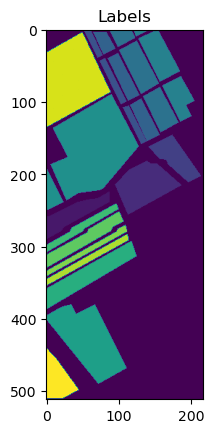

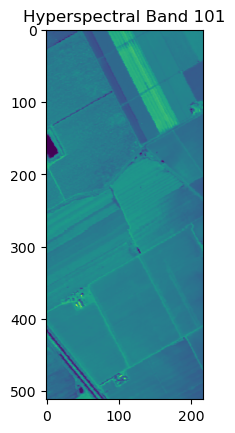

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53409 samples
	shape (53409, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(640, 5, 5, 204)
(80, 5, 5, 204)
(53409, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1543, PSNR: 7.2128


	 Training Batch [200/677], Loss: 0.0864, PSNR: 9.7363


	 Training Batch [400/677], Loss: 0.0430, PSNR: 12.7991


	 Training Batch [600/677], Loss: 0.0237, PSNR: 15.3438


Epoch [1/50] Training Loss: 0.0653, PSNR: 11.7468
	[Val]   Batch [1/170] Loss: 0.0212, PSNR: 15.8192
	[Val]   Batch [10/170] Loss: 0.0208, PSNR: 15.9946
	[Val]   Batch [20/170] Loss: 0.0209, PSNR: 15.9009
	[Val]   Batch [30/170] Loss: 0.0217, PSNR: 15.6828
	[Val]   Batch [40/170] Loss: 0.0218, PSNR: 15.7566


	[Val]   Batch [50/170] Loss: 0.0206, PSNR: 15.9734
	[Val]   Batch [60/170] Loss: 0.0216, PSNR: 15.8394
	[Val]   Batch [70/170] Loss: 0.0211, PSNR: 15.9261
	[Val]   Batch [80/170] Loss: 0.0215, PSNR: 15.7468
	[Val]   Batch [90/170] Loss: 0.0208, PSNR: 15.9806


	[Val]   Batch [100/170] Loss: 0.0209, PSNR: 15.9013
	[Val]   Batch [110/170] Loss: 0.0209, PSNR: 15.8941
	[Val]   Batch [120/170] Loss: 0.0197, PSNR: 14.2095
	[Val]   Batch [130/170] Loss: 0.0208, PSNR: 15.9879
	[Val]   Batch [140/170] Loss: 0.0204, PSNR: 16.0490


	[Val]   Batch [150/170] Loss: 0.0219, PSNR: 15.7864
	[Val]   Batch [160/170] Loss: 0.0215, PSNR: 15.8274
	[Val]   Batch [170/170] Loss: 0.0222, PSNR: 15.1263
Epoch [1/50] Validation Loss: 0.0212, PSNR: 15.8140

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0198, PSNR: 16.2137


	 Training Batch [200/677], Loss: 0.0156, PSNR: 17.1848


	 Training Batch [400/677], Loss: 0.0114, PSNR: 18.2548


	 Training Batch [600/677], Loss: 0.0096, PSNR: 19.2650


Epoch [2/50] Training Loss: 0.0131, PSNR: 18.0335
	[Val]   Batch [1/170] Loss: 0.0088, PSNR: 19.6230
	[Val]   Batch [10/170] Loss: 0.0083, PSNR: 19.9672
	[Val]   Batch [20/170] Loss: 0.0084, PSNR: 19.8392
	[Val]   Batch [30/170] Loss: 0.0091, PSNR: 19.4366
	[Val]   Batch [40/170] Loss: 0.0094, PSNR: 19.4202


	[Val]   Batch [50/170] Loss: 0.0082, PSNR: 19.9982
	[Val]   Batch [60/170] Loss: 0.0091, PSNR: 19.5679
	[Val]   Batch [70/170] Loss: 0.0089, PSNR: 19.6755
	[Val]   Batch [80/170] Loss: 0.0090, PSNR: 19.5287
	[Val]   Batch [90/170] Loss: 0.0086, PSNR: 19.8230


	[Val]   Batch [100/170] Loss: 0.0086, PSNR: 19.7415
	[Val]   Batch [110/170] Loss: 0.0085, PSNR: 19.8050
	[Val]   Batch [120/170] Loss: 0.0074, PSNR: 18.4647
	[Val]   Batch [130/170] Loss: 0.0086, PSNR: 19.8290
	[Val]   Batch [140/170] Loss: 0.0080, PSNR: 20.1171


	[Val]   Batch [150/170] Loss: 0.0094, PSNR: 19.4596
	[Val]   Batch [160/170] Loss: 0.0091, PSNR: 19.5628
	[Val]   Batch [170/170] Loss: 0.0094, PSNR: 18.8736
Epoch [2/50] Validation Loss: 0.0087, PSNR: 19.6681

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0075, PSNR: 20.0462


	 Training Batch [200/677], Loss: 0.0072, PSNR: 20.5962


	 Training Batch [400/677], Loss: 0.0065, PSNR: 21.0037


	 Training Batch [600/677], Loss: 0.0063, PSNR: 21.2031


Epoch [3/50] Training Loss: 0.0068, PSNR: 20.8104
	[Val]   Batch [1/170] Loss: 0.0052, PSNR: 21.8929
	[Val]   Batch [10/170] Loss: 0.0049, PSNR: 22.2744
	[Val]   Batch [20/170] Loss: 0.0050, PSNR: 22.1477
	[Val]   Batch [30/170] Loss: 0.0054, PSNR: 21.6976
	[Val]   Batch [40/170] Loss: 0.0056, PSNR: 21.6318


	[Val]   Batch [50/170] Loss: 0.0048, PSNR: 22.2971
	[Val]   Batch [60/170] Loss: 0.0055, PSNR: 21.8117
	[Val]   Batch [70/170] Loss: 0.0053, PSNR: 21.9104
	[Val]   Batch [80/170] Loss: 0.0053, PSNR: 21.8075
	[Val]   Batch [90/170] Loss: 0.0051, PSNR: 22.0707


	[Val]   Batch [100/170] Loss: 0.0052, PSNR: 21.9847
	[Val]   Batch [110/170] Loss: 0.0050, PSNR: 22.0745
	[Val]   Batch [120/170] Loss: 0.0043, PSNR: 20.8288
	[Val]   Batch [130/170] Loss: 0.0051, PSNR: 22.0929
	[Val]   Batch [140/170] Loss: 0.0047, PSNR: 22.4629


	[Val]   Batch [150/170] Loss: 0.0056, PSNR: 21.6970
	[Val]   Batch [160/170] Loss: 0.0054, PSNR: 21.8080
	[Val]   Batch [170/170] Loss: 0.0055, PSNR: 21.2207
Epoch [3/50] Validation Loss: 0.0052, PSNR: 21.9533

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0051, PSNR: 21.9404


	 Training Batch [200/677], Loss: 0.0039, PSNR: 22.8978


	 Training Batch [400/677], Loss: 0.0034, PSNR: 23.4718


	 Training Batch [600/677], Loss: 0.0030, PSNR: 24.3092


Epoch [4/50] Training Loss: 0.0039, PSNR: 23.2503
	[Val]   Batch [1/170] Loss: 0.0028, PSNR: 24.6221
	[Val]   Batch [10/170] Loss: 0.0027, PSNR: 24.8791
	[Val]   Batch [20/170] Loss: 0.0027, PSNR: 24.7414
	[Val]   Batch [30/170] Loss: 0.0030, PSNR: 24.3040
	[Val]   Batch [40/170] Loss: 0.0029, PSNR: 24.4874


	[Val]   Batch [50/170] Loss: 0.0027, PSNR: 24.7718
	[Val]   Batch [60/170] Loss: 0.0029, PSNR: 24.5223
	[Val]   Batch [70/170] Loss: 0.0028, PSNR: 24.7471
	[Val]   Batch [80/170] Loss: 0.0028, PSNR: 24.5499


	[Val]   Batch [90/170] Loss: 0.0028, PSNR: 24.7458
	[Val]   Batch [100/170] Loss: 0.0029, PSNR: 24.5105
	[Val]   Batch [110/170] Loss: 0.0027, PSNR: 24.7649
	[Val]   Batch [120/170] Loss: 0.0025, PSNR: 23.0927
	[Val]   Batch [130/170] Loss: 0.0029, PSNR: 24.5880


	[Val]   Batch [140/170] Loss: 0.0026, PSNR: 25.0469
	[Val]   Batch [150/170] Loss: 0.0030, PSNR: 24.4595
	[Val]   Batch [160/170] Loss: 0.0029, PSNR: 24.5800
	[Val]   Batch [170/170] Loss: 0.0030, PSNR: 23.8748
Epoch [4/50] Validation Loss: 0.0028, PSNR: 24.5957

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0033, PSNR: 23.9796


	 Training Batch [200/677], Loss: 0.0028, PSNR: 24.4836


	 Training Batch [400/677], Loss: 0.0024, PSNR: 24.7156


	 Training Batch [600/677], Loss: 0.0023, PSNR: 25.5349


Epoch [5/50] Training Loss: 0.0024, PSNR: 25.2667
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.2916
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.5523
	[Val]   Batch [20/170] Loss: 0.0019, PSNR: 26.3509
	[Val]   Batch [30/170] Loss: 0.0021, PSNR: 25.8612
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.2422


	[Val]   Batch [50/170] Loss: 0.0019, PSNR: 26.3903
	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.1471
	[Val]   Batch [70/170] Loss: 0.0019, PSNR: 26.4827
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.2015
	[Val]   Batch [90/170] Loss: 0.0019, PSNR: 26.4205


	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.0436
	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.5467
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.6316
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.1039


	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.7218
	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.0732
	[Val]   Batch [160/170] Loss: 0.0020, PSNR: 26.2420
	[Val]   Batch [170/170] Loss: 0.0021, PSNR: 25.4725
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.2235

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0018, PSNR: 26.5118


	 Training Batch [200/677], Loss: 0.0018, PSNR: 26.5405


	 Training Batch [400/677], Loss: 0.0015, PSNR: 27.4407


	 Training Batch [600/677], Loss: 0.0017, PSNR: 26.9811


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.5710
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.7275
	[Val]   Batch [10/170] Loss: 0.0013, PSNR: 28.0023
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.7512
	[Val]   Batch [30/170] Loss: 0.0015, PSNR: 27.2103
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.7354


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.7139
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.5521
	[Val]   Batch [70/170] Loss: 0.0013, PSNR: 27.9768
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.6570
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.8377


	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.3595
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 28.0883
	[Val]   Batch [120/170] Loss: 0.0013, PSNR: 25.8997
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.4307
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 28.1626


	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.4804
	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.6808
	[Val]   Batch [170/170] Loss: 0.0014, PSNR: 26.9851
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.6355

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0015, PSNR: 27.4662


	 Training Batch [200/677], Loss: 0.0016, PSNR: 26.4997


	 Training Batch [400/677], Loss: 0.0015, PSNR: 27.3527


	 Training Batch [600/677], Loss: 0.0014, PSNR: 27.6903


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.5459
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.6579
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.9518
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.6483
	[Val]   Batch [30/170] Loss: 0.0012, PSNR: 28.0824
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.7092


	[Val]   Batch [50/170] Loss: 0.0011, PSNR: 28.5707
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.4658
	[Val]   Batch [70/170] Loss: 0.0010, PSNR: 28.9747
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.6070
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.7968


	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.2510
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 29.1256
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.7429
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.3236
	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.1066


	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.3909
	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.6220
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.9375
Epoch [7/50] Validation Loss: 0.0011, PSNR: 28.5547

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.3779


	 Training Batch [200/677], Loss: 0.0012, PSNR: 28.5071


	 Training Batch [400/677], Loss: 0.0012, PSNR: 28.2460


	 Training Batch [600/677], Loss: 0.0010, PSNR: 28.6340


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.3132
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.3869
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.6469
	[Val]   Batch [20/170] Loss: 0.0010, PSNR: 29.3264
	[Val]   Batch [30/170] Loss: 0.0011, PSNR: 28.7271
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.4519


	[Val]   Batch [50/170] Loss: 0.0010, PSNR: 29.2838
	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.1263
	[Val]   Batch [70/170] Loss: 0.0009, PSNR: 29.7125
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.3001


	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.5677
	[Val]   Batch [100/170] Loss: 0.0011, PSNR: 28.8941
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 29.8716
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.4505
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 28.9643


	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 29.8547
	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 28.9994
	[Val]   Batch [160/170] Loss: 0.0010, PSNR: 29.2973
	[Val]   Batch [170/170] Loss: 0.0010, PSNR: 28.5629
Epoch [8/50] Validation Loss: 0.0010, PSNR: 29.2318

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.3183


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.5345


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.5293


	 Training Batch [600/677], Loss: 0.0011, PSNR: 28.6051


Epoch [9/50] Training Loss: 0.0010, PSNR: 29.0204
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.4279
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.6887
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.3627
	[Val]   Batch [30/170] Loss: 0.0009, PSNR: 29.7228
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.5363


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.1769
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.1471
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.8057
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.3924
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.6028


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 29.8795
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 30.9879
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.3236
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 29.9725
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.8788


	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.0384
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.3423
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.7650
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.2657

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.4340


	 Training Batch [200/677], Loss: 0.0010, PSNR: 29.0546


	 Training Batch [400/677], Loss: 0.0009, PSNR: 28.9466


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.5933


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.6269
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.1852
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.4958
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.1040
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.5274
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.3118


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.9063
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.9403
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.5564
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.2134
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.4290


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.7170
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 31.7846
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.0528
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.8052
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.6709


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.8531
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.0780
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.6083
Epoch [10/50] Validation Loss: 0.0006, PSNR: 31.0429

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.1466


	 Training Batch [200/677], Loss: 0.0010, PSNR: 29.3295


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.6144


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.3864


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.2479
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.7835
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.0770
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.6485
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.1742
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 31.9133


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.4390
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.5513
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.1087
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.8376
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.0981


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.4166
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.3640
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.6546
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.5066
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.2286


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.5010
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.6320
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.3125
Epoch [11/50] Validation Loss: 0.0006, PSNR: 31.6457

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.0673


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.1792


	 Training Batch [400/677], Loss: 0.0007, PSNR: 31.0042


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.6206


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.7722
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 32.7343
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.1033
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.5778
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.1584
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.8528


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.3283
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.5438
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.0052
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.8536
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.0871


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.4297
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.3500
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.5756
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.5245
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.2029


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.5333
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.5419
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.5186
Epoch [12/50] Validation Loss: 0.0004, PSNR: 32.6234

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.1906


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.4046


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.2744


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.9284


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.2684
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.2271
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.5991
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.0411
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.6986
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.3300
	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.8063


	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.0739
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.4335
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.3646
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.6595
	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.0213


	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 33.8374
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.1145
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.0890
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 33.7187
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.0658


	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.9826
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 33.0064
Epoch [13/50] Validation Loss: 0.0004, PSNR: 33.1172

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.0050


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.5770


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.7449


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.1402


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.6728
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.5689
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 33.8721
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.2975
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.1046
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.6519


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.1134
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.4784
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.7312
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.6962
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.0658


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.4751
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.1131
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.4640
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.5686
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.0033


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.4734
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.2820
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.3962
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.4568

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.4791


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.5499


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.0533


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.3421


Epoch [15/50] Training Loss: 0.0005, PSNR: 32.0228
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.1977
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.4961
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.8643
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.7277
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.2455


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.6572
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.0900
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.2798
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.3343
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.6949


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.0694
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.6988
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.0335
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.1799


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.6186
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.0645
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.8204
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.1703
Epoch [15/50] Validation Loss: 0.0003, PSNR: 34.0639

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.3828


	 Training Batch [200/677], Loss: 0.0004, PSNR: 33.3451


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.4361


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.3935


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.3548
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.6581
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 35.0317
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.3432
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.2790
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.7095


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.1250
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.6299
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.7054
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.8514
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.2495


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.6447
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.2152
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.5423
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.7581
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 35.1587


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.6048
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.2712
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.8261
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.5640

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.6719


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.4534


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.0839


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.5145


Epoch [17/50] Training Loss: 0.0004, PSNR: 32.6570
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.6303
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.9653
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.3030
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.2381
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.6730


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.1207
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.5654
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.6486
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.7309
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.2352


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.6340
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 35.1166
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.6335
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.7299
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 35.0953


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.5248
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.2076
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.6831
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.5048

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.5864


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.9308


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.0432


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.6302


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.8647
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.3869
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.6975
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.9711
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 35.0443
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.4512


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.6920
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.4494
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.4231
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.6366
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.0450


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.4560
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.9429
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.1936
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.5655
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.8630


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.4524
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.9509
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.6336
Epoch [18/50] Validation Loss: 0.0002, PSNR: 35.2820
Early stopping triggered at epoch 18. No improvement for 3 epochs.


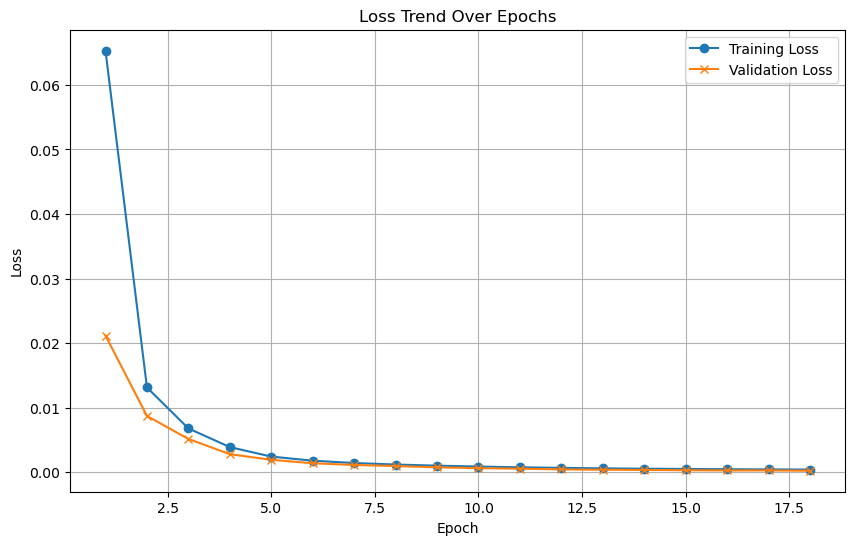

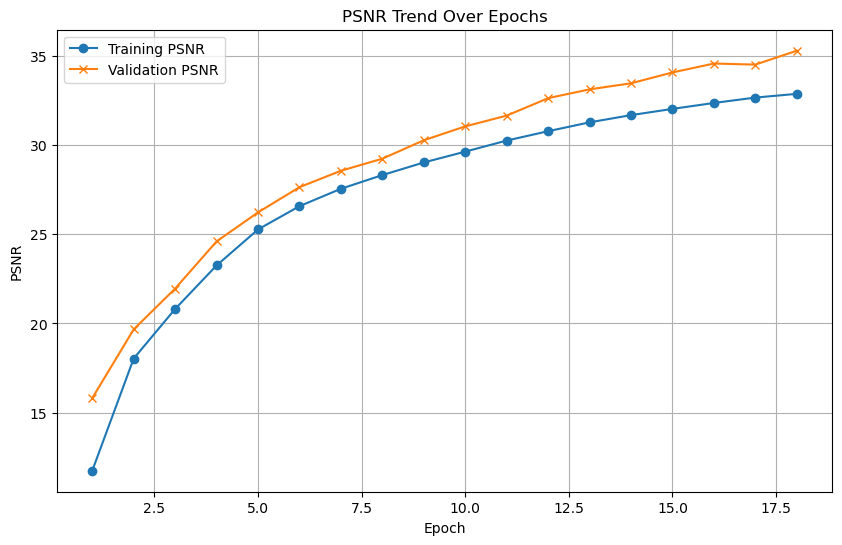

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/209 for test dataset.


    Processed batch 101/209 for test dataset.


    Processed batch 201/209 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7869
    Validation Batch [1/1], Loss: 2.7809
Validation Loss: 2.7809, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7809. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6973
    Validation Batch [1/1], Loss: 2.7809
Validation Loss: 2.7809, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.6479
    Validation Batch [1/1], Loss: 2.7810
Validation Loss: 2.7810, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6191
    Validation Batch [1/1], Loss: 2.7811
Validation Loss: 2.7811, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [9/1000] completed, Average Training Loss: 2.4883
    Validation Batch [1/1], Loss: 2.7806
Validation Loss: 2.7806, Validation Accuracy: 6.25%
Validation loss improved from 2.7809 to 2.7806. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.4535
    Validation Batch [1/1], Loss: 2.7803
Validation Loss: 2.7803, Validation Accuracy: 6.25%
Validation loss improved from 2.7806 to 2.7803. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.4267
    Validation Batch [1/1], Loss: 2.7802
Validation Loss: 2.7802, Validation Accuracy: 6.25%
Validation loss improved from 2.7803 to 2.7802. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.4114
    Validation Batch [1/1], Loss: 2.7795
Validation Loss: 2.7795, Validation Accuracy: 6.25%
Validation loss improved from 2.7802 to 2.7795. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13/100

Epoch [22/1000] completed, Average Training Loss: 2.2240
    Validation Batch [1/1], Loss: 2.6678
Validation Loss: 2.6678, Validation Accuracy: 12.50%
Validation loss improved from 2.6964 to 2.6678. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.2035
    Validation Batch [1/1], Loss: 2.6319
Validation Loss: 2.6319, Validation Accuracy: 13.75%
Validation loss improved from 2.6678 to 2.6319. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.1774
    Validation Batch [1/1], Loss: 2.5950
Validation Loss: 2.5950, Validation Accuracy: 18.75%
Validation loss improved from 2.6319 to 2.5950. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.1761
    Validation Batch [1/1], Loss: 2.5642
Validation Loss: 2.5642, Validation Accuracy: 21.25%
Validation loss improved from 2.5950 to 2.5642. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [2

Epoch [35/1000] completed, Average Training Loss: 1.9862
    Validation Batch [1/1], Loss: 2.1161
Validation Loss: 2.1161, Validation Accuracy: 46.25%
Validation loss improved from 2.1510 to 2.1161. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 1.9841
    Validation Batch [1/1], Loss: 2.0763
Validation Loss: 2.0763, Validation Accuracy: 47.50%
Validation loss improved from 2.1161 to 2.0763. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 1.9542
    Validation Batch [1/1], Loss: 2.0564
Validation Loss: 2.0564, Validation Accuracy: 45.00%
Validation loss improved from 2.0763 to 2.0564. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 1.9306
    Validation Batch [1/1], Loss: 2.0344
Validation Loss: 2.0344, Validation Accuracy: 43.75%
Validation loss improved from 2.0564 to 2.0344. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [3

Epoch [43/1000] completed, Average Training Loss: 1.8460
    Validation Batch [1/1], Loss: 1.9055
Validation Loss: 1.9055, Validation Accuracy: 55.00%
Validation loss improved from 1.9481 to 1.9055. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 1.8398
    Validation Batch [1/1], Loss: 1.8941
Validation Loss: 1.8941, Validation Accuracy: 53.75%
Validation loss improved from 1.9055 to 1.8941. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 1.8181
    Validation Batch [1/1], Loss: 1.8431
Validation Loss: 1.8431, Validation Accuracy: 60.00%
Validation loss improved from 1.8941 to 1.8431. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 1.7999
    Validation Batch [1/1], Loss: 1.8315
Validation Loss: 1.8315, Validation Accuracy: 57.50%
Validation loss improved from 1.8431 to 1.8315. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [4

Epoch [56/1000] completed, Average Training Loss: 1.6252
    Validation Batch [1/1], Loss: 1.6121
Validation Loss: 1.6121, Validation Accuracy: 73.75%
Validation loss improved from 1.6269 to 1.6121. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.6043
    Validation Batch [1/1], Loss: 1.5848
Validation Loss: 1.5848, Validation Accuracy: 75.00%
Validation loss improved from 1.6121 to 1.5848. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.5980
    Validation Batch [1/1], Loss: 1.5654
Validation Loss: 1.5654, Validation Accuracy: 75.00%
Validation loss improved from 1.5848 to 1.5654. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 1.5761
    Validation Batch [1/1], Loss: 1.5641
Validation Loss: 1.5641, Validation Accuracy: 76.25%
Validation loss improved from 1.5654 to 1.5641. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 1.3613
Validation Loss: 1.3613, Validation Accuracy: 78.75%
Validation loss improved from 1.3884 to 1.3613. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.3851
    Validation Batch [1/1], Loss: 1.3639
Validation Loss: 1.3639, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.3875
    Validation Batch [1/1], Loss: 1.3308
Validation Loss: 1.3308, Validation Accuracy: 80.00%
Validation loss improved from 1.3613 to 1.3308. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.3752
    Validation Batch [1/1], Loss: 1.3271
Validation Loss: 1.3271, Validation Accuracy: 80.00%
Validation loss improved from 1.3308 to 1.3271. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 1.3537
    Validation Batch [1

    Validation Batch [1/1], Loss: 1.1665
Validation Loss: 1.1665, Validation Accuracy: 86.25%
Validation loss improved from 1.1844 to 1.1665. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.2069
    Validation Batch [1/1], Loss: 1.1243
Validation Loss: 1.1243, Validation Accuracy: 82.50%
Validation loss improved from 1.1665 to 1.1243. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.1859
    Validation Batch [1/1], Loss: 1.1264
Validation Loss: 1.1264, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.1792
    Validation Batch [1/1], Loss: 1.1066
Validation Loss: 1.1066, Validation Accuracy: 86.25%
Validation loss improved from 1.1243 to 1.1066. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.1516
    Validation Batch [1

Epoch [94/1000] completed, Average Training Loss: 1.0157
    Validation Batch [1/1], Loss: 0.9638
Validation Loss: 0.9638, Validation Accuracy: 85.00%
Validation loss improved from 0.9785 to 0.9638. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.0156
    Validation Batch [1/1], Loss: 0.9662
Validation Loss: 0.9662, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 0.9972
    Validation Batch [1/1], Loss: 0.9222
Validation Loss: 0.9222, Validation Accuracy: 88.75%
Validation loss improved from 0.9638 to 0.9222. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 0.9897
    Validation Batch [1/1], Loss: 0.9314
Validation Loss: 0.9314, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Tra

Epoch [107/1000] completed, Average Training Loss: 0.8266
    Validation Batch [1/1], Loss: 0.7765
Validation Loss: 0.7765, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 0.8159
    Validation Batch [1/1], Loss: 0.7461
Validation Loss: 0.7461, Validation Accuracy: 92.50%
Validation loss improved from 0.7652 to 0.7461. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 0.8151
    Validation Batch [1/1], Loss: 0.7447
Validation Loss: 0.7447, Validation Accuracy: 96.25%
Validation loss improved from 0.7461 to 0.7447. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 0.8102
    Validation Batch [1/1], Loss: 0.7087
Validation Loss: 0.7087, Validation Accuracy: 95.00%
Validation loss improved from 0.7447 to 0.7087. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000

    Validation Batch [1/1], Loss: 0.5983
Validation Loss: 0.5983, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 0.6739
    Validation Batch [1/1], Loss: 0.5917
Validation Loss: 0.5917, Validation Accuracy: 95.00%
Validation loss improved from 0.5938 to 0.5917. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 0.6700
    Validation Batch [1/1], Loss: 0.5940
Validation Loss: 0.5940, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.6577
    Validation Batch [1/1], Loss: 0.5580
Validation Loss: 0.5580, Validation Accuracy: 97.50%
Validation loss improved from 0.5917 to 0.5580. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 0.6288
    Validation Batch [1/1], Lo

Epoch [134/1000] completed, Average Training Loss: 0.5433
    Validation Batch [1/1], Loss: 0.4706
Validation Loss: 0.4706, Validation Accuracy: 97.50%
Validation loss improved from 0.4718 to 0.4706. Saving model...

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 0.5112
    Validation Batch [1/1], Loss: 0.4531
Validation Loss: 0.4531, Validation Accuracy: 97.50%
Validation loss improved from 0.4706 to 0.4531. Saving model...

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 0.5104
    Validation Batch [1/1], Loss: 0.4447
Validation Loss: 0.4447, Validation Accuracy: 97.50%
Validation loss improved from 0.4531 to 0.4447. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.5103
    Validation Batch [1/1], Loss: 0.4225
Validation Loss: 0.4225, Validation Accuracy: 96.25%
Validation loss improved from 0.4447 to 0.4225. Saving model...

LOG: Epoch [138/1000] - Training


    Validation Batch [1/1], Loss: 0.3762
Validation Loss: 0.3762, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.4172
    Validation Batch [1/1], Loss: 0.3562
Validation Loss: 0.3562, Validation Accuracy: 97.50%
Validation loss improved from 0.3656 to 0.3562. Saving model...

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 0.4327
    Validation Batch [1/1], Loss: 0.3561
Validation Loss: 0.3561, Validation Accuracy: 97.50%
Validation loss improved from 0.3562 to 0.3561. Saving model...

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 0.4184
    Validation Batch [1/1], Loss: 0.3418
Validation Loss: 0.3418, Validation Accuracy: 97.50%
Validation loss improved from 0.3561 to 0.3418. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 0.4206
    Validation 

Epoch [161/1000] completed, Average Training Loss: 0.3583
    Validation Batch [1/1], Loss: 0.3159
Validation Loss: 0.3159, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.3528
    Validation Batch [1/1], Loss: 0.2844
Validation Loss: 0.2844, Validation Accuracy: 97.50%
Validation loss improved from 0.3016 to 0.2844. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 0.3461
    Validation Batch [1/1], Loss: 0.3173
Validation Loss: 0.3173, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 0.3385
    Validation Batch [1/1], Loss: 0.2776
Validation Loss: 0.2776, Validation Accuracy: 97.50%
Validation loss improved from 0.2844 to 0.2776. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Av

Epoch [175/1000] completed, Average Training Loss: 0.2768
    Validation Batch [1/1], Loss: 0.2466
Validation Loss: 0.2466, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.2702
    Validation Batch [1/1], Loss: 0.2483
Validation Loss: 0.2483, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.2637
    Validation Batch [1/1], Loss: 0.2396
Validation Loss: 0.2396, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.2707
    Validation Batch [1/1], Loss: 0.2334
Validation Loss: 0.2334, Validation Accuracy: 97.50%
Validation loss improved from 0.2350 to 0.2334. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training 

Epoch [189/1000] completed, Average Training Loss: 0.2259
    Validation Batch [1/1], Loss: 0.2065
Validation Loss: 0.2065, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.2257
    Validation Batch [1/1], Loss: 0.1892
Validation Loss: 0.1892, Validation Accuracy: 97.50%
Validation loss improved from 0.2009 to 0.1892. Saving model...

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.2148
    Validation Batch [1/1], Loss: 0.1929
Validation Loss: 0.1929, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.2225
    Validation Batch [1/1], Loss: 0.2025
Validation Loss: 0.2025, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training 

Epoch [202/1000] completed, Average Training Loss: 0.1924
    Validation Batch [1/1], Loss: 0.1663
Validation Loss: 0.1663, Validation Accuracy: 97.50%
Validation loss improved from 0.1705 to 0.1663. Saving model...

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.1851
    Validation Batch [1/1], Loss: 0.1774
Validation Loss: 0.1774, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.1803
    Validation Batch [1/1], Loss: 0.1660
Validation Loss: 0.1660, Validation Accuracy: 97.50%
Validation loss improved from 0.1663 to 0.1660. Saving model...

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.1711
    Validation Batch [1/1], Loss: 0.1665
Validation Loss: 0.1665, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Av

Epoch [215/1000] completed, Average Training Loss: 0.1505
    Validation Batch [1/1], Loss: 0.1497
Validation Loss: 0.1497, Validation Accuracy: 97.50%
Validation loss improved from 0.1540 to 0.1497. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.1635
    Validation Batch [1/1], Loss: 0.1515
Validation Loss: 0.1515, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.1442
    Validation Batch [1/1], Loss: 0.1572
Validation Loss: 0.1572, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.1522
    Validation Batch [1/1], Loss: 0.1392
Validation Loss: 0.1392, Validation Accuracy: 97.50%
Validation loss improved from 0.1497 to 0.1392. Saving model...

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Av

Epoch [229/1000] completed, Average Training Loss: 0.1381
    Validation Batch [1/1], Loss: 0.1611
Validation Loss: 0.1611, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.1372
    Validation Batch [1/1], Loss: 0.1433
Validation Loss: 0.1433, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.1291
    Validation Batch [1/1], Loss: 0.1339
Validation Loss: 0.1339, Validation Accuracy: 97.50%
Validation loss improved from 0.1354 to 0.1339. Saving model...

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.1324
    Validation Batch [1/1], Loss: 0.1685
Validation Loss: 0.1685, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training 

Epoch [243/1000] completed, Average Training Loss: 0.1172
    Validation Batch [1/1], Loss: 0.1335
Validation Loss: 0.1335, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.1133
    Validation Batch [1/1], Loss: 0.1287
Validation Loss: 0.1287, Validation Accuracy: 97.50%
Validation loss improved from 0.1321 to 0.1287. Saving model...

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.1126
    Validation Batch [1/1], Loss: 0.1277
Validation Loss: 0.1277, Validation Accuracy: 97.50%
Validation loss improved from 0.1287 to 0.1277. Saving model...

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.1135
    Validation Batch [1/1], Loss: 0.1339
Validation Loss: 0.1339, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Av

Epoch [257/1000] completed, Average Training Loss: 0.0981
    Validation Batch [1/1], Loss: 0.1305
Validation Loss: 0.1305, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.0962
    Validation Batch [1/1], Loss: 0.1156
Validation Loss: 0.1156, Validation Accuracy: 97.50%
Validation loss improved from 0.1182 to 0.1156. Saving model...

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.0889
    Validation Batch [1/1], Loss: 0.1130
Validation Loss: 0.1130, Validation Accuracy: 97.50%
Validation loss improved from 0.1156 to 0.1130. Saving model...

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.0936
    Validation Batch [1/1], Loss: 0.1173
Validation Loss: 0.1173, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Av

    Validation Batch [1/1], Loss: 0.1551
Validation Loss: 0.1551, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.0889
    Validation Batch [1/1], Loss: 0.1161
Validation Loss: 0.1161, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.0909
    Validation Batch [1/1], Loss: 0.1215
Validation Loss: 0.1215, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.0870
    Validation Batch [1/1], Loss: 0.1553
Validation Loss: 0.1553, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.0853
    Validation Batch [1/1], Loss: 0.1547
Validation Loss: 0.

Epoch [284/1000] completed, Average Training Loss: 0.0744
    Validation Batch [1/1], Loss: 0.1220
Validation Loss: 0.1220, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.0725
    Validation Batch [1/1], Loss: 0.1141
Validation Loss: 0.1141, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.0677
    Validation Batch [1/1], Loss: 0.1204
Validation Loss: 0.1204, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.0713
    Validation Batch [1/1], Loss: 0.1272
Validation Loss: 0.1272, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.075

Epoch [298/1000] completed, Average Training Loss: 0.0639
    Validation Batch [1/1], Loss: 0.1143
Validation Loss: 0.1143, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.0660
    Validation Batch [1/1], Loss: 0.1109
Validation Loss: 0.1109, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.0592
    Validation Batch [1/1], Loss: 0.1099
Validation Loss: 0.1099, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.0652
    Validation Batch [1/1], Loss: 0.1045
Validation Loss: 0.1045, Validation Accuracy: 97.50%
Validation loss improved from 0.1061 to 0.1045. Saving model...

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training 

Epoch [311/1000] completed, Average Training Loss: 0.0587
    Validation Batch [1/1], Loss: 0.1112
Validation Loss: 0.1112, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.0573
    Validation Batch [1/1], Loss: 0.1184
Validation Loss: 0.1184, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.0602
    Validation Batch [1/1], Loss: 0.1172
Validation Loss: 0.1172, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.0602
    Validation Batch [1/1], Loss: 0.1100
Validation Loss: 0.1100, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.0560

Epoch [324/1000] completed, Average Training Loss: 0.0492
    Validation Batch [1/1], Loss: 0.1044
Validation Loss: 0.1044, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.0531
    Validation Batch [1/1], Loss: 0.1222
Validation Loss: 0.1222, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training Loss: 0.0544
    Validation Batch [1/1], Loss: 0.1281
Validation Loss: 0.1281, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.0454
    Validation Batch [1/1], Loss: 0.1037
Validation Loss: 0.1037, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.055

Epoch [338/1000] completed, Average Training Loss: 0.0448
    Validation Batch [1/1], Loss: 0.1153
Validation Loss: 0.1153, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.0489
    Validation Batch [1/1], Loss: 0.1169
Validation Loss: 0.1169, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.0448
    Validation Batch [1/1], Loss: 0.1166
Validation Loss: 0.1166, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.1117
Validation Loss: 0.1117, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.046

Epoch [351/1000] completed, Average Training Loss: 0.0410
    Validation Batch [1/1], Loss: 0.1075
Validation Loss: 0.1075, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.1098
Validation Loss: 0.1098, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.0385
    Validation Batch [1/1], Loss: 0.1114
Validation Loss: 0.1114, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.0410
    Validation Batch [1/1], Loss: 0.1076
Validation Loss: 0.1076, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.036

Epoch [365/1000] completed, Average Training Loss: 0.0341
    Validation Batch [1/1], Loss: 0.1155
Validation Loss: 0.1155, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.0415
    Validation Batch [1/1], Loss: 0.1688
Validation Loss: 0.1688, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.0390
    Validation Batch [1/1], Loss: 0.1530
Validation Loss: 0.1530, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.0361
    Validation Batch [1/1], Loss: 0.1079
Validation Loss: 0.1079, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.039

Epoch [378/1000] completed, Average Training Loss: 0.0375
    Validation Batch [1/1], Loss: 0.1138
Validation Loss: 0.1138, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.0351
    Validation Batch [1/1], Loss: 0.1060
Validation Loss: 0.1060, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.0345
    Validation Batch [1/1], Loss: 0.1057
Validation Loss: 0.1057, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.0326
    Validation Batch [1/1], Loss: 0.1100
Validation Loss: 0.1100, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.032

    Validation Batch [1/1], Loss: 0.1104
Validation Loss: 0.1104, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.0342
    Validation Batch [1/1], Loss: 0.1123
Validation Loss: 0.1123, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.0342
    Validation Batch [1/1], Loss: 0.1133
Validation Loss: 0.1133, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.0331
    Validation Batch [1/1], Loss: 0.1138
Validation Loss: 0.1138, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.0358
    Validation Batch [1/1], Loss: 0.1161
Validation Loss

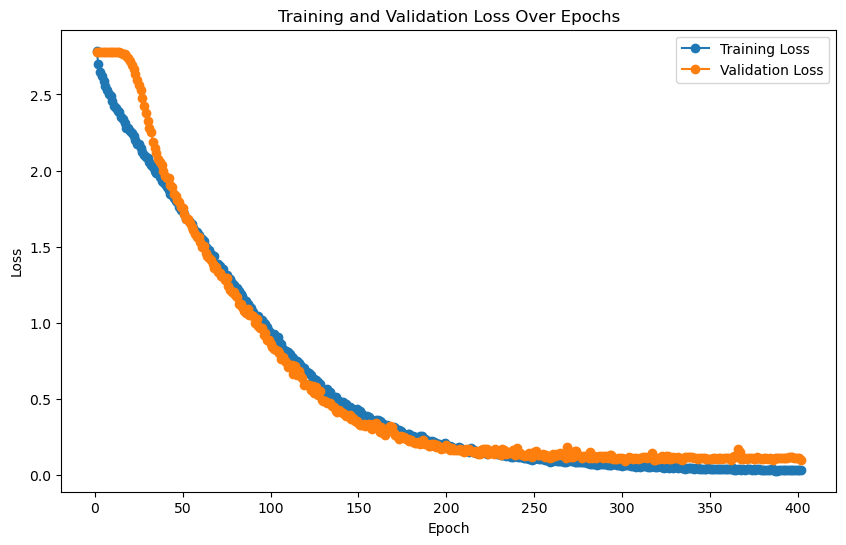

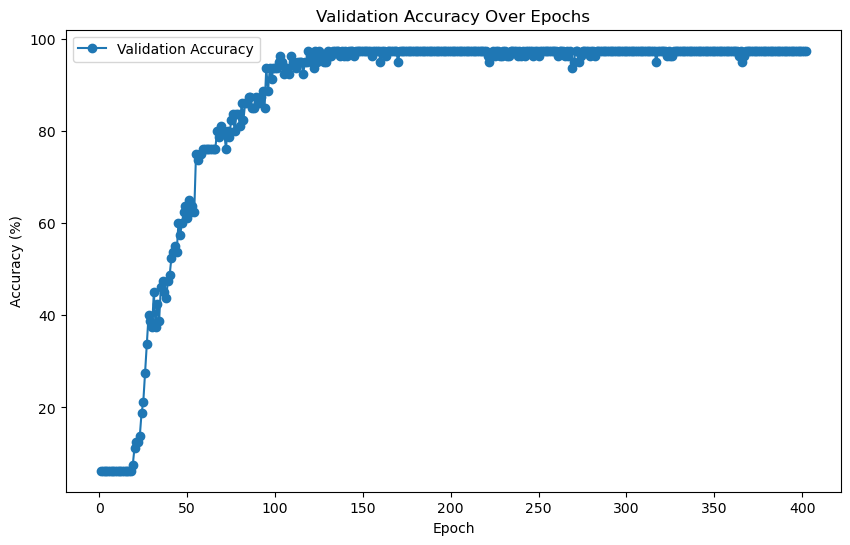


Evaluating on the test set...
    Test Batch [1/209], Loss: 0.1071



Final Test Loss: 0.3633, Test Accuracy: 89.96%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/209 for test dataset.
  Processed batch 20/209 for test dataset.
  Processed batch 30/209 for test dataset.


  Processed batch 40/209 for test dataset.
  Processed batch 50/209 for test dataset.
  Processed batch 60/209 for test dataset.
  Processed batch 70/209 for test dataset.


  Processed batch 80/209 for test dataset.
  Processed batch 90/209 for test dataset.
  Processed batch 100/209 for test dataset.
  Processed batch 110/209 for test dataset.
  Processed batch 120/209 for test dataset.


  Processed batch 130/209 for test dataset.
  Processed batch 140/209 for test dataset.
  Processed batch 150/209 for test dataset.
  Processed batch 160/209 for test dataset.
  Processed batch 170/209 for test dataset.


  Processed batch 180/209 for test dataset.
  Processed batch 190/209 for test dataset.
  Processed batch 200/209 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)

LOG: Training features shape: (640, 64), Training labels shape: (640,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53409, 64), Test labels shape: (53409,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 96.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.71      1.00      0.83         5
           8       1.00      1.

Test Accuracy: 82.55%

Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1964
           1       1.00      0.97      0.98      3681
           2       0.95      0.95      0.95      1931
           3       0.84      1.00      0.91      1349
           4       0.98      0.97      0.97      2633
           5       1.00      0.99      1.00      3914
           6       0.91      0.99      0.95      3534
           7       0.74      0.58      0.65     11226
           8       0.99      0.92      0.96      6158
           9       0.86      0.79      0.82      3233
          10       0.58      0.96      0.72      1023
          11       0.90      0.98      0.94      1882
          12       0.85      0.98      0.91       871
          13       0.94      0.87      0.91      1025
          14       0.53      0.66      0.58      7223
          15       0.81      0.82      0.82      1762

    accuracy                

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)
Train reps shape: (640, 64)
Train labels shape: (640,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53409, 64)
Test labels shape: (53409,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7358  |  Val Loss: 2.6292
Validation loss improved from inf to 2.6292.
[Epoch 2/1000] Train Loss: 2.5310  |  Val Loss: 2.4786
Validation loss improved from 2.6292 to 2.4786.
[Epoch 3/1000] Train Loss: 2.3596  |  Val Loss: 2.2797
Validation loss improved from 2.4786 to 2.2797.


[Epoch 4/1000] Train Loss: 2.1510  |  Val Loss: 2.0889
Validation loss improved from 2.2797 to 2.0889.
[Epoch 5/1000] Train Loss: 1.9512  |  Val Loss: 1.9018
Validation loss improved from 2.0889 to 1.9018.
[Epoch 6/1000] Train Loss: 1.7542  |  Val Loss: 1.7443
Validation loss improved from 1.9018 to 1.7443.


[Epoch 7/1000] Train Loss: 1.5738  |  Val Loss: 1.5793
Validation loss improved from 1.7443 to 1.5793.
[Epoch 8/1000] Train Loss: 1.4111  |  Val Loss: 1.4434
Validation loss improved from 1.5793 to 1.4434.
[Epoch 9/1000] Train Loss: 1.2585  |  Val Loss: 1.3176
Validation loss improved from 1.4434 to 1.3176.
[Epoch 10/1000] Train Loss: 1.1150  |  Val Loss: 1.1823
Validation loss improved from 1.3176 to 1.1823.
[Epoch 11/1000] Train Loss: 0.9781  |  Val Loss: 1.0618
Validation loss improved from 1.1823 to 1.0618.


[Epoch 12/1000] Train Loss: 0.8462  |  Val Loss: 0.9529
Validation loss improved from 1.0618 to 0.9529.
[Epoch 13/1000] Train Loss: 0.7384  |  Val Loss: 0.8843
Validation loss improved from 0.9529 to 0.8843.


[Epoch 14/1000] Train Loss: 0.6499  |  Val Loss: 0.8368
Validation loss improved from 0.8843 to 0.8368.
[Epoch 15/1000] Train Loss: 0.5908  |  Val Loss: 0.7692
Validation loss improved from 0.8368 to 0.7692.
[Epoch 16/1000] Train Loss: 0.5260  |  Val Loss: 0.7694
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 17/1000] Train Loss: 0.4964  |  Val Loss: 0.7415
Validation loss improved from 0.7692 to 0.7415.
[Epoch 18/1000] Train Loss: 0.4542  |  Val Loss: 0.7570
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 19/1000] Train Loss: 0.4140  |  Val Loss: 0.7056
Validation loss improved from 0.7415 to 0.7056.
[Epoch 20/1000] Train Loss: 0.3839  |  Val Loss: 0.7234
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 21/1000] Train Loss: 0.3594  |  Val Loss: 0.7012
Validation loss improved from 0.7056 to 0.7012.


[Epoch 22/1000] Train Loss: 0.3436  |  Val Loss: 0.7045
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 23/1000] Train Loss: 0.3300  |  Val Loss: 0.7056
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 24/1000] Train Loss: 0.3157  |  Val Loss: 0.7021
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 25/1000] Train Loss: 0.3054  |  Val Loss: 0.7158
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 26/1000] Train Loss: 0.2890  |  Val Loss: 0.7558
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 27/1000] Train Loss: 0.2879  |  Val Loss: 0.7359
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 28/1000] Train Loss: 0.2784  |  Val Loss: 0.7565
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 29/1000] Train Loss: 0.2642  |  Val Loss: 0.7312
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 30/1000] Train Loss: 0.2639  |  Val Loss: 0.7441
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 31/1000] Train Loss: 0.2514  |  Val Loss: 0.7666
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 32/1000] Train Loss: 0.2504  |  Val Loss: 0.7566
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 33/1000] Train Loss: 0.2491  |  Val Loss: 0.7776
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 34/1000] Train Loss: 0.2375  |  Val Loss: 0.7963
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 35/1000] Train Loss: 0.2289  |  Val Loss: 0.7972
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 36/1000] Train Loss: 0.2256  |  Val Loss: 0.7935
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 37/1000] Train Loss: 0.2115  |  Val Loss: 0.7833
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 38/1000] Train Loss: 0.2235  |  Val Loss: 0.8263
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 39/1000] Train Loss: 0.2101  |  Val Loss: 0.8247
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 40/1000] Train Loss: 0.2103  |  Val Loss: 0.8856
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 41/1000] Train Loss: 0.2167  |  Val Loss: 0.8213
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 42/1000] Train Loss: 0.2021  |  Val Loss: 0.8604
!! Validation loss did NOT improve !! Patience: 21/100


[Epoch 43/1000] Train Loss: 0.1963  |  Val Loss: 0.8259
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 44/1000] Train Loss: 0.1801  |  Val Loss: 0.8571
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 45/1000] Train Loss: 0.1863  |  Val Loss: 0.8516
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 46/1000] Train Loss: 0.1765  |  Val Loss: 0.8522
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 47/1000] Train Loss: 0.1763  |  Val Loss: 0.8353
!! Validation loss did NOT improve !! Patience: 26/100


[Epoch 48/1000] Train Loss: 0.1852  |  Val Loss: 0.8859
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 49/1000] Train Loss: 0.2011  |  Val Loss: 0.9499
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 50/1000] Train Loss: 0.1675  |  Val Loss: 0.8792
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 51/1000] Train Loss: 0.1635  |  Val Loss: 0.9111
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 52/1000] Train Loss: 0.1637  |  Val Loss: 0.9271
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 53/1000] Train Loss: 0.1684  |  Val Loss: 0.9123
!! Validation loss did NOT improve !! Patience: 32/100


[Epoch 54/1000] Train Loss: 0.1621  |  Val Loss: 0.9216
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 55/1000] Train Loss: 0.1664  |  Val Loss: 0.9252
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 56/1000] Train Loss: 0.1639  |  Val Loss: 0.9306
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 57/1000] Train Loss: 0.1526  |  Val Loss: 0.9558
!! Validation loss did NOT improve !! Patience: 36/100


[Epoch 58/1000] Train Loss: 0.1520  |  Val Loss: 0.9370
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 59/1000] Train Loss: 0.1525  |  Val Loss: 0.9603
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 60/1000] Train Loss: 0.1507  |  Val Loss: 1.0157
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 61/1000] Train Loss: 0.1493  |  Val Loss: 0.9299
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 62/1000] Train Loss: 0.1429  |  Val Loss: 0.9610
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 63/1000] Train Loss: 0.1462  |  Val Loss: 1.0061
!! Validation loss did NOT improve !! Patience: 42/100


[Epoch 64/1000] Train Loss: 0.1415  |  Val Loss: 0.9921
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 65/1000] Train Loss: 0.1364  |  Val Loss: 0.9938
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 66/1000] Train Loss: 0.1365  |  Val Loss: 1.0164
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 67/1000] Train Loss: 0.1369  |  Val Loss: 1.0065
!! Validation loss did NOT improve !! Patience: 46/100


[Epoch 68/1000] Train Loss: 0.1402  |  Val Loss: 1.0415
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 69/1000] Train Loss: 0.1309  |  Val Loss: 1.0022
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 70/1000] Train Loss: 0.1370  |  Val Loss: 1.0206
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 71/1000] Train Loss: 0.1359  |  Val Loss: 1.0475
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 72/1000] Train Loss: 0.1325  |  Val Loss: 1.0607
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 73/1000] Train Loss: 0.1210  |  Val Loss: 1.0759
!! Validation loss did NOT improve !! Patience: 52/100


[Epoch 74/1000] Train Loss: 0.1429  |  Val Loss: 1.0402
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 75/1000] Train Loss: 0.1337  |  Val Loss: 1.0953
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 76/1000] Train Loss: 0.1260  |  Val Loss: 1.0493
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 77/1000] Train Loss: 0.1220  |  Val Loss: 1.1262
!! Validation loss did NOT improve !! Patience: 56/100


[Epoch 78/1000] Train Loss: 0.1299  |  Val Loss: 1.0797
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 79/1000] Train Loss: 0.1153  |  Val Loss: 1.0612
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 80/1000] Train Loss: 0.1251  |  Val Loss: 1.0954
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 81/1000] Train Loss: 0.1195  |  Val Loss: 1.1804
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 82/1000] Train Loss: 0.1366  |  Val Loss: 1.0490
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 83/1000] Train Loss: 0.1214  |  Val Loss: 1.1169
!! Validation loss did NOT improve !! Patience: 62/100


[Epoch 84/1000] Train Loss: 0.1136  |  Val Loss: 1.1038
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 85/1000] Train Loss: 0.1148  |  Val Loss: 1.1091
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 86/1000] Train Loss: 0.1042  |  Val Loss: 1.1436
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 87/1000] Train Loss: 0.1224  |  Val Loss: 1.1518
!! Validation loss did NOT improve !! Patience: 66/100


[Epoch 88/1000] Train Loss: 0.1098  |  Val Loss: 1.1097
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 89/1000] Train Loss: 0.1096  |  Val Loss: 1.1763
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 90/1000] Train Loss: 0.1065  |  Val Loss: 1.1428
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 91/1000] Train Loss: 0.1057  |  Val Loss: 1.1395
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 92/1000] Train Loss: 0.1087  |  Val Loss: 1.1691
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 93/1000] Train Loss: 0.1037  |  Val Loss: 1.1560
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 94/1000] Train Loss: 0.1133  |  Val Loss: 1.1529
!! Validation loss did NOT improve !! Patience: 73/100


[Epoch 95/1000] Train Loss: 0.1079  |  Val Loss: 1.2298
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 96/1000] Train Loss: 0.0969  |  Val Loss: 1.1801
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 97/1000] Train Loss: 0.1011  |  Val Loss: 1.1923
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 98/1000] Train Loss: 0.1004  |  Val Loss: 1.1709
!! Validation loss did NOT improve !! Patience: 77/100


[Epoch 99/1000] Train Loss: 0.0990  |  Val Loss: 1.2212
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 100/1000] Train Loss: 0.0982  |  Val Loss: 1.1838
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 101/1000] Train Loss: 0.1007  |  Val Loss: 1.2729
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 102/1000] Train Loss: 0.1048  |  Val Loss: 1.2071
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 103/1000] Train Loss: 0.0959  |  Val Loss: 1.2227
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 104/1000] Train Loss: 0.0934  |  Val Loss: 1.2564
!! Validation loss did NOT improve !! Patience: 83/100


[Epoch 105/1000] Train Loss: 0.0943  |  Val Loss: 1.2222
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 106/1000] Train Loss: 0.0982  |  Val Loss: 1.2121
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 107/1000] Train Loss: 0.0992  |  Val Loss: 1.2139
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 108/1000] Train Loss: 0.1004  |  Val Loss: 1.2714
!! Validation loss did NOT improve !! Patience: 87/100


[Epoch 109/1000] Train Loss: 0.0932  |  Val Loss: 1.2335
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 110/1000] Train Loss: 0.0923  |  Val Loss: 1.2541
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 111/1000] Train Loss: 0.0907  |  Val Loss: 1.2771
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 112/1000] Train Loss: 0.0940  |  Val Loss: 1.3357
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 113/1000] Train Loss: 0.1028  |  Val Loss: 1.2839
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 114/1000] Train Loss: 0.1009  |  Val Loss: 1.2976
!! Validation loss did NOT improve !! Patience: 93/100


[Epoch 115/1000] Train Loss: 0.0872  |  Val Loss: 1.2617
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 116/1000] Train Loss: 0.0949  |  Val Loss: 1.2955
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 117/1000] Train Loss: 0.0841  |  Val Loss: 1.2639
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 118/1000] Train Loss: 0.0905  |  Val Loss: 1.3430
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 119/1000] Train Loss: 0.0901  |  Val Loss: 1.3161
!! Validation loss did NOT improve !! Patience: 98/100


[Epoch 120/1000] Train Loss: 0.1061  |  Val Loss: 1.2977
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 121/1000] Train Loss: 0.0933  |  Val Loss: 1.2868
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 121 !!
No improvement for 100 epochs.


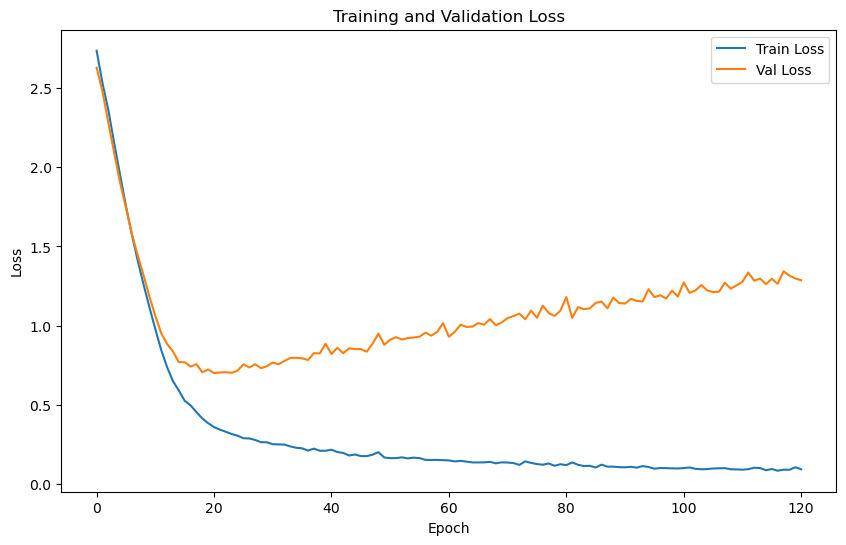

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.7967 | Test Accuracy: 79.16%


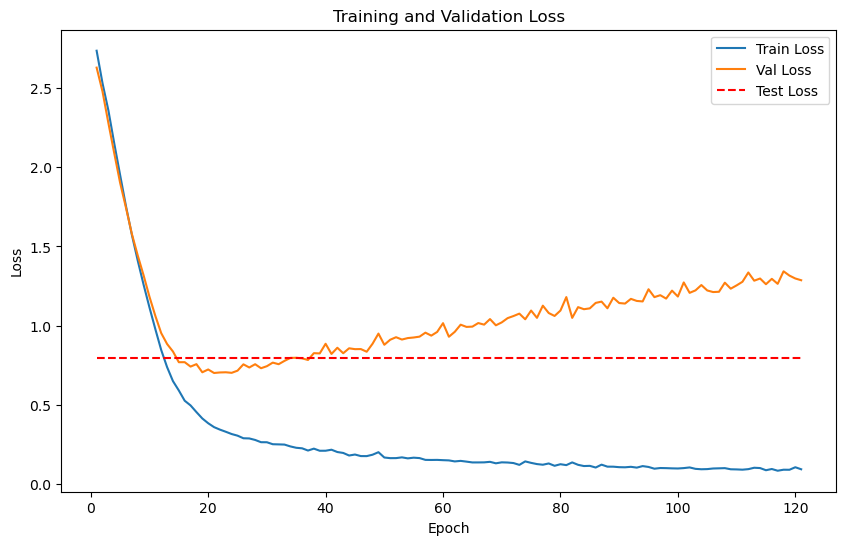

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)


Train embeddings shape: (640, 64), 
Train labels shape: (640,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53409, 64), 
Test labels shape: (53409,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 7.8439
    Batch [2/2], Train Loss: 7.9106
Epoch [1/2000], Avg Train Loss: 7.8772
Epoch [1/2000], Avg Val Loss: 3.3837
Validation loss improved from inf to 3.3837. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.0705
    Batch [2/2], Train Loss: 7.7448
Epoch [2/2000], Avg Train Loss: 7.9076
Epoch [2/2000], Avg Val Loss: 3.3499
Validation loss improved from 3.3837 to 3.3499. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 7.6421
    Batch [2/2], Train Loss: 7.6847
Epoch [3/2000], Avg Train Loss: 7.6634
Epoch [3/2000], Avg Val Loss: 3.3188
Validation loss improved from 3.3499 to 3.3188. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.5736
    Batch [2/2], Train Loss: 7.6965
Epoch [4/2000], Avg Train Loss: 7.6351
Epoch [4/2000], Avg Val Loss: 3.2901
Validation loss improved from 3.3188 to 3.2901. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss

    Batch [1/2], Train Loss: 6.8465
    Batch [2/2], Train Loss: 6.7632
Epoch [11/2000], Avg Train Loss: 6.8048
Epoch [11/2000], Avg Val Loss: 3.1373
Validation loss improved from 3.1547 to 3.1373. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 6.6019
    Batch [2/2], Train Loss: 6.6486
Epoch [12/2000], Avg Train Loss: 6.6252
Epoch [12/2000], Avg Val Loss: 3.1210
Validation loss improved from 3.1373 to 3.1210. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.6222
    Batch [2/2], Train Loss: 6.5211
Epoch [13/2000], Avg Train Loss: 6.5717
Epoch [13/2000], Avg Val Loss: 3.1058
Validation loss improved from 3.1210 to 3.1058. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.4427
    Batch [2/2], Train Loss: 6.3100
Epoch [14/2000], Avg Train Loss: 6.3763
Epoch [14/2000], Avg Val Loss: 3.0920
Validation loss improved from 3.1058 to 3.0920. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1

Epoch [20/2000], Avg Val Loss: 3.0286
Validation loss improved from 3.0373 to 3.0286. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 5.8634
    Batch [2/2], Train Loss: 5.8688
Epoch [21/2000], Avg Train Loss: 5.8661
Epoch [21/2000], Avg Val Loss: 3.0204
Validation loss improved from 3.0286 to 3.0204. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 5.8874
    Batch [2/2], Train Loss: 5.6874
Epoch [22/2000], Avg Train Loss: 5.7874
Epoch [22/2000], Avg Val Loss: 3.0129
Validation loss improved from 3.0204 to 3.0129. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 5.7351
    Batch [2/2], Train Loss: 5.7863
Epoch [23/2000], Avg Train Loss: 5.7607
Epoch [23/2000], Avg Val Loss: 3.0060
Validation loss improved from 3.0129 to 3.0060. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 5.6803
    Batch [2/2], Train Loss: 5.6872
Epoch [24/2000], Avg Train Loss: 5.6837
Epoch [24/20

    Batch [1/2], Train Loss: 5.3214
    Batch [2/2], Train Loss: 5.3585
Epoch [31/2000], Avg Train Loss: 5.3400
Epoch [31/2000], Avg Val Loss: 2.9671
Validation loss improved from 2.9709 to 2.9671. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 5.3455
    Batch [2/2], Train Loss: 5.3213
Epoch [32/2000], Avg Train Loss: 5.3334
Epoch [32/2000], Avg Val Loss: 2.9635
Validation loss improved from 2.9671 to 2.9635. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 5.2140
    Batch [2/2], Train Loss: 5.2974
Epoch [33/2000], Avg Train Loss: 5.2557
Epoch [33/2000], Avg Val Loss: 2.9601
Validation loss improved from 2.9635 to 2.9601. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.2706
    Batch [2/2], Train Loss: 5.2518
Epoch [34/2000], Avg Train Loss: 5.2612
Epoch [34/2000], Avg Val Loss: 2.9569
Validation loss improved from 2.9601 to 2.9569. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.0776
    Batch [2/2], Train Loss: 5.0210
Epoch [41/2000], Avg Train Loss: 5.0493
Epoch [41/2000], Avg Val Loss: 2.9389
Validation loss improved from 2.9413 to 2.9389. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 4.9983
    Batch [2/2], Train Loss: 5.1473
Epoch [42/2000], Avg Train Loss: 5.0728
Epoch [42/2000], Avg Val Loss: 2.9366
Validation loss improved from 2.9389 to 2.9366. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 5.0155
    Batch [2/2], Train Loss: 5.0285
Epoch [43/2000], Avg Train Loss: 5.0220
Epoch [43/2000], Avg Val Loss: 2.9343
Validation loss improved from 2.9366 to 2.9343. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 5.0155
    Batch [2/2], Train Loss: 4.9753
Epoch [44/2000], Avg Train Loss: 4.9954
Epoch [44/2000], Avg Val Loss: 2.9321
Validation loss improved from 2.9343 to 2.9321. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.8738
    Batch [2/2], Train Loss: 4.8337
Epoch [51/2000], Avg Train Loss: 4.8538
Epoch [51/2000], Avg Val Loss: 2.9159
Validation loss improved from 2.9183 to 2.9159. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 4.8816
    Batch [2/2], Train Loss: 4.8377
Epoch [52/2000], Avg Train Loss: 4.8596
Epoch [52/2000], Avg Val Loss: 2.9137
Validation loss improved from 2.9159 to 2.9137. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 4.8967
    Batch [2/2], Train Loss: 4.8659
Epoch [53/2000], Avg Train Loss: 4.8813
Epoch [53/2000], Avg Val Loss: 2.9113
Validation loss improved from 2.9137 to 2.9113. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 4.8768
    Batch [2/2], Train Loss: 4.7942
Epoch [54/2000], Avg Train Loss: 4.8355
Epoch [54/2000], Avg Val Loss: 2.9091
Validation loss improved from 2.9113 to 2.9091. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.7629
Epoch [60/2000], Avg Train Loss: 4.7650
Epoch [60/2000], Avg Val Loss: 2.8966
Validation loss improved from 2.8986 to 2.8966. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 4.7890
    Batch [2/2], Train Loss: 4.7683
Epoch [61/2000], Avg Train Loss: 4.7787
Epoch [61/2000], Avg Val Loss: 2.8946
Validation loss improved from 2.8966 to 2.8946. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 4.7256
    Batch [2/2], Train Loss: 4.7642
Epoch [62/2000], Avg Train Loss: 4.7449
Epoch [62/2000], Avg Val Loss: 2.8925
Validation loss improved from 2.8946 to 2.8925. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 4.7546
    Batch [2/2], Train Loss: 4.7400
Epoch [63/2000], Avg Train Loss: 4.7473
Epoch [63/2000], Avg Val Loss: 2.8904
Validation loss improved from 2.8925 to 2.8904. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 4.7409
    Batch [2

Epoch [72/2000], Avg Val Loss: 2.8716
Validation loss improved from 2.8735 to 2.8716. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 4.6680
    Batch [2/2], Train Loss: 4.6623
Epoch [73/2000], Avg Train Loss: 4.6651
Epoch [73/2000], Avg Val Loss: 2.8696
Validation loss improved from 2.8716 to 2.8696. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 4.6436
    Batch [2/2], Train Loss: 4.6573
Epoch [74/2000], Avg Train Loss: 4.6505
Epoch [74/2000], Avg Val Loss: 2.8676
Validation loss improved from 2.8696 to 2.8676. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 4.7139
    Batch [2/2], Train Loss: 4.6441
Epoch [75/2000], Avg Train Loss: 4.6790
Epoch [75/2000], Avg Val Loss: 2.8655
Validation loss improved from 2.8676 to 2.8655. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 4.6691
    Batch [2/2], Train Loss: 4.6172
Epoch [76/2000], Avg Train Loss: 4.6432
Epoch [76/20

    Batch [1/2], Train Loss: 4.6915
    Batch [2/2], Train Loss: 4.5961
Epoch [80/2000], Avg Train Loss: 4.6438
Epoch [80/2000], Avg Val Loss: 2.8542
Validation loss improved from 2.8565 to 2.8542. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 4.6045
    Batch [2/2], Train Loss: 4.6240
Epoch [81/2000], Avg Train Loss: 4.6143
Epoch [81/2000], Avg Val Loss: 2.8520
Validation loss improved from 2.8542 to 2.8520. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 4.6239
    Batch [2/2], Train Loss: 4.5874
Epoch [82/2000], Avg Train Loss: 4.6057
Epoch [82/2000], Avg Val Loss: 2.8497
Validation loss improved from 2.8520 to 2.8497. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 4.5878
    Batch [2/2], Train Loss: 4.6282
Epoch [83/2000], Avg Train Loss: 4.6080
Epoch [83/2000], Avg Val Loss: 2.8475
Validation loss improved from 2.8497 to 2.8475. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.5608
Epoch [92/2000], Avg Train Loss: 4.5455
Epoch [92/2000], Avg Val Loss: 2.8276
Validation loss improved from 2.8298 to 2.8276. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 4.5607
    Batch [2/2], Train Loss: 4.5117
Epoch [93/2000], Avg Train Loss: 4.5362
Epoch [93/2000], Avg Val Loss: 2.8254
Validation loss improved from 2.8276 to 2.8254. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 4.5507
    Batch [2/2], Train Loss: 4.5337
Epoch [94/2000], Avg Train Loss: 4.5422
Epoch [94/2000], Avg Val Loss: 2.8231
Validation loss improved from 2.8254 to 2.8231. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 4.5282
    Batch [2/2], Train Loss: 4.5289
Epoch [95/2000], Avg Train Loss: 4.5285
Epoch [95/2000], Avg Val Loss: 2.8209
Validation loss improved from 2.8231 to 2.8209. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 4.5531
    Batch [2

    Batch [1/2], Train Loss: 4.5067
    Batch [2/2], Train Loss: 4.4537
Epoch [102/2000], Avg Train Loss: 4.4802
Epoch [102/2000], Avg Val Loss: 2.8063
Validation loss improved from 2.8084 to 2.8063. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 4.5300
    Batch [2/2], Train Loss: 4.4645
Epoch [103/2000], Avg Train Loss: 4.4972
Epoch [103/2000], Avg Val Loss: 2.8042
Validation loss improved from 2.8063 to 2.8042. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 4.4312
    Batch [2/2], Train Loss: 4.5077
Epoch [104/2000], Avg Train Loss: 4.4695
Epoch [104/2000], Avg Val Loss: 2.8022
Validation loss improved from 2.8042 to 2.8022. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 4.4953
    Batch [2/2], Train Loss: 4.4803
Epoch [105/2000], Avg Train Loss: 4.4878
Epoch [105/2000], Avg Val Loss: 2.8003
Validation loss improved from 2.8022 to 2.8003. Saving model...

LOG: Epoch [106/2000] - Training


Epoch [112/2000], Avg Val Loss: 2.7868
Validation loss improved from 2.7888 to 2.7868. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 4.4390
    Batch [2/2], Train Loss: 4.4199
Epoch [113/2000], Avg Train Loss: 4.4295
Epoch [113/2000], Avg Val Loss: 2.7849
Validation loss improved from 2.7868 to 2.7849. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 4.3855
    Batch [2/2], Train Loss: 4.4287
Epoch [114/2000], Avg Train Loss: 4.4071
Epoch [114/2000], Avg Val Loss: 2.7829
Validation loss improved from 2.7849 to 2.7829. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 4.4114
    Batch [2/2], Train Loss: 4.3974
Epoch [115/2000], Avg Train Loss: 4.4044
Epoch [115/2000], Avg Val Loss: 2.7808
Validation loss improved from 2.7829 to 2.7808. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 4.4347
    Batch [2/2], Train Loss: 4.4530
Epoch [116/2000], Avg Train Loss: 4.4438


    Batch [1/2], Train Loss: 4.3943
    Batch [2/2], Train Loss: 4.4007
Epoch [122/2000], Avg Train Loss: 4.3975
Epoch [122/2000], Avg Val Loss: 2.7670
Validation loss improved from 2.7689 to 2.7670. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 4.4064
    Batch [2/2], Train Loss: 4.4014
Epoch [123/2000], Avg Train Loss: 4.4039
Epoch [123/2000], Avg Val Loss: 2.7651
Validation loss improved from 2.7670 to 2.7651. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 4.4039
    Batch [2/2], Train Loss: 4.4448
Epoch [124/2000], Avg Train Loss: 4.4244
Epoch [124/2000], Avg Val Loss: 2.7633
Validation loss improved from 2.7651 to 2.7633. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 4.4000
    Batch [2/2], Train Loss: 4.3913
Epoch [125/2000], Avg Train Loss: 4.3956
Epoch [125/2000], Avg Val Loss: 2.7615
Validation loss improved from 2.7633 to 2.7615. Saving model...

LOG: Epoch [126/2000] - Training


    Batch [2/2], Train Loss: 4.3512
Epoch [133/2000], Avg Train Loss: 4.3329
Epoch [133/2000], Avg Val Loss: 2.7470
Validation loss improved from 2.7488 to 2.7470. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 4.4397
    Batch [2/2], Train Loss: 4.3429
Epoch [134/2000], Avg Train Loss: 4.3913
Epoch [134/2000], Avg Val Loss: 2.7452
Validation loss improved from 2.7470 to 2.7452. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 4.3788
    Batch [2/2], Train Loss: 4.3821
Epoch [135/2000], Avg Train Loss: 4.3805
Epoch [135/2000], Avg Val Loss: 2.7434
Validation loss improved from 2.7452 to 2.7434. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 4.3598
    Batch [2/2], Train Loss: 4.3397
Epoch [136/2000], Avg Train Loss: 4.3498
Epoch [136/2000], Avg Val Loss: 2.7416
Validation loss improved from 2.7434 to 2.7416. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 4.3530


    Batch [1/2], Train Loss: 4.2794
    Batch [2/2], Train Loss: 4.2686
Epoch [142/2000], Avg Train Loss: 4.2740
Epoch [142/2000], Avg Val Loss: 2.7301
Validation loss improved from 2.7322 to 2.7301. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 4.3303
    Batch [2/2], Train Loss: 4.3072
Epoch [143/2000], Avg Train Loss: 4.3187
Epoch [143/2000], Avg Val Loss: 2.7280
Validation loss improved from 2.7301 to 2.7280. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 4.2808
    Batch [2/2], Train Loss: 4.3176
Epoch [144/2000], Avg Train Loss: 4.2992
Epoch [144/2000], Avg Val Loss: 2.7258
Validation loss improved from 2.7280 to 2.7258. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 4.2919
    Batch [2/2], Train Loss: 4.3622
Epoch [145/2000], Avg Train Loss: 4.3271
Epoch [145/2000], Avg Val Loss: 2.7236
Validation loss improved from 2.7258 to 2.7236. Saving model...

LOG: Epoch [146/2000] - Training


Epoch [153/2000], Avg Val Loss: 2.7099
Validation loss improved from 2.7115 to 2.7099. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 4.2806
    Batch [2/2], Train Loss: 4.2900
Epoch [154/2000], Avg Train Loss: 4.2853
Epoch [154/2000], Avg Val Loss: 2.7083
Validation loss improved from 2.7099 to 2.7083. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 4.2961
    Batch [2/2], Train Loss: 4.3437
Epoch [155/2000], Avg Train Loss: 4.3199
Epoch [155/2000], Avg Val Loss: 2.7066
Validation loss improved from 2.7083 to 2.7066. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 4.2790
    Batch [2/2], Train Loss: 4.2925
Epoch [156/2000], Avg Train Loss: 4.2857
Epoch [156/2000], Avg Val Loss: 2.7050
Validation loss improved from 2.7066 to 2.7050. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 4.2833
    Batch [2/2], Train Loss: 4.2528
Epoch [157/2000], Avg Train Loss: 4.2680


Epoch [162/2000], Avg Val Loss: 2.6951
Validation loss improved from 2.6967 to 2.6951. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 4.2413
    Batch [2/2], Train Loss: 4.2305
Epoch [163/2000], Avg Train Loss: 4.2359
Epoch [163/2000], Avg Val Loss: 2.6935
Validation loss improved from 2.6951 to 2.6935. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 4.2523
    Batch [2/2], Train Loss: 4.2638
Epoch [164/2000], Avg Train Loss: 4.2581
Epoch [164/2000], Avg Val Loss: 2.6921
Validation loss improved from 2.6935 to 2.6921. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 4.2554
    Batch [2/2], Train Loss: 4.2395
Epoch [165/2000], Avg Train Loss: 4.2474
Epoch [165/2000], Avg Val Loss: 2.6907
Validation loss improved from 2.6921 to 2.6907. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 4.2571
    Batch [2/2], Train Loss: 4.2405
Epoch [166/2000], Avg Train Loss: 4.2488


Epoch [174/2000], Avg Val Loss: 2.6770
Validation loss improved from 2.6786 to 2.6770. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 4.2394
    Batch [2/2], Train Loss: 4.1751
Epoch [175/2000], Avg Train Loss: 4.2072
Epoch [175/2000], Avg Val Loss: 2.6754
Validation loss improved from 2.6770 to 2.6754. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 4.1871
    Batch [2/2], Train Loss: 4.2070
Epoch [176/2000], Avg Train Loss: 4.1971
Epoch [176/2000], Avg Val Loss: 2.6737
Validation loss improved from 2.6754 to 2.6737. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 4.2439
    Batch [2/2], Train Loss: 4.2648
Epoch [177/2000], Avg Train Loss: 4.2543
Epoch [177/2000], Avg Val Loss: 2.6722
Validation loss improved from 2.6737 to 2.6722. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 4.2044
    Batch [2/2], Train Loss: 4.1745
Epoch [178/2000], Avg Train Loss: 4.1894


    Batch [1/2], Train Loss: 4.2115
    Batch [2/2], Train Loss: 4.1901
Epoch [184/2000], Avg Train Loss: 4.2008
Epoch [184/2000], Avg Val Loss: 2.6610
Validation loss improved from 2.6626 to 2.6610. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 4.1757
    Batch [2/2], Train Loss: 4.1732
Epoch [185/2000], Avg Train Loss: 4.1745
Epoch [185/2000], Avg Val Loss: 2.6593
Validation loss improved from 2.6610 to 2.6593. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 4.1770
    Batch [2/2], Train Loss: 4.1697
Epoch [186/2000], Avg Train Loss: 4.1734
Epoch [186/2000], Avg Val Loss: 2.6575
Validation loss improved from 2.6593 to 2.6575. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 4.1843
    Batch [2/2], Train Loss: 4.2040
Epoch [187/2000], Avg Train Loss: 4.1941
Epoch [187/2000], Avg Val Loss: 2.6558
Validation loss improved from 2.6575 to 2.6558. Saving model...

LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 4.1781
    Batch [2/2], Train Loss: 4.1476
Epoch [195/2000], Avg Train Loss: 4.1629
Epoch [195/2000], Avg Val Loss: 2.6441
Validation loss improved from 2.6454 to 2.6441. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 4.1782
    Batch [2/2], Train Loss: 4.2138
Epoch [196/2000], Avg Train Loss: 4.1960
Epoch [196/2000], Avg Val Loss: 2.6428
Validation loss improved from 2.6441 to 2.6428. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 4.1377
    Batch [2/2], Train Loss: 4.1527
Epoch [197/2000], Avg Train Loss: 4.1452
Epoch [197/2000], Avg Val Loss: 2.6414
Validation loss improved from 2.6428 to 2.6414. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 4.1726
    Batch [2/2], Train Loss: 4.1605
Epoch [198/2000], Avg Train Loss: 4.1666
Epoch [198/2000], Avg Val Loss: 2.6401
Validation loss improved from 2.6414 to 2.6401. Saving model...

LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 4.1610
    Batch [2/2], Train Loss: 4.1661
Epoch [204/2000], Avg Train Loss: 4.1636
Epoch [204/2000], Avg Val Loss: 2.6324
Validation loss improved from 2.6337 to 2.6324. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 4.1379
    Batch [2/2], Train Loss: 4.1266
Epoch [205/2000], Avg Train Loss: 4.1322
Epoch [205/2000], Avg Val Loss: 2.6310
Validation loss improved from 2.6324 to 2.6310. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 4.1225
    Batch [2/2], Train Loss: 4.0960
Epoch [206/2000], Avg Train Loss: 4.1092
Epoch [206/2000], Avg Val Loss: 2.6296
Validation loss improved from 2.6310 to 2.6296. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 4.1367
    Batch [2/2], Train Loss: 4.1416
Epoch [207/2000], Avg Train Loss: 4.1391
Epoch [207/2000], Avg Val Loss: 2.6282
Validation loss improved from 2.6296 to 2.6282. Saving model...

LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 4.1279
    Batch [2/2], Train Loss: 4.1203
Epoch [215/2000], Avg Train Loss: 4.1241
Epoch [215/2000], Avg Val Loss: 2.6186
Validation loss improved from 2.6198 to 2.6186. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 4.0680
    Batch [2/2], Train Loss: 4.1291
Epoch [216/2000], Avg Train Loss: 4.0986
Epoch [216/2000], Avg Val Loss: 2.6173
Validation loss improved from 2.6186 to 2.6173. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 4.1504
    Batch [2/2], Train Loss: 4.1048
Epoch [217/2000], Avg Train Loss: 4.1276
Epoch [217/2000], Avg Val Loss: 2.6159
Validation loss improved from 2.6173 to 2.6159. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 4.1392
    Batch [2/2], Train Loss: 4.0948
Epoch [218/2000], Avg Train Loss: 4.1170
Epoch [218/2000], Avg Val Loss: 2.6145
Validation loss improved from 2.6159 to 2.6145. Saving model...

LOG: Epoch [219/2000] - Training


Epoch [223/2000], Avg Val Loss: 2.6074
Validation loss improved from 2.6087 to 2.6074. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 4.1193
    Batch [2/2], Train Loss: 4.1390
Epoch [224/2000], Avg Train Loss: 4.1292
Epoch [224/2000], Avg Val Loss: 2.6061
Validation loss improved from 2.6074 to 2.6061. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 4.0821
    Batch [2/2], Train Loss: 4.0917
Epoch [225/2000], Avg Train Loss: 4.0869
Epoch [225/2000], Avg Val Loss: 2.6048
Validation loss improved from 2.6061 to 2.6048. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 4.0568
    Batch [2/2], Train Loss: 4.1325
Epoch [226/2000], Avg Train Loss: 4.0946
Epoch [226/2000], Avg Val Loss: 2.6036
Validation loss improved from 2.6048 to 2.6036. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 4.1204
    Batch [2/2], Train Loss: 4.0334
Epoch [227/2000], Avg Train Loss: 4.0769


    Batch [2/2], Train Loss: 4.0403
Epoch [236/2000], Avg Train Loss: 4.0638
Epoch [236/2000], Avg Val Loss: 2.5907
Validation loss improved from 2.5922 to 2.5907. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 4.0888
    Batch [2/2], Train Loss: 4.0893
Epoch [237/2000], Avg Train Loss: 4.0891
Epoch [237/2000], Avg Val Loss: 2.5894
Validation loss improved from 2.5907 to 2.5894. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 4.0731
    Batch [2/2], Train Loss: 4.0555
Epoch [238/2000], Avg Train Loss: 4.0643
Epoch [238/2000], Avg Val Loss: 2.5880
Validation loss improved from 2.5894 to 2.5880. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 4.0659
    Batch [2/2], Train Loss: 4.0939
Epoch [239/2000], Avg Train Loss: 4.0799
Epoch [239/2000], Avg Val Loss: 2.5868
Validation loss improved from 2.5880 to 2.5868. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 4.0622


    Batch [1/2], Train Loss: 4.0675
    Batch [2/2], Train Loss: 4.0453
Epoch [244/2000], Avg Train Loss: 4.0564
Epoch [244/2000], Avg Val Loss: 2.5802
Validation loss improved from 2.5816 to 2.5802. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 4.0909
    Batch [2/2], Train Loss: 4.1068
Epoch [245/2000], Avg Train Loss: 4.0989
Epoch [245/2000], Avg Val Loss: 2.5789
Validation loss improved from 2.5802 to 2.5789. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 4.0826
    Batch [2/2], Train Loss: 4.0841
Epoch [246/2000], Avg Train Loss: 4.0834
Epoch [246/2000], Avg Val Loss: 2.5776
Validation loss improved from 2.5789 to 2.5776. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 4.0246
    Batch [2/2], Train Loss: 4.0047
Epoch [247/2000], Avg Train Loss: 4.0146
Epoch [247/2000], Avg Val Loss: 2.5762
Validation loss improved from 2.5776 to 2.5762. Saving model...

LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 4.0837
    Batch [2/2], Train Loss: 4.0492
Epoch [257/2000], Avg Train Loss: 4.0665
Epoch [257/2000], Avg Val Loss: 2.5634
Validation loss improved from 2.5648 to 2.5634. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 4.0835
    Batch [2/2], Train Loss: 4.0101
Epoch [258/2000], Avg Train Loss: 4.0468
Epoch [258/2000], Avg Val Loss: 2.5621
Validation loss improved from 2.5634 to 2.5621. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 4.0165
    Batch [2/2], Train Loss: 3.9952
Epoch [259/2000], Avg Train Loss: 4.0058
Epoch [259/2000], Avg Val Loss: 2.5608
Validation loss improved from 2.5621 to 2.5608. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 4.0266
    Batch [2/2], Train Loss: 4.0410
Epoch [260/2000], Avg Train Loss: 4.0338
Epoch [260/2000], Avg Val Loss: 2.5596
Validation loss improved from 2.5608 to 2.5596. Saving model...

LOG: Epoch [261/2000] - Training


    Batch [2/2], Train Loss: 4.0787
Epoch [264/2000], Avg Train Loss: 4.0484
Epoch [264/2000], Avg Val Loss: 2.5548
Validation loss improved from 2.5561 to 2.5548. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 4.0359
    Batch [2/2], Train Loss: 4.0316
Epoch [265/2000], Avg Train Loss: 4.0337
Epoch [265/2000], Avg Val Loss: 2.5535
Validation loss improved from 2.5548 to 2.5535. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 4.0306
    Batch [2/2], Train Loss: 4.0058
Epoch [266/2000], Avg Train Loss: 4.0182
Epoch [266/2000], Avg Val Loss: 2.5523
Validation loss improved from 2.5535 to 2.5523. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 3.9848
    Batch [2/2], Train Loss: 4.0224
Epoch [267/2000], Avg Train Loss: 4.0036
Epoch [267/2000], Avg Val Loss: 2.5510
Validation loss improved from 2.5523 to 2.5510. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 4.0016


    Batch [2/2], Train Loss: 3.9910
Epoch [277/2000], Avg Train Loss: 3.9867
Epoch [277/2000], Avg Val Loss: 2.5391
Validation loss improved from 2.5402 to 2.5391. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 3.9894
    Batch [2/2], Train Loss: 4.0167
Epoch [278/2000], Avg Train Loss: 4.0030
Epoch [278/2000], Avg Val Loss: 2.5380
Validation loss improved from 2.5391 to 2.5380. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 4.0105
    Batch [2/2], Train Loss: 3.9587
Epoch [279/2000], Avg Train Loss: 3.9846
Epoch [279/2000], Avg Val Loss: 2.5369
Validation loss improved from 2.5380 to 2.5369. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 3.9930
    Batch [2/2], Train Loss: 3.9619
Epoch [280/2000], Avg Train Loss: 3.9775
Epoch [280/2000], Avg Val Loss: 2.5360
Validation loss improved from 2.5369 to 2.5360. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 3.9862


    Batch [2/2], Train Loss: 3.9557
Epoch [284/2000], Avg Train Loss: 3.9312
Epoch [284/2000], Avg Val Loss: 2.5320
Validation loss improved from 2.5331 to 2.5320. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 3.9557
    Batch [2/2], Train Loss: 3.9633
Epoch [285/2000], Avg Train Loss: 3.9595
Epoch [285/2000], Avg Val Loss: 2.5309
Validation loss improved from 2.5320 to 2.5309. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 3.9615
    Batch [2/2], Train Loss: 3.9837
Epoch [286/2000], Avg Train Loss: 3.9726
Epoch [286/2000], Avg Val Loss: 2.5298
Validation loss improved from 2.5309 to 2.5298. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 3.9618
    Batch [2/2], Train Loss: 3.9593
Epoch [287/2000], Avg Train Loss: 3.9606
Epoch [287/2000], Avg Val Loss: 2.5287
Validation loss improved from 2.5298 to 2.5287. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 3.9840


    Batch [1/2], Train Loss: 3.9479
    Batch [2/2], Train Loss: 3.9437
Epoch [298/2000], Avg Train Loss: 3.9458
Epoch [298/2000], Avg Val Loss: 2.5178
Validation loss improved from 2.5190 to 2.5178. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 3.9989
    Batch [2/2], Train Loss: 3.9562
Epoch [299/2000], Avg Train Loss: 3.9775
Epoch [299/2000], Avg Val Loss: 2.5166
Validation loss improved from 2.5178 to 2.5166. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 3.9622
    Batch [2/2], Train Loss: 3.9497
Epoch [300/2000], Avg Train Loss: 3.9560
Epoch [300/2000], Avg Val Loss: 2.5156
Validation loss improved from 2.5166 to 2.5156. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 3.9764
    Batch [2/2], Train Loss: 3.9841
Epoch [301/2000], Avg Train Loss: 3.9802
Epoch [301/2000], Avg Val Loss: 2.5146
Validation loss improved from 2.5156 to 2.5146. Saving model...

LOG: Epoch [302/2000] - Training


    Batch [2/2], Train Loss: 3.9517
Epoch [305/2000], Avg Train Loss: 3.9359
Epoch [305/2000], Avg Val Loss: 2.5107
Validation loss improved from 2.5116 to 2.5107. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 3.9461
    Batch [2/2], Train Loss: 3.9698
Epoch [306/2000], Avg Train Loss: 3.9580
Epoch [306/2000], Avg Val Loss: 2.5098
Validation loss improved from 2.5107 to 2.5098. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 3.9582
    Batch [2/2], Train Loss: 3.9182
Epoch [307/2000], Avg Train Loss: 3.9382
Epoch [307/2000], Avg Val Loss: 2.5088
Validation loss improved from 2.5098 to 2.5088. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/2], Train Loss: 3.9148
    Batch [2/2], Train Loss: 3.9090
Epoch [308/2000], Avg Train Loss: 3.9119
Epoch [308/2000], Avg Val Loss: 2.5080
Validation loss improved from 2.5088 to 2.5080. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 3.9715


    Batch [1/2], Train Loss: 3.9288
    Batch [2/2], Train Loss: 3.9529
Epoch [319/2000], Avg Train Loss: 3.9408
Epoch [319/2000], Avg Val Loss: 2.4981
Validation loss improved from 2.4994 to 2.4981. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 3.9096
    Batch [2/2], Train Loss: 3.9079
Epoch [320/2000], Avg Train Loss: 3.9088
Epoch [320/2000], Avg Val Loss: 2.4971
Validation loss improved from 2.4981 to 2.4971. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 3.9276
    Batch [2/2], Train Loss: 3.9376
Epoch [321/2000], Avg Train Loss: 3.9326
Epoch [321/2000], Avg Val Loss: 2.4962
Validation loss improved from 2.4971 to 2.4962. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 3.9162
    Batch [2/2], Train Loss: 3.9360
Epoch [322/2000], Avg Train Loss: 3.9261
Epoch [322/2000], Avg Val Loss: 2.4954
Validation loss improved from 2.4962 to 2.4954. Saving model...

LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 3.8985
    Batch [2/2], Train Loss: 3.9357
Epoch [327/2000], Avg Train Loss: 3.9171
Epoch [327/2000], Avg Val Loss: 2.4922
Validation loss improved from 2.4929 to 2.4922. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 3.9315
    Batch [2/2], Train Loss: 3.9075
Epoch [328/2000], Avg Train Loss: 3.9195
Epoch [328/2000], Avg Val Loss: 2.4916
Validation loss improved from 2.4922 to 2.4916. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 3.8955
    Batch [2/2], Train Loss: 3.8801
Epoch [329/2000], Avg Train Loss: 3.8878
Epoch [329/2000], Avg Val Loss: 2.4909
Validation loss improved from 2.4916 to 2.4909. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 3.8844
    Batch [2/2], Train Loss: 3.8949
Epoch [330/2000], Avg Train Loss: 3.8896
Epoch [330/2000], Avg Val Loss: 2.4903
Validation loss improved from 2.4909 to 2.4903. Saving model...

LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 3.9058
    Batch [2/2], Train Loss: 3.8830
Epoch [340/2000], Avg Train Loss: 3.8944
Epoch [340/2000], Avg Val Loss: 2.4796
Validation loss improved from 2.4806 to 2.4796. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 3.8831
    Batch [2/2], Train Loss: 3.8758
Epoch [341/2000], Avg Train Loss: 3.8795
Epoch [341/2000], Avg Val Loss: 2.4788
Validation loss improved from 2.4796 to 2.4788. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 3.8365
    Batch [2/2], Train Loss: 3.9053
Epoch [342/2000], Avg Train Loss: 3.8709
Epoch [342/2000], Avg Val Loss: 2.4781
Validation loss improved from 2.4788 to 2.4781. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 3.8923
    Batch [2/2], Train Loss: 3.8799
Epoch [343/2000], Avg Train Loss: 3.8861
Epoch [343/2000], Avg Val Loss: 2.4774
Validation loss improved from 2.4781 to 2.4774. Saving model...

LOG: Epoch [344/2000] - Training


    Batch [1/2], Train Loss: 3.9036
    Batch [2/2], Train Loss: 3.9028
Epoch [349/2000], Avg Train Loss: 3.9032
Epoch [349/2000], Avg Val Loss: 2.4721
Validation loss improved from 2.4731 to 2.4721. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 3.8453
    Batch [2/2], Train Loss: 3.8869
Epoch [350/2000], Avg Train Loss: 3.8661
Epoch [350/2000], Avg Val Loss: 2.4713
Validation loss improved from 2.4721 to 2.4713. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 3.8665
    Batch [2/2], Train Loss: 3.8759
Epoch [351/2000], Avg Train Loss: 3.8712
Epoch [351/2000], Avg Val Loss: 2.4704
Validation loss improved from 2.4713 to 2.4704. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 3.8555
    Batch [2/2], Train Loss: 3.8618
Epoch [352/2000], Avg Train Loss: 3.8587
Epoch [352/2000], Avg Val Loss: 2.4695
Validation loss improved from 2.4704 to 2.4695. Saving model...

LOG: Epoch [353/2000] - Training


    Batch [2/2], Train Loss: 3.8635
Epoch [360/2000], Avg Train Loss: 3.8684
Epoch [360/2000], Avg Val Loss: 2.4638
Validation loss improved from 2.4645 to 2.4638. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 3.9161
    Batch [2/2], Train Loss: 3.8610
Epoch [361/2000], Avg Train Loss: 3.8886
Epoch [361/2000], Avg Val Loss: 2.4632
Validation loss improved from 2.4638 to 2.4632. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 3.8548
    Batch [2/2], Train Loss: 3.8261
Epoch [362/2000], Avg Train Loss: 3.8405
Epoch [362/2000], Avg Val Loss: 2.4625
Validation loss improved from 2.4632 to 2.4625. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 3.8913
    Batch [2/2], Train Loss: 3.8754
Epoch [363/2000], Avg Train Loss: 3.8833
Epoch [363/2000], Avg Val Loss: 2.4615
Validation loss improved from 2.4625 to 2.4615. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 3.8098


    Batch [1/2], Train Loss: 3.8659
    Batch [2/2], Train Loss: 3.8144
Epoch [370/2000], Avg Train Loss: 3.8402
Epoch [370/2000], Avg Val Loss: 2.4563
Validation loss improved from 2.4572 to 2.4563. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 3.8343
    Batch [2/2], Train Loss: 3.8753
Epoch [371/2000], Avg Train Loss: 3.8548
Epoch [371/2000], Avg Val Loss: 2.4556
Validation loss improved from 2.4563 to 2.4556. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 3.8660
    Batch [2/2], Train Loss: 3.8343
Epoch [372/2000], Avg Train Loss: 3.8502
Epoch [372/2000], Avg Val Loss: 2.4550
Validation loss improved from 2.4556 to 2.4550. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 3.8334
    Batch [2/2], Train Loss: 3.8075
Epoch [373/2000], Avg Train Loss: 3.8204
Epoch [373/2000], Avg Val Loss: 2.4546
Validation loss improved from 2.4550 to 2.4546. Saving model...

LOG: Epoch [374/2000] - Training


    Batch [2/2], Train Loss: 3.8814
Epoch [382/2000], Avg Train Loss: 3.8722
Epoch [382/2000], Avg Val Loss: 2.4494
Validation loss improved from 2.4498 to 2.4494. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 3.8880
    Batch [2/2], Train Loss: 3.8170
Epoch [383/2000], Avg Train Loss: 3.8525
Epoch [383/2000], Avg Val Loss: 2.4488
Validation loss improved from 2.4494 to 2.4488. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 3.8350
    Batch [2/2], Train Loss: 3.8727
Epoch [384/2000], Avg Train Loss: 3.8539
Epoch [384/2000], Avg Val Loss: 2.4482
Validation loss improved from 2.4488 to 2.4482. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 3.8485
    Batch [2/2], Train Loss: 3.8792
Epoch [385/2000], Avg Train Loss: 3.8638
Epoch [385/2000], Avg Val Loss: 2.4475
Validation loss improved from 2.4482 to 2.4475. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 3.8182


    Batch [1/2], Train Loss: 3.8666
    Batch [2/2], Train Loss: 3.8552
Epoch [390/2000], Avg Train Loss: 3.8609
Epoch [390/2000], Avg Val Loss: 2.4434
Validation loss improved from 2.4442 to 2.4434. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 3.8251
    Batch [2/2], Train Loss: 3.8256
Epoch [391/2000], Avg Train Loss: 3.8253
Epoch [391/2000], Avg Val Loss: 2.4428
Validation loss improved from 2.4434 to 2.4428. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 3.8324
    Batch [2/2], Train Loss: 3.8447
Epoch [392/2000], Avg Train Loss: 3.8386
Epoch [392/2000], Avg Val Loss: 2.4421
Validation loss improved from 2.4428 to 2.4421. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 3.8388
    Batch [2/2], Train Loss: 3.8145
Epoch [393/2000], Avg Train Loss: 3.8267
Epoch [393/2000], Avg Val Loss: 2.4414
Validation loss improved from 2.4421 to 2.4414. Saving model...

LOG: Epoch [394/2000] - Training


    Batch [2/2], Train Loss: 3.8022
Epoch [403/2000], Avg Train Loss: 3.8253
Epoch [403/2000], Avg Val Loss: 2.4340
Validation loss improved from 2.4348 to 2.4340. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 3.8208
    Batch [2/2], Train Loss: 3.8310
Epoch [404/2000], Avg Train Loss: 3.8259
Epoch [404/2000], Avg Val Loss: 2.4331
Validation loss improved from 2.4340 to 2.4331. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 3.8014
    Batch [2/2], Train Loss: 3.8275
Epoch [405/2000], Avg Train Loss: 3.8144
Epoch [405/2000], Avg Val Loss: 2.4320
Validation loss improved from 2.4331 to 2.4320. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 3.8039
    Batch [2/2], Train Loss: 3.8286
Epoch [406/2000], Avg Train Loss: 3.8163
Epoch [406/2000], Avg Val Loss: 2.4310
Validation loss improved from 2.4320 to 2.4310. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 3.8103


    Batch [1/2], Train Loss: 3.8014
    Batch [2/2], Train Loss: 3.7931
Epoch [411/2000], Avg Train Loss: 3.7972
Epoch [411/2000], Avg Val Loss: 2.4276
Validation loss improved from 2.4279 to 2.4276. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 3.7716
    Batch [2/2], Train Loss: 3.7845
Epoch [412/2000], Avg Train Loss: 3.7780
Epoch [412/2000], Avg Val Loss: 2.4272
Validation loss improved from 2.4276 to 2.4272. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 3.8123
    Batch [2/2], Train Loss: 3.7559
Epoch [413/2000], Avg Train Loss: 3.7841
Epoch [413/2000], Avg Val Loss: 2.4266
Validation loss improved from 2.4272 to 2.4266. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 3.7768
    Batch [2/2], Train Loss: 3.8280
Epoch [414/2000], Avg Train Loss: 3.8024
Epoch [414/2000], Avg Val Loss: 2.4259
Validation loss improved from 2.4266 to 2.4259. Saving model...

LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 3.7888
    Batch [2/2], Train Loss: 3.8240
Epoch [424/2000], Avg Train Loss: 3.8064
Epoch [424/2000], Avg Val Loss: 2.4167
Validation loss improved from 2.4174 to 2.4167. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 3.7781
    Batch [2/2], Train Loss: 3.7879
Epoch [425/2000], Avg Train Loss: 3.7830
Epoch [425/2000], Avg Val Loss: 2.4162
Validation loss improved from 2.4167 to 2.4162. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 3.7392
    Batch [2/2], Train Loss: 3.7779
Epoch [426/2000], Avg Train Loss: 3.7586
Epoch [426/2000], Avg Val Loss: 2.4157
Validation loss improved from 2.4162 to 2.4157. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 3.7752
    Batch [2/2], Train Loss: 3.7834
Epoch [427/2000], Avg Train Loss: 3.7793
Epoch [427/2000], Avg Val Loss: 2.4154
Validation loss improved from 2.4157 to 2.4154. Saving model...

LOG: Epoch [428/2000] - Training


Epoch [431/2000], Avg Val Loss: 2.4146
Validation loss improved from 2.4148 to 2.4146. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 3.8047
    Batch [2/2], Train Loss: 3.8496
Epoch [432/2000], Avg Train Loss: 3.8272
Epoch [432/2000], Avg Val Loss: 2.4145
Validation loss improved from 2.4146 to 2.4145. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 3.7815
    Batch [2/2], Train Loss: 3.7982
Epoch [433/2000], Avg Train Loss: 3.7899
Epoch [433/2000], Avg Val Loss: 2.4143
Validation loss improved from 2.4145 to 2.4143. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 3.7716
    Batch [2/2], Train Loss: 3.7797
Epoch [434/2000], Avg Train Loss: 3.7757
Epoch [434/2000], Avg Val Loss: 2.4141
Validation loss improved from 2.4143 to 2.4141. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 3.7949
    Batch [2/2], Train Loss: 3.7805
Epoch [435/2000], Avg Train Loss: 3.7877


Epoch [445/2000], Avg Val Loss: 2.4110
Validation loss improved from 2.4118 to 2.4110. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 3.7635
    Batch [2/2], Train Loss: 3.7354
Epoch [446/2000], Avg Train Loss: 3.7495
Epoch [446/2000], Avg Val Loss: 2.4100
Validation loss improved from 2.4110 to 2.4100. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 3.7800
    Batch [2/2], Train Loss: 3.7314
Epoch [447/2000], Avg Train Loss: 3.7557
Epoch [447/2000], Avg Val Loss: 2.4089
Validation loss improved from 2.4100 to 2.4089. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 3.7592
    Batch [2/2], Train Loss: 3.7335
Epoch [448/2000], Avg Train Loss: 3.7463
Epoch [448/2000], Avg Val Loss: 2.4080
Validation loss improved from 2.4089 to 2.4080. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 3.7682
    Batch [2/2], Train Loss: 3.7378
Epoch [449/2000], Avg Train Loss: 3.7530


Epoch [453/2000], Avg Val Loss: 2.4053
Validation loss improved from 2.4057 to 2.4053. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 3.7585
    Batch [2/2], Train Loss: 3.8003
Epoch [454/2000], Avg Train Loss: 3.7794
Epoch [454/2000], Avg Val Loss: 2.4047
Validation loss improved from 2.4053 to 2.4047. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 3.7488
    Batch [2/2], Train Loss: 3.7774
Epoch [455/2000], Avg Train Loss: 3.7631
Epoch [455/2000], Avg Val Loss: 2.4041
Validation loss improved from 2.4047 to 2.4041. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/2], Train Loss: 3.7556
    Batch [2/2], Train Loss: 3.7274
Epoch [456/2000], Avg Train Loss: 3.7415
Epoch [456/2000], Avg Val Loss: 2.4032
Validation loss improved from 2.4041 to 2.4032. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 3.7085
    Batch [2/2], Train Loss: 3.7557
Epoch [457/2000], Avg Train Loss: 3.7321


    Batch [2/2], Train Loss: 3.7022
Epoch [468/2000], Avg Train Loss: 3.6921
Epoch [468/2000], Avg Val Loss: 2.3969
Validation loss improved from 2.3971 to 2.3969. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 3.7100
    Batch [2/2], Train Loss: 3.7485
Epoch [469/2000], Avg Train Loss: 3.7293
Epoch [469/2000], Avg Val Loss: 2.3964
Validation loss improved from 2.3969 to 2.3964. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 3.7201
    Batch [2/2], Train Loss: 3.7433
Epoch [470/2000], Avg Train Loss: 3.7317
Epoch [470/2000], Avg Val Loss: 2.3961
Validation loss improved from 2.3964 to 2.3961. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 3.7684
    Batch [2/2], Train Loss: 3.7032
Epoch [471/2000], Avg Train Loss: 3.7358
Epoch [471/2000], Avg Val Loss: 2.3957
Validation loss improved from 2.3961 to 2.3957. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 3.7599


    Batch [1/2], Train Loss: 3.7446
    Batch [2/2], Train Loss: 3.7613
Epoch [475/2000], Avg Train Loss: 3.7529
Epoch [475/2000], Avg Val Loss: 2.3941
Validation loss improved from 2.3946 to 2.3941. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 3.7169
    Batch [2/2], Train Loss: 3.7181
Epoch [476/2000], Avg Train Loss: 3.7175
Epoch [476/2000], Avg Val Loss: 2.3938
Validation loss improved from 2.3941 to 2.3938. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 3.7748
    Batch [2/2], Train Loss: 3.7284
Epoch [477/2000], Avg Train Loss: 3.7516
Epoch [477/2000], Avg Val Loss: 2.3934
Validation loss improved from 2.3938 to 2.3934. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 3.7626
    Batch [2/2], Train Loss: 3.7593
Epoch [478/2000], Avg Train Loss: 3.7609
Epoch [478/2000], Avg Val Loss: 2.3927
Validation loss improved from 2.3934 to 2.3927. Saving model...

LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 3.7372
    Batch [2/2], Train Loss: 3.7049
Epoch [491/2000], Avg Train Loss: 3.7211
Epoch [491/2000], Avg Val Loss: 2.3854
Validation loss improved from 2.3864 to 2.3854. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 3.7106
    Batch [2/2], Train Loss: 3.7592
Epoch [492/2000], Avg Train Loss: 3.7349
Epoch [492/2000], Avg Val Loss: 2.3844
Validation loss improved from 2.3854 to 2.3844. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 3.7077
    Batch [2/2], Train Loss: 3.7015
Epoch [493/2000], Avg Train Loss: 3.7046
Epoch [493/2000], Avg Val Loss: 2.3830
Validation loss improved from 2.3844 to 2.3830. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 3.7147
    Batch [2/2], Train Loss: 3.6999
Epoch [494/2000], Avg Train Loss: 3.7073
Epoch [494/2000], Avg Val Loss: 2.3817
Validation loss improved from 2.3830 to 2.3817. Saving model...

LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 3.7230
    Batch [2/2], Train Loss: 3.7171
Epoch [497/2000], Avg Train Loss: 3.7200
Epoch [497/2000], Avg Val Loss: 2.3790
Validation loss improved from 2.3796 to 2.3790. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 3.7205
    Batch [2/2], Train Loss: 3.7469
Epoch [498/2000], Avg Train Loss: 3.7337
Epoch [498/2000], Avg Val Loss: 2.3783
Validation loss improved from 2.3790 to 2.3783. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 3.6873
    Batch [2/2], Train Loss: 3.6543
Epoch [499/2000], Avg Train Loss: 3.6708
Epoch [499/2000], Avg Val Loss: 2.3778
Validation loss improved from 2.3783 to 2.3778. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 3.7009
    Batch [2/2], Train Loss: 3.7120
Epoch [500/2000], Avg Train Loss: 3.7064
Epoch [500/2000], Avg Val Loss: 2.3774
Validation loss improved from 2.3778 to 2.3774. Saving model...

LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 3.6913
    Batch [2/2], Train Loss: 3.6878
Epoch [513/2000], Avg Train Loss: 3.6896
Epoch [513/2000], Avg Val Loss: 2.3705
Validation loss improved from 2.3711 to 2.3705. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/2], Train Loss: 3.6970
    Batch [2/2], Train Loss: 3.6986
Epoch [514/2000], Avg Train Loss: 3.6978
Epoch [514/2000], Avg Val Loss: 2.3699
Validation loss improved from 2.3705 to 2.3699. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 3.7155
    Batch [2/2], Train Loss: 3.7397
Epoch [515/2000], Avg Train Loss: 3.7276
Epoch [515/2000], Avg Val Loss: 2.3691
Validation loss improved from 2.3699 to 2.3691. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 3.7414
    Batch [2/2], Train Loss: 3.7097
Epoch [516/2000], Avg Train Loss: 3.7255
Epoch [516/2000], Avg Val Loss: 2.3682
Validation loss improved from 2.3691 to 2.3682. Saving model...

LOG: Epoch [517/2000] - Training


    Batch [2/2], Train Loss: 3.6830
Epoch [519/2000], Avg Train Loss: 3.6836
Epoch [519/2000], Avg Val Loss: 2.3673
Validation loss improved from 2.3676 to 2.3673. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 3.7027
    Batch [2/2], Train Loss: 3.7484
Epoch [520/2000], Avg Train Loss: 3.7256
Epoch [520/2000], Avg Val Loss: 2.3668
Validation loss improved from 2.3673 to 2.3668. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 3.7410
    Batch [2/2], Train Loss: 3.7239
Epoch [521/2000], Avg Train Loss: 3.7324
Epoch [521/2000], Avg Val Loss: 2.3663
Validation loss improved from 2.3668 to 2.3663. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 3.7230
    Batch [2/2], Train Loss: 3.6674
Epoch [522/2000], Avg Train Loss: 3.6952
Epoch [522/2000], Avg Val Loss: 2.3658
Validation loss improved from 2.3663 to 2.3658. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 3.6737


    Batch [2/2], Train Loss: 3.6999
Epoch [534/2000], Avg Train Loss: 3.6758
Epoch [534/2000], Avg Val Loss: 2.3589
Validation loss improved from 2.3593 to 2.3589. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/2], Train Loss: 3.7142
    Batch [2/2], Train Loss: 3.6708
Epoch [535/2000], Avg Train Loss: 3.6925
Epoch [535/2000], Avg Val Loss: 2.3586
Validation loss improved from 2.3589 to 2.3586. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 3.6462
    Batch [2/2], Train Loss: 3.6227
Epoch [536/2000], Avg Train Loss: 3.6344
Epoch [536/2000], Avg Val Loss: 2.3584
Validation loss improved from 2.3586 to 2.3584. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 3.6723
    Batch [2/2], Train Loss: 3.6847
Epoch [537/2000], Avg Train Loss: 3.6785
Epoch [537/2000], Avg Val Loss: 2.3584
Validation loss did not improve. Patience: 1/100

LOG: Epoch [538/2000] - Training
    Batch [1/2], Train Loss: 3.6555
    Batch [2/2]

    Batch [1/2], Train Loss: 3.6626
    Batch [2/2], Train Loss: 3.6800
Epoch [541/2000], Avg Train Loss: 3.6713
Epoch [541/2000], Avg Val Loss: 2.3587
Validation loss did not improve. Patience: 5/100

LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 3.6676
    Batch [2/2], Train Loss: 3.6824
Epoch [542/2000], Avg Train Loss: 3.6750
Epoch [542/2000], Avg Val Loss: 2.3583
Validation loss improved from 2.3584 to 2.3583. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 3.6504
    Batch [2/2], Train Loss: 3.6821
Epoch [543/2000], Avg Train Loss: 3.6663
Epoch [543/2000], Avg Val Loss: 2.3579
Validation loss improved from 2.3583 to 2.3579. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 3.6731
    Batch [2/2], Train Loss: 3.6877
Epoch [544/2000], Avg Train Loss: 3.6804
Epoch [544/2000], Avg Val Loss: 2.3575
Validation loss improved from 2.3579 to 2.3575. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 3.6262
Epoch [555/2000], Avg Train Loss: 3.6482
Epoch [555/2000], Avg Val Loss: 2.3546
Validation loss did not improve. Patience: 4/100

LOG: Epoch [556/2000] - Training
    Batch [1/2], Train Loss: 3.6675
    Batch [2/2], Train Loss: 3.6593
Epoch [556/2000], Avg Train Loss: 3.6634
Epoch [556/2000], Avg Val Loss: 2.3547
Validation loss did not improve. Patience: 5/100

LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 3.6386
    Batch [2/2], Train Loss: 3.6776
Epoch [557/2000], Avg Train Loss: 3.6581
Epoch [557/2000], Avg Val Loss: 2.3550
Validation loss did not improve. Patience: 6/100

LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 3.6419
    Batch [2/2], Train Loss: 3.6471
Epoch [558/2000], Avg Train Loss: 3.6445
Epoch [558/2000], Avg Val Loss: 2.3552
Validation loss did not improve. Patience: 7/100

LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 3.7175
    Batch [2/2], Train Loss: 3.6222
Epoch [559/2000], Avg Tr

    Batch [2/2], Train Loss: 3.6578
Epoch [562/2000], Avg Train Loss: 3.6608
Epoch [562/2000], Avg Val Loss: 2.3542
Validation loss did not improve. Patience: 11/100

LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 3.6214
    Batch [2/2], Train Loss: 3.6905
Epoch [563/2000], Avg Train Loss: 3.6560
Epoch [563/2000], Avg Val Loss: 2.3538
Validation loss improved from 2.3539 to 2.3538. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 3.6372
    Batch [2/2], Train Loss: 3.6762
Epoch [564/2000], Avg Train Loss: 3.6567
Epoch [564/2000], Avg Val Loss: 2.3532
Validation loss improved from 2.3538 to 2.3532. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 3.6644
    Batch [2/2], Train Loss: 3.6560
Epoch [565/2000], Avg Train Loss: 3.6602
Epoch [565/2000], Avg Val Loss: 2.3526
Validation loss improved from 2.3532 to 2.3526. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 3.6779
    Batch [2/2

Epoch [575/2000], Avg Val Loss: 2.3462
Validation loss improved from 2.3468 to 2.3462. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 3.6294
    Batch [2/2], Train Loss: 3.6309
Epoch [576/2000], Avg Train Loss: 3.6302
Epoch [576/2000], Avg Val Loss: 2.3458
Validation loss improved from 2.3462 to 2.3458. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 3.6746
    Batch [2/2], Train Loss: 3.6394
Epoch [577/2000], Avg Train Loss: 3.6570
Epoch [577/2000], Avg Val Loss: 2.3457
Validation loss improved from 2.3458 to 2.3457. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/2], Train Loss: 3.6547
    Batch [2/2], Train Loss: 3.6386
Epoch [578/2000], Avg Train Loss: 3.6466
Epoch [578/2000], Avg Val Loss: 2.3455
Validation loss improved from 2.3457 to 2.3455. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/2], Train Loss: 3.6277
    Batch [2/2], Train Loss: 3.6168
Epoch [579/2000], Avg Train Loss: 3.6223


    Batch [1/2], Train Loss: 3.6605
    Batch [2/2], Train Loss: 3.6465
Epoch [583/2000], Avg Train Loss: 3.6535
Epoch [583/2000], Avg Val Loss: 2.3448
Validation loss improved from 2.3451 to 2.3448. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 3.6473
    Batch [2/2], Train Loss: 3.6435
Epoch [584/2000], Avg Train Loss: 3.6454
Epoch [584/2000], Avg Val Loss: 2.3443
Validation loss improved from 2.3448 to 2.3443. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 3.6294
    Batch [2/2], Train Loss: 3.6094
Epoch [585/2000], Avg Train Loss: 3.6194
Epoch [585/2000], Avg Val Loss: 2.3439
Validation loss improved from 2.3443 to 2.3439. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 3.5993
    Batch [2/2], Train Loss: 3.6525
Epoch [586/2000], Avg Train Loss: 3.6259
Epoch [586/2000], Avg Val Loss: 2.3436
Validation loss improved from 2.3439 to 2.3436. Saving model...

LOG: Epoch [587/2000] - Training


    Batch [1/2], Train Loss: 3.6316
    Batch [2/2], Train Loss: 3.6508
Epoch [596/2000], Avg Train Loss: 3.6412
Epoch [596/2000], Avg Val Loss: 2.3394
Validation loss improved from 2.3397 to 2.3394. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/2], Train Loss: 3.6638
    Batch [2/2], Train Loss: 3.6153
Epoch [597/2000], Avg Train Loss: 3.6395
Epoch [597/2000], Avg Val Loss: 2.3393
Validation loss improved from 2.3394 to 2.3393. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/2], Train Loss: 3.5845
    Batch [2/2], Train Loss: 3.6536
Epoch [598/2000], Avg Train Loss: 3.6190
Epoch [598/2000], Avg Val Loss: 2.3390
Validation loss improved from 2.3393 to 2.3390. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/2], Train Loss: 3.6156
    Batch [2/2], Train Loss: 3.6225
Epoch [599/2000], Avg Train Loss: 3.6190
Epoch [599/2000], Avg Val Loss: 2.3387
Validation loss improved from 2.3390 to 2.3387. Saving model...

LOG: Epoch [600/2000] - Training


    Batch [2/2], Train Loss: 3.6129
Epoch [602/2000], Avg Train Loss: 3.6249
Epoch [602/2000], Avg Val Loss: 2.3375
Validation loss improved from 2.3380 to 2.3375. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/2], Train Loss: 3.6288
    Batch [2/2], Train Loss: 3.6249
Epoch [603/2000], Avg Train Loss: 3.6268
Epoch [603/2000], Avg Val Loss: 2.3369
Validation loss improved from 2.3375 to 2.3369. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/2], Train Loss: 3.6582
    Batch [2/2], Train Loss: 3.6623
Epoch [604/2000], Avg Train Loss: 3.6603
Epoch [604/2000], Avg Val Loss: 2.3365
Validation loss improved from 2.3369 to 2.3365. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/2], Train Loss: 3.6414
    Batch [2/2], Train Loss: 3.6145
Epoch [605/2000], Avg Train Loss: 3.6280
Epoch [605/2000], Avg Val Loss: 2.3361
Validation loss improved from 2.3365 to 2.3361. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/2], Train Loss: 3.6582


    Batch [2/2], Train Loss: 3.6216
Epoch [616/2000], Avg Train Loss: 3.6040
Epoch [616/2000], Avg Val Loss: 2.3298
Validation loss improved from 2.3306 to 2.3298. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 3.6407
    Batch [2/2], Train Loss: 3.6342
Epoch [617/2000], Avg Train Loss: 3.6374
Epoch [617/2000], Avg Val Loss: 2.3290
Validation loss improved from 2.3298 to 2.3290. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 3.6700
    Batch [2/2], Train Loss: 3.6349
Epoch [618/2000], Avg Train Loss: 3.6525
Epoch [618/2000], Avg Val Loss: 2.3281
Validation loss improved from 2.3290 to 2.3281. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/2], Train Loss: 3.6070
    Batch [2/2], Train Loss: 3.6295
Epoch [619/2000], Avg Train Loss: 3.6182
Epoch [619/2000], Avg Val Loss: 2.3267
Validation loss improved from 2.3281 to 2.3267. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/2], Train Loss: 3.6709


Epoch [622/2000], Avg Val Loss: 2.3240
Validation loss improved from 2.3248 to 2.3240. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/2], Train Loss: 3.6099
    Batch [2/2], Train Loss: 3.6066
Epoch [623/2000], Avg Train Loss: 3.6083
Epoch [623/2000], Avg Val Loss: 2.3230
Validation loss improved from 2.3240 to 2.3230. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/2], Train Loss: 3.5776
    Batch [2/2], Train Loss: 3.6331
Epoch [624/2000], Avg Train Loss: 3.6054
Epoch [624/2000], Avg Val Loss: 2.3223
Validation loss improved from 2.3230 to 2.3223. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 3.6034
    Batch [2/2], Train Loss: 3.5698
Epoch [625/2000], Avg Train Loss: 3.5866
Epoch [625/2000], Avg Val Loss: 2.3221
Validation loss improved from 2.3223 to 2.3221. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 3.5674
    Batch [2/2], Train Loss: 3.6051
Epoch [626/2000], Avg Train Loss: 3.5863


Epoch [628/2000], Avg Val Loss: 2.3225
Validation loss did not improve. Patience: 2/100

LOG: Epoch [629/2000] - Training
    Batch [1/2], Train Loss: 3.6237
    Batch [2/2], Train Loss: 3.6156
Epoch [629/2000], Avg Train Loss: 3.6197
Epoch [629/2000], Avg Val Loss: 2.3226
Validation loss did not improve. Patience: 3/100

LOG: Epoch [630/2000] - Training
    Batch [1/2], Train Loss: 3.6589
    Batch [2/2], Train Loss: 3.6388
Epoch [630/2000], Avg Train Loss: 3.6489
Epoch [630/2000], Avg Val Loss: 2.3225
Validation loss did not improve. Patience: 4/100

LOG: Epoch [631/2000] - Training
    Batch [1/2], Train Loss: 3.6241
    Batch [2/2], Train Loss: 3.5848
Epoch [631/2000], Avg Train Loss: 3.6044
Epoch [631/2000], Avg Val Loss: 2.3219
Validation loss improved from 2.3221 to 2.3219. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/2], Train Loss: 3.6308
    Batch [2/2], Train Loss: 3.6109
Epoch [632/2000], Avg Train Loss: 3.6209
Epoch [632/2000], Avg Val Loss: 2.3211
Valida

    Batch [2/2], Train Loss: 3.6090
Epoch [634/2000], Avg Train Loss: 3.6067
Epoch [634/2000], Avg Val Loss: 2.3197
Validation loss improved from 2.3203 to 2.3197. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/2], Train Loss: 3.6373
    Batch [2/2], Train Loss: 3.6226
Epoch [635/2000], Avg Train Loss: 3.6300
Epoch [635/2000], Avg Val Loss: 2.3194
Validation loss improved from 2.3197 to 2.3194. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/2], Train Loss: 3.5945
    Batch [2/2], Train Loss: 3.6145
Epoch [636/2000], Avg Train Loss: 3.6045
Epoch [636/2000], Avg Val Loss: 2.3192
Validation loss improved from 2.3194 to 2.3192. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/2], Train Loss: 3.6050
    Batch [2/2], Train Loss: 3.6045
Epoch [637/2000], Avg Train Loss: 3.6047
Epoch [637/2000], Avg Val Loss: 2.3191
Validation loss improved from 2.3192 to 2.3191. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/2], Train Loss: 3.6317


    Batch [1/2], Train Loss: 3.6133
    Batch [2/2], Train Loss: 3.5851
Epoch [650/2000], Avg Train Loss: 3.5992
Epoch [650/2000], Avg Val Loss: 2.3132
Validation loss did not improve. Patience: 2/100

LOG: Epoch [651/2000] - Training
    Batch [1/2], Train Loss: 3.5636
    Batch [2/2], Train Loss: 3.5991
Epoch [651/2000], Avg Train Loss: 3.5813
Epoch [651/2000], Avg Val Loss: 2.3133
Validation loss did not improve. Patience: 3/100

LOG: Epoch [652/2000] - Training
    Batch [1/2], Train Loss: 3.6158
    Batch [2/2], Train Loss: 3.5713
Epoch [652/2000], Avg Train Loss: 3.5935
Epoch [652/2000], Avg Val Loss: 2.3131
Validation loss did not improve. Patience: 4/100

LOG: Epoch [653/2000] - Training
    Batch [1/2], Train Loss: 3.5923
    Batch [2/2], Train Loss: 3.5696
Epoch [653/2000], Avg Train Loss: 3.5809
Epoch [653/2000], Avg Val Loss: 2.3122
Validation loss improved from 2.3129 to 2.3122. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/2], Train Loss: 3.6162
    Batch

    Batch [2/2], Train Loss: 3.5943
Epoch [655/2000], Avg Train Loss: 3.5889
Epoch [655/2000], Avg Val Loss: 2.3110
Validation loss improved from 2.3115 to 2.3110. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/2], Train Loss: 3.6128
    Batch [2/2], Train Loss: 3.5715
Epoch [656/2000], Avg Train Loss: 3.5922
Epoch [656/2000], Avg Val Loss: 2.3107
Validation loss improved from 2.3110 to 2.3107. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/2], Train Loss: 3.5935
    Batch [2/2], Train Loss: 3.6196
Epoch [657/2000], Avg Train Loss: 3.6066
Epoch [657/2000], Avg Val Loss: 2.3106
Validation loss improved from 2.3107 to 2.3106. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/2], Train Loss: 3.5922
    Batch [2/2], Train Loss: 3.5625
Epoch [658/2000], Avg Train Loss: 3.5773
Epoch [658/2000], Avg Val Loss: 2.3108
Validation loss did not improve. Patience: 1/100

LOG: Epoch [659/2000] - Training
    Batch [1/2], Train Loss: 3.5774
    Batch [2/2]

    Batch [1/2], Train Loss: 3.5928
    Batch [2/2], Train Loss: 3.6544
Epoch [671/2000], Avg Train Loss: 3.6236
Epoch [671/2000], Avg Val Loss: 2.3057
Validation loss improved from 2.3064 to 2.3057. Saving model...

LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 3.5887
    Batch [2/2], Train Loss: 3.6709
Epoch [672/2000], Avg Train Loss: 3.6298
Epoch [672/2000], Avg Val Loss: 2.3052
Validation loss improved from 2.3057 to 2.3052. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/2], Train Loss: 3.5721
    Batch [2/2], Train Loss: 3.5767
Epoch [673/2000], Avg Train Loss: 3.5744
Epoch [673/2000], Avg Val Loss: 2.3051
Validation loss improved from 2.3052 to 2.3051. Saving model...

LOG: Epoch [674/2000] - Training
    Batch [1/2], Train Loss: 3.5828
    Batch [2/2], Train Loss: 3.5709
Epoch [674/2000], Avg Train Loss: 3.5769
Epoch [674/2000], Avg Val Loss: 2.3049
Validation loss improved from 2.3051 to 2.3049. Saving model...

LOG: Epoch [675/2000] - Training


Epoch [676/2000], Avg Val Loss: 2.3055
Validation loss did not improve. Patience: 2/100

LOG: Epoch [677/2000] - Training
    Batch [1/2], Train Loss: 3.5861
    Batch [2/2], Train Loss: 3.5947
Epoch [677/2000], Avg Train Loss: 3.5904
Epoch [677/2000], Avg Val Loss: 2.3057
Validation loss did not improve. Patience: 3/100

LOG: Epoch [678/2000] - Training
    Batch [1/2], Train Loss: 3.5875
    Batch [2/2], Train Loss: 3.5264
Epoch [678/2000], Avg Train Loss: 3.5569
Epoch [678/2000], Avg Val Loss: 2.3060
Validation loss did not improve. Patience: 4/100

LOG: Epoch [679/2000] - Training
    Batch [1/2], Train Loss: 3.5472
    Batch [2/2], Train Loss: 3.6306
Epoch [679/2000], Avg Train Loss: 3.5889
Epoch [679/2000], Avg Val Loss: 2.3065
Validation loss did not improve. Patience: 5/100

LOG: Epoch [680/2000] - Training
    Batch [1/2], Train Loss: 3.5821
    Batch [2/2], Train Loss: 3.6021
Epoch [680/2000], Avg Train Loss: 3.5921
Epoch [680/2000], Avg Val Loss: 2.3070
Validation loss did n

    Batch [1/2], Train Loss: 3.5788
    Batch [2/2], Train Loss: 3.5518
Epoch [693/2000], Avg Train Loss: 3.5653
Epoch [693/2000], Avg Val Loss: 2.2984
Validation loss improved from 2.2984 to 2.2984. Saving model...

LOG: Epoch [694/2000] - Training
    Batch [1/2], Train Loss: 3.5590
    Batch [2/2], Train Loss: 3.5656
Epoch [694/2000], Avg Train Loss: 3.5623
Epoch [694/2000], Avg Val Loss: 2.2985
Validation loss did not improve. Patience: 1/100

LOG: Epoch [695/2000] - Training
    Batch [1/2], Train Loss: 3.5636
    Batch [2/2], Train Loss: 3.5952
Epoch [695/2000], Avg Train Loss: 3.5794
Epoch [695/2000], Avg Val Loss: 2.2985
Validation loss did not improve. Patience: 2/100

LOG: Epoch [696/2000] - Training
    Batch [1/2], Train Loss: 3.5717
    Batch [2/2], Train Loss: 3.5349
Epoch [696/2000], Avg Train Loss: 3.5533
Epoch [696/2000], Avg Val Loss: 2.2991
Validation loss did not improve. Patience: 3/100

LOG: Epoch [697/2000] - Training
    Batch [1/2], Train Loss: 3.5733


    Batch [2/2], Train Loss: 3.5476
Epoch [697/2000], Avg Train Loss: 3.5604
Epoch [697/2000], Avg Val Loss: 2.2996
Validation loss did not improve. Patience: 4/100

LOG: Epoch [698/2000] - Training
    Batch [1/2], Train Loss: 3.5611
    Batch [2/2], Train Loss: 3.5583
Epoch [698/2000], Avg Train Loss: 3.5597
Epoch [698/2000], Avg Val Loss: 2.3005
Validation loss did not improve. Patience: 5/100

LOG: Epoch [699/2000] - Training
    Batch [1/2], Train Loss: 3.5423
    Batch [2/2], Train Loss: 3.5440
Epoch [699/2000], Avg Train Loss: 3.5432
Epoch [699/2000], Avg Val Loss: 2.3010
Validation loss did not improve. Patience: 6/100

LOG: Epoch [700/2000] - Training
    Batch [1/2], Train Loss: 3.5805
    Batch [2/2], Train Loss: 3.5943
Epoch [700/2000], Avg Train Loss: 3.5874
Epoch [700/2000], Avg Val Loss: 2.3013
Validation loss did not improve. Patience: 7/100

LOG: Epoch [701/2000] - Training
    Batch [1/2], Train Loss: 3.5479
    Batch [2/2], Train Loss: 3.5588
Epoch [701/2000], Avg Tr

    Batch [2/2], Train Loss: 3.5548
Epoch [714/2000], Avg Train Loss: 3.5593
Epoch [714/2000], Avg Val Loss: 2.2981
Validation loss did not improve. Patience: 1/100

LOG: Epoch [715/2000] - Training
    Batch [1/2], Train Loss: 3.5683
    Batch [2/2], Train Loss: 3.5845
Epoch [715/2000], Avg Train Loss: 3.5764
Epoch [715/2000], Avg Val Loss: 2.2982
Validation loss did not improve. Patience: 2/100

LOG: Epoch [716/2000] - Training
    Batch [1/2], Train Loss: 3.5649
    Batch [2/2], Train Loss: 3.5342
Epoch [716/2000], Avg Train Loss: 3.5496
Epoch [716/2000], Avg Val Loss: 2.2982
Validation loss did not improve. Patience: 3/100

LOG: Epoch [717/2000] - Training
    Batch [1/2], Train Loss: 3.5706
    Batch [2/2], Train Loss: 3.5216
Epoch [717/2000], Avg Train Loss: 3.5461
Epoch [717/2000], Avg Val Loss: 2.2983
Validation loss did not improve. Patience: 4/100

LOG: Epoch [718/2000] - Training
    Batch [1/2], Train Loss: 3.5377


    Batch [2/2], Train Loss: 3.5980
Epoch [718/2000], Avg Train Loss: 3.5679
Epoch [718/2000], Avg Val Loss: 2.2986
Validation loss did not improve. Patience: 5/100

LOG: Epoch [719/2000] - Training
    Batch [1/2], Train Loss: 3.6295
    Batch [2/2], Train Loss: 3.5450
Epoch [719/2000], Avg Train Loss: 3.5873
Epoch [719/2000], Avg Val Loss: 2.2993
Validation loss did not improve. Patience: 6/100

LOG: Epoch [720/2000] - Training
    Batch [1/2], Train Loss: 3.5706
    Batch [2/2], Train Loss: 3.5885
Epoch [720/2000], Avg Train Loss: 3.5796
Epoch [720/2000], Avg Val Loss: 2.2995
Validation loss did not improve. Patience: 7/100

LOG: Epoch [721/2000] - Training
    Batch [1/2], Train Loss: 3.5556
    Batch [2/2], Train Loss: 3.5883
Epoch [721/2000], Avg Train Loss: 3.5719
Epoch [721/2000], Avg Val Loss: 2.2998
Validation loss did not improve. Patience: 8/100

LOG: Epoch [722/2000] - Training
    Batch [1/2], Train Loss: 3.5624
    Batch [2/2], Train Loss: 3.5336
Epoch [722/2000], Avg Tr

    Batch [1/2], Train Loss: 3.5518
    Batch [2/2], Train Loss: 3.5300
Epoch [736/2000], Avg Train Loss: 3.5409
Epoch [736/2000], Avg Val Loss: 2.2976
Validation loss did not improve. Patience: 1/100

LOG: Epoch [737/2000] - Training
    Batch [1/2], Train Loss: 3.5641
    Batch [2/2], Train Loss: 3.5611
Epoch [737/2000], Avg Train Loss: 3.5626
Epoch [737/2000], Avg Val Loss: 2.2976
Validation loss improved from 2.2976 to 2.2976. Saving model...

LOG: Epoch [738/2000] - Training
    Batch [1/2], Train Loss: 3.5340
    Batch [2/2], Train Loss: 3.5414
Epoch [738/2000], Avg Train Loss: 3.5377
Epoch [738/2000], Avg Val Loss: 2.2973
Validation loss improved from 2.2976 to 2.2973. Saving model...

LOG: Epoch [739/2000] - Training
    Batch [1/2], Train Loss: 3.5633
    Batch [2/2], Train Loss: 3.5123
Epoch [739/2000], Avg Train Loss: 3.5378
Epoch [739/2000], Avg Val Loss: 2.2970
Validation loss improved from 2.2973 to 2.2970. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/2]

Epoch [740/2000], Avg Val Loss: 2.2969
Validation loss improved from 2.2970 to 2.2969. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/2], Train Loss: 3.5526
    Batch [2/2], Train Loss: 3.5254
Epoch [741/2000], Avg Train Loss: 3.5390
Epoch [741/2000], Avg Val Loss: 2.2967
Validation loss improved from 2.2969 to 2.2967. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/2], Train Loss: 3.5214
    Batch [2/2], Train Loss: 3.5840
Epoch [742/2000], Avg Train Loss: 3.5527
Epoch [742/2000], Avg Val Loss: 2.2960
Validation loss improved from 2.2967 to 2.2960. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/2], Train Loss: 3.5503
    Batch [2/2], Train Loss: 3.5250
Epoch [743/2000], Avg Train Loss: 3.5377
Epoch [743/2000], Avg Val Loss: 2.2959
Validation loss improved from 2.2960 to 2.2959. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/2], Train Loss: 3.5648
    Batch [2/2], Train Loss: 3.5458
Epoch [744/2000], Avg Train Loss: 3.5553


    Batch [1/2], Train Loss: 3.5586
    Batch [2/2], Train Loss: 3.5449
Epoch [760/2000], Avg Train Loss: 3.5517
Epoch [760/2000], Avg Val Loss: 2.2938
Validation loss did not improve. Patience: 6/100

LOG: Epoch [761/2000] - Training
    Batch [1/2], Train Loss: 3.5172
    Batch [2/2], Train Loss: 3.5520
Epoch [761/2000], Avg Train Loss: 3.5346
Epoch [761/2000], Avg Val Loss: 2.2938
Validation loss did not improve. Patience: 7/100

LOG: Epoch [762/2000] - Training
    Batch [1/2], Train Loss: 3.5281
    Batch [2/2], Train Loss: 3.5739
Epoch [762/2000], Avg Train Loss: 3.5510
Epoch [762/2000], Avg Val Loss: 2.2938
Validation loss did not improve. Patience: 8/100

LOG: Epoch [763/2000] - Training
    Batch [1/2], Train Loss: 3.5279
    Batch [2/2], Train Loss: 3.5562
Epoch [763/2000], Avg Train Loss: 3.5420
Epoch [763/2000], Avg Val Loss: 2.2938
Validation loss did not improve. Patience: 9/100

LOG: Epoch [764/2000] - Training
    Batch [1/2], Train Loss: 3.5491
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.5243
    Batch [2/2], Train Loss: 3.5457
Epoch [782/2000], Avg Train Loss: 3.5350
Epoch [782/2000], Avg Val Loss: 2.2935
Validation loss did not improve. Patience: 14/100

LOG: Epoch [783/2000] - Training
    Batch [1/2], Train Loss: 3.5640
    Batch [2/2], Train Loss: 3.5138
Epoch [783/2000], Avg Train Loss: 3.5389
Epoch [783/2000], Avg Val Loss: 2.2929
Validation loss did not improve. Patience: 15/100

LOG: Epoch [784/2000] - Training
    Batch [1/2], Train Loss: 3.5608
    Batch [2/2], Train Loss: 3.5512
Epoch [784/2000], Avg Train Loss: 3.5560
Epoch [784/2000], Avg Val Loss: 2.2920
Validation loss did not improve. Patience: 16/100

LOG: Epoch [785/2000] - Training
    Batch [1/2], Train Loss: 3.5300
    Batch [2/2], Train Loss: 3.5584
Epoch [785/2000], Avg Train Loss: 3.5442
Epoch [785/2000], Avg Val Loss: 2.2911
Validation loss improved from 2.2912 to 2.2911. Saving model...

LOG: Epoch [786/2000] - Training
    Batch [1/2], Train Loss: 3.4982
    Ba

    Batch [2/2], Train Loss: 3.5260
Epoch [805/2000], Avg Train Loss: 3.5116
Epoch [805/2000], Avg Val Loss: 2.2819
Validation loss improved from 2.2823 to 2.2819. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/2], Train Loss: 3.5056
    Batch [2/2], Train Loss: 3.5463
Epoch [806/2000], Avg Train Loss: 3.5260
Epoch [806/2000], Avg Val Loss: 2.2811
Validation loss improved from 2.2819 to 2.2811. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/2], Train Loss: 3.4882
    Batch [2/2], Train Loss: 3.4933
Epoch [807/2000], Avg Train Loss: 3.4907
Epoch [807/2000], Avg Val Loss: 2.2802
Validation loss improved from 2.2811 to 2.2802. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/2], Train Loss: 3.4832
    Batch [2/2], Train Loss: 3.5417
Epoch [808/2000], Avg Train Loss: 3.5124
Epoch [808/2000], Avg Val Loss: 2.2793
Validation loss improved from 2.2802 to 2.2793. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/2], Train Loss: 3.5380


    Batch [1/2], Train Loss: 3.5116
    Batch [2/2], Train Loss: 3.4615
Epoch [827/2000], Avg Train Loss: 3.4866
Epoch [827/2000], Avg Val Loss: 2.2767
Validation loss improved from 2.2779 to 2.2767. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/2], Train Loss: 3.5055
    Batch [2/2], Train Loss: 3.5405
Epoch [828/2000], Avg Train Loss: 3.5230
Epoch [828/2000], Avg Val Loss: 2.2763
Validation loss improved from 2.2767 to 2.2763. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/2], Train Loss: 3.5192
    Batch [2/2], Train Loss: 3.5071
Epoch [829/2000], Avg Train Loss: 3.5132
Epoch [829/2000], Avg Val Loss: 2.2758
Validation loss improved from 2.2763 to 2.2758. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/2], Train Loss: 3.4737
    Batch [2/2], Train Loss: 3.4684
Epoch [830/2000], Avg Train Loss: 3.4710
Epoch [830/2000], Avg Val Loss: 2.2749
Validation loss improved from 2.2758 to 2.2749. Saving model...

LOG: Epoch [831/2000] - Training


    Batch [1/2], Train Loss: 3.4891
    Batch [2/2], Train Loss: 3.4833
Epoch [847/2000], Avg Train Loss: 3.4862
Epoch [847/2000], Avg Val Loss: 2.2641
Validation loss did not improve. Patience: 3/100

LOG: Epoch [848/2000] - Training
    Batch [1/2], Train Loss: 3.4846
    Batch [2/2], Train Loss: 3.5468
Epoch [848/2000], Avg Train Loss: 3.5157
Epoch [848/2000], Avg Val Loss: 2.2648
Validation loss did not improve. Patience: 4/100

LOG: Epoch [849/2000] - Training
    Batch [1/2], Train Loss: 3.4800
    Batch [2/2], Train Loss: 3.4687
Epoch [849/2000], Avg Train Loss: 3.4743
Epoch [849/2000], Avg Val Loss: 2.2654
Validation loss did not improve. Patience: 5/100

LOG: Epoch [850/2000] - Training
    Batch [1/2], Train Loss: 3.4754
    Batch [2/2], Train Loss: 3.5077
Epoch [850/2000], Avg Train Loss: 3.4916
Epoch [850/2000], Avg Val Loss: 2.2668
Validation loss did not improve. Patience: 6/100

LOG: Epoch [851/2000] - Training
    Batch [1/2], Train Loss: 3.4793
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.4753
    Batch [2/2], Train Loss: 3.4868
Epoch [868/2000], Avg Train Loss: 3.4811
Epoch [868/2000], Avg Val Loss: 2.2664
Validation loss did not improve. Patience: 24/100

LOG: Epoch [869/2000] - Training
    Batch [1/2], Train Loss: 3.4993
    Batch [2/2], Train Loss: 3.4737
Epoch [869/2000], Avg Train Loss: 3.4865
Epoch [869/2000], Avg Val Loss: 2.2652
Validation loss did not improve. Patience: 25/100

LOG: Epoch [870/2000] - Training
    Batch [1/2], Train Loss: 3.4667
    Batch [2/2], Train Loss: 3.4946
Epoch [870/2000], Avg Train Loss: 3.4807
Epoch [870/2000], Avg Val Loss: 2.2638
Validation loss did not improve. Patience: 26/100

LOG: Epoch [871/2000] - Training
    Batch [1/2], Train Loss: 3.4912
    Batch [2/2], Train Loss: 3.4831
Epoch [871/2000], Avg Train Loss: 3.4872
Epoch [871/2000], Avg Val Loss: 2.2626
Validation loss improved from 2.2630 to 2.2626. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/2], Train Loss: 3.5076
    Ba

    Batch [1/2], Train Loss: 3.4782
    Batch [2/2], Train Loss: 3.4697
Epoch [890/2000], Avg Train Loss: 3.4740
Epoch [890/2000], Avg Val Loss: 2.2582
Validation loss did not improve. Patience: 13/100

LOG: Epoch [891/2000] - Training
    Batch [1/2], Train Loss: 3.4684
    Batch [2/2], Train Loss: 3.4799
Epoch [891/2000], Avg Train Loss: 3.4741
Epoch [891/2000], Avg Val Loss: 2.2564
Validation loss improved from 2.2575 to 2.2564. Saving model...

LOG: Epoch [892/2000] - Training
    Batch [1/2], Train Loss: 3.4619
    Batch [2/2], Train Loss: 3.4643
Epoch [892/2000], Avg Train Loss: 3.4631
Epoch [892/2000], Avg Val Loss: 2.2551
Validation loss improved from 2.2564 to 2.2551. Saving model...

LOG: Epoch [893/2000] - Training
    Batch [1/2], Train Loss: 3.5018
    Batch [2/2], Train Loss: 3.4549
Epoch [893/2000], Avg Train Loss: 3.4783
Epoch [893/2000], Avg Val Loss: 2.2539
Validation loss improved from 2.2551 to 2.2539. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/2

    Batch [1/2], Train Loss: 3.4933
    Batch [2/2], Train Loss: 3.4678
Epoch [911/2000], Avg Train Loss: 3.4805
Epoch [911/2000], Avg Val Loss: 2.2604
Validation loss did not improve. Patience: 17/100

LOG: Epoch [912/2000] - Training
    Batch [1/2], Train Loss: 3.4451
    Batch [2/2], Train Loss: 3.4819
Epoch [912/2000], Avg Train Loss: 3.4635
Epoch [912/2000], Avg Val Loss: 2.2603
Validation loss did not improve. Patience: 18/100

LOG: Epoch [913/2000] - Training
    Batch [1/2], Train Loss: 3.4671
    Batch [2/2], Train Loss: 3.4858
Epoch [913/2000], Avg Train Loss: 3.4764
Epoch [913/2000], Avg Val Loss: 2.2601
Validation loss did not improve. Patience: 19/100

LOG: Epoch [914/2000] - Training
    Batch [1/2], Train Loss: 3.4838
    Batch [2/2], Train Loss: 3.4673
Epoch [914/2000], Avg Train Loss: 3.4755
Epoch [914/2000], Avg Val Loss: 2.2600
Validation loss did not improve. Patience: 20/100

LOG: Epoch [915/2000] - Training
    Batch [1/2], Train Loss: 3.4887
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.4787
Epoch [933/2000], Avg Train Loss: 3.4862
Epoch [933/2000], Avg Val Loss: 2.2535
Validation loss did not improve. Patience: 39/100

LOG: Epoch [934/2000] - Training
    Batch [1/2], Train Loss: 3.4798
    Batch [2/2], Train Loss: 3.4845
Epoch [934/2000], Avg Train Loss: 3.4822
Epoch [934/2000], Avg Val Loss: 2.2534
Validation loss did not improve. Patience: 40/100

LOG: Epoch [935/2000] - Training
    Batch [1/2], Train Loss: 3.4684
    Batch [2/2], Train Loss: 3.4998
Epoch [935/2000], Avg Train Loss: 3.4841
Epoch [935/2000], Avg Val Loss: 2.2528
Validation loss improved from 2.2532 to 2.2528. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/2], Train Loss: 3.4818
    Batch [2/2], Train Loss: 3.4785
Epoch [936/2000], Avg Train Loss: 3.4802
Epoch [936/2000], Avg Val Loss: 2.2518
Validation loss improved from 2.2528 to 2.2518. Saving model...

LOG: Epoch [937/2000] - Training
    Batch [1/2], Train Loss: 3.5043
    Batch [2/2], Train Loss:

    Batch [1/2], Train Loss: 3.4671
    Batch [2/2], Train Loss: 3.4704
Epoch [954/2000], Avg Train Loss: 3.4688
Epoch [954/2000], Avg Val Loss: 2.2493
Validation loss did not improve. Patience: 2/100

LOG: Epoch [955/2000] - Training
    Batch [1/2], Train Loss: 3.4254
    Batch [2/2], Train Loss: 3.4415
Epoch [955/2000], Avg Train Loss: 3.4334
Epoch [955/2000], Avg Val Loss: 2.2497
Validation loss did not improve. Patience: 3/100

LOG: Epoch [956/2000] - Training
    Batch [1/2], Train Loss: 3.4327
    Batch [2/2], Train Loss: 3.4645
Epoch [956/2000], Avg Train Loss: 3.4486
Epoch [956/2000], Avg Val Loss: 2.2506
Validation loss did not improve. Patience: 4/100

LOG: Epoch [957/2000] - Training
    Batch [1/2], Train Loss: 3.4623
    Batch [2/2], Train Loss: 3.4807
Epoch [957/2000], Avg Train Loss: 3.4715
Epoch [957/2000], Avg Val Loss: 2.2510
Validation loss did not improve. Patience: 5/100

LOG: Epoch [958/2000] - Training
    Batch [1/2], Train Loss: 3.4790
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.4391
Epoch [974/2000], Avg Train Loss: 3.4526
Epoch [974/2000], Avg Val Loss: 2.2486
Validation loss improved from 2.2487 to 2.2486. Saving model...

LOG: Epoch [975/2000] - Training
    Batch [1/2], Train Loss: 3.4697
    Batch [2/2], Train Loss: 3.4780
Epoch [975/2000], Avg Train Loss: 3.4739
Epoch [975/2000], Avg Val Loss: 2.2462
Validation loss improved from 2.2486 to 2.2462. Saving model...

LOG: Epoch [976/2000] - Training
    Batch [1/2], Train Loss: 3.4439
    Batch [2/2], Train Loss: 3.4199
Epoch [976/2000], Avg Train Loss: 3.4319
Epoch [976/2000], Avg Val Loss: 2.2446
Validation loss improved from 2.2462 to 2.2446. Saving model...

LOG: Epoch [977/2000] - Training
    Batch [1/2], Train Loss: 3.4500
    Batch [2/2], Train Loss: 3.4428
Epoch [977/2000], Avg Train Loss: 3.4464
Epoch [977/2000], Avg Val Loss: 2.2438
Validation loss improved from 2.2446 to 2.2438. Saving model...

LOG: Epoch [978/2000] - Training
    Batch [1/2], Train Loss: 3.4329


    Batch [2/2], Train Loss: 3.4512
Epoch [994/2000], Avg Train Loss: 3.4463
Epoch [994/2000], Avg Val Loss: 2.2410
Validation loss improved from 2.2413 to 2.2410. Saving model...

LOG: Epoch [995/2000] - Training
    Batch [1/2], Train Loss: 3.4612
    Batch [2/2], Train Loss: 3.4417
Epoch [995/2000], Avg Train Loss: 3.4514
Epoch [995/2000], Avg Val Loss: 2.2404
Validation loss improved from 2.2410 to 2.2404. Saving model...

LOG: Epoch [996/2000] - Training
    Batch [1/2], Train Loss: 3.4353
    Batch [2/2], Train Loss: 3.4125
Epoch [996/2000], Avg Train Loss: 3.4239
Epoch [996/2000], Avg Val Loss: 2.2402
Validation loss improved from 2.2404 to 2.2402. Saving model...

LOG: Epoch [997/2000] - Training
    Batch [1/2], Train Loss: 3.4430
    Batch [2/2], Train Loss: 3.4380
Epoch [997/2000], Avg Train Loss: 3.4405
Epoch [997/2000], Avg Val Loss: 2.2394
Validation loss improved from 2.2402 to 2.2394. Saving model...

LOG: Epoch [998/2000] - Training
    Batch [1/2], Train Loss: 3.4571


    Batch [2/2], Train Loss: 3.4422
Epoch [1013/2000], Avg Train Loss: 3.4535
Epoch [1013/2000], Avg Val Loss: 2.2348
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1014/2000] - Training
    Batch [1/2], Train Loss: 3.3998
    Batch [2/2], Train Loss: 3.4941
Epoch [1014/2000], Avg Train Loss: 3.4469
Epoch [1014/2000], Avg Val Loss: 2.2345
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1015/2000] - Training
    Batch [1/2], Train Loss: 3.4087
    Batch [2/2], Train Loss: 3.4298
Epoch [1015/2000], Avg Train Loss: 3.4193
Epoch [1015/2000], Avg Val Loss: 2.2339
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1016/2000] - Training
    Batch [1/2], Train Loss: 3.4401
    Batch [2/2], Train Loss: 3.4638
Epoch [1016/2000], Avg Train Loss: 3.4519
Epoch [1016/2000], Avg Val Loss: 2.2327
Validation loss improved from 2.2334 to 2.2327. Saving model...

LOG: Epoch [1017/2000] - Training
    Batch [1/2], Train Loss: 3.4565
    Batch [2/2], Train Loss: 3.4

    Batch [2/2], Train Loss: 3.4417
Epoch [1034/2000], Avg Train Loss: 3.4293
Epoch [1034/2000], Avg Val Loss: 2.2389
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1035/2000] - Training
    Batch [1/2], Train Loss: 3.4533
    Batch [2/2], Train Loss: 3.4316
Epoch [1035/2000], Avg Train Loss: 3.4424
Epoch [1035/2000], Avg Val Loss: 2.2389
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1036/2000] - Training
    Batch [1/2], Train Loss: 3.4183
    Batch [2/2], Train Loss: 3.4477
Epoch [1036/2000], Avg Train Loss: 3.4330
Epoch [1036/2000], Avg Val Loss: 2.2391
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1037/2000] - Training
    Batch [1/2], Train Loss: 3.4224
    Batch [2/2], Train Loss: 3.4425
Epoch [1037/2000], Avg Train Loss: 3.4325
Epoch [1037/2000], Avg Val Loss: 2.2402
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1038/2000] - Training
    Batch [1/2], Train Loss: 3.3957
    Batch [2/2], Train Loss: 3.4261
Epoch [1

Epoch [1056/2000], Avg Val Loss: 2.2389
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1057/2000] - Training
    Batch [1/2], Train Loss: 3.3993
    Batch [2/2], Train Loss: 3.4257
Epoch [1057/2000], Avg Train Loss: 3.4125
Epoch [1057/2000], Avg Val Loss: 2.2379
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1058/2000] - Training
    Batch [1/2], Train Loss: 3.4463
    Batch [2/2], Train Loss: 3.4528
Epoch [1058/2000], Avg Train Loss: 3.4495
Epoch [1058/2000], Avg Val Loss: 2.2360
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1059/2000] - Training
    Batch [1/2], Train Loss: 3.4222
    Batch [2/2], Train Loss: 3.4281
Epoch [1059/2000], Avg Train Loss: 3.4251
Epoch [1059/2000], Avg Val Loss: 2.2346
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1060/2000] - Training
    Batch [1/2], Train Loss: 3.4252
    Batch [2/2], Train Loss: 3.4314
Epoch [1060/2000], Avg Train Loss: 3.4283
Epoch [1060/2000], Avg Val Loss: 2.2331
Vali

    Batch [2/2], Train Loss: 3.4127
Epoch [1078/2000], Avg Train Loss: 3.4332
Epoch [1078/2000], Avg Val Loss: 2.2312
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1079/2000] - Training
    Batch [1/2], Train Loss: 3.4036
    Batch [2/2], Train Loss: 3.4227
Epoch [1079/2000], Avg Train Loss: 3.4132
Epoch [1079/2000], Avg Val Loss: 2.2320
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1080/2000] - Training
    Batch [1/2], Train Loss: 3.4048
    Batch [2/2], Train Loss: 3.3892
Epoch [1080/2000], Avg Train Loss: 3.3970
Epoch [1080/2000], Avg Val Loss: 2.2329
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1081/2000] - Training
    Batch [1/2], Train Loss: 3.4328
    Batch [2/2], Train Loss: 3.3991
Epoch [1081/2000], Avg Train Loss: 3.4159
Epoch [1081/2000], Avg Val Loss: 2.2340
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1082/2000] - Training
    Batch [1/2], Train Loss: 3.4316
    Batch [2/2], Train Loss: 3.4406
Epoch [1

    Batch [1/2], Train Loss: 3.4226
    Batch [2/2], Train Loss: 3.3959
Epoch [1101/2000], Avg Train Loss: 3.4093
Epoch [1101/2000], Avg Val Loss: 2.2239
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1102/2000] - Training
    Batch [1/2], Train Loss: 3.4274
    Batch [2/2], Train Loss: 3.4005
Epoch [1102/2000], Avg Train Loss: 3.4140
Epoch [1102/2000], Avg Val Loss: 2.2250
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1103/2000] - Training
    Batch [1/2], Train Loss: 3.4216
    Batch [2/2], Train Loss: 3.4118
Epoch [1103/2000], Avg Train Loss: 3.4167
Epoch [1103/2000], Avg Val Loss: 2.2262
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1104/2000] - Training
    Batch [1/2], Train Loss: 3.4024
    Batch [2/2], Train Loss: 3.4113
Epoch [1104/2000], Avg Train Loss: 3.4068
Epoch [1104/2000], Avg Val Loss: 2.2274
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1105/2000] - Training
    Batch [1/2], Train Loss: 3.4175
    Batch [2

    Batch [1/2], Train Loss: 3.4084
    Batch [2/2], Train Loss: 3.3954
Epoch [1123/2000], Avg Train Loss: 3.4019
Epoch [1123/2000], Avg Val Loss: 2.2306
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1124/2000] - Training
    Batch [1/2], Train Loss: 3.3842
    Batch [2/2], Train Loss: 3.4175
Epoch [1124/2000], Avg Train Loss: 3.4008
Epoch [1124/2000], Avg Val Loss: 2.2316
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1125/2000] - Training
    Batch [1/2], Train Loss: 3.4224
    Batch [2/2], Train Loss: 3.4105
Epoch [1125/2000], Avg Train Loss: 3.4164
Epoch [1125/2000], Avg Val Loss: 2.2312
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1126/2000] - Training
    Batch [1/2], Train Loss: 3.3842
    Batch [2/2], Train Loss: 3.4040
Epoch [1126/2000], Avg Train Loss: 3.3941
Epoch [1126/2000], Avg Val Loss: 2.2299
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1127/2000] - Training
    Batch [1/2], Train Loss: 3.4011
    Batc

    Batch [2/2], Train Loss: 3.3795
Epoch [1144/2000], Avg Train Loss: 3.3829
Epoch [1144/2000], Avg Val Loss: 2.2209
Validation loss improved from 2.2214 to 2.2209. Saving model...

LOG: Epoch [1145/2000] - Training
    Batch [1/2], Train Loss: 3.3808
    Batch [2/2], Train Loss: 3.4258
Epoch [1145/2000], Avg Train Loss: 3.4033
Epoch [1145/2000], Avg Val Loss: 2.2194
Validation loss improved from 2.2209 to 2.2194. Saving model...

LOG: Epoch [1146/2000] - Training
    Batch [1/2], Train Loss: 3.3972
    Batch [2/2], Train Loss: 3.4553
Epoch [1146/2000], Avg Train Loss: 3.4263
Epoch [1146/2000], Avg Val Loss: 2.2184
Validation loss improved from 2.2194 to 2.2184. Saving model...

LOG: Epoch [1147/2000] - Training
    Batch [1/2], Train Loss: 3.4079
    Batch [2/2], Train Loss: 3.4201
Epoch [1147/2000], Avg Train Loss: 3.4140
Epoch [1147/2000], Avg Val Loss: 2.2180
Validation loss improved from 2.2184 to 2.2180. Saving model...

LOG: Epoch [1148/2000] - Training
    Batch [1/2], Train L

    Batch [2/2], Train Loss: 3.4065
Epoch [1167/2000], Avg Train Loss: 3.4133
Epoch [1167/2000], Avg Val Loss: 2.2258
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1168/2000] - Training
    Batch [1/2], Train Loss: 3.3774
    Batch [2/2], Train Loss: 3.4163
Epoch [1168/2000], Avg Train Loss: 3.3969
Epoch [1168/2000], Avg Val Loss: 2.2251
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1169/2000] - Training
    Batch [1/2], Train Loss: 3.3724
    Batch [2/2], Train Loss: 3.4223
Epoch [1169/2000], Avg Train Loss: 3.3974
Epoch [1169/2000], Avg Val Loss: 2.2247
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1170/2000] - Training
    Batch [1/2], Train Loss: 3.4018
    Batch [2/2], Train Loss: 3.3871
Epoch [1170/2000], Avg Train Loss: 3.3945
Epoch [1170/2000], Avg Val Loss: 2.2243
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1171/2000] - Training
    Batch [1/2], Train Loss: 3.4086
    Batch [2/2], Train Loss: 3.3883
Epoch [1

    Batch [2/2], Train Loss: 3.3564
Epoch [1187/2000], Avg Train Loss: 3.3658
Epoch [1187/2000], Avg Val Loss: 2.2190
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1188/2000] - Training
    Batch [1/2], Train Loss: 3.4022
    Batch [2/2], Train Loss: 3.4006
Epoch [1188/2000], Avg Train Loss: 3.4014
Epoch [1188/2000], Avg Val Loss: 2.2179
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1189/2000] - Training
    Batch [1/2], Train Loss: 3.3917
    Batch [2/2], Train Loss: 3.3771
Epoch [1189/2000], Avg Train Loss: 3.3844
Epoch [1189/2000], Avg Val Loss: 2.2168
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1190/2000] - Training
    Batch [1/2], Train Loss: 3.3938
    Batch [2/2], Train Loss: 3.3959
Epoch [1190/2000], Avg Train Loss: 3.3949
Epoch [1190/2000], Avg Val Loss: 2.2165
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1191/2000] - Training
    Batch [1/2], Train Loss: 3.3578
    Batch [2/2], Train Loss: 3.3816
Epoch [1

    Batch [1/2], Train Loss: 3.3736
    Batch [2/2], Train Loss: 3.3815
Epoch [1208/2000], Avg Train Loss: 3.3776
Epoch [1208/2000], Avg Val Loss: 2.2183
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1209/2000] - Training
    Batch [1/2], Train Loss: 3.4136
    Batch [2/2], Train Loss: 3.3825
Epoch [1209/2000], Avg Train Loss: 3.3981
Epoch [1209/2000], Avg Val Loss: 2.2180
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1210/2000] - Training
    Batch [1/2], Train Loss: 3.3671
    Batch [2/2], Train Loss: 3.3978
Epoch [1210/2000], Avg Train Loss: 3.3824
Epoch [1210/2000], Avg Val Loss: 2.2182
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1211/2000] - Training
    Batch [1/2], Train Loss: 3.3898
    Batch [2/2], Train Loss: 3.3885
Epoch [1211/2000], Avg Train Loss: 3.3891
Epoch [1211/2000], Avg Val Loss: 2.2185
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1212/2000] - Training
    Batch [1/2], Train Loss: 3.3806
    Batch [2

Epoch [1229/2000], Avg Val Loss: 2.2192
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1230/2000] - Training
    Batch [1/2], Train Loss: 3.3792
    Batch [2/2], Train Loss: 3.3592
Epoch [1230/2000], Avg Train Loss: 3.3692
Epoch [1230/2000], Avg Val Loss: 2.2175
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1231/2000] - Training
    Batch [1/2], Train Loss: 3.3642
    Batch [2/2], Train Loss: 3.3724
Epoch [1231/2000], Avg Train Loss: 3.3683
Epoch [1231/2000], Avg Val Loss: 2.2164
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1232/2000] - Training
    Batch [1/2], Train Loss: 3.3787
    Batch [2/2], Train Loss: 3.3523
Epoch [1232/2000], Avg Train Loss: 3.3655
Epoch [1232/2000], Avg Val Loss: 2.2154
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1233/2000] - Training
    Batch [1/2], Train Loss: 3.3804
    Batch [2/2], Train Loss: 3.3666
Epoch [1233/2000], Avg Train Loss: 3.3735
Epoch [1233/2000], Avg Val Loss: 2.2154
Vali

    Batch [1/2], Train Loss: 3.3947
    Batch [2/2], Train Loss: 3.3867
Epoch [1250/2000], Avg Train Loss: 3.3907
Epoch [1250/2000], Avg Val Loss: 2.2168
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1251/2000] - Training
    Batch [1/2], Train Loss: 3.4034
    Batch [2/2], Train Loss: 3.4079
Epoch [1251/2000], Avg Train Loss: 3.4057
Epoch [1251/2000], Avg Val Loss: 2.2165
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1252/2000] - Training
    Batch [1/2], Train Loss: 3.3727
    Batch [2/2], Train Loss: 3.3380
Epoch [1252/2000], Avg Train Loss: 3.3553
Epoch [1252/2000], Avg Val Loss: 2.2165
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1253/2000] - Training
    Batch [1/2], Train Loss: 3.3578
    Batch [2/2], Train Loss: 3.3819
Epoch [1253/2000], Avg Train Loss: 3.3698
Epoch [1253/2000], Avg Val Loss: 2.2167
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1254/2000] - Training
    Batch [1/2], Train Loss: 3.3663
    Batch [

    Batch [1/2], Train Loss: 3.3927
    Batch [2/2], Train Loss: 3.3534
Epoch [1272/2000], Avg Train Loss: 3.3730
Epoch [1272/2000], Avg Val Loss: 2.2127
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1273/2000] - Training
    Batch [1/2], Train Loss: 3.3929
    Batch [2/2], Train Loss: 3.3654
Epoch [1273/2000], Avg Train Loss: 3.3791
Epoch [1273/2000], Avg Val Loss: 2.2131
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1274/2000] - Training
    Batch [1/2], Train Loss: 3.3687
    Batch [2/2], Train Loss: 3.3470
Epoch [1274/2000], Avg Train Loss: 3.3578
Epoch [1274/2000], Avg Val Loss: 2.2138
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1275/2000] - Training
    Batch [1/2], Train Loss: 3.3529
    Batch [2/2], Train Loss: 3.3494
Epoch [1275/2000], Avg Train Loss: 3.3511
Epoch [1275/2000], Avg Val Loss: 2.2142
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1276/2000] - Training
    Batch [1/2], Train Loss: 3.3721
    Batch [2

    Batch [1/2], Train Loss: 3.3927
    Batch [2/2], Train Loss: 3.3748
Epoch [1294/2000], Avg Train Loss: 3.3837
Epoch [1294/2000], Avg Val Loss: 2.2148
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1295/2000] - Training
    Batch [1/2], Train Loss: 3.3482
    Batch [2/2], Train Loss: 3.3457
Epoch [1295/2000], Avg Train Loss: 3.3470
Epoch [1295/2000], Avg Val Loss: 2.2153
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1296/2000] - Training
    Batch [1/2], Train Loss: 3.3808
    Batch [2/2], Train Loss: 3.4170
Epoch [1296/2000], Avg Train Loss: 3.3989
Epoch [1296/2000], Avg Val Loss: 2.2160
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1297/2000] - Training
    Batch [1/2], Train Loss: 3.3653
    Batch [2/2], Train Loss: 3.3750
Epoch [1297/2000], Avg Train Loss: 3.3702
Epoch [1297/2000], Avg Val Loss: 2.2169
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1298/2000] - Training
    Batch [1/2], Train Loss: 3.3668
    Batc

    Batch [1/2], Train Loss: 3.3084
    Batch [2/2], Train Loss: 3.3559
Epoch [1315/2000], Avg Train Loss: 3.3322
Epoch [1315/2000], Avg Val Loss: 2.2147
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1316/2000] - Training
    Batch [1/2], Train Loss: 3.3467
    Batch [2/2], Train Loss: 3.3588
Epoch [1316/2000], Avg Train Loss: 3.3528
Epoch [1316/2000], Avg Val Loss: 2.2132
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1317/2000] - Training
    Batch [1/2], Train Loss: 3.3367
    Batch [2/2], Train Loss: 3.3587
Epoch [1317/2000], Avg Train Loss: 3.3477
Epoch [1317/2000], Avg Val Loss: 2.2123
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1318/2000] - Training
    Batch [1/2], Train Loss: 3.3564
    Batch [2/2], Train Loss: 3.3366
Epoch [1318/2000], Avg Train Loss: 3.3465
Epoch [1318/2000], Avg Val Loss: 2.2117
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1319/2000] - Training
    Batch [1/2], Train Loss: 3.3785
    Batc

    Batch [1/2], Train Loss: 3.3897
    Batch [2/2], Train Loss: 3.3780
Epoch [1336/2000], Avg Train Loss: 3.3839
Epoch [1336/2000], Avg Val Loss: 2.2134
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1337/2000] - Training
    Batch [1/2], Train Loss: 3.3715
    Batch [2/2], Train Loss: 3.3757
Epoch [1337/2000], Avg Train Loss: 3.3736
Epoch [1337/2000], Avg Val Loss: 2.2149
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1338/2000] - Training
    Batch [1/2], Train Loss: 3.3515
    Batch [2/2], Train Loss: 3.3476
Epoch [1338/2000], Avg Train Loss: 3.3495
Epoch [1338/2000], Avg Val Loss: 2.2164
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1339/2000] - Training
    Batch [1/2], Train Loss: 3.3409
    Batch [2/2], Train Loss: 3.3642
Epoch [1339/2000], Avg Train Loss: 3.3526
Epoch [1339/2000], Avg Val Loss: 2.2172
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1340/2000] - Training
    Batch [1/2], Train Loss: 3.3466
    Batc

    Batch [1/2], Train Loss: 3.3489
    Batch [2/2], Train Loss: 3.3571
Epoch [1357/2000], Avg Train Loss: 3.3530
Epoch [1357/2000], Avg Val Loss: 2.2107
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1358/2000] - Training
    Batch [1/2], Train Loss: 3.3822
    Batch [2/2], Train Loss: 3.3520
Epoch [1358/2000], Avg Train Loss: 3.3671
Epoch [1358/2000], Avg Val Loss: 2.2113
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1359/2000] - Training
    Batch [1/2], Train Loss: 3.3448
    Batch [2/2], Train Loss: 3.3427
Epoch [1359/2000], Avg Train Loss: 3.3438
Epoch [1359/2000], Avg Val Loss: 2.2125
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1360/2000] - Training
    Batch [1/2], Train Loss: 3.3522
    Batch [2/2], Train Loss: 3.3660
Epoch [1360/2000], Avg Train Loss: 3.3591
Epoch [1360/2000], Avg Val Loss: 2.2144
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1361/2000] - Training
    Batch [1/2], Train Loss: 3.3079
    Batch [2

    Batch [2/2], Train Loss: 3.3196
Epoch [1378/2000], Avg Train Loss: 3.3239
Epoch [1378/2000], Avg Val Loss: 2.2106
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1379/2000] - Training
    Batch [1/2], Train Loss: 3.3249
    Batch [2/2], Train Loss: 3.3213
Epoch [1379/2000], Avg Train Loss: 3.3231
Epoch [1379/2000], Avg Val Loss: 2.2093
Validation loss improved from 2.2095 to 2.2093. Saving model...

LOG: Epoch [1380/2000] - Training
    Batch [1/2], Train Loss: 3.3428
    Batch [2/2], Train Loss: 3.3523
Epoch [1380/2000], Avg Train Loss: 3.3475
Epoch [1380/2000], Avg Val Loss: 2.2085
Validation loss improved from 2.2093 to 2.2085. Saving model...

LOG: Epoch [1381/2000] - Training
    Batch [1/2], Train Loss: 3.3333
    Batch [2/2], Train Loss: 3.3343
Epoch [1381/2000], Avg Train Loss: 3.3338
Epoch [1381/2000], Avg Val Loss: 2.2092
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1382/2000] - Training
    Batch [1/2], Train Loss: 3.3425
    Batch [2/2], 

    Batch [1/2], Train Loss: 3.3598
    Batch [2/2], Train Loss: 3.3437
Epoch [1399/2000], Avg Train Loss: 3.3518
Epoch [1399/2000], Avg Val Loss: 2.2206
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1400/2000] - Training
    Batch [1/2], Train Loss: 3.3240
    Batch [2/2], Train Loss: 3.3502
Epoch [1400/2000], Avg Train Loss: 3.3371
Epoch [1400/2000], Avg Val Loss: 2.2195
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1401/2000] - Training
    Batch [1/2], Train Loss: 3.3284
    Batch [2/2], Train Loss: 3.3273
Epoch [1401/2000], Avg Train Loss: 3.3279
Epoch [1401/2000], Avg Val Loss: 2.2181
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1402/2000] - Training
    Batch [1/2], Train Loss: 3.3306
    Batch [2/2], Train Loss: 3.3316
Epoch [1402/2000], Avg Train Loss: 3.3311
Epoch [1402/2000], Avg Val Loss: 2.2169
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1403/2000] - Training
    Batch [1/2], Train Loss: 3.3463
    Batc

    Batch [1/2], Train Loss: 3.3569
    Batch [2/2], Train Loss: 3.2983
Epoch [1420/2000], Avg Train Loss: 3.3276
Epoch [1420/2000], Avg Val Loss: 2.2133
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1421/2000] - Training
    Batch [1/2], Train Loss: 3.3235
    Batch [2/2], Train Loss: 3.3629
Epoch [1421/2000], Avg Train Loss: 3.3432
Epoch [1421/2000], Avg Val Loss: 2.2125
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1422/2000] - Training
    Batch [1/2], Train Loss: 3.3511
    Batch [2/2], Train Loss: 3.3526
Epoch [1422/2000], Avg Train Loss: 3.3519
Epoch [1422/2000], Avg Val Loss: 2.2127
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1423/2000] - Training
    Batch [1/2], Train Loss: 3.3315
    Batch [2/2], Train Loss: 3.3512
Epoch [1423/2000], Avg Train Loss: 3.3413
Epoch [1423/2000], Avg Val Loss: 2.2133
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1424/2000] - Training
    Batch [1/2], Train Loss: 3.3422
    Batc

    Batch [1/2], Train Loss: 3.3391
    Batch [2/2], Train Loss: 3.3474
Epoch [1442/2000], Avg Train Loss: 3.3433
Epoch [1442/2000], Avg Val Loss: 2.2149
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1443/2000] - Training
    Batch [1/2], Train Loss: 3.2878
    Batch [2/2], Train Loss: 3.3203
Epoch [1443/2000], Avg Train Loss: 3.3040
Epoch [1443/2000], Avg Val Loss: 2.2155
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1444/2000] - Training
    Batch [1/2], Train Loss: 3.3446
    Batch [2/2], Train Loss: 3.3145
Epoch [1444/2000], Avg Train Loss: 3.3296
Epoch [1444/2000], Avg Val Loss: 2.2152
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1445/2000] - Training
    Batch [1/2], Train Loss: 3.3332
    Batch [2/2], Train Loss: 3.3389
Epoch [1445/2000], Avg Train Loss: 3.3360
Epoch [1445/2000], Avg Val Loss: 2.2146
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1446/2000] - Training
    Batch [1/2], Train Loss: 3.3409
    Batc

    Batch [2/2], Train Loss: 3.3735
Epoch [1462/2000], Avg Train Loss: 3.3580
Epoch [1462/2000], Avg Val Loss: 2.2210
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1463/2000] - Training
    Batch [1/2], Train Loss: 3.3201
    Batch [2/2], Train Loss: 3.3134
Epoch [1463/2000], Avg Train Loss: 3.3168
Epoch [1463/2000], Avg Val Loss: 2.2207
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1464/2000] - Training
    Batch [1/2], Train Loss: 3.3335
    Batch [2/2], Train Loss: 3.3347
Epoch [1464/2000], Avg Train Loss: 3.3341
Epoch [1464/2000], Avg Val Loss: 2.2200
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1465/2000] - Training
    Batch [1/2], Train Loss: 3.3563
    Batch [2/2], Train Loss: 3.3520
Epoch [1465/2000], Avg Train Loss: 3.3541
Epoch [1465/2000], Avg Val Loss: 2.2196
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1466/2000] - Training
    Batch [1/2], Train Loss: 3.3324
    Batch [2/2], Train Loss: 3.3231
Epoch [1

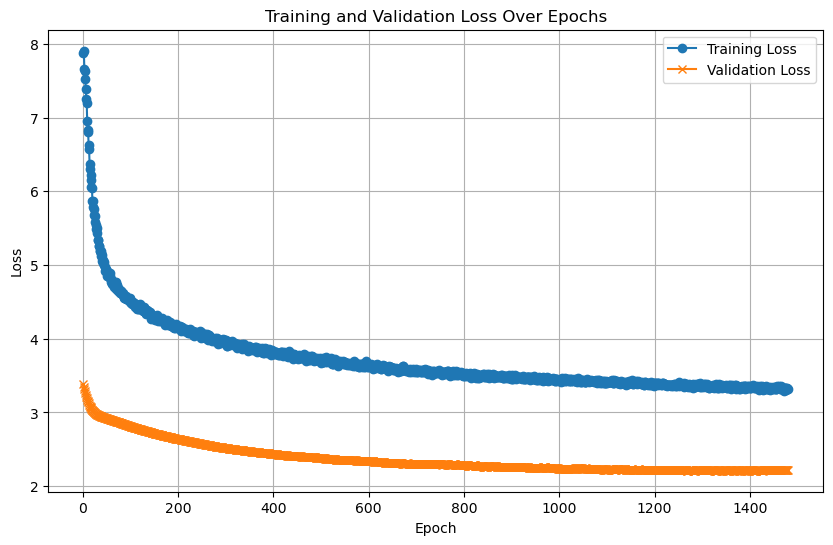

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/209], Loss: 4.7105
Test Batch [20/209], Loss: 4.7269
Test Batch [30/209], Loss: 4.5796
Test Batch [40/209], Loss: 4.6034
Test Batch [50/209], Loss: 5.0892
Test Batch [60/209], Loss: 5.0258
Test Batch [70/209], Loss: 4.7119
Test Batch [80/209], Loss: 4.9689
Test Batch [90/209], Loss: 4.9585
Test Batch [100/209], Loss: 4.9396
Test Batch [110/209], Loss: 4.6561
Test Batch [120/209], Loss: 4.1881
Test Batch [130/209], Loss: 5.0912
Test Batch [140/209], Loss: 5.1156
Test Batch [150/209], Loss: 5.1155
Test Batch [160/209], Loss: 4.9600


Test Batch [170/209], Loss: 4.9537
Test Batch [180/209], Loss: 4.8723
Test Batch [190/209], Loss: 4.7566
Test Batch [200/209], Loss: 4.7126

Test Loss: 4.8224


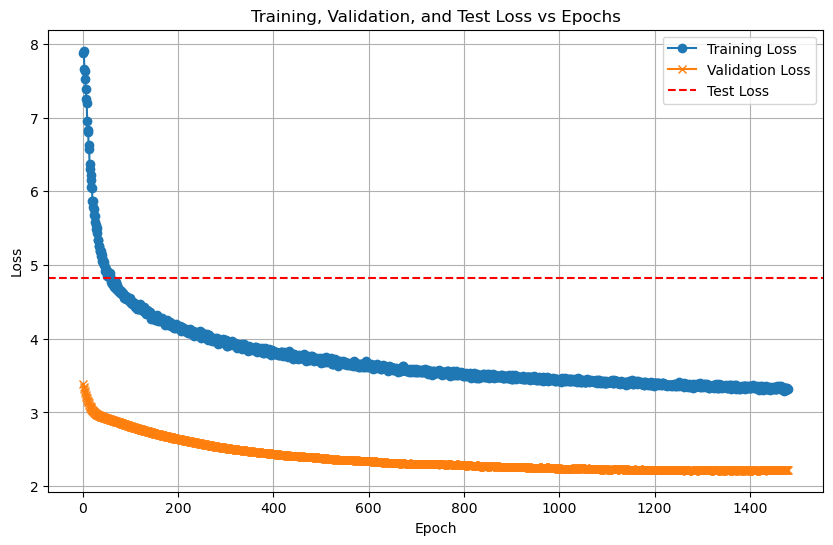

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/209 for test dataset.


  Processed batch 20/209 for test dataset.
  Processed batch 30/209 for test dataset.
  Processed batch 40/209 for test dataset.
  Processed batch 50/209 for test dataset.


  Processed batch 60/209 for test dataset.
  Processed batch 70/209 for test dataset.
  Processed batch 80/209 for test dataset.


  Processed batch 90/209 for test dataset.
  Processed batch 100/209 for test dataset.
  Processed batch 110/209 for test dataset.
  Processed batch 120/209 for test dataset.


  Processed batch 130/209 for test dataset.
  Processed batch 140/209 for test dataset.
  Processed batch 150/209 for test dataset.


  Processed batch 160/209 for test dataset.
  Processed batch 170/209 for test dataset.
  Processed batch 180/209 for test dataset.


  Processed batch 190/209 for test dataset.
  Processed batch 200/209 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 93.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       0.80      0.80      0.80         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.71      1.00      0.83         5
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7609  |  Val Loss: 2.7141
Validation loss improved from inf to 2.7141.
[Epoch 2/1000] Train Loss: 2.6949  |  Val Loss: 2.6552
Validation loss improved from 2.7141 to 2.6552.
[Epoch 3/1000] Train Loss: 2.6352  |  Val Loss: 2.6025
Validation loss improved from 2.6552 to 2.6025.
[Epoch 4/1000] Train Loss: 2.5804  |  Val Loss: 2.5509
Validation loss improved from 2.6025 to 2.5509.
[Epoch 5/1000] Train Loss: 2.5273  |  Val Loss: 2.5022
Validation loss improved from 2.5509 to 2.5022.
[Epoch 6/1000] Train Loss: 2.4740  |  Val Loss: 2.4550
Validation loss improved from 2.5022 to 2.4550.
[Epoch 7/1000] Train Loss: 2.4232  |  Val Loss: 2.4153
Validation loss improved from 2.4550 to 2.4153.
[Epoch 8/1000] Train Loss: 2.3772  |  Val Loss: 2.3796
Validation loss improved from 2.4153 to 2.3796.


[Epoch 9/1000] Train Loss: 2.3327  |  Val Loss: 2.3436
Validation loss improved from 2.3796 to 2.3436.
[Epoch 10/1000] Train Loss: 2.2872  |  Val Loss: 2.3042
Validation loss improved from 2.3436 to 2.3042.
[Epoch 11/1000] Train Loss: 2.2369  |  Val Loss: 2.2601
Validation loss improved from 2.3042 to 2.2601.


[Epoch 12/1000] Train Loss: 2.1847  |  Val Loss: 2.2167
Validation loss improved from 2.2601 to 2.2167.
[Epoch 13/1000] Train Loss: 2.1354  |  Val Loss: 2.1744
Validation loss improved from 2.2167 to 2.1744.
[Epoch 14/1000] Train Loss: 2.0871  |  Val Loss: 2.1332
Validation loss improved from 2.1744 to 2.1332.
[Epoch 15/1000] Train Loss: 2.0402  |  Val Loss: 2.0939
Validation loss improved from 2.1332 to 2.0939.
[Epoch 16/1000] Train Loss: 1.9944  |  Val Loss: 2.0540
Validation loss improved from 2.0939 to 2.0540.
[Epoch 17/1000] Train Loss: 1.9495  |  Val Loss: 2.0153
Validation loss improved from 2.0540 to 2.0153.
[Epoch 18/1000] Train Loss: 1.9041  |  Val Loss: 1.9748
Validation loss improved from 2.0153 to 1.9748.
[Epoch 19/1000] Train Loss: 1.8591  |  Val Loss: 1.9343
Validation loss improved from 1.9748 to 1.9343.


[Epoch 20/1000] Train Loss: 1.8138  |  Val Loss: 1.8973
Validation loss improved from 1.9343 to 1.8973.


[Epoch 21/1000] Train Loss: 1.7722  |  Val Loss: 1.8591
Validation loss improved from 1.8973 to 1.8591.
[Epoch 22/1000] Train Loss: 1.7302  |  Val Loss: 1.8220
Validation loss improved from 1.8591 to 1.8220.
[Epoch 23/1000] Train Loss: 1.6869  |  Val Loss: 1.7846
Validation loss improved from 1.8220 to 1.7846.
[Epoch 24/1000] Train Loss: 1.6449  |  Val Loss: 1.7481
Validation loss improved from 1.7846 to 1.7481.
[Epoch 25/1000] Train Loss: 1.6039  |  Val Loss: 1.7134
Validation loss improved from 1.7481 to 1.7134.
[Epoch 26/1000] Train Loss: 1.5653  |  Val Loss: 1.6814
Validation loss improved from 1.7134 to 1.6814.
[Epoch 27/1000] Train Loss: 1.5280  |  Val Loss: 1.6488
Validation loss improved from 1.6814 to 1.6488.
[Epoch 28/1000] Train Loss: 1.4923  |  Val Loss: 1.6188
Validation loss improved from 1.6488 to 1.6188.
[Epoch 29/1000] Train Loss: 1.4587  |  Val Loss: 1.5916
Validation loss improved from 1.6188 to 1.5916.
[Epoch 30/1000] Train Loss: 1.4264  |  Val Loss: 1.5661
Validati

[Epoch 31/1000] Train Loss: 1.3962  |  Val Loss: 1.5405
Validation loss improved from 1.5661 to 1.5405.
[Epoch 32/1000] Train Loss: 1.3674  |  Val Loss: 1.5172
Validation loss improved from 1.5405 to 1.5172.
[Epoch 33/1000] Train Loss: 1.3405  |  Val Loss: 1.4945
Validation loss improved from 1.5172 to 1.4945.
[Epoch 34/1000] Train Loss: 1.3144  |  Val Loss: 1.4727
Validation loss improved from 1.4945 to 1.4727.
[Epoch 35/1000] Train Loss: 1.2898  |  Val Loss: 1.4537
Validation loss improved from 1.4727 to 1.4537.
[Epoch 36/1000] Train Loss: 1.2661  |  Val Loss: 1.4345
Validation loss improved from 1.4537 to 1.4345.
[Epoch 37/1000] Train Loss: 1.2438  |  Val Loss: 1.4161
Validation loss improved from 1.4345 to 1.4161.
[Epoch 38/1000] Train Loss: 1.2219  |  Val Loss: 1.3982
Validation loss improved from 1.4161 to 1.3982.
[Epoch 39/1000] Train Loss: 1.2007  |  Val Loss: 1.3816
Validation loss improved from 1.3982 to 1.3816.
[Epoch 40/1000] Train Loss: 1.1803  |  Val Loss: 1.3631
Validati

[Epoch 42/1000] Train Loss: 1.1399  |  Val Loss: 1.3313
Validation loss improved from 1.3489 to 1.3313.
[Epoch 43/1000] Train Loss: 1.1206  |  Val Loss: 1.3153
Validation loss improved from 1.3313 to 1.3153.
[Epoch 44/1000] Train Loss: 1.1021  |  Val Loss: 1.3007
Validation loss improved from 1.3153 to 1.3007.
[Epoch 45/1000] Train Loss: 1.0835  |  Val Loss: 1.2858
Validation loss improved from 1.3007 to 1.2858.
[Epoch 46/1000] Train Loss: 1.0655  |  Val Loss: 1.2715
Validation loss improved from 1.2858 to 1.2715.
[Epoch 47/1000] Train Loss: 1.0473  |  Val Loss: 1.2566
Validation loss improved from 1.2715 to 1.2566.
[Epoch 48/1000] Train Loss: 1.0303  |  Val Loss: 1.2394
Validation loss improved from 1.2566 to 1.2394.
[Epoch 49/1000] Train Loss: 1.0119  |  Val Loss: 1.2264
Validation loss improved from 1.2394 to 1.2264.
[Epoch 50/1000] Train Loss: 0.9950  |  Val Loss: 1.2133
Validation loss improved from 1.2264 to 1.2133.
[Epoch 51/1000] Train Loss: 0.9773  |  Val Loss: 1.2008
Validati

[Epoch 53/1000] Train Loss: 0.9434  |  Val Loss: 1.1699
Validation loss improved from 1.1863 to 1.1699.
[Epoch 54/1000] Train Loss: 0.9261  |  Val Loss: 1.1567
Validation loss improved from 1.1699 to 1.1567.
[Epoch 55/1000] Train Loss: 0.9090  |  Val Loss: 1.1427
Validation loss improved from 1.1567 to 1.1427.
[Epoch 56/1000] Train Loss: 0.8927  |  Val Loss: 1.1277
Validation loss improved from 1.1427 to 1.1277.
[Epoch 57/1000] Train Loss: 0.8762  |  Val Loss: 1.1138
Validation loss improved from 1.1277 to 1.1138.
[Epoch 58/1000] Train Loss: 0.8594  |  Val Loss: 1.1013
Validation loss improved from 1.1138 to 1.1013.
[Epoch 59/1000] Train Loss: 0.8427  |  Val Loss: 1.0866
Validation loss improved from 1.1013 to 1.0866.
[Epoch 60/1000] Train Loss: 0.8261  |  Val Loss: 1.0730
Validation loss improved from 1.0866 to 1.0730.
[Epoch 61/1000] Train Loss: 0.8095  |  Val Loss: 1.0617
Validation loss improved from 1.0730 to 1.0617.
[Epoch 62/1000] Train Loss: 0.7933  |  Val Loss: 1.0498
Validati

[Epoch 64/1000] Train Loss: 0.7604  |  Val Loss: 1.0225
Validation loss improved from 1.0357 to 1.0225.
[Epoch 65/1000] Train Loss: 0.7454  |  Val Loss: 1.0076
Validation loss improved from 1.0225 to 1.0076.
[Epoch 66/1000] Train Loss: 0.7288  |  Val Loss: 0.9958
Validation loss improved from 1.0076 to 0.9958.
[Epoch 67/1000] Train Loss: 0.7131  |  Val Loss: 0.9869
Validation loss improved from 0.9958 to 0.9869.
[Epoch 68/1000] Train Loss: 0.6974  |  Val Loss: 0.9740
Validation loss improved from 0.9869 to 0.9740.
[Epoch 69/1000] Train Loss: 0.6826  |  Val Loss: 0.9617
Validation loss improved from 0.9740 to 0.9617.
[Epoch 70/1000] Train Loss: 0.6668  |  Val Loss: 0.9506
Validation loss improved from 0.9617 to 0.9506.
[Epoch 71/1000] Train Loss: 0.6521  |  Val Loss: 0.9400
Validation loss improved from 0.9506 to 0.9400.
[Epoch 72/1000] Train Loss: 0.6373  |  Val Loss: 0.9304
Validation loss improved from 0.9400 to 0.9304.
[Epoch 73/1000] Train Loss: 0.6229  |  Val Loss: 0.9198
Validati

[Epoch 74/1000] Train Loss: 0.6086  |  Val Loss: 0.9088
Validation loss improved from 0.9198 to 0.9088.
[Epoch 75/1000] Train Loss: 0.5935  |  Val Loss: 0.8980
Validation loss improved from 0.9088 to 0.8980.
[Epoch 76/1000] Train Loss: 0.5797  |  Val Loss: 0.8867
Validation loss improved from 0.8980 to 0.8867.
[Epoch 77/1000] Train Loss: 0.5660  |  Val Loss: 0.8803
Validation loss improved from 0.8867 to 0.8803.
[Epoch 78/1000] Train Loss: 0.5519  |  Val Loss: 0.8698
Validation loss improved from 0.8803 to 0.8698.
[Epoch 79/1000] Train Loss: 0.5386  |  Val Loss: 0.8601
Validation loss improved from 0.8698 to 0.8601.
[Epoch 80/1000] Train Loss: 0.5256  |  Val Loss: 0.8503
Validation loss improved from 0.8601 to 0.8503.
[Epoch 81/1000] Train Loss: 0.5132  |  Val Loss: 0.8427
Validation loss improved from 0.8503 to 0.8427.
[Epoch 82/1000] Train Loss: 0.5006  |  Val Loss: 0.8341
Validation loss improved from 0.8427 to 0.8341.
[Epoch 83/1000] Train Loss: 0.4881  |  Val Loss: 0.8258
Validati

[Epoch 84/1000] Train Loss: 0.4758  |  Val Loss: 0.8166
Validation loss improved from 0.8258 to 0.8166.
[Epoch 85/1000] Train Loss: 0.4640  |  Val Loss: 0.8073
Validation loss improved from 0.8166 to 0.8073.
[Epoch 86/1000] Train Loss: 0.4525  |  Val Loss: 0.7986
Validation loss improved from 0.8073 to 0.7986.
[Epoch 87/1000] Train Loss: 0.4409  |  Val Loss: 0.7924
Validation loss improved from 0.7986 to 0.7924.
[Epoch 88/1000] Train Loss: 0.4301  |  Val Loss: 0.7848
Validation loss improved from 0.7924 to 0.7848.
[Epoch 89/1000] Train Loss: 0.4195  |  Val Loss: 0.7766
Validation loss improved from 0.7848 to 0.7766.
[Epoch 90/1000] Train Loss: 0.4097  |  Val Loss: 0.7698
Validation loss improved from 0.7766 to 0.7698.
[Epoch 91/1000] Train Loss: 0.3998  |  Val Loss: 0.7635
Validation loss improved from 0.7698 to 0.7635.
[Epoch 92/1000] Train Loss: 0.3909  |  Val Loss: 0.7536
Validation loss improved from 0.7635 to 0.7536.
[Epoch 93/1000] Train Loss: 0.3809  |  Val Loss: 0.7510
Validati

[Epoch 95/1000] Train Loss: 0.3642  |  Val Loss: 0.7375
Validation loss improved from 0.7450 to 0.7375.
[Epoch 96/1000] Train Loss: 0.3561  |  Val Loss: 0.7325
Validation loss improved from 0.7375 to 0.7325.
[Epoch 97/1000] Train Loss: 0.3476  |  Val Loss: 0.7246
Validation loss improved from 0.7325 to 0.7246.
[Epoch 98/1000] Train Loss: 0.3393  |  Val Loss: 0.7202
Validation loss improved from 0.7246 to 0.7202.
[Epoch 99/1000] Train Loss: 0.3318  |  Val Loss: 0.7134
Validation loss improved from 0.7202 to 0.7134.
[Epoch 100/1000] Train Loss: 0.3247  |  Val Loss: 0.7086
Validation loss improved from 0.7134 to 0.7086.
[Epoch 101/1000] Train Loss: 0.3181  |  Val Loss: 0.7029
Validation loss improved from 0.7086 to 0.7029.
[Epoch 102/1000] Train Loss: 0.3108  |  Val Loss: 0.6977
Validation loss improved from 0.7029 to 0.6977.
[Epoch 103/1000] Train Loss: 0.3045  |  Val Loss: 0.6961
Validation loss improved from 0.6977 to 0.6961.
[Epoch 104/1000] Train Loss: 0.2990  |  Val Loss: 0.6903
Val

[Epoch 106/1000] Train Loss: 0.2867  |  Val Loss: 0.6802
Validation loss improved from 0.6847 to 0.6802.
[Epoch 107/1000] Train Loss: 0.2813  |  Val Loss: 0.6770
Validation loss improved from 0.6802 to 0.6770.
[Epoch 108/1000] Train Loss: 0.2752  |  Val Loss: 0.6729
Validation loss improved from 0.6770 to 0.6729.
[Epoch 109/1000] Train Loss: 0.2702  |  Val Loss: 0.6680
Validation loss improved from 0.6729 to 0.6680.
[Epoch 110/1000] Train Loss: 0.2648  |  Val Loss: 0.6649
Validation loss improved from 0.6680 to 0.6649.
[Epoch 111/1000] Train Loss: 0.2599  |  Val Loss: 0.6624
Validation loss improved from 0.6649 to 0.6624.
[Epoch 112/1000] Train Loss: 0.2554  |  Val Loss: 0.6599
Validation loss improved from 0.6624 to 0.6599.
[Epoch 113/1000] Train Loss: 0.2509  |  Val Loss: 0.6555
Validation loss improved from 0.6599 to 0.6555.
[Epoch 114/1000] Train Loss: 0.2480  |  Val Loss: 0.6541
Validation loss improved from 0.6555 to 0.6541.
[Epoch 115/1000] Train Loss: 0.2418  |  Val Loss: 0.648

[Epoch 116/1000] Train Loss: 0.2380  |  Val Loss: 0.6442
Validation loss improved from 0.6488 to 0.6442.
[Epoch 117/1000] Train Loss: 0.2338  |  Val Loss: 0.6434
Validation loss improved from 0.6442 to 0.6434.
[Epoch 118/1000] Train Loss: 0.2305  |  Val Loss: 0.6432
Validation loss improved from 0.6434 to 0.6432.
[Epoch 119/1000] Train Loss: 0.2262  |  Val Loss: 0.6397
Validation loss improved from 0.6432 to 0.6397.
[Epoch 120/1000] Train Loss: 0.2223  |  Val Loss: 0.6351
Validation loss improved from 0.6397 to 0.6351.
[Epoch 121/1000] Train Loss: 0.2189  |  Val Loss: 0.6334
Validation loss improved from 0.6351 to 0.6334.
[Epoch 122/1000] Train Loss: 0.2157  |  Val Loss: 0.6319
Validation loss improved from 0.6334 to 0.6319.
[Epoch 123/1000] Train Loss: 0.2123  |  Val Loss: 0.6299
Validation loss improved from 0.6319 to 0.6299.
[Epoch 124/1000] Train Loss: 0.2093  |  Val Loss: 0.6254
Validation loss improved from 0.6299 to 0.6254.
[Epoch 125/1000] Train Loss: 0.2065  |  Val Loss: 0.624

[Epoch 126/1000] Train Loss: 0.2035  |  Val Loss: 0.6236
Validation loss improved from 0.6249 to 0.6236.
[Epoch 127/1000] Train Loss: 0.1999  |  Val Loss: 0.6208
Validation loss improved from 0.6236 to 0.6208.
[Epoch 128/1000] Train Loss: 0.1974  |  Val Loss: 0.6198
Validation loss improved from 0.6208 to 0.6198.
[Epoch 129/1000] Train Loss: 0.1951  |  Val Loss: 0.6195
Validation loss improved from 0.6198 to 0.6195.
[Epoch 130/1000] Train Loss: 0.1917  |  Val Loss: 0.6199
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 131/1000] Train Loss: 0.1896  |  Val Loss: 0.6196
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 132/1000] Train Loss: 0.1875  |  Val Loss: 0.6169
Validation loss improved from 0.6195 to 0.6169.
[Epoch 133/1000] Train Loss: 0.1849  |  Val Loss: 0.6184
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 134/1000] Train Loss: 0.1831  |  Val Loss: 0.6169
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 135/1000] Train Loss: 0.

[Epoch 136/1000] Train Loss: 0.1783  |  Val Loss: 0.6209
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 137/1000] Train Loss: 0.1756  |  Val Loss: 0.6200
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 138/1000] Train Loss: 0.1739  |  Val Loss: 0.6181
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 139/1000] Train Loss: 0.1719  |  Val Loss: 0.6186
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 140/1000] Train Loss: 0.1694  |  Val Loss: 0.6222
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 141/1000] Train Loss: 0.1683  |  Val Loss: 0.6208
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 142/1000] Train Loss: 0.1661  |  Val Loss: 0.6225
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 143/1000] Train Loss: 0.1649  |  Val Loss: 0.6214
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 144/1000] Train Loss: 0.1619  |  Val Loss: 0.6245
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 146/1000] Train Loss: 0.1585  |  Val Loss: 0.6252
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 147/1000] Train Loss: 0.1576  |  Val Loss: 0.6274
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 148/1000] Train Loss: 0.1558  |  Val Loss: 0.6273
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 149/1000] Train Loss: 0.1538  |  Val Loss: 0.6288
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 150/1000] Train Loss: 0.1552  |  Val Loss: 0.6330
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 151/1000] Train Loss: 0.1510  |  Val Loss: 0.6302
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 152/1000] Train Loss: 0.1495  |  Val Loss: 0.6323
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 153/1000] Train Loss: 0.1479  |  Val Loss: 0.6337
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 154/1000] Train Loss: 0.1467  |  Val Loss: 0.6357
!! Validation loss did NOT improve !! Patience:

[Epoch 157/1000] Train Loss: 0.1427  |  Val Loss: 0.6392
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 158/1000] Train Loss: 0.1426  |  Val Loss: 0.6428
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 159/1000] Train Loss: 0.1405  |  Val Loss: 0.6417
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 160/1000] Train Loss: 0.1389  |  Val Loss: 0.6435
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 161/1000] Train Loss: 0.1377  |  Val Loss: 0.6468
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 162/1000] Train Loss: 0.1380  |  Val Loss: 0.6488
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 163/1000] Train Loss: 0.1356  |  Val Loss: 0.6480
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 164/1000] Train Loss: 0.1358  |  Val Loss: 0.6513
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 165/1000] Train Loss: 0.1341  |  Val Loss: 0.6510
!! Validation loss did NOT improve !! Patience:

[Epoch 167/1000] Train Loss: 0.1316  |  Val Loss: 0.6582
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 168/1000] Train Loss: 0.1306  |  Val Loss: 0.6580
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 169/1000] Train Loss: 0.1297  |  Val Loss: 0.6617
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 170/1000] Train Loss: 0.1282  |  Val Loss: 0.6644
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 171/1000] Train Loss: 0.1277  |  Val Loss: 0.6670
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 172/1000] Train Loss: 0.1263  |  Val Loss: 0.6689
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 173/1000] Train Loss: 0.1257  |  Val Loss: 0.6697
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 174/1000] Train Loss: 0.1247  |  Val Loss: 0.6727
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 175/1000] Train Loss: 0.1244  |  Val Loss: 0.6755
!! Validation loss did NOT improve !! Patience:

[Epoch 177/1000] Train Loss: 0.1225  |  Val Loss: 0.6776
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 178/1000] Train Loss: 0.1221  |  Val Loss: 0.6833
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 179/1000] Train Loss: 0.1217  |  Val Loss: 0.6824
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 180/1000] Train Loss: 0.1198  |  Val Loss: 0.6853
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 181/1000] Train Loss: 0.1193  |  Val Loss: 0.6872
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 182/1000] Train Loss: 0.1193  |  Val Loss: 0.6915
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 183/1000] Train Loss: 0.1173  |  Val Loss: 0.6912
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 184/1000] Train Loss: 0.1183  |  Val Loss: 0.6929
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 185/1000] Train Loss: 0.1164  |  Val Loss: 0.6978
!! Validation loss did NOT improve !! Patience:

[Epoch 187/1000] Train Loss: 0.1148  |  Val Loss: 0.7002
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 188/1000] Train Loss: 0.1151  |  Val Loss: 0.7042
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 189/1000] Train Loss: 0.1136  |  Val Loss: 0.7038
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 190/1000] Train Loss: 0.1133  |  Val Loss: 0.7063
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 191/1000] Train Loss: 0.1127  |  Val Loss: 0.7100
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 192/1000] Train Loss: 0.1118  |  Val Loss: 0.7119
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 193/1000] Train Loss: 0.1114  |  Val Loss: 0.7123
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 194/1000] Train Loss: 0.1106  |  Val Loss: 0.7158
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 195/1000] Train Loss: 0.1100  |  Val Loss: 0.7178
!! Validation loss did NOT improve !! Patience:

[Epoch 197/1000] Train Loss: 0.1109  |  Val Loss: 0.7240
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 198/1000] Train Loss: 0.1089  |  Val Loss: 0.7218
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 199/1000] Train Loss: 0.1084  |  Val Loss: 0.7245
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 200/1000] Train Loss: 0.1072  |  Val Loss: 0.7285
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 201/1000] Train Loss: 0.1078  |  Val Loss: 0.7311
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 202/1000] Train Loss: 0.1075  |  Val Loss: 0.7307
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 203/1000] Train Loss: 0.1058  |  Val Loss: 0.7334
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 204/1000] Train Loss: 0.1054  |  Val Loss: 0.7358
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 205/1000] Train Loss: 0.1051  |  Val Loss: 0.7386
!! Validation loss did NOT improve !! Patience:

[Epoch 207/1000] Train Loss: 0.1044  |  Val Loss: 0.7428
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 208/1000] Train Loss: 0.1042  |  Val Loss: 0.7429
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 209/1000] Train Loss: 0.1044  |  Val Loss: 0.7480
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 210/1000] Train Loss: 0.1031  |  Val Loss: 0.7477
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 211/1000] Train Loss: 0.1025  |  Val Loss: 0.7499
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 212/1000] Train Loss: 0.1027  |  Val Loss: 0.7543
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 213/1000] Train Loss: 0.1017  |  Val Loss: 0.7554
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 214/1000] Train Loss: 0.1012  |  Val Loss: 0.7566
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 215/1000] Train Loss: 0.1014  |  Val Loss: 0.7615
!! Validation loss did NOT improve !! Patience:

[Epoch 217/1000] Train Loss: 0.1001  |  Val Loss: 0.7634
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 218/1000] Train Loss: 0.0995  |  Val Loss: 0.7650
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 219/1000] Train Loss: 0.0992  |  Val Loss: 0.7675
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 220/1000] Train Loss: 0.0987  |  Val Loss: 0.7708
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 221/1000] Train Loss: 0.0992  |  Val Loss: 0.7731
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 222/1000] Train Loss: 0.0980  |  Val Loss: 0.7737
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 223/1000] Train Loss: 0.0978  |  Val Loss: 0.7770
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 224/1000] Train Loss: 0.0975  |  Val Loss: 0.7785
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 225/1000] Train Loss: 0.0981  |  Val Loss: 0.7804
!! Validation loss did NOT improve !! Patience:

[Epoch 228/1000] Train Loss: 0.0974  |  Val Loss: 0.7878
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 229/1000] Train Loss: 0.0958  |  Val Loss: 0.7899
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 230/1000] Train Loss: 0.0955  |  Val Loss: 0.7922
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 231/1000] Train Loss: 0.0962  |  Val Loss: 0.7965
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 232/1000] Train Loss: 0.0953  |  Val Loss: 0.7943
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 232 !!
No improvement for 100 epochs.


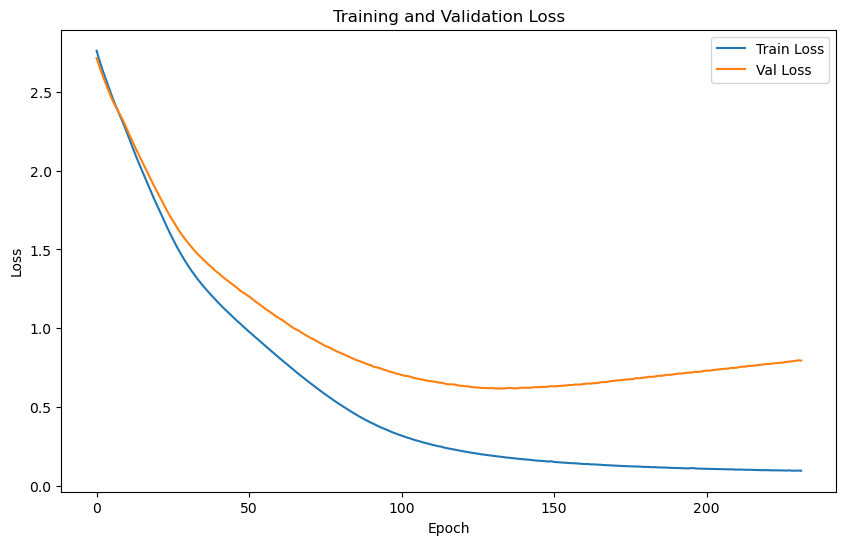

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.6610 | Test Accuracy: 80.65%


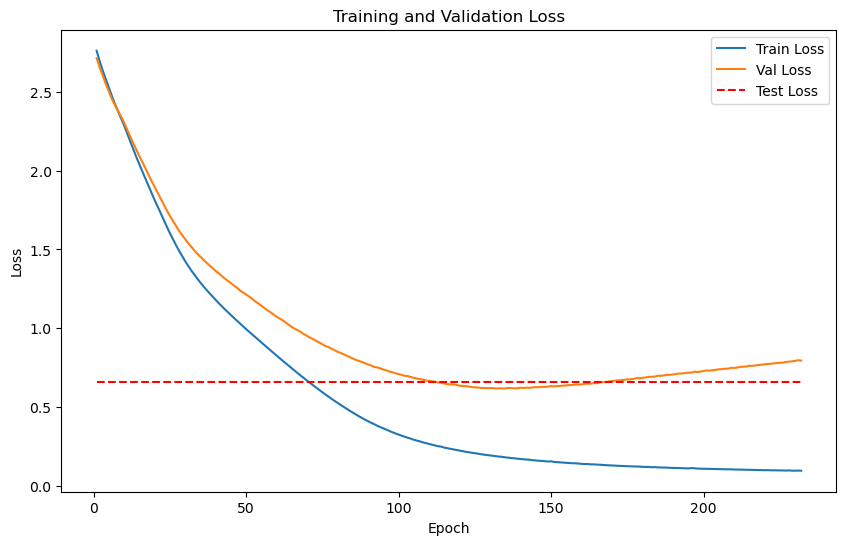

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)


Train embeddings shape: (640, 64), 
Train labels shape: (640,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53409, 64), 
Test labels shape: (53409,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4673
    Batch [2/2], Train Loss: 0.4682
LOG: Epoch [1/2000] - Validation


    Batch [1/2], Val Loss: 0.3432
    Batch [2/2], Val Loss: 0.3832
Epoch [1/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.3632

Validation loss improved from inf to 0.3632. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 0.4670


    Batch [2/2], Train Loss: 0.4654
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3450
    Batch [2/2], Val Loss: 0.3834
Epoch [2/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.4617


    Batch [2/2], Train Loss: 0.4617
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3463
    Batch [2/2], Val Loss: 0.3817
Epoch [3/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.3640

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.4569


    Batch [2/2], Train Loss: 0.4588
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3477
    Batch [2/2], Val Loss: 0.3779
Epoch [4/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.3628

Validation loss improved from 0.3632 to 0.3628. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4572


    Batch [2/2], Train Loss: 0.4538
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.3739
Epoch [5/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.3604

Validation loss improved from 0.3628 to 0.3604. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/2], Train Loss: 0.4595


    Batch [2/2], Train Loss: 0.4514
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3453
    Batch [2/2], Val Loss: 0.3689
Epoch [6/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.3571

Validation loss improved from 0.3604 to 0.3571. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/2], Train Loss: 0.4523


    Batch [2/2], Train Loss: 0.4530
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3432
    Batch [2/2], Val Loss: 0.3638
Epoch [7/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.3535

Validation loss improved from 0.3571 to 0.3535. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/2], Train Loss: 0.4510


    Batch [2/2], Train Loss: 0.4484
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3409
    Batch [2/2], Val Loss: 0.3589
Epoch [8/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3499

Validation loss improved from 0.3535 to 0.3499. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4508


    Batch [2/2], Train Loss: 0.4532
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.3543
Epoch [9/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.3466

Validation loss improved from 0.3499 to 0.3466. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4507


    Batch [2/2], Train Loss: 0.4494
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3372
    Batch [2/2], Val Loss: 0.3500
Epoch [10/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.3436

Validation loss improved from 0.3466 to 0.3436. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/2], Train Loss: 0.4465


    Batch [2/2], Train Loss: 0.4490
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3350
    Batch [2/2], Val Loss: 0.3467
Epoch [11/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.3409

Validation loss improved from 0.3436 to 0.3409. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.4458


    Batch [2/2], Train Loss: 0.4418
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3330
    Batch [2/2], Val Loss: 0.3442
Epoch [12/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.3386

Validation loss improved from 0.3409 to 0.3386. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.4430


    Batch [2/2], Train Loss: 0.4431
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3314
    Batch [2/2], Val Loss: 0.3419
Epoch [13/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3367

Validation loss improved from 0.3386 to 0.3367. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.4412


    Batch [2/2], Train Loss: 0.4446
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3300
    Batch [2/2], Val Loss: 0.3396
Epoch [14/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3348

Validation loss improved from 0.3367 to 0.3348. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/2], Train Loss: 0.4407


    Batch [2/2], Train Loss: 0.4408
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3286
    Batch [2/2], Val Loss: 0.3375
Epoch [15/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3330

Validation loss improved from 0.3348 to 0.3330. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 0.4413


    Batch [2/2], Train Loss: 0.4395
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3270
    Batch [2/2], Val Loss: 0.3352
Epoch [16/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3311

Validation loss improved from 0.3330 to 0.3311. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.4357


    Batch [2/2], Train Loss: 0.4410
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3256
    Batch [2/2], Val Loss: 0.3333
Epoch [17/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.3294

Validation loss improved from 0.3311 to 0.3294. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/2], Train Loss: 0.4323
    Batch [2/2], Train Loss: 0.4338
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.3241
    Batch [2/2], Val Loss: 0.3319
Epoch [18/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.3280

Validation loss improved from 0.3294 to 0.3280. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/2], Train Loss: 0.4361


    Batch [2/2], Train Loss: 0.4374
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3226
    Batch [2/2], Val Loss: 0.3303
Epoch [19/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.3264

Validation loss improved from 0.3280 to 0.3264. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4378


    Batch [2/2], Train Loss: 0.4354
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3212
    Batch [2/2], Val Loss: 0.3289
Epoch [20/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.3251

Validation loss improved from 0.3264 to 0.3251. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.4318


    Batch [2/2], Train Loss: 0.4375
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3197
    Batch [2/2], Val Loss: 0.3271
Epoch [21/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.3234

Validation loss improved from 0.3251 to 0.3234. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/2], Train Loss: 0.4329


    Batch [2/2], Train Loss: 0.4286
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3183
    Batch [2/2], Val Loss: 0.3256
Epoch [22/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.3219

Validation loss improved from 0.3234 to 0.3219. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.4304


    Batch [2/2], Train Loss: 0.4349
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3168
    Batch [2/2], Val Loss: 0.3240
Epoch [23/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.3204

Validation loss improved from 0.3219 to 0.3204. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/2], Train Loss: 0.4271


    Batch [2/2], Train Loss: 0.4327
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3154
    Batch [2/2], Val Loss: 0.3227
Epoch [24/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.3191

Validation loss improved from 0.3204 to 0.3191. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.4293


    Batch [2/2], Train Loss: 0.4228
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.3215
Epoch [25/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.3178

Validation loss improved from 0.3191 to 0.3178. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.4264


    Batch [2/2], Train Loss: 0.4235
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3127
    Batch [2/2], Val Loss: 0.3202
Epoch [26/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.3165

Validation loss improved from 0.3178 to 0.3165. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/2], Train Loss: 0.4294


    Batch [2/2], Train Loss: 0.4231
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3115
    Batch [2/2], Val Loss: 0.3191
Epoch [27/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.3153

Validation loss improved from 0.3165 to 0.3153. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.4269


    Batch [2/2], Train Loss: 0.4257
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3101
    Batch [2/2], Val Loss: 0.3178
Epoch [28/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.3140

Validation loss improved from 0.3153 to 0.3140. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/2], Train Loss: 0.4265


    Batch [2/2], Train Loss: 0.4242
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3090
    Batch [2/2], Val Loss: 0.3166
Epoch [29/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.3128

Validation loss improved from 0.3140 to 0.3128. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/2], Train Loss: 0.4176


    Batch [2/2], Train Loss: 0.4220
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3079
    Batch [2/2], Val Loss: 0.3157
Epoch [30/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.3118

Validation loss improved from 0.3128 to 0.3118. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/2], Train Loss: 0.4217


    Batch [2/2], Train Loss: 0.4240
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3067
    Batch [2/2], Val Loss: 0.3146
Epoch [31/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3106

Validation loss improved from 0.3118 to 0.3106. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 0.4200


    Batch [2/2], Train Loss: 0.4219
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3055
    Batch [2/2], Val Loss: 0.3136
Epoch [32/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.3096

Validation loss improved from 0.3106 to 0.3096. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.4141


    Batch [2/2], Train Loss: 0.4158
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3044
    Batch [2/2], Val Loss: 0.3128
Epoch [33/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3086

Validation loss improved from 0.3096 to 0.3086. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.4146


    Batch [2/2], Train Loss: 0.4163
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3034
    Batch [2/2], Val Loss: 0.3120
Epoch [34/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.3077

Validation loss improved from 0.3086 to 0.3077. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.4158


    Batch [2/2], Train Loss: 0.4131
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3024
    Batch [2/2], Val Loss: 0.3111
Epoch [35/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.3067

Validation loss improved from 0.3077 to 0.3067. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/2], Train Loss: 0.4134


    Batch [2/2], Train Loss: 0.4078
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.3013
    Batch [2/2], Val Loss: 0.3103
Epoch [36/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.3058

Validation loss improved from 0.3067 to 0.3058. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.4114


    Batch [2/2], Train Loss: 0.4035
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.3003
    Batch [2/2], Val Loss: 0.3096
Epoch [37/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.3050

Validation loss improved from 0.3058 to 0.3050. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/2], Train Loss: 0.4166


    Batch [2/2], Train Loss: 0.4085
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.2991
    Batch [2/2], Val Loss: 0.3089
Epoch [38/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3040

Validation loss improved from 0.3050 to 0.3040. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4031


    Batch [2/2], Train Loss: 0.4117
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.2980
    Batch [2/2], Val Loss: 0.3083
Epoch [39/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.3032

Validation loss improved from 0.3040 to 0.3032. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.4136


    Batch [2/2], Train Loss: 0.4032
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.2966
    Batch [2/2], Val Loss: 0.3076
Epoch [40/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.3021

Validation loss improved from 0.3032 to 0.3021. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.4093


    Batch [2/2], Train Loss: 0.4070
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.2952
    Batch [2/2], Val Loss: 0.3070
Epoch [41/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.3011

Validation loss improved from 0.3021 to 0.3011. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.4072


    Batch [2/2], Train Loss: 0.4034
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.3063
Epoch [42/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.3000

Validation loss improved from 0.3011 to 0.3000. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.4027


    Batch [2/2], Train Loss: 0.4048
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.2925
    Batch [2/2], Val Loss: 0.3056
Epoch [43/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2990

Validation loss improved from 0.3000 to 0.2990. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.4067


    Batch [2/2], Train Loss: 0.4061
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.2911
    Batch [2/2], Val Loss: 0.3048
Epoch [44/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2979

Validation loss improved from 0.2990 to 0.2979. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/2], Train Loss: 0.4111


    Batch [2/2], Train Loss: 0.4008
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.2897
    Batch [2/2], Val Loss: 0.3042
Epoch [45/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2970

Validation loss improved from 0.2979 to 0.2970. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.3979


    Batch [2/2], Train Loss: 0.4007
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.2885
    Batch [2/2], Val Loss: 0.3040
Epoch [46/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2963

Validation loss improved from 0.2970 to 0.2963. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/2], Train Loss: 0.4001


    Batch [2/2], Train Loss: 0.3948
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.2873
    Batch [2/2], Val Loss: 0.3036
Epoch [47/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2955

Validation loss improved from 0.2963 to 0.2955. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.4000


    Batch [2/2], Train Loss: 0.4012
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.2863
    Batch [2/2], Val Loss: 0.3032
Epoch [48/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2948

Validation loss improved from 0.2955 to 0.2948. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/2], Train Loss: 0.3962


    Batch [2/2], Train Loss: 0.3961
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.2854
    Batch [2/2], Val Loss: 0.3029
Epoch [49/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.2941

Validation loss improved from 0.2948 to 0.2941. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.4034


    Batch [2/2], Train Loss: 0.4010
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.2845
    Batch [2/2], Val Loss: 0.3024
Epoch [50/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2934

Validation loss improved from 0.2941 to 0.2934. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.3957


    Batch [2/2], Train Loss: 0.3972
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.2837
    Batch [2/2], Val Loss: 0.3023
Epoch [51/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2930

Validation loss improved from 0.2934 to 0.2930. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/2], Train Loss: 0.3954


    Batch [2/2], Train Loss: 0.3914
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.2830
    Batch [2/2], Val Loss: 0.3019
Epoch [52/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2925

Validation loss improved from 0.2930 to 0.2925. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/2], Train Loss: 0.3925


    Batch [2/2], Train Loss: 0.3927
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.2822
    Batch [2/2], Val Loss: 0.3016
Epoch [53/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2919

Validation loss improved from 0.2925 to 0.2919. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.3978


    Batch [2/2], Train Loss: 0.3892
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.2810
    Batch [2/2], Val Loss: 0.3009
Epoch [54/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2910

Validation loss improved from 0.2919 to 0.2910. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/2], Train Loss: 0.3940


    Batch [2/2], Train Loss: 0.3906
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.2798
    Batch [2/2], Val Loss: 0.3006
Epoch [55/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2902

Validation loss improved from 0.2910 to 0.2902. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/2], Train Loss: 0.3896


    Batch [2/2], Train Loss: 0.3901
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.2788
    Batch [2/2], Val Loss: 0.2999
Epoch [56/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2894

Validation loss improved from 0.2902 to 0.2894. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/2], Train Loss: 0.3852


    Batch [2/2], Train Loss: 0.3852
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.2781
    Batch [2/2], Val Loss: 0.2999
Epoch [57/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2890

Validation loss improved from 0.2894 to 0.2890. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.3883


    Batch [2/2], Train Loss: 0.3885
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.2771
    Batch [2/2], Val Loss: 0.2994
Epoch [58/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2883

Validation loss improved from 0.2890 to 0.2883. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/2], Train Loss: 0.3845


    Batch [2/2], Train Loss: 0.3911
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.2762
    Batch [2/2], Val Loss: 0.2988
Epoch [59/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2875

Validation loss improved from 0.2883 to 0.2875. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.3892


    Batch [2/2], Train Loss: 0.3820
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.2753
    Batch [2/2], Val Loss: 0.2982
Epoch [60/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2867

Validation loss improved from 0.2875 to 0.2867. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.3848


    Batch [2/2], Train Loss: 0.3778
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.2746
    Batch [2/2], Val Loss: 0.2976
Epoch [61/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2861

Validation loss improved from 0.2867 to 0.2861. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.3845


    Batch [2/2], Train Loss: 0.3821
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2976
Epoch [62/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2857

Validation loss improved from 0.2861 to 0.2857. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/2], Train Loss: 0.3820


    Batch [2/2], Train Loss: 0.3822
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2974
Epoch [63/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2853

Validation loss improved from 0.2857 to 0.2853. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.3795


    Batch [2/2], Train Loss: 0.3766
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.2724
    Batch [2/2], Val Loss: 0.2968
Epoch [64/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.2846

Validation loss improved from 0.2853 to 0.2846. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/2], Train Loss: 0.3816


    Batch [2/2], Train Loss: 0.3798
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.2715
    Batch [2/2], Val Loss: 0.2966
Epoch [65/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2840

Validation loss improved from 0.2846 to 0.2840. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/2], Train Loss: 0.3810


    Batch [2/2], Train Loss: 0.3723
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.2709
    Batch [2/2], Val Loss: 0.2964
Epoch [66/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2837

Validation loss improved from 0.2840 to 0.2837. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.3755


    Batch [2/2], Train Loss: 0.3809
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.2702
    Batch [2/2], Val Loss: 0.2960
Epoch [67/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.2831

Validation loss improved from 0.2837 to 0.2831. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.3718


    Batch [2/2], Train Loss: 0.3675
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.2694
    Batch [2/2], Val Loss: 0.2955
Epoch [68/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2824

Validation loss improved from 0.2831 to 0.2824. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/2], Train Loss: 0.3800


    Batch [2/2], Train Loss: 0.3762
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.2682
    Batch [2/2], Val Loss: 0.2949
Epoch [69/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2816

Validation loss improved from 0.2824 to 0.2816. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.3768


    Batch [2/2], Train Loss: 0.3731
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.2674
    Batch [2/2], Val Loss: 0.2941
Epoch [70/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2808

Validation loss improved from 0.2816 to 0.2808. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.3707


    Batch [2/2], Train Loss: 0.3788
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.2665
    Batch [2/2], Val Loss: 0.2936
Epoch [71/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2801

Validation loss improved from 0.2808 to 0.2801. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.3745


    Batch [2/2], Train Loss: 0.3719
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.2657
    Batch [2/2], Val Loss: 0.2933
Epoch [72/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2795

Validation loss improved from 0.2801 to 0.2795. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/2], Train Loss: 0.3707
    Batch [2/2], Train Loss: 0.3690
LOG: Epoch [73/2000] - Validation


    Batch [1/2], Val Loss: 0.2647
    Batch [2/2], Val Loss: 0.2928
Epoch [73/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2788

Validation loss improved from 0.2795 to 0.2788. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.3677


    Batch [2/2], Train Loss: 0.3653
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.2638
    Batch [2/2], Val Loss: 0.2921
Epoch [74/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2780

Validation loss improved from 0.2788 to 0.2780. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/2], Train Loss: 0.3674


    Batch [2/2], Train Loss: 0.3752
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.2628
    Batch [2/2], Val Loss: 0.2913
Epoch [75/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2771

Validation loss improved from 0.2780 to 0.2771. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.3717


    Batch [2/2], Train Loss: 0.3641
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.2620
    Batch [2/2], Val Loss: 0.2904
Epoch [76/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2762

Validation loss improved from 0.2771 to 0.2762. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/2], Train Loss: 0.3708


    Batch [2/2], Train Loss: 0.3668
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.2612
    Batch [2/2], Val Loss: 0.2897
Epoch [77/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2755

Validation loss improved from 0.2762 to 0.2755. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.3699


    Batch [2/2], Train Loss: 0.3657
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.2608
    Batch [2/2], Val Loss: 0.2895
Epoch [78/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2752

Validation loss improved from 0.2755 to 0.2752. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 0.3601


    Batch [2/2], Train Loss: 0.3681
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.2602
    Batch [2/2], Val Loss: 0.2893
Epoch [79/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2747

Validation loss improved from 0.2752 to 0.2747. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3630


    Batch [2/2], Train Loss: 0.3673
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.2595
    Batch [2/2], Val Loss: 0.2891
Epoch [80/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2743

Validation loss improved from 0.2747 to 0.2743. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/2], Train Loss: 0.3602


    Batch [2/2], Train Loss: 0.3669
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.2588
    Batch [2/2], Val Loss: 0.2888
Epoch [81/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2738

Validation loss improved from 0.2743 to 0.2738. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.3614


    Batch [2/2], Train Loss: 0.3608
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2583
    Batch [2/2], Val Loss: 0.2886
Epoch [82/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2735

Validation loss improved from 0.2738 to 0.2735. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.3587


    Batch [2/2], Train Loss: 0.3588
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2576
    Batch [2/2], Val Loss: 0.2879
Epoch [83/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.2728

Validation loss improved from 0.2735 to 0.2728. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3554


    Batch [2/2], Train Loss: 0.3634
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2570
    Batch [2/2], Val Loss: 0.2873
Epoch [84/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.2722

Validation loss improved from 0.2728 to 0.2722. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/2], Train Loss: 0.3529


    Batch [2/2], Train Loss: 0.3609
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2564
    Batch [2/2], Val Loss: 0.2870
Epoch [85/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.2717

Validation loss improved from 0.2722 to 0.2717. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.3621


    Batch [2/2], Train Loss: 0.3583
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2557
    Batch [2/2], Val Loss: 0.2864
Epoch [86/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2710

Validation loss improved from 0.2717 to 0.2710. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.3606


    Batch [2/2], Train Loss: 0.3679
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2549
    Batch [2/2], Val Loss: 0.2856
Epoch [87/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2702

Validation loss improved from 0.2710 to 0.2702. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.3633
    Batch [2/2], Train Loss: 0.3602
LOG: Epoch [88/2000] - Validation


    Batch [1/2], Val Loss: 0.2542
    Batch [2/2], Val Loss: 0.2855
Epoch [88/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2698

Validation loss improved from 0.2702 to 0.2698. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.3555


    Batch [2/2], Train Loss: 0.3603
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2532
    Batch [2/2], Val Loss: 0.2848
Epoch [89/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.2690

Validation loss improved from 0.2698 to 0.2690. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/2], Train Loss: 0.3582


    Batch [2/2], Train Loss: 0.3535
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2520
    Batch [2/2], Val Loss: 0.2839
Epoch [90/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.2680

Validation loss improved from 0.2690 to 0.2680. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/2], Train Loss: 0.3545


    Batch [2/2], Train Loss: 0.3498
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.2836
Epoch [91/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2674

Validation loss improved from 0.2680 to 0.2674. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/2], Train Loss: 0.3528


    Batch [2/2], Train Loss: 0.3569
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2502
    Batch [2/2], Val Loss: 0.2830
Epoch [92/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.2666

Validation loss improved from 0.2674 to 0.2666. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/2], Train Loss: 0.3538


    Batch [2/2], Train Loss: 0.3530
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2493
    Batch [2/2], Val Loss: 0.2822
Epoch [93/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2657

Validation loss improved from 0.2666 to 0.2657. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.3535


    Batch [2/2], Train Loss: 0.3533
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.2817
Epoch [94/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2650

Validation loss improved from 0.2657 to 0.2650. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3503


    Batch [2/2], Train Loss: 0.3558
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2811
Epoch [95/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2643

Validation loss improved from 0.2650 to 0.2643. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/2], Train Loss: 0.3570


    Batch [2/2], Train Loss: 0.3490
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2466
    Batch [2/2], Val Loss: 0.2807
Epoch [96/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2636

Validation loss improved from 0.2643 to 0.2636. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/2], Train Loss: 0.3493
    Batch [2/2], Train Loss: 0.3500
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.2461
    Batch [2/2], Val Loss: 0.2804
Epoch [97/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2633

Validation loss improved from 0.2636 to 0.2633. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/2], Train Loss: 0.3486


    Batch [2/2], Train Loss: 0.3476
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2454
    Batch [2/2], Val Loss: 0.2797
Epoch [98/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2626

Validation loss improved from 0.2633 to 0.2626. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3486


    Batch [2/2], Train Loss: 0.3461
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2451
    Batch [2/2], Val Loss: 0.2796
Epoch [99/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2623

Validation loss improved from 0.2626 to 0.2623. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/2], Train Loss: 0.3547


    Batch [2/2], Train Loss: 0.3490
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2448
    Batch [2/2], Val Loss: 0.2792
Epoch [100/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2620

Validation loss improved from 0.2623 to 0.2620. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/2], Train Loss: 0.3437


    Batch [2/2], Train Loss: 0.3510
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2444
    Batch [2/2], Val Loss: 0.2789
Epoch [101/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2617

Validation loss improved from 0.2620 to 0.2617. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.3554


    Batch [2/2], Train Loss: 0.3469
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2439
    Batch [2/2], Val Loss: 0.2783
Epoch [102/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2611

Validation loss improved from 0.2617 to 0.2611. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.3428


    Batch [2/2], Train Loss: 0.3538
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2433
    Batch [2/2], Val Loss: 0.2776
Epoch [103/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2605

Validation loss improved from 0.2611 to 0.2605. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.3457
    Batch [2/2], Train Loss: 0.3446
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.2427
    Batch [2/2], Val Loss: 0.2769
Epoch [104/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2598

Validation loss improved from 0.2605 to 0.2598. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.3474


    Batch [2/2], Train Loss: 0.3404
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2423
    Batch [2/2], Val Loss: 0.2763
Epoch [105/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2593

Validation loss improved from 0.2598 to 0.2593. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.3406
    Batch [2/2], Train Loss: 0.3430
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.2419
    Batch [2/2], Val Loss: 0.2758
Epoch [106/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2588

Validation loss improved from 0.2593 to 0.2588. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.3392
    Batch [2/2], Train Loss: 0.3419
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.2414
    Batch [2/2], Val Loss: 0.2755
Epoch [107/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2585

Validation loss improved from 0.2588 to 0.2585. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.3331


    Batch [2/2], Train Loss: 0.3410
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2410
    Batch [2/2], Val Loss: 0.2753
Epoch [108/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.2581

Validation loss improved from 0.2585 to 0.2581. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.3362


    Batch [2/2], Train Loss: 0.3453
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2405
    Batch [2/2], Val Loss: 0.2749
Epoch [109/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2577

Validation loss improved from 0.2581 to 0.2577. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.3480


    Batch [2/2], Train Loss: 0.3311
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2398
    Batch [2/2], Val Loss: 0.2746
Epoch [110/2000], Avg Train Loss: 0.3396, Avg Val Loss: 0.2572

Validation loss improved from 0.2577 to 0.2572. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.3352


    Batch [2/2], Train Loss: 0.3364
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2391
    Batch [2/2], Val Loss: 0.2744
Epoch [111/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.2568

Validation loss improved from 0.2572 to 0.2568. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/2], Train Loss: 0.3398


    Batch [2/2], Train Loss: 0.3426
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2386
    Batch [2/2], Val Loss: 0.2741
Epoch [112/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2563

Validation loss improved from 0.2568 to 0.2563. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.3282


    Batch [2/2], Train Loss: 0.3420
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2380
    Batch [2/2], Val Loss: 0.2739
Epoch [113/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.2560

Validation loss improved from 0.2563 to 0.2560. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/2], Train Loss: 0.3383


    Batch [2/2], Train Loss: 0.3364
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2375
    Batch [2/2], Val Loss: 0.2734
Epoch [114/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2555

Validation loss improved from 0.2560 to 0.2555. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.3350


    Batch [2/2], Train Loss: 0.3381
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2370
    Batch [2/2], Val Loss: 0.2735
Epoch [115/2000], Avg Train Loss: 0.3365, Avg Val Loss: 0.2553

Validation loss improved from 0.2555 to 0.2553. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.3282


    Batch [2/2], Train Loss: 0.3377
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2364
    Batch [2/2], Val Loss: 0.2735
Epoch [116/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.2550

Validation loss improved from 0.2553 to 0.2550. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.3323


    Batch [2/2], Train Loss: 0.3349
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2361
    Batch [2/2], Val Loss: 0.2737
Epoch [117/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.2549

Validation loss improved from 0.2550 to 0.2549. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/2], Train Loss: 0.3430


    Batch [2/2], Train Loss: 0.3311
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2355
    Batch [2/2], Val Loss: 0.2732
Epoch [118/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.2544

Validation loss improved from 0.2549 to 0.2544. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.3294
    Batch [2/2], Train Loss: 0.3296
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.2351
    Batch [2/2], Val Loss: 0.2730
Epoch [119/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.2541

Validation loss improved from 0.2544 to 0.2541. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.3299


    Batch [2/2], Train Loss: 0.3342
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2347
    Batch [2/2], Val Loss: 0.2725
Epoch [120/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.2536

Validation loss improved from 0.2541 to 0.2536. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/2], Train Loss: 0.3319


    Batch [2/2], Train Loss: 0.3282
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2342
    Batch [2/2], Val Loss: 0.2726
Epoch [121/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.2534

Validation loss improved from 0.2536 to 0.2534. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.3215


    Batch [2/2], Train Loss: 0.3343
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2338
    Batch [2/2], Val Loss: 0.2719
Epoch [122/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.2528

Validation loss improved from 0.2534 to 0.2528. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.3329


    Batch [2/2], Train Loss: 0.3233
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2333
    Batch [2/2], Val Loss: 0.2714
Epoch [123/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.2523

Validation loss improved from 0.2528 to 0.2523. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/2], Train Loss: 0.3268
    Batch [2/2], Train Loss: 0.3309
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.2328
    Batch [2/2], Val Loss: 0.2708
Epoch [124/2000], Avg Train Loss: 0.3289, Avg Val Loss: 0.2518

Validation loss improved from 0.2523 to 0.2518. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/2], Train Loss: 0.3273


    Batch [2/2], Train Loss: 0.3223
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2322
    Batch [2/2], Val Loss: 0.2706
Epoch [125/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.2514

Validation loss improved from 0.2518 to 0.2514. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.3277


    Batch [2/2], Train Loss: 0.3260
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2316
    Batch [2/2], Val Loss: 0.2702
Epoch [126/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.2509

Validation loss improved from 0.2514 to 0.2509. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/2], Train Loss: 0.3236


    Batch [2/2], Train Loss: 0.3250
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2309
    Batch [2/2], Val Loss: 0.2697
Epoch [127/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.2503

Validation loss improved from 0.2509 to 0.2503. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.3192


    Batch [2/2], Train Loss: 0.3253
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2304
    Batch [2/2], Val Loss: 0.2699
Epoch [128/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2501

Validation loss improved from 0.2503 to 0.2501. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.3283


    Batch [2/2], Train Loss: 0.3180
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2299
    Batch [2/2], Val Loss: 0.2696
Epoch [129/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.2498

Validation loss improved from 0.2501 to 0.2498. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.3254


    Batch [2/2], Train Loss: 0.3269
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2294
    Batch [2/2], Val Loss: 0.2697
Epoch [130/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2496

Validation loss improved from 0.2498 to 0.2496. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/2], Train Loss: 0.3245


    Batch [2/2], Train Loss: 0.3114
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2288
    Batch [2/2], Val Loss: 0.2695
Epoch [131/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.2492

Validation loss improved from 0.2496 to 0.2492. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.3176


    Batch [2/2], Train Loss: 0.3191
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2284
    Batch [2/2], Val Loss: 0.2694
Epoch [132/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.2489

Validation loss improved from 0.2492 to 0.2489. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.3270


    Batch [2/2], Train Loss: 0.3224
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2280
    Batch [2/2], Val Loss: 0.2685
Epoch [133/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.2483

Validation loss improved from 0.2489 to 0.2483. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.3189


    Batch [2/2], Train Loss: 0.3211
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.2679
Epoch [134/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.2477

Validation loss improved from 0.2483 to 0.2477. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.3237


    Batch [2/2], Train Loss: 0.3131
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.2675
Epoch [135/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.2473

Validation loss improved from 0.2477 to 0.2473. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.3212
    Batch [2/2], Train Loss: 0.3231
LOG: Epoch [136/2000] - Validation


    Batch [1/2], Val Loss: 0.2267
    Batch [2/2], Val Loss: 0.2672
Epoch [136/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.2469

Validation loss improved from 0.2473 to 0.2469. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.3154


    Batch [2/2], Train Loss: 0.3178
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2265
    Batch [2/2], Val Loss: 0.2669
Epoch [137/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2467

Validation loss improved from 0.2469 to 0.2467. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.3228
    Batch [2/2], Train Loss: 0.3175
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.2261
    Batch [2/2], Val Loss: 0.2665
Epoch [138/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.2463

Validation loss improved from 0.2467 to 0.2463. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.3188


    Batch [2/2], Train Loss: 0.3171
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2257
    Batch [2/2], Val Loss: 0.2665
Epoch [139/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.2461

Validation loss improved from 0.2463 to 0.2461. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/2], Train Loss: 0.3157


    Batch [2/2], Train Loss: 0.3120
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2252
    Batch [2/2], Val Loss: 0.2661
Epoch [140/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.2457

Validation loss improved from 0.2461 to 0.2457. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.3174


    Batch [2/2], Train Loss: 0.3161
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2247
    Batch [2/2], Val Loss: 0.2661
Epoch [141/2000], Avg Train Loss: 0.3168, Avg Val Loss: 0.2454

Validation loss improved from 0.2457 to 0.2454. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.3160


    Batch [2/2], Train Loss: 0.3207
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2241
    Batch [2/2], Val Loss: 0.2655
Epoch [142/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.2448

Validation loss improved from 0.2454 to 0.2448. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/2], Train Loss: 0.3193


    Batch [2/2], Train Loss: 0.3108
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2238
    Batch [2/2], Val Loss: 0.2654
Epoch [143/2000], Avg Train Loss: 0.3151, Avg Val Loss: 0.2446

Validation loss improved from 0.2448 to 0.2446. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.3138


    Batch [2/2], Train Loss: 0.3153
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2234
    Batch [2/2], Val Loss: 0.2648
Epoch [144/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.2441

Validation loss improved from 0.2446 to 0.2441. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.3111


    Batch [2/2], Train Loss: 0.3125
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2230
    Batch [2/2], Val Loss: 0.2645
Epoch [145/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.2437

Validation loss improved from 0.2441 to 0.2437. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/2], Train Loss: 0.3138


    Batch [2/2], Train Loss: 0.3099
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2224
    Batch [2/2], Val Loss: 0.2637
Epoch [146/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.2431

Validation loss improved from 0.2437 to 0.2431. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/2], Train Loss: 0.3037


    Batch [2/2], Train Loss: 0.3094
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2219
    Batch [2/2], Val Loss: 0.2633
Epoch [147/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.2426

Validation loss improved from 0.2431 to 0.2426. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.3092


    Batch [2/2], Train Loss: 0.3019
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2214
    Batch [2/2], Val Loss: 0.2636
Epoch [148/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.2425

Validation loss improved from 0.2426 to 0.2425. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.3097


    Batch [2/2], Train Loss: 0.3059
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2208
    Batch [2/2], Val Loss: 0.2640
Epoch [149/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.2424

Validation loss improved from 0.2425 to 0.2424. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/2], Train Loss: 0.3134


    Batch [2/2], Train Loss: 0.3064
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2203
    Batch [2/2], Val Loss: 0.2640
Epoch [150/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.2421

Validation loss improved from 0.2424 to 0.2421. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.3072


    Batch [2/2], Train Loss: 0.3108
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2199
    Batch [2/2], Val Loss: 0.2637
Epoch [151/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.2418

Validation loss improved from 0.2421 to 0.2418. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/2], Train Loss: 0.3094


    Batch [2/2], Train Loss: 0.3115
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2194
    Batch [2/2], Val Loss: 0.2636
Epoch [152/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.2415

Validation loss improved from 0.2418 to 0.2415. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.3079


    Batch [2/2], Train Loss: 0.3114
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.2633
Epoch [153/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.2411

Validation loss improved from 0.2415 to 0.2411. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.3085


    Batch [2/2], Train Loss: 0.3015
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2185
    Batch [2/2], Val Loss: 0.2632
Epoch [154/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.2409

Validation loss improved from 0.2411 to 0.2409. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/2], Train Loss: 0.3119


    Batch [2/2], Train Loss: 0.3078
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.2628
Epoch [155/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.2405

Validation loss improved from 0.2409 to 0.2405. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.3062


    Batch [2/2], Train Loss: 0.3053
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.2625
Epoch [156/2000], Avg Train Loss: 0.3058, Avg Val Loss: 0.2402

Validation loss improved from 0.2405 to 0.2402. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.3067


    Batch [2/2], Train Loss: 0.3065
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.2624
Epoch [157/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.2400

Validation loss improved from 0.2402 to 0.2400. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 0.3052


    Batch [2/2], Train Loss: 0.3018
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2173
    Batch [2/2], Val Loss: 0.2621
Epoch [158/2000], Avg Train Loss: 0.3035, Avg Val Loss: 0.2397

Validation loss improved from 0.2400 to 0.2397. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/2], Train Loss: 0.3024


    Batch [2/2], Train Loss: 0.3012
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2169
    Batch [2/2], Val Loss: 0.2615
Epoch [159/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.2392

Validation loss improved from 0.2397 to 0.2392. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.3064


    Batch [2/2], Train Loss: 0.3105
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.2619
Epoch [160/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.2392

Validation loss improved from 0.2392 to 0.2392. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/2], Train Loss: 0.3018


    Batch [2/2], Train Loss: 0.2993
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2159
    Batch [2/2], Val Loss: 0.2622
Epoch [161/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.2390

Validation loss improved from 0.2392 to 0.2390. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/2], Train Loss: 0.3087


    Batch [2/2], Train Loss: 0.3050
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2153
    Batch [2/2], Val Loss: 0.2625
Epoch [162/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.2389

Validation loss improved from 0.2390 to 0.2389. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/2], Train Loss: 0.2955


    Batch [2/2], Train Loss: 0.3038
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2146
    Batch [2/2], Val Loss: 0.2622
Epoch [163/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.2384

Validation loss improved from 0.2389 to 0.2384. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.3045


    Batch [2/2], Train Loss: 0.3008
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2141
    Batch [2/2], Val Loss: 0.2619
Epoch [164/2000], Avg Train Loss: 0.3026, Avg Val Loss: 0.2380

Validation loss improved from 0.2384 to 0.2380. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/2], Train Loss: 0.2953


    Batch [2/2], Train Loss: 0.3023
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2135
    Batch [2/2], Val Loss: 0.2616
Epoch [165/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.2376

Validation loss improved from 0.2380 to 0.2376. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.2919


    Batch [2/2], Train Loss: 0.3006
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2130
    Batch [2/2], Val Loss: 0.2620
Epoch [166/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.2375

Validation loss improved from 0.2376 to 0.2375. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.2900


    Batch [2/2], Train Loss: 0.3018
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2125
    Batch [2/2], Val Loss: 0.2614
Epoch [167/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.2369

Validation loss improved from 0.2375 to 0.2369. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.3020


    Batch [2/2], Train Loss: 0.3101
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2122
    Batch [2/2], Val Loss: 0.2610
Epoch [168/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.2366

Validation loss improved from 0.2369 to 0.2366. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/2], Train Loss: 0.3085


    Batch [2/2], Train Loss: 0.2950
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2119
    Batch [2/2], Val Loss: 0.2604
Epoch [169/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.2362

Validation loss improved from 0.2366 to 0.2362. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.3031


    Batch [2/2], Train Loss: 0.2932
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2117
    Batch [2/2], Val Loss: 0.2604
Epoch [170/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.2360

Validation loss improved from 0.2362 to 0.2360. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.2986
    Batch [2/2], Train Loss: 0.2935
LOG: Epoch [171/2000] - Validation


    Batch [1/2], Val Loss: 0.2114
    Batch [2/2], Val Loss: 0.2603
Epoch [171/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.2359

Validation loss improved from 0.2360 to 0.2359. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.2933


    Batch [2/2], Train Loss: 0.2987
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2111
    Batch [2/2], Val Loss: 0.2606
Epoch [172/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.2359

Validation loss improved from 0.2359 to 0.2359. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.2928


    Batch [2/2], Train Loss: 0.2911
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2107
    Batch [2/2], Val Loss: 0.2610
Epoch [173/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.2358

Validation loss improved from 0.2359 to 0.2358. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/2], Train Loss: 0.2969


    Batch [2/2], Train Loss: 0.2916
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2101
    Batch [2/2], Val Loss: 0.2612
Epoch [174/2000], Avg Train Loss: 0.2942, Avg Val Loss: 0.2356

Validation loss improved from 0.2358 to 0.2356. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/2], Train Loss: 0.2923


    Batch [2/2], Train Loss: 0.2905
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.2610
Epoch [175/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.2352

Validation loss improved from 0.2356 to 0.2352. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/2], Train Loss: 0.2972


    Batch [2/2], Train Loss: 0.2951
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2088
    Batch [2/2], Val Loss: 0.2610
Epoch [176/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.2349

Validation loss improved from 0.2352 to 0.2349. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.2854


    Batch [2/2], Train Loss: 0.2886
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2081
    Batch [2/2], Val Loss: 0.2611
Epoch [177/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.2346

Validation loss improved from 0.2349 to 0.2346. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.2882


    Batch [2/2], Train Loss: 0.2888
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2076
    Batch [2/2], Val Loss: 0.2609
Epoch [178/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.2343

Validation loss improved from 0.2346 to 0.2343. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.2980


    Batch [2/2], Train Loss: 0.2938
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2070
    Batch [2/2], Val Loss: 0.2613
Epoch [179/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.2341

Validation loss improved from 0.2343 to 0.2341. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/2], Train Loss: 0.2849


    Batch [2/2], Train Loss: 0.2943
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2064
    Batch [2/2], Val Loss: 0.2618
Epoch [180/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.2341

Validation loss improved from 0.2341 to 0.2341. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/2], Train Loss: 0.2928


    Batch [2/2], Train Loss: 0.2795
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2059
    Batch [2/2], Val Loss: 0.2619
Epoch [181/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.2339

Validation loss improved from 0.2341 to 0.2339. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/2], Train Loss: 0.2820


    Batch [2/2], Train Loss: 0.2900
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2053
    Batch [2/2], Val Loss: 0.2621
Epoch [182/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2337

Validation loss improved from 0.2339 to 0.2337. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.2827


    Batch [2/2], Train Loss: 0.2887
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2049
    Batch [2/2], Val Loss: 0.2620
Epoch [183/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.2334

Validation loss improved from 0.2337 to 0.2334. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 0.2882


    Batch [2/2], Train Loss: 0.2863
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2045
    Batch [2/2], Val Loss: 0.2617
Epoch [184/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.2331

Validation loss improved from 0.2334 to 0.2331. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/2], Train Loss: 0.2830


    Batch [2/2], Train Loss: 0.2911
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2041
    Batch [2/2], Val Loss: 0.2611
Epoch [185/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.2326

Validation loss improved from 0.2331 to 0.2326. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/2], Train Loss: 0.2894


    Batch [2/2], Train Loss: 0.2888
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2038
    Batch [2/2], Val Loss: 0.2606
Epoch [186/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.2322

Validation loss improved from 0.2326 to 0.2322. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.2899


    Batch [2/2], Train Loss: 0.2881
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2035
    Batch [2/2], Val Loss: 0.2598
Epoch [187/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.2317

Validation loss improved from 0.2322 to 0.2317. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 0.2928


    Batch [2/2], Train Loss: 0.2848
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2031
    Batch [2/2], Val Loss: 0.2593
Epoch [188/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.2312

Validation loss improved from 0.2317 to 0.2312. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/2], Train Loss: 0.2848


    Batch [2/2], Train Loss: 0.2866
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2027
    Batch [2/2], Val Loss: 0.2589
Epoch [189/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.2308

Validation loss improved from 0.2312 to 0.2308. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.2879
    Batch [2/2], Train Loss: 0.2825
LOG: Epoch [190/2000] - Validation


    Batch [1/2], Val Loss: 0.2022
    Batch [2/2], Val Loss: 0.2587
Epoch [190/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2305

Validation loss improved from 0.2308 to 0.2305. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.2838


    Batch [2/2], Train Loss: 0.2907
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2017
    Batch [2/2], Val Loss: 0.2587
Epoch [191/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.2302

Validation loss improved from 0.2305 to 0.2302. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/2], Train Loss: 0.2832


    Batch [2/2], Train Loss: 0.2846
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2011
    Batch [2/2], Val Loss: 0.2589
Epoch [192/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2300

Validation loss improved from 0.2302 to 0.2300. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.2814


    Batch [2/2], Train Loss: 0.2751
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2005
    Batch [2/2], Val Loss: 0.2589
Epoch [193/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2297

Validation loss improved from 0.2300 to 0.2297. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 0.2881


    Batch [2/2], Train Loss: 0.2811
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.1999
    Batch [2/2], Val Loss: 0.2590
Epoch [194/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.2295

Validation loss improved from 0.2297 to 0.2295. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.2759


    Batch [2/2], Train Loss: 0.2838
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.1995
    Batch [2/2], Val Loss: 0.2591
Epoch [195/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2293

Validation loss improved from 0.2295 to 0.2293. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.2814


    Batch [2/2], Train Loss: 0.2792
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.1991
    Batch [2/2], Val Loss: 0.2592
Epoch [196/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2292

Validation loss improved from 0.2293 to 0.2292. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.2841


    Batch [2/2], Train Loss: 0.2809
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.1989
    Batch [2/2], Val Loss: 0.2597
Epoch [197/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2293

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.2801


    Batch [2/2], Train Loss: 0.2801
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.1986
    Batch [2/2], Val Loss: 0.2597
Epoch [198/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2292

Validation loss improved from 0.2292 to 0.2292. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.2808


    Batch [2/2], Train Loss: 0.2814
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.1981
    Batch [2/2], Val Loss: 0.2600
Epoch [199/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2291

Validation loss improved from 0.2292 to 0.2291. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/2], Train Loss: 0.2770


    Batch [2/2], Train Loss: 0.2821
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.1978
    Batch [2/2], Val Loss: 0.2604
Epoch [200/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2291

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.2797


    Batch [2/2], Train Loss: 0.2831
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.1975
    Batch [2/2], Val Loss: 0.2608
Epoch [201/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2292

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.2738


    Batch [2/2], Train Loss: 0.2856
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.1971
    Batch [2/2], Val Loss: 0.2610
Epoch [202/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2291

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.2738


    Batch [2/2], Train Loss: 0.2762
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.1968
    Batch [2/2], Val Loss: 0.2612
Epoch [203/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2290

Validation loss improved from 0.2291 to 0.2290. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.2847


    Batch [2/2], Train Loss: 0.2709
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.1963
    Batch [2/2], Val Loss: 0.2617
Epoch [204/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2290

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 0.2754


    Batch [2/2], Train Loss: 0.2743
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.1959
    Batch [2/2], Val Loss: 0.2618
Epoch [205/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.2288

Validation loss improved from 0.2290 to 0.2288. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/2], Train Loss: 0.2710


    Batch [2/2], Train Loss: 0.2691
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.1955
    Batch [2/2], Val Loss: 0.2611
Epoch [206/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2283

Validation loss improved from 0.2288 to 0.2283. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.2685


    Batch [2/2], Train Loss: 0.2725
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.1949
    Batch [2/2], Val Loss: 0.2608
Epoch [207/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2278

Validation loss improved from 0.2283 to 0.2278. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.2700


    Batch [2/2], Train Loss: 0.2813
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.1944
    Batch [2/2], Val Loss: 0.2606
Epoch [208/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2275

Validation loss improved from 0.2278 to 0.2275. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/2], Train Loss: 0.2682


    Batch [2/2], Train Loss: 0.2769
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.1940
    Batch [2/2], Val Loss: 0.2605
Epoch [209/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.2272

Validation loss improved from 0.2275 to 0.2272. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.2757


    Batch [2/2], Train Loss: 0.2740
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.1935
    Batch [2/2], Val Loss: 0.2597
Epoch [210/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.2266

Validation loss improved from 0.2272 to 0.2266. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/2], Train Loss: 0.2683


    Batch [2/2], Train Loss: 0.2682
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.1931
    Batch [2/2], Val Loss: 0.2597
Epoch [211/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2264

Validation loss improved from 0.2266 to 0.2264. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.2703


    Batch [2/2], Train Loss: 0.2688
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.1927
    Batch [2/2], Val Loss: 0.2592
Epoch [212/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2259

Validation loss improved from 0.2264 to 0.2259. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/2], Train Loss: 0.2751


    Batch [2/2], Train Loss: 0.2693
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.1922
    Batch [2/2], Val Loss: 0.2587
Epoch [213/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2255

Validation loss improved from 0.2259 to 0.2255. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.2748


    Batch [2/2], Train Loss: 0.2732
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.1918
    Batch [2/2], Val Loss: 0.2592
Epoch [214/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [215/2000] - Training


    Batch [1/2], Train Loss: 0.2727


    Batch [2/2], Train Loss: 0.2706
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.1914
    Batch [2/2], Val Loss: 0.2591
Epoch [215/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2252

Validation loss improved from 0.2255 to 0.2252. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/2], Train Loss: 0.2640


    Batch [2/2], Train Loss: 0.2773
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.1911
    Batch [2/2], Val Loss: 0.2590
Epoch [216/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2250

Validation loss improved from 0.2252 to 0.2250. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.2692


    Batch [2/2], Train Loss: 0.2738
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.1908
    Batch [2/2], Val Loss: 0.2589
Epoch [217/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2249

Validation loss improved from 0.2250 to 0.2249. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.2736


    Batch [2/2], Train Loss: 0.2659
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.1907
    Batch [2/2], Val Loss: 0.2582
Epoch [218/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.2245

Validation loss improved from 0.2249 to 0.2245. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/2], Train Loss: 0.2661


    Batch [2/2], Train Loss: 0.2764
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.1907
    Batch [2/2], Val Loss: 0.2580
Epoch [219/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2243

Validation loss improved from 0.2245 to 0.2243. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/2], Train Loss: 0.2752


    Batch [2/2], Train Loss: 0.2724
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.1905
    Batch [2/2], Val Loss: 0.2579
Epoch [220/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.2242

Validation loss improved from 0.2243 to 0.2242. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.2635


    Batch [2/2], Train Loss: 0.2696
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.1903
    Batch [2/2], Val Loss: 0.2575
Epoch [221/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2239

Validation loss improved from 0.2242 to 0.2239. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 0.2664


    Batch [2/2], Train Loss: 0.2593
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.1898
    Batch [2/2], Val Loss: 0.2576
Epoch [222/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2237

Validation loss improved from 0.2239 to 0.2237. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/2], Train Loss: 0.2679


    Batch [2/2], Train Loss: 0.2696
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.2573
Epoch [223/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2234

Validation loss improved from 0.2237 to 0.2234. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/2], Train Loss: 0.2700


    Batch [2/2], Train Loss: 0.2660
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.2568
Epoch [224/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2231

Validation loss improved from 0.2234 to 0.2231. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.2742


    Batch [2/2], Train Loss: 0.2660
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.1891
    Batch [2/2], Val Loss: 0.2567
Epoch [225/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2229

Validation loss improved from 0.2231 to 0.2229. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/2], Train Loss: 0.2734


    Batch [2/2], Train Loss: 0.2630
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.1889
    Batch [2/2], Val Loss: 0.2566
Epoch [226/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2228

Validation loss improved from 0.2229 to 0.2228. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.2661


    Batch [2/2], Train Loss: 0.2681
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.1887
    Batch [2/2], Val Loss: 0.2572
Epoch [227/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.2690


    Batch [2/2], Train Loss: 0.2698
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.1884
    Batch [2/2], Val Loss: 0.2572
Epoch [228/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.2228

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.2720


    Batch [2/2], Train Loss: 0.2657
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.1880
    Batch [2/2], Val Loss: 0.2576
Epoch [229/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.2228

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [230/2000] - Training


    Batch [1/2], Train Loss: 0.2650


    Batch [2/2], Train Loss: 0.2714
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.1876
    Batch [2/2], Val Loss: 0.2571
Epoch [230/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2224

Validation loss improved from 0.2228 to 0.2224. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 0.2645


    Batch [2/2], Train Loss: 0.2667
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.1871
    Batch [2/2], Val Loss: 0.2563
Epoch [231/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2217

Validation loss improved from 0.2224 to 0.2217. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.2658


    Batch [2/2], Train Loss: 0.2629
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.1868
    Batch [2/2], Val Loss: 0.2565
Epoch [232/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2216

Validation loss improved from 0.2217 to 0.2216. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.2570


    Batch [2/2], Train Loss: 0.2622
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.1861
    Batch [2/2], Val Loss: 0.2563
Epoch [233/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.2212

Validation loss improved from 0.2216 to 0.2212. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.2591


    Batch [2/2], Train Loss: 0.2596
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.1856
    Batch [2/2], Val Loss: 0.2564
Epoch [234/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.2210

Validation loss improved from 0.2212 to 0.2210. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.2512


    Batch [2/2], Train Loss: 0.2611
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.1853
    Batch [2/2], Val Loss: 0.2563
Epoch [235/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.2208

Validation loss improved from 0.2210 to 0.2208. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.2677


    Batch [2/2], Train Loss: 0.2655
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.2557
Epoch [236/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2205

Validation loss improved from 0.2208 to 0.2205. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/2], Train Loss: 0.2621


    Batch [2/2], Train Loss: 0.2572
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.2554
Epoch [237/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.2202

Validation loss improved from 0.2205 to 0.2202. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.2604


    Batch [2/2], Train Loss: 0.2626
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.2548
Epoch [238/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.2197

Validation loss improved from 0.2202 to 0.2197. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.2499


    Batch [2/2], Train Loss: 0.2576
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.2545
Epoch [239/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.2194

Validation loss improved from 0.2197 to 0.2194. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.2640


    Batch [2/2], Train Loss: 0.2567
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.2543
Epoch [240/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2192

Validation loss improved from 0.2194 to 0.2192. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/2], Train Loss: 0.2627
    Batch [2/2], Train Loss: 0.2576
LOG: Epoch [241/2000] - Validation


    Batch [1/2], Val Loss: 0.1838
    Batch [2/2], Val Loss: 0.2548
Epoch [241/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.2193

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.2572


    Batch [2/2], Train Loss: 0.2652
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.2548
Epoch [242/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2192

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.2677


    Batch [2/2], Train Loss: 0.2550
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.2557
Epoch [243/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.2195

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.2651


    Batch [2/2], Train Loss: 0.2623
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.1831
    Batch [2/2], Val Loss: 0.2561
Epoch [244/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2196

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.2623


    Batch [2/2], Train Loss: 0.2506
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.1827
    Batch [2/2], Val Loss: 0.2565
Epoch [245/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.2196

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 0.2482


    Batch [2/2], Train Loss: 0.2492
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.2571
Epoch [246/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.2197

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.2478


    Batch [2/2], Train Loss: 0.2502
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.1817
    Batch [2/2], Val Loss: 0.2571
Epoch [247/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.2194

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.2547


    Batch [2/2], Train Loss: 0.2588
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.2569
Epoch [248/2000], Avg Train Loss: 0.2567, Avg Val Loss: 0.2190

Validation loss improved from 0.2192 to 0.2190. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.2565


    Batch [2/2], Train Loss: 0.2568
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.2562
Epoch [249/2000], Avg Train Loss: 0.2567, Avg Val Loss: 0.2185

Validation loss improved from 0.2190 to 0.2185. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.2607


    Batch [2/2], Train Loss: 0.2594
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.1805
    Batch [2/2], Val Loss: 0.2552
Epoch [250/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.2178

Validation loss improved from 0.2185 to 0.2178. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/2], Train Loss: 0.2536


    Batch [2/2], Train Loss: 0.2600
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.1801
    Batch [2/2], Val Loss: 0.2539
Epoch [251/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.2170

Validation loss improved from 0.2178 to 0.2170. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.2568


    Batch [2/2], Train Loss: 0.2512
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.1797
    Batch [2/2], Val Loss: 0.2534
Epoch [252/2000], Avg Train Loss: 0.2540, Avg Val Loss: 0.2165

Validation loss improved from 0.2170 to 0.2165. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.2577


    Batch [2/2], Train Loss: 0.2440
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.1792
    Batch [2/2], Val Loss: 0.2526
Epoch [253/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.2159

Validation loss improved from 0.2165 to 0.2159. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.2563


    Batch [2/2], Train Loss: 0.2569
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.1788
    Batch [2/2], Val Loss: 0.2523
Epoch [254/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.2155

Validation loss improved from 0.2159 to 0.2155. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/2], Train Loss: 0.2547


    Batch [2/2], Train Loss: 0.2520
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.1784
    Batch [2/2], Val Loss: 0.2522
Epoch [255/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.2153

Validation loss improved from 0.2155 to 0.2153. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.2627


    Batch [2/2], Train Loss: 0.2469
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.1781
    Batch [2/2], Val Loss: 0.2522
Epoch [256/2000], Avg Train Loss: 0.2548, Avg Val Loss: 0.2152

Validation loss improved from 0.2153 to 0.2152. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/2], Train Loss: 0.2473


    Batch [2/2], Train Loss: 0.2529
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.1778
    Batch [2/2], Val Loss: 0.2521
Epoch [257/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.2150

Validation loss improved from 0.2152 to 0.2150. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.2538


    Batch [2/2], Train Loss: 0.2497
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.1777
    Batch [2/2], Val Loss: 0.2523
Epoch [258/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [259/2000] - Training


    Batch [1/2], Train Loss: 0.2529


    Batch [2/2], Train Loss: 0.2512
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.1774
    Batch [2/2], Val Loss: 0.2520
Epoch [259/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.2147

Validation loss improved from 0.2150 to 0.2147. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.2469
    Batch [2/2], Train Loss: 0.2545
LOG: Epoch [260/2000] - Validation


    Batch [1/2], Val Loss: 0.1772
    Batch [2/2], Val Loss: 0.2516
Epoch [260/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.2144

Validation loss improved from 0.2147 to 0.2144. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/2], Train Loss: 0.2484


    Batch [2/2], Train Loss: 0.2515
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.1768
    Batch [2/2], Val Loss: 0.2519
Epoch [261/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.2144

Validation loss improved from 0.2144 to 0.2144. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.2569


    Batch [2/2], Train Loss: 0.2420
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.1766
    Batch [2/2], Val Loss: 0.2521
Epoch [262/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.2144

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.2612


    Batch [2/2], Train Loss: 0.2455
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.1765
    Batch [2/2], Val Loss: 0.2522
Epoch [263/2000], Avg Train Loss: 0.2534, Avg Val Loss: 0.2144

Validation loss improved from 0.2144 to 0.2144. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.2559


    Batch [2/2], Train Loss: 0.2555
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.1762
    Batch [2/2], Val Loss: 0.2527
Epoch [264/2000], Avg Train Loss: 0.2557, Avg Val Loss: 0.2144

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [265/2000] - Training


    Batch [1/2], Train Loss: 0.2332


    Batch [2/2], Train Loss: 0.2548
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.1760
    Batch [2/2], Val Loss: 0.2529
Epoch [265/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.2145

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.2505


    Batch [2/2], Train Loss: 0.2562
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.1760
    Batch [2/2], Val Loss: 0.2537
Epoch [266/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.2424


    Batch [2/2], Train Loss: 0.2474
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.1757
    Batch [2/2], Val Loss: 0.2545
Epoch [267/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.2151

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [268/2000] - Training


    Batch [1/2], Train Loss: 0.2484


    Batch [2/2], Train Loss: 0.2530
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.1753
    Batch [2/2], Val Loss: 0.2548
Epoch [268/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.2151

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [269/2000] - Training


    Batch [1/2], Train Loss: 0.2509


    Batch [2/2], Train Loss: 0.2447
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.1753
    Batch [2/2], Val Loss: 0.2555
Epoch [269/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.2154

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.2458


    Batch [2/2], Train Loss: 0.2506
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.1749
    Batch [2/2], Val Loss: 0.2559
Epoch [270/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.2154

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.2462


    Batch [2/2], Train Loss: 0.2490
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.1748
    Batch [2/2], Val Loss: 0.2563
Epoch [271/2000], Avg Train Loss: 0.2476, Avg Val Loss: 0.2156

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.2563


    Batch [2/2], Train Loss: 0.2398
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.1747
    Batch [2/2], Val Loss: 0.2568
Epoch [272/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.2158

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [273/2000] - Training


    Batch [1/2], Train Loss: 0.2504


    Batch [2/2], Train Loss: 0.2441
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.1747
    Batch [2/2], Val Loss: 0.2570
Epoch [273/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.2158

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.2507


    Batch [2/2], Train Loss: 0.2544
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.1746
    Batch [2/2], Val Loss: 0.2566
Epoch [274/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.2156

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.2460


    Batch [2/2], Train Loss: 0.2580
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.1747
    Batch [2/2], Val Loss: 0.2559
Epoch [275/2000], Avg Train Loss: 0.2520, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [276/2000] - Training


    Batch [1/2], Train Loss: 0.2440


    Batch [2/2], Train Loss: 0.2457
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.1744
    Batch [2/2], Val Loss: 0.2550
Epoch [276/2000], Avg Train Loss: 0.2448, Avg Val Loss: 0.2147

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [277/2000] - Training


    Batch [1/2], Train Loss: 0.2418


    Batch [2/2], Train Loss: 0.2574
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.1743
    Batch [2/2], Val Loss: 0.2537
Epoch [277/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.2140

Validation loss improved from 0.2144 to 0.2140. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.2410


    Batch [2/2], Train Loss: 0.2475
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.1740
    Batch [2/2], Val Loss: 0.2530
Epoch [278/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.2135

Validation loss improved from 0.2140 to 0.2135. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.2457


    Batch [2/2], Train Loss: 0.2381
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.1740
    Batch [2/2], Val Loss: 0.2525
Epoch [279/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.2132

Validation loss improved from 0.2135 to 0.2132. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.2502


    Batch [2/2], Train Loss: 0.2429
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.1736
    Batch [2/2], Val Loss: 0.2523
Epoch [280/2000], Avg Train Loss: 0.2465, Avg Val Loss: 0.2129

Validation loss improved from 0.2132 to 0.2129. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.2524


    Batch [2/2], Train Loss: 0.2498
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.1735
    Batch [2/2], Val Loss: 0.2518
Epoch [281/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.2126

Validation loss improved from 0.2129 to 0.2126. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.2475


    Batch [2/2], Train Loss: 0.2540
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.1734
    Batch [2/2], Val Loss: 0.2522
Epoch [282/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.2128

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.2442


    Batch [2/2], Train Loss: 0.2409
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.1731
    Batch [2/2], Val Loss: 0.2527
Epoch [283/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.2129

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [284/2000] - Training


    Batch [1/2], Train Loss: 0.2446


    Batch [2/2], Train Loss: 0.2389
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.1727
    Batch [2/2], Val Loss: 0.2527
Epoch [284/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.2127

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.2375


    Batch [2/2], Train Loss: 0.2423
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.1722
    Batch [2/2], Val Loss: 0.2527
Epoch [285/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.2125

Validation loss improved from 0.2126 to 0.2125. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.2402


    Batch [2/2], Train Loss: 0.2458
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.1720
    Batch [2/2], Val Loss: 0.2531
Epoch [286/2000], Avg Train Loss: 0.2430, Avg Val Loss: 0.2126

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [287/2000] - Training


    Batch [1/2], Train Loss: 0.2428


    Batch [2/2], Train Loss: 0.2378
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.1715
    Batch [2/2], Val Loss: 0.2537
Epoch [287/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.2126

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [288/2000] - Training


    Batch [1/2], Train Loss: 0.2455


    Batch [2/2], Train Loss: 0.2497
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.1713
    Batch [2/2], Val Loss: 0.2534
Epoch [288/2000], Avg Train Loss: 0.2476, Avg Val Loss: 0.2123

Validation loss improved from 0.2125 to 0.2123. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.2392


    Batch [2/2], Train Loss: 0.2342
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.1711
    Batch [2/2], Val Loss: 0.2526
Epoch [289/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.2119

Validation loss improved from 0.2123 to 0.2119. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.2408


    Batch [2/2], Train Loss: 0.2357
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.1708
    Batch [2/2], Val Loss: 0.2526
Epoch [290/2000], Avg Train Loss: 0.2383, Avg Val Loss: 0.2117

Validation loss improved from 0.2119 to 0.2117. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.2427


    Batch [2/2], Train Loss: 0.2346
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.1705
    Batch [2/2], Val Loss: 0.2527
Epoch [291/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.2116

Validation loss improved from 0.2117 to 0.2116. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/2], Train Loss: 0.2358


    Batch [2/2], Train Loss: 0.2353
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.1703
    Batch [2/2], Val Loss: 0.2533
Epoch [292/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.2118

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 0.2383


    Batch [2/2], Train Loss: 0.2406
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.1703
    Batch [2/2], Val Loss: 0.2535
Epoch [293/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.2119

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [294/2000] - Training


    Batch [1/2], Train Loss: 0.2480


    Batch [2/2], Train Loss: 0.2405
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.1700
    Batch [2/2], Val Loss: 0.2541
Epoch [294/2000], Avg Train Loss: 0.2443, Avg Val Loss: 0.2121

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.2311


    Batch [2/2], Train Loss: 0.2489
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.1696
    Batch [2/2], Val Loss: 0.2549
Epoch [295/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.2123

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [296/2000] - Training


    Batch [1/2], Train Loss: 0.2397


    Batch [2/2], Train Loss: 0.2478
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.1693
    Batch [2/2], Val Loss: 0.2548
Epoch [296/2000], Avg Train Loss: 0.2438, Avg Val Loss: 0.2121

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.2417


    Batch [2/2], Train Loss: 0.2370
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.1691
    Batch [2/2], Val Loss: 0.2550
Epoch [297/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.2120

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.2406


    Batch [2/2], Train Loss: 0.2417
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.1690
    Batch [2/2], Val Loss: 0.2557
Epoch [298/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.2123

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [299/2000] - Training


    Batch [1/2], Train Loss: 0.2403


    Batch [2/2], Train Loss: 0.2390
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.1689
    Batch [2/2], Val Loss: 0.2554
Epoch [299/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.2122

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.2462


    Batch [2/2], Train Loss: 0.2385
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.1690
    Batch [2/2], Val Loss: 0.2554
Epoch [300/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.2122

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.2331


    Batch [2/2], Train Loss: 0.2386
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.1688
    Batch [2/2], Val Loss: 0.2554
Epoch [301/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.2121

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.2494


    Batch [2/2], Train Loss: 0.2283
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.1685
    Batch [2/2], Val Loss: 0.2553
Epoch [302/2000], Avg Train Loss: 0.2389, Avg Val Loss: 0.2119

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.2363


    Batch [2/2], Train Loss: 0.2386
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.1680
    Batch [2/2], Val Loss: 0.2548
Epoch [303/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.2114

Validation loss improved from 0.2116 to 0.2114. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.2419


    Batch [2/2], Train Loss: 0.2265
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.1678
    Batch [2/2], Val Loss: 0.2547
Epoch [304/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.2113

Validation loss improved from 0.2114 to 0.2113. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/2], Train Loss: 0.2493


    Batch [2/2], Train Loss: 0.2315
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.1679
    Batch [2/2], Val Loss: 0.2539
Epoch [305/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.2109

Validation loss improved from 0.2113 to 0.2109. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.2373


    Batch [2/2], Train Loss: 0.2416
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.1680
    Batch [2/2], Val Loss: 0.2539
Epoch [306/2000], Avg Train Loss: 0.2395, Avg Val Loss: 0.2109

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.2311


    Batch [2/2], Train Loss: 0.2412
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.1678
    Batch [2/2], Val Loss: 0.2543
Epoch [307/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.2110

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.2325


    Batch [2/2], Train Loss: 0.2364
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.1675
    Batch [2/2], Val Loss: 0.2539
Epoch [308/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.2107

Validation loss improved from 0.2109 to 0.2107. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/2], Train Loss: 0.2364


    Batch [2/2], Train Loss: 0.2376
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.2537
Epoch [309/2000], Avg Train Loss: 0.2370, Avg Val Loss: 0.2104

Validation loss improved from 0.2107 to 0.2104. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.2334


    Batch [2/2], Train Loss: 0.2318
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.2534
Epoch [310/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.2102

Validation loss improved from 0.2104 to 0.2102. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/2], Train Loss: 0.2382


    Batch [2/2], Train Loss: 0.2247
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.2533
Epoch [311/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2100

Validation loss improved from 0.2102 to 0.2100. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.2357


    Batch [2/2], Train Loss: 0.2332
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.2537
Epoch [312/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 0.2259


    Batch [2/2], Train Loss: 0.2368
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.2537
Epoch [313/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2102

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [314/2000] - Training


    Batch [1/2], Train Loss: 0.2370


    Batch [2/2], Train Loss: 0.2434
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.1668
    Batch [2/2], Val Loss: 0.2541
Epoch [314/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.2104

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.2352


    Batch [2/2], Train Loss: 0.2338
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.2544
Epoch [315/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.2106

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.2230


    Batch [2/2], Train Loss: 0.2351
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.2546
Epoch [316/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.2104

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [317/2000] - Training


    Batch [1/2], Train Loss: 0.2356


    Batch [2/2], Train Loss: 0.2303
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.2546
Epoch [317/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.2104

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [318/2000] - Training


    Batch [1/2], Train Loss: 0.2338


    Batch [2/2], Train Loss: 0.2305
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.1659
    Batch [2/2], Val Loss: 0.2541
Epoch [318/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.2100

Validation loss improved from 0.2100 to 0.2100. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.2288


    Batch [2/2], Train Loss: 0.2239
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.1653
    Batch [2/2], Val Loss: 0.2540
Epoch [319/2000], Avg Train Loss: 0.2263, Avg Val Loss: 0.2096

Validation loss improved from 0.2100 to 0.2096. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 0.2280


    Batch [2/2], Train Loss: 0.2260
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.1651
    Batch [2/2], Val Loss: 0.2532
Epoch [320/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.2091

Validation loss improved from 0.2096 to 0.2091. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/2], Train Loss: 0.2168


    Batch [2/2], Train Loss: 0.2349
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.1650
    Batch [2/2], Val Loss: 0.2528
Epoch [321/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.2089

Validation loss improved from 0.2091 to 0.2089. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.2295


    Batch [2/2], Train Loss: 0.2383
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.1649
    Batch [2/2], Val Loss: 0.2527
Epoch [322/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.2088

Validation loss improved from 0.2089 to 0.2088. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.2213
    Batch [2/2], Train Loss: 0.2330
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.1650
    Batch [2/2], Val Loss: 0.2529
Epoch [323/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.2089

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.2235


    Batch [2/2], Train Loss: 0.2330
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.1648
    Batch [2/2], Val Loss: 0.2526
Epoch [324/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.2087

Validation loss improved from 0.2088 to 0.2087. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/2], Train Loss: 0.2324


    Batch [2/2], Train Loss: 0.2403
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.1650
    Batch [2/2], Val Loss: 0.2519
Epoch [325/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.2085

Validation loss improved from 0.2087 to 0.2085. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/2], Train Loss: 0.2324


    Batch [2/2], Train Loss: 0.2283
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.1648
    Batch [2/2], Val Loss: 0.2523
Epoch [326/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.2086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [327/2000] - Training


    Batch [1/2], Train Loss: 0.2283


    Batch [2/2], Train Loss: 0.2313
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.1645
    Batch [2/2], Val Loss: 0.2518
Epoch [327/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.2082

Validation loss improved from 0.2085 to 0.2082. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.2288


    Batch [2/2], Train Loss: 0.2282
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.1642
    Batch [2/2], Val Loss: 0.2514
Epoch [328/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.2078

Validation loss improved from 0.2082 to 0.2078. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.2300


    Batch [2/2], Train Loss: 0.2344
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.1639
    Batch [2/2], Val Loss: 0.2509
Epoch [329/2000], Avg Train Loss: 0.2322, Avg Val Loss: 0.2074

Validation loss improved from 0.2078 to 0.2074. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/2], Train Loss: 0.2287


    Batch [2/2], Train Loss: 0.2359
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.1636
    Batch [2/2], Val Loss: 0.2509
Epoch [330/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.2073

Validation loss improved from 0.2074 to 0.2073. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.2214


    Batch [2/2], Train Loss: 0.2232
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.1630
    Batch [2/2], Val Loss: 0.2511
Epoch [331/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.2071

Validation loss improved from 0.2073 to 0.2071. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 0.2244


    Batch [2/2], Train Loss: 0.2345
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.1627
    Batch [2/2], Val Loss: 0.2516
Epoch [332/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.2072

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2293
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.1627
    Batch [2/2], Val Loss: 0.2511
Epoch [333/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.2069

Validation loss improved from 0.2071 to 0.2069. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/2], Train Loss: 0.2264


    Batch [2/2], Train Loss: 0.2196
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.1622
    Batch [2/2], Val Loss: 0.2518
Epoch [334/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.2070

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.2268


    Batch [2/2], Train Loss: 0.2287
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.1621
    Batch [2/2], Val Loss: 0.2518
Epoch [335/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.2070

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [336/2000] - Training


    Batch [1/2], Train Loss: 0.2374


    Batch [2/2], Train Loss: 0.2230
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.1622
    Batch [2/2], Val Loss: 0.2519
Epoch [336/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.2071

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.2292


    Batch [2/2], Train Loss: 0.2221
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.1621
    Batch [2/2], Val Loss: 0.2516
Epoch [337/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.2068

Validation loss improved from 0.2069 to 0.2068. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/2], Train Loss: 0.2265


    Batch [2/2], Train Loss: 0.2181
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.1621
    Batch [2/2], Val Loss: 0.2513
Epoch [338/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.2067

Validation loss improved from 0.2068 to 0.2067. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.2290


    Batch [2/2], Train Loss: 0.2283
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.1621
    Batch [2/2], Val Loss: 0.2508
Epoch [339/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.2064

Validation loss improved from 0.2067 to 0.2064. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.2281


    Batch [2/2], Train Loss: 0.2274
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.1619
    Batch [2/2], Val Loss: 0.2508
Epoch [340/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.2064

Validation loss improved from 0.2064 to 0.2064. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.2311


    Batch [2/2], Train Loss: 0.2188
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.1617
    Batch [2/2], Val Loss: 0.2506
Epoch [341/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.2062

Validation loss improved from 0.2064 to 0.2062. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/2], Train Loss: 0.2307


    Batch [2/2], Train Loss: 0.2222
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.1616
    Batch [2/2], Val Loss: 0.2506
Epoch [342/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.2061

Validation loss improved from 0.2062 to 0.2061. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.2214


    Batch [2/2], Train Loss: 0.2304
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.1614
    Batch [2/2], Val Loss: 0.2504
Epoch [343/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.2059

Validation loss improved from 0.2061 to 0.2059. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/2], Train Loss: 0.2206


    Batch [2/2], Train Loss: 0.2206
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.1611
    Batch [2/2], Val Loss: 0.2510
Epoch [344/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2060

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [345/2000] - Training


    Batch [1/2], Train Loss: 0.2201


    Batch [2/2], Train Loss: 0.2179
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.1611
    Batch [2/2], Val Loss: 0.2513
Epoch [345/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.2062

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.2146


    Batch [2/2], Train Loss: 0.2341
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.1610
    Batch [2/2], Val Loss: 0.2515
Epoch [346/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.2063

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.2373


    Batch [2/2], Train Loss: 0.2241
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.1613
    Batch [2/2], Val Loss: 0.2514
Epoch [347/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.2063

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [348/2000] - Training


    Batch [1/2], Train Loss: 0.2136


    Batch [2/2], Train Loss: 0.2216
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.1613
    Batch [2/2], Val Loss: 0.2517
Epoch [348/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.2065

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [349/2000] - Training


    Batch [1/2], Train Loss: 0.2285


    Batch [2/2], Train Loss: 0.2266
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.1614
    Batch [2/2], Val Loss: 0.2517
Epoch [349/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.2065

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.2213


    Batch [2/2], Train Loss: 0.2178
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.1611
    Batch [2/2], Val Loss: 0.2518
Epoch [350/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.2064

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.2220


    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.1607
    Batch [2/2], Val Loss: 0.2516
Epoch [351/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.2061

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.2206


    Batch [2/2], Train Loss: 0.2234
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.1604
    Batch [2/2], Val Loss: 0.2521
Epoch [352/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.2062

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [353/2000] - Training


    Batch [1/2], Train Loss: 0.2134


    Batch [2/2], Train Loss: 0.2276
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.1597
    Batch [2/2], Val Loss: 0.2525
Epoch [353/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.2061

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.2170


    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.1595
    Batch [2/2], Val Loss: 0.2523
Epoch [354/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.2059

Validation loss improved from 0.2059 to 0.2059. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.2208


    Batch [2/2], Train Loss: 0.2255
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.1598
    Batch [2/2], Val Loss: 0.2519
Epoch [355/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.2059

Validation loss improved from 0.2059 to 0.2059. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/2], Train Loss: 0.2241


    Batch [2/2], Train Loss: 0.2209
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.1597
    Batch [2/2], Val Loss: 0.2522
Epoch [356/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.2060

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.2213


    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.1598
    Batch [2/2], Val Loss: 0.2519
Epoch [357/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.2059

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [358/2000] - Training


    Batch [1/2], Train Loss: 0.2302


    Batch [2/2], Train Loss: 0.2238
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.1598
    Batch [2/2], Val Loss: 0.2510
Epoch [358/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.2054

Validation loss improved from 0.2059 to 0.2054. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.2183


    Batch [2/2], Train Loss: 0.2212
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.1597
    Batch [2/2], Val Loss: 0.2508
Epoch [359/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.2052

Validation loss improved from 0.2054 to 0.2052. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/2], Train Loss: 0.2205


    Batch [2/2], Train Loss: 0.2156
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.1596
    Batch [2/2], Val Loss: 0.2504
Epoch [360/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.2050

Validation loss improved from 0.2052 to 0.2050. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.2191


    Batch [2/2], Train Loss: 0.2145
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.1593
    Batch [2/2], Val Loss: 0.2502
Epoch [361/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.2047

Validation loss improved from 0.2050 to 0.2047. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.2243


    Batch [2/2], Train Loss: 0.2187
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.1590
    Batch [2/2], Val Loss: 0.2498
Epoch [362/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.2044

Validation loss improved from 0.2047 to 0.2044. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.2172


    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.1591
    Batch [2/2], Val Loss: 0.2499
Epoch [363/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.2045

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.2329


    Batch [2/2], Train Loss: 0.2115
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.1597
    Batch [2/2], Val Loss: 0.2497
Epoch [364/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [365/2000] - Training


    Batch [1/2], Train Loss: 0.2224


    Batch [2/2], Train Loss: 0.2245
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.1596
    Batch [2/2], Val Loss: 0.2497
Epoch [365/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2047

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [366/2000] - Training


    Batch [1/2], Train Loss: 0.2258


    Batch [2/2], Train Loss: 0.2204
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.1596
    Batch [2/2], Val Loss: 0.2489
Epoch [366/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.2042

Validation loss improved from 0.2044 to 0.2042. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.2205


    Batch [2/2], Train Loss: 0.2228
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.1593
    Batch [2/2], Val Loss: 0.2484
Epoch [367/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.2039

Validation loss improved from 0.2042 to 0.2039. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.2170


    Batch [2/2], Train Loss: 0.2159
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.1591
    Batch [2/2], Val Loss: 0.2478
Epoch [368/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.2035

Validation loss improved from 0.2039 to 0.2035. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/2], Train Loss: 0.2142


    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.1588
    Batch [2/2], Val Loss: 0.2474
Epoch [369/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.2031

Validation loss improved from 0.2035 to 0.2031. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/2], Train Loss: 0.2291


    Batch [2/2], Train Loss: 0.2126
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.1587
    Batch [2/2], Val Loss: 0.2471
Epoch [370/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.2029

Validation loss improved from 0.2031 to 0.2029. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.2168


    Batch [2/2], Train Loss: 0.2101
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.1585
    Batch [2/2], Val Loss: 0.2469
Epoch [371/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.2027

Validation loss improved from 0.2029 to 0.2027. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/2], Train Loss: 0.2214


    Batch [2/2], Train Loss: 0.2105
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.1585
    Batch [2/2], Val Loss: 0.2471
Epoch [372/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [373/2000] - Training


    Batch [1/2], Train Loss: 0.2177


    Batch [2/2], Train Loss: 0.2027
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.1584
    Batch [2/2], Val Loss: 0.2469
Epoch [373/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.2026

Validation loss improved from 0.2027 to 0.2026. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/2], Train Loss: 0.2130


    Batch [2/2], Train Loss: 0.2169
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.1582
    Batch [2/2], Val Loss: 0.2471
Epoch [374/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.2026

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.2180


    Batch [2/2], Train Loss: 0.2136
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.2476
Epoch [375/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.2027

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [376/2000] - Training


    Batch [1/2], Train Loss: 0.2167


    Batch [2/2], Train Loss: 0.2129
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.2482
Epoch [376/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.2030

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [377/2000] - Training


    Batch [1/2], Train Loss: 0.2174


    Batch [2/2], Train Loss: 0.2166
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.1577
    Batch [2/2], Val Loss: 0.2491
Epoch [377/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.2034

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.2170


    Batch [2/2], Train Loss: 0.2236
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.1579
    Batch [2/2], Val Loss: 0.2493
Epoch [378/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.2036

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [379/2000] - Training


    Batch [1/2], Train Loss: 0.2143


    Batch [2/2], Train Loss: 0.2146
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.2502
Epoch [379/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.2040

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.2183


    Batch [2/2], Train Loss: 0.2170
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.1577
    Batch [2/2], Val Loss: 0.2503
Epoch [380/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.2040

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 0.2114


    Batch [2/2], Train Loss: 0.2104
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.1575
    Batch [2/2], Val Loss: 0.2500
Epoch [381/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.2037

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.2178


    Batch [2/2], Train Loss: 0.2171
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.1570
    Batch [2/2], Val Loss: 0.2498
Epoch [382/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.2034

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [383/2000] - Training


    Batch [1/2], Train Loss: 0.2110


    Batch [2/2], Train Loss: 0.2165
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.1568
    Batch [2/2], Val Loss: 0.2500
Epoch [383/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.2034

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.2167


    Batch [2/2], Train Loss: 0.2054
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.1568
    Batch [2/2], Val Loss: 0.2500
Epoch [384/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.2034

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.2138
    Batch [2/2], Train Loss: 0.2153
LOG: Epoch [385/2000] - Validation


    Batch [1/2], Val Loss: 0.1568
    Batch [2/2], Val Loss: 0.2495
Epoch [385/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.2031

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.2161


    Batch [2/2], Train Loss: 0.2115
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.1568
    Batch [2/2], Val Loss: 0.2497
Epoch [386/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.2032

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.2107


    Batch [2/2], Train Loss: 0.2120
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.1565
    Batch [2/2], Val Loss: 0.2494
Epoch [387/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.2030

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [388/2000] - Training


    Batch [1/2], Train Loss: 0.2197


    Batch [2/2], Train Loss: 0.2039
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.2494
Epoch [388/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.2028

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.2057


    Batch [2/2], Train Loss: 0.2090
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.1560
    Batch [2/2], Val Loss: 0.2498
Epoch [389/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.2029

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.2068


    Batch [2/2], Train Loss: 0.2140
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.1559
    Batch [2/2], Val Loss: 0.2495
Epoch [390/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.2027

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [391/2000] - Training


    Batch [1/2], Train Loss: 0.2106


    Batch [2/2], Train Loss: 0.2085
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.1558
    Batch [2/2], Val Loss: 0.2496
Epoch [391/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.2027

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.2128


    Batch [2/2], Train Loss: 0.2038
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.1556
    Batch [2/2], Val Loss: 0.2487
Epoch [392/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.2022

Validation loss improved from 0.2026 to 0.2022. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.2108


    Batch [2/2], Train Loss: 0.2086
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.1554
    Batch [2/2], Val Loss: 0.2478
Epoch [393/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2016

Validation loss improved from 0.2022 to 0.2016. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.2144


    Batch [2/2], Train Loss: 0.2112
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.1551
    Batch [2/2], Val Loss: 0.2474
Epoch [394/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.2012

Validation loss improved from 0.2016 to 0.2012. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/2], Train Loss: 0.2066


    Batch [2/2], Train Loss: 0.2106
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.1547
    Batch [2/2], Val Loss: 0.2479
Epoch [395/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.2013

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.2095


    Batch [2/2], Train Loss: 0.2138
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.1548
    Batch [2/2], Val Loss: 0.2473
Epoch [396/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.2011

Validation loss improved from 0.2012 to 0.2011. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.2078


    Batch [2/2], Train Loss: 0.2115
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.1549
    Batch [2/2], Val Loss: 0.2467
Epoch [397/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.2008

Validation loss improved from 0.2011 to 0.2008. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.2164


    Batch [2/2], Train Loss: 0.2142
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.1550
    Batch [2/2], Val Loss: 0.2468
Epoch [398/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.2009

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [399/2000] - Training


    Batch [1/2], Train Loss: 0.2150


    Batch [2/2], Train Loss: 0.1996
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.1546
    Batch [2/2], Val Loss: 0.2472
Epoch [399/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.2009

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [400/2000] - Training


    Batch [1/2], Train Loss: 0.2049


    Batch [2/2], Train Loss: 0.2117
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.1539
    Batch [2/2], Val Loss: 0.2473
Epoch [400/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.2006

Validation loss improved from 0.2008 to 0.2006. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.2088


    Batch [2/2], Train Loss: 0.2061
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.1532
    Batch [2/2], Val Loss: 0.2473
Epoch [401/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.2003

Validation loss improved from 0.2006 to 0.2003. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.2138


    Batch [2/2], Train Loss: 0.2075
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.1529
    Batch [2/2], Val Loss: 0.2470
Epoch [402/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1999

Validation loss improved from 0.2003 to 0.1999. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.2127


    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.1526
    Batch [2/2], Val Loss: 0.2469
Epoch [403/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1998

Validation loss improved from 0.1999 to 0.1998. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/2], Train Loss: 0.2171


    Batch [2/2], Train Loss: 0.2045
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.1525
    Batch [2/2], Val Loss: 0.2470
Epoch [404/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.1997

Validation loss improved from 0.1998 to 0.1997. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.2076


    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.1527
    Batch [2/2], Val Loss: 0.2470
Epoch [405/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1998

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.2053


    Batch [2/2], Train Loss: 0.2080
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.1526
    Batch [2/2], Val Loss: 0.2473
Epoch [406/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.2000

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [407/2000] - Training


    Batch [1/2], Train Loss: 0.2100


    Batch [2/2], Train Loss: 0.2110
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.1530
    Batch [2/2], Val Loss: 0.2475
Epoch [407/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.2003

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.1991


    Batch [2/2], Train Loss: 0.1976
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.1532
    Batch [2/2], Val Loss: 0.2478
Epoch [408/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.2005

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [409/2000] - Training


    Batch [1/2], Train Loss: 0.2038


    Batch [2/2], Train Loss: 0.2083
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.1536
    Batch [2/2], Val Loss: 0.2484
Epoch [409/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.2010

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.2123


    Batch [2/2], Train Loss: 0.2062
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.1539
    Batch [2/2], Val Loss: 0.2488
Epoch [410/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.2014

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [411/2000] - Training


    Batch [1/2], Train Loss: 0.2172


    Batch [2/2], Train Loss: 0.2096
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.1543
    Batch [2/2], Val Loss: 0.2492
Epoch [411/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.2017

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.2039


    Batch [2/2], Train Loss: 0.2129
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.1545
    Batch [2/2], Val Loss: 0.2494
Epoch [412/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.2020

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.1987


    Batch [2/2], Train Loss: 0.2112
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.1546
    Batch [2/2], Val Loss: 0.2492
Epoch [413/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.2019

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [414/2000] - Training


    Batch [1/2], Train Loss: 0.2096


    Batch [2/2], Train Loss: 0.2075
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.1546
    Batch [2/2], Val Loss: 0.2486
Epoch [414/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.2016

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.2010


    Batch [2/2], Train Loss: 0.2074
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.1543
    Batch [2/2], Val Loss: 0.2486
Epoch [415/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.2014

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [416/2000] - Training


    Batch [1/2], Train Loss: 0.2087


    Batch [2/2], Train Loss: 0.2111
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.1539
    Batch [2/2], Val Loss: 0.2489
Epoch [416/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.2014

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [417/2000] - Training


    Batch [1/2], Train Loss: 0.1977


    Batch [2/2], Train Loss: 0.2039
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.1534
    Batch [2/2], Val Loss: 0.2481
Epoch [417/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.2007

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [418/2000] - Training


    Batch [1/2], Train Loss: 0.2129


    Batch [2/2], Train Loss: 0.2042
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.1529
    Batch [2/2], Val Loss: 0.2481
Epoch [418/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.2005

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.2031


    Batch [2/2], Train Loss: 0.2046
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.1525
    Batch [2/2], Val Loss: 0.2483
Epoch [419/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.2004

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [420/2000] - Training


    Batch [1/2], Train Loss: 0.2056


    Batch [2/2], Train Loss: 0.2100
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.1523
    Batch [2/2], Val Loss: 0.2476
Epoch [420/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.2000

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 0.2059


    Batch [2/2], Train Loss: 0.2102
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.1521
    Batch [2/2], Val Loss: 0.2467
Epoch [421/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.1994

Validation loss improved from 0.1997 to 0.1994. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.2009


    Batch [2/2], Train Loss: 0.2032
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.1518
    Batch [2/2], Val Loss: 0.2459
Epoch [422/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.1988

Validation loss improved from 0.1994 to 0.1988. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.2116


    Batch [2/2], Train Loss: 0.2041
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.1516
    Batch [2/2], Val Loss: 0.2452
Epoch [423/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1984

Validation loss improved from 0.1988 to 0.1984. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/2], Train Loss: 0.2119


    Batch [2/2], Train Loss: 0.2095
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.1515
    Batch [2/2], Val Loss: 0.2454
Epoch [424/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1984

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [425/2000] - Training


    Batch [1/2], Train Loss: 0.2043


    Batch [2/2], Train Loss: 0.2063
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.1512
    Batch [2/2], Val Loss: 0.2462
Epoch [425/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.1987

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.2012


    Batch [2/2], Train Loss: 0.2037
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.1512
    Batch [2/2], Val Loss: 0.2461
Epoch [426/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.1986

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.2007


    Batch [2/2], Train Loss: 0.2044
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.1512
    Batch [2/2], Val Loss: 0.2459
Epoch [427/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.1986

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [428/2000] - Training


    Batch [1/2], Train Loss: 0.1984


    Batch [2/2], Train Loss: 0.1993
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.1516
    Batch [2/2], Val Loss: 0.2467
Epoch [428/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.1991

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [429/2000] - Training


    Batch [1/2], Train Loss: 0.2107


    Batch [2/2], Train Loss: 0.1999
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.1516
    Batch [2/2], Val Loss: 0.2459
Epoch [429/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.1988

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.2024


    Batch [2/2], Train Loss: 0.1987
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.1516
    Batch [2/2], Val Loss: 0.2460
Epoch [430/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.1988

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [431/2000] - Training


    Batch [1/2], Train Loss: 0.2061


    Batch [2/2], Train Loss: 0.1939
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.1515
    Batch [2/2], Val Loss: 0.2458
Epoch [431/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1986

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.2015


    Batch [2/2], Train Loss: 0.2067
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.1514
    Batch [2/2], Val Loss: 0.2464
Epoch [432/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.1989

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.1992


    Batch [2/2], Train Loss: 0.2047
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.1511
    Batch [2/2], Val Loss: 0.2468
Epoch [433/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.1989

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.2113


    Batch [2/2], Train Loss: 0.2091
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.2465
Epoch [434/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.1985

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.2005


    Batch [2/2], Train Loss: 0.1975
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.1497
    Batch [2/2], Val Loss: 0.2471
Epoch [435/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.1984

Validation loss improved from 0.1984 to 0.1984. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/2], Train Loss: 0.1926


    Batch [2/2], Train Loss: 0.2139
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.1494
    Batch [2/2], Val Loss: 0.2468
Epoch [436/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.1981

Validation loss improved from 0.1984 to 0.1981. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/2], Train Loss: 0.2004


    Batch [2/2], Train Loss: 0.1991
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.1491
    Batch [2/2], Val Loss: 0.2475
Epoch [437/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.1983

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [438/2000] - Training


    Batch [1/2], Train Loss: 0.2009


    Batch [2/2], Train Loss: 0.2018
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.1492
    Batch [2/2], Val Loss: 0.2467
Epoch [438/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.1979

Validation loss improved from 0.1981 to 0.1979. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/2], Train Loss: 0.1972


    Batch [2/2], Train Loss: 0.1976
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.1491
    Batch [2/2], Val Loss: 0.2467
Epoch [439/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1979

Validation loss improved from 0.1979 to 0.1979. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/2], Train Loss: 0.2065


    Batch [2/2], Train Loss: 0.2047
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.1491
    Batch [2/2], Val Loss: 0.2471
Epoch [440/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.2066


    Batch [2/2], Train Loss: 0.2029
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.1492
    Batch [2/2], Val Loss: 0.2475
Epoch [441/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.1984

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.2098


    Batch [2/2], Train Loss: 0.2010
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.1496
    Batch [2/2], Val Loss: 0.2476
Epoch [442/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.1986

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [443/2000] - Training


    Batch [1/2], Train Loss: 0.1936


    Batch [2/2], Train Loss: 0.2011
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.1499
    Batch [2/2], Val Loss: 0.2477
Epoch [443/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1988

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [444/2000] - Training


    Batch [1/2], Train Loss: 0.2110


    Batch [2/2], Train Loss: 0.2000
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.1499
    Batch [2/2], Val Loss: 0.2467
Epoch [444/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.1983

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [445/2000] - Training


    Batch [1/2], Train Loss: 0.1988


    Batch [2/2], Train Loss: 0.2074
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.1500
    Batch [2/2], Val Loss: 0.2455
Epoch [445/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.1977

Validation loss improved from 0.1979 to 0.1977. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/2], Train Loss: 0.2062


    Batch [2/2], Train Loss: 0.1934
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.1500
    Batch [2/2], Val Loss: 0.2453
Epoch [446/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.1977

Validation loss improved from 0.1977 to 0.1977. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/2], Train Loss: 0.2036


    Batch [2/2], Train Loss: 0.1966
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.1501
    Batch [2/2], Val Loss: 0.2446
Epoch [447/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.1974

Validation loss improved from 0.1977 to 0.1974. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/2], Train Loss: 0.1969


    Batch [2/2], Train Loss: 0.1982
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.1500
    Batch [2/2], Val Loss: 0.2443
Epoch [448/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.1971

Validation loss improved from 0.1974 to 0.1971. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/2], Train Loss: 0.2041


    Batch [2/2], Train Loss: 0.2003
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.1497
    Batch [2/2], Val Loss: 0.2438
Epoch [449/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.1967

Validation loss improved from 0.1971 to 0.1967. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.2045


    Batch [2/2], Train Loss: 0.1972
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.1491
    Batch [2/2], Val Loss: 0.2442
Epoch [450/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.1967

Validation loss improved from 0.1967 to 0.1967. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/2], Train Loss: 0.1995


    Batch [2/2], Train Loss: 0.2002
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.1488
    Batch [2/2], Val Loss: 0.2436
Epoch [451/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.1962

Validation loss improved from 0.1967 to 0.1962. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/2], Train Loss: 0.1982


    Batch [2/2], Train Loss: 0.1967
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.1489
    Batch [2/2], Val Loss: 0.2439
Epoch [452/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.1964

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [453/2000] - Training


    Batch [1/2], Train Loss: 0.1996


    Batch [2/2], Train Loss: 0.1938
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.1490
    Batch [2/2], Val Loss: 0.2440
Epoch [453/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1965

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [454/2000] - Training


    Batch [1/2], Train Loss: 0.1905


    Batch [2/2], Train Loss: 0.1942
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.1491
    Batch [2/2], Val Loss: 0.2443
Epoch [454/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1967

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [455/2000] - Training


    Batch [1/2], Train Loss: 0.1947


    Batch [2/2], Train Loss: 0.1967
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.1492
    Batch [2/2], Val Loss: 0.2452
Epoch [455/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.1972

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.2071


    Batch [2/2], Train Loss: 0.1962
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.1492
    Batch [2/2], Val Loss: 0.2449
Epoch [456/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.1971

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [457/2000] - Training


    Batch [1/2], Train Loss: 0.2040


    Batch [2/2], Train Loss: 0.1968
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.1491
    Batch [2/2], Val Loss: 0.2449
Epoch [457/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.1970

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [458/2000] - Training


    Batch [1/2], Train Loss: 0.1980


    Batch [2/2], Train Loss: 0.1943
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.1490
    Batch [2/2], Val Loss: 0.2458
Epoch [458/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.1974

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [459/2000] - Training


    Batch [1/2], Train Loss: 0.2003


    Batch [2/2], Train Loss: 0.2055
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.1488
    Batch [2/2], Val Loss: 0.2452
Epoch [459/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.1970

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [460/2000] - Training


    Batch [1/2], Train Loss: 0.1927


    Batch [2/2], Train Loss: 0.2008
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.1486
    Batch [2/2], Val Loss: 0.2452
Epoch [460/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1969

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [461/2000] - Training


    Batch [1/2], Train Loss: 0.1883


    Batch [2/2], Train Loss: 0.1960
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.1486
    Batch [2/2], Val Loss: 0.2445
Epoch [461/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1966

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [462/2000] - Training


    Batch [1/2], Train Loss: 0.1991


    Batch [2/2], Train Loss: 0.2009
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.1484
    Batch [2/2], Val Loss: 0.2442
Epoch [462/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1963

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [463/2000] - Training


    Batch [1/2], Train Loss: 0.1920


    Batch [2/2], Train Loss: 0.1983
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.1481
    Batch [2/2], Val Loss: 0.2439
Epoch [463/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1960

Validation loss improved from 0.1962 to 0.1960. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/2], Train Loss: 0.1978


    Batch [2/2], Train Loss: 0.1965
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.1478
    Batch [2/2], Val Loss: 0.2435
Epoch [464/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.1957

Validation loss improved from 0.1960 to 0.1957. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/2], Train Loss: 0.1979


    Batch [2/2], Train Loss: 0.1994
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.2431
Epoch [465/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.1953

Validation loss improved from 0.1957 to 0.1953. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/2], Train Loss: 0.1938


    Batch [2/2], Train Loss: 0.1903
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.2419
Epoch [466/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.1947

Validation loss improved from 0.1953 to 0.1947. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/2], Train Loss: 0.1929


    Batch [2/2], Train Loss: 0.1880
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.2422
Epoch [467/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.1948

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training


    Batch [1/2], Train Loss: 0.1959


    Batch [2/2], Train Loss: 0.1995
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.1473
    Batch [2/2], Val Loss: 0.2414
Epoch [468/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.1943

Validation loss improved from 0.1947 to 0.1943. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/2], Train Loss: 0.1952


    Batch [2/2], Train Loss: 0.2017
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.1468
    Batch [2/2], Val Loss: 0.2413
Epoch [469/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.1940

Validation loss improved from 0.1943 to 0.1940. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/2], Train Loss: 0.1970
    Batch [2/2], Train Loss: 0.1979
LOG: Epoch [470/2000] - Validation


    Batch [1/2], Val Loss: 0.1465
    Batch [2/2], Val Loss: 0.2412
Epoch [470/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.1939

Validation loss improved from 0.1940 to 0.1939. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/2], Train Loss: 0.2042


    Batch [2/2], Train Loss: 0.1961
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.1462
    Batch [2/2], Val Loss: 0.2415
Epoch [471/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.1939

Validation loss improved from 0.1939 to 0.1939. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/2], Train Loss: 0.2027


    Batch [2/2], Train Loss: 0.1896
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.1459
    Batch [2/2], Val Loss: 0.2408
Epoch [472/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.1934

Validation loss improved from 0.1939 to 0.1934. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/2], Train Loss: 0.1880


    Batch [2/2], Train Loss: 0.1989
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.2407
Epoch [473/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.1932

Validation loss improved from 0.1934 to 0.1932. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.1835


    Batch [2/2], Train Loss: 0.1920
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.2409
Epoch [474/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.1932

Validation loss improved from 0.1932 to 0.1932. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/2], Train Loss: 0.1920


    Batch [2/2], Train Loss: 0.2003
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.2405
Epoch [475/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.1930

Validation loss improved from 0.1932 to 0.1930. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/2], Train Loss: 0.1859


    Batch [2/2], Train Loss: 0.1996
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.1458
    Batch [2/2], Val Loss: 0.2404
Epoch [476/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1931

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [477/2000] - Training


    Batch [1/2], Train Loss: 0.1947


    Batch [2/2], Train Loss: 0.1870
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.1460
    Batch [2/2], Val Loss: 0.2407
Epoch [477/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1933

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.1954


    Batch [2/2], Train Loss: 0.1893
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.1461
    Batch [2/2], Val Loss: 0.2406
Epoch [478/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1933

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 0.1915


    Batch [2/2], Train Loss: 0.1986
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.1462
    Batch [2/2], Val Loss: 0.2413
Epoch [479/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1938

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [480/2000] - Training


    Batch [1/2], Train Loss: 0.2017


    Batch [2/2], Train Loss: 0.1856
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.1461
    Batch [2/2], Val Loss: 0.2417
Epoch [480/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1939

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [481/2000] - Training


    Batch [1/2], Train Loss: 0.1907


    Batch [2/2], Train Loss: 0.1919
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.1462
    Batch [2/2], Val Loss: 0.2416
Epoch [481/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1939

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [482/2000] - Training


    Batch [1/2], Train Loss: 0.1890


    Batch [2/2], Train Loss: 0.1976
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.1460
    Batch [2/2], Val Loss: 0.2420
Epoch [482/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.1940

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.1903


    Batch [2/2], Train Loss: 0.1962
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.2424
Epoch [483/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1940

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [484/2000] - Training


    Batch [1/2], Train Loss: 0.1875


    Batch [2/2], Train Loss: 0.1910
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.2438
Epoch [484/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.1945

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [485/2000] - Training


    Batch [1/2], Train Loss: 0.1916


    Batch [2/2], Train Loss: 0.1958
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.2444
Epoch [485/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1949

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [486/2000] - Training


    Batch [1/2], Train Loss: 0.1848


    Batch [2/2], Train Loss: 0.1952
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.2450
Epoch [486/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1952

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [487/2000] - Training


    Batch [1/2], Train Loss: 0.1890


    Batch [2/2], Train Loss: 0.1956
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.2449
Epoch [487/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1953

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [488/2000] - Training


    Batch [1/2], Train Loss: 0.1940


    Batch [2/2], Train Loss: 0.1923
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.2450
Epoch [488/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1954

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [489/2000] - Training


    Batch [1/2], Train Loss: 0.1930


    Batch [2/2], Train Loss: 0.1901
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.1460
    Batch [2/2], Val Loss: 0.2446
Epoch [489/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1953

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [490/2000] - Training


    Batch [1/2], Train Loss: 0.1919


    Batch [2/2], Train Loss: 0.1856
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.1462
    Batch [2/2], Val Loss: 0.2438
Epoch [490/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.1950

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [491/2000] - Training


    Batch [1/2], Train Loss: 0.1921


    Batch [2/2], Train Loss: 0.1938
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.1466
    Batch [2/2], Val Loss: 0.2429
Epoch [491/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.1948

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [492/2000] - Training


    Batch [1/2], Train Loss: 0.1905


    Batch [2/2], Train Loss: 0.2066
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.1466
    Batch [2/2], Val Loss: 0.2425
Epoch [492/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.1945

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [493/2000] - Training


    Batch [1/2], Train Loss: 0.1917


    Batch [2/2], Train Loss: 0.1799
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.1465
    Batch [2/2], Val Loss: 0.2423
Epoch [493/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.1944

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [494/2000] - Training


    Batch [1/2], Train Loss: 0.1950


    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.1464
    Batch [2/2], Val Loss: 0.2421
Epoch [494/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1943

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 0.1959


    Batch [2/2], Train Loss: 0.1945
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.1460
    Batch [2/2], Val Loss: 0.2423
Epoch [495/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1941

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [496/2000] - Training


    Batch [1/2], Train Loss: 0.1944


    Batch [2/2], Train Loss: 0.1939
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.2421
Epoch [496/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1938

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [497/2000] - Training


    Batch [1/2], Train Loss: 0.1893


    Batch [2/2], Train Loss: 0.1908
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.2421
Epoch [497/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1937

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [498/2000] - Training


    Batch [1/2], Train Loss: 0.1875


    Batch [2/2], Train Loss: 0.1885
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.2423
Epoch [498/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.1935

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.1905


    Batch [2/2], Train Loss: 0.1909
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.2420
Epoch [499/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1931

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [500/2000] - Training


    Batch [1/2], Train Loss: 0.1850


    Batch [2/2], Train Loss: 0.1847
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.1439
    Batch [2/2], Val Loss: 0.2407
Epoch [500/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.1923

Validation loss improved from 0.1930 to 0.1923. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 0.1899


    Batch [2/2], Train Loss: 0.1927
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.2409
Epoch [501/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1922

Validation loss improved from 0.1923 to 0.1922. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.1844


    Batch [2/2], Train Loss: 0.1930
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.2398
Epoch [502/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.1916

Validation loss improved from 0.1922 to 0.1916. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/2], Train Loss: 0.1886


    Batch [2/2], Train Loss: 0.1969
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.2387
Epoch [503/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1910

Validation loss improved from 0.1916 to 0.1910. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/2], Train Loss: 0.1856


    Batch [2/2], Train Loss: 0.1877
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.2393
Epoch [504/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [505/2000] - Training


    Batch [1/2], Train Loss: 0.1898


    Batch [2/2], Train Loss: 0.1992
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.2395
Epoch [505/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1916

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.1898


    Batch [2/2], Train Loss: 0.1850
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.2397
Epoch [506/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.1917

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [507/2000] - Training


    Batch [1/2], Train Loss: 0.1856


    Batch [2/2], Train Loss: 0.1794
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.2411
Epoch [507/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.1924

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [508/2000] - Training


    Batch [1/2], Train Loss: 0.1912


    Batch [2/2], Train Loss: 0.1808
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.2411
Epoch [508/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.1922

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.1923


    Batch [2/2], Train Loss: 0.1968
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.1428
    Batch [2/2], Val Loss: 0.2404
Epoch [509/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1916

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [510/2000] - Training


    Batch [1/2], Train Loss: 0.1855


    Batch [2/2], Train Loss: 0.1947
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.1428
    Batch [2/2], Val Loss: 0.2405
Epoch [510/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1916

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [511/2000] - Training


    Batch [1/2], Train Loss: 0.1890


    Batch [2/2], Train Loss: 0.1853
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.1427
    Batch [2/2], Val Loss: 0.2407
Epoch [511/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.1917

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [512/2000] - Training


    Batch [1/2], Train Loss: 0.1890
    Batch [2/2], Train Loss: 0.1895
LOG: Epoch [512/2000] - Validation


    Batch [1/2], Val Loss: 0.1427
    Batch [2/2], Val Loss: 0.2409
Epoch [512/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.1918

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.1939


    Batch [2/2], Train Loss: 0.1859
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.2404
Epoch [513/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1917

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [514/2000] - Training


    Batch [1/2], Train Loss: 0.1810


    Batch [2/2], Train Loss: 0.1890
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.2399
Epoch [514/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [515/2000] - Training


    Batch [1/2], Train Loss: 0.1819


    Batch [2/2], Train Loss: 0.2012
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.1427
    Batch [2/2], Val Loss: 0.2400
Epoch [515/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [516/2000] - Training


    Batch [1/2], Train Loss: 0.1861


    Batch [2/2], Train Loss: 0.1827
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.1423
    Batch [2/2], Val Loss: 0.2400
Epoch [516/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [517/2000] - Training


    Batch [1/2], Train Loss: 0.1962


    Batch [2/2], Train Loss: 0.1839
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.2391
Epoch [517/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.1905

Validation loss improved from 0.1910 to 0.1905. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/2], Train Loss: 0.1927


    Batch [2/2], Train Loss: 0.1922
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.1414
    Batch [2/2], Val Loss: 0.2391
Epoch [518/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1902

Validation loss improved from 0.1905 to 0.1902. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/2], Train Loss: 0.1833


    Batch [2/2], Train Loss: 0.1801
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.1411
    Batch [2/2], Val Loss: 0.2391
Epoch [519/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.1901

Validation loss improved from 0.1902 to 0.1901. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/2], Train Loss: 0.1911


    Batch [2/2], Train Loss: 0.1804
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.1406
    Batch [2/2], Val Loss: 0.2397
Epoch [520/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.1902

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [521/2000] - Training


    Batch [1/2], Train Loss: 0.1907


    Batch [2/2], Train Loss: 0.1927
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.1407
    Batch [2/2], Val Loss: 0.2396
Epoch [521/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1901

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [522/2000] - Training


    Batch [1/2], Train Loss: 0.1904


    Batch [2/2], Train Loss: 0.1835
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.1407
    Batch [2/2], Val Loss: 0.2400
Epoch [522/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.1904

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [523/2000] - Training


    Batch [1/2], Train Loss: 0.1885


    Batch [2/2], Train Loss: 0.1917
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.1407
    Batch [2/2], Val Loss: 0.2402
Epoch [523/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1904

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [524/2000] - Training


    Batch [1/2], Train Loss: 0.1862
    Batch [2/2], Train Loss: 0.1841
LOG: Epoch [524/2000] - Validation


    Batch [1/2], Val Loss: 0.1405
    Batch [2/2], Val Loss: 0.2406
Epoch [524/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.1906

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [525/2000] - Training


    Batch [1/2], Train Loss: 0.1964


    Batch [2/2], Train Loss: 0.1804
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.1405
    Batch [2/2], Val Loss: 0.2405
Epoch [525/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.1905

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [526/2000] - Training


    Batch [1/2], Train Loss: 0.1886
    Batch [2/2], Train Loss: 0.1809
LOG: Epoch [526/2000] - Validation


    Batch [1/2], Val Loss: 0.1405
    Batch [2/2], Val Loss: 0.2403
Epoch [526/2000], Avg Train Loss: 0.1848, Avg Val Loss: 0.1904

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.1789


    Batch [2/2], Train Loss: 0.1977
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.1408
    Batch [2/2], Val Loss: 0.2397
Epoch [527/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.1903

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [528/2000] - Training


    Batch [1/2], Train Loss: 0.1916


    Batch [2/2], Train Loss: 0.1829
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.1411
    Batch [2/2], Val Loss: 0.2394
Epoch [528/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1903

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.1792


    Batch [2/2], Train Loss: 0.1846
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.1414
    Batch [2/2], Val Loss: 0.2390
Epoch [529/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.1902

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [530/2000] - Training


    Batch [1/2], Train Loss: 0.1841


    Batch [2/2], Train Loss: 0.1785
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.1416
    Batch [2/2], Val Loss: 0.2391
Epoch [530/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.1903

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.1849


    Batch [2/2], Train Loss: 0.1902
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.1417
    Batch [2/2], Val Loss: 0.2387
Epoch [531/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.1902

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [532/2000] - Training


    Batch [1/2], Train Loss: 0.1793


    Batch [2/2], Train Loss: 0.1825
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.1418
    Batch [2/2], Val Loss: 0.2388
Epoch [532/2000], Avg Train Loss: 0.1809, Avg Val Loss: 0.1903

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [533/2000] - Training


    Batch [1/2], Train Loss: 0.1923


    Batch [2/2], Train Loss: 0.1784
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.2388
Epoch [533/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.1903

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [534/2000] - Training


    Batch [1/2], Train Loss: 0.1811


    Batch [2/2], Train Loss: 0.1821
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.2397
Epoch [534/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.1831


    Batch [2/2], Train Loss: 0.1859
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.2406
Epoch [535/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [536/2000] - Training


    Batch [1/2], Train Loss: 0.1753


    Batch [2/2], Train Loss: 0.1913
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.1417
    Batch [2/2], Val Loss: 0.2407
Epoch [536/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [537/2000] - Training


    Batch [1/2], Train Loss: 0.1820


    Batch [2/2], Train Loss: 0.1838
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.1414
    Batch [2/2], Val Loss: 0.2407
Epoch [537/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.1910

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [538/2000] - Training


    Batch [1/2], Train Loss: 0.1928


    Batch [2/2], Train Loss: 0.1844
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.1413
    Batch [2/2], Val Loss: 0.2398
Epoch [538/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.1906

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [539/2000] - Training


    Batch [1/2], Train Loss: 0.1855


    Batch [2/2], Train Loss: 0.1816
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.1415
    Batch [2/2], Val Loss: 0.2389
Epoch [539/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.1902

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [540/2000] - Training


    Batch [1/2], Train Loss: 0.1893


    Batch [2/2], Train Loss: 0.1896
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.1415
    Batch [2/2], Val Loss: 0.2380
Epoch [540/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1897

Validation loss improved from 0.1901 to 0.1897. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/2], Train Loss: 0.1820


    Batch [2/2], Train Loss: 0.1816
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.1415
    Batch [2/2], Val Loss: 0.2379
Epoch [541/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.1897

Validation loss improved from 0.1897 to 0.1897. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/2], Train Loss: 0.1838


    Batch [2/2], Train Loss: 0.1847
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.1415
    Batch [2/2], Val Loss: 0.2383
Epoch [542/2000], Avg Train Loss: 0.1842, Avg Val Loss: 0.1899

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [543/2000] - Training


    Batch [1/2], Train Loss: 0.1850


    Batch [2/2], Train Loss: 0.1798
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.1418
    Batch [2/2], Val Loss: 0.2390
Epoch [543/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.1904

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [544/2000] - Training


    Batch [1/2], Train Loss: 0.1837


    Batch [2/2], Train Loss: 0.1855
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.1421
    Batch [2/2], Val Loss: 0.2393
Epoch [544/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [545/2000] - Training


    Batch [1/2], Train Loss: 0.1837


    Batch [2/2], Train Loss: 0.1783
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.1420
    Batch [2/2], Val Loss: 0.2393
Epoch [545/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [546/2000] - Training


    Batch [1/2], Train Loss: 0.1825


    Batch [2/2], Train Loss: 0.1844
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.2396
Epoch [546/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.1907

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [547/2000] - Training


    Batch [1/2], Train Loss: 0.1766


    Batch [2/2], Train Loss: 0.1848
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.2400
Epoch [547/2000], Avg Train Loss: 0.1807, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [548/2000] - Training


    Batch [1/2], Train Loss: 0.1776


    Batch [2/2], Train Loss: 0.1795
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.1420
    Batch [2/2], Val Loss: 0.2401
Epoch [548/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [549/2000] - Training


    Batch [1/2], Train Loss: 0.1864


    Batch [2/2], Train Loss: 0.1874
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.2406
Epoch [549/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [550/2000] - Training


    Batch [1/2], Train Loss: 0.1795


    Batch [2/2], Train Loss: 0.1878
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.1417
    Batch [2/2], Val Loss: 0.2407
Epoch [550/2000], Avg Train Loss: 0.1837, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [551/2000] - Training


    Batch [1/2], Train Loss: 0.1833


    Batch [2/2], Train Loss: 0.1841
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.1414
    Batch [2/2], Val Loss: 0.2403
Epoch [551/2000], Avg Train Loss: 0.1837, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [552/2000] - Training


    Batch [1/2], Train Loss: 0.1787


    Batch [2/2], Train Loss: 0.1803
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.1411
    Batch [2/2], Val Loss: 0.2398
Epoch [552/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.1905

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [553/2000] - Training


    Batch [1/2], Train Loss: 0.1780


    Batch [2/2], Train Loss: 0.1729
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.1413
    Batch [2/2], Val Loss: 0.2391
Epoch [553/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.1902

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [554/2000] - Training


    Batch [1/2], Train Loss: 0.1786


    Batch [2/2], Train Loss: 0.1808
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.1413
    Batch [2/2], Val Loss: 0.2390
Epoch [554/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.1901

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [555/2000] - Training


    Batch [1/2], Train Loss: 0.1756


    Batch [2/2], Train Loss: 0.1793
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.1414
    Batch [2/2], Val Loss: 0.2376
Epoch [555/2000], Avg Train Loss: 0.1774, Avg Val Loss: 0.1895

Validation loss improved from 0.1897 to 0.1895. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/2], Train Loss: 0.1803


    Batch [2/2], Train Loss: 0.1753
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.1415
    Batch [2/2], Val Loss: 0.2366
Epoch [556/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.1890

Validation loss improved from 0.1895 to 0.1890. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/2], Train Loss: 0.1866


    Batch [2/2], Train Loss: 0.1846
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.1412
    Batch [2/2], Val Loss: 0.2357
Epoch [557/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.1885

Validation loss improved from 0.1890 to 0.1885. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/2], Train Loss: 0.1825


    Batch [2/2], Train Loss: 0.1822
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.1407
    Batch [2/2], Val Loss: 0.2354
Epoch [558/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.1881

Validation loss improved from 0.1885 to 0.1881. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/2], Train Loss: 0.1877


    Batch [2/2], Train Loss: 0.1747
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.1403
    Batch [2/2], Val Loss: 0.2365
Epoch [559/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.1884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.1835


    Batch [2/2], Train Loss: 0.1748
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.1400
    Batch [2/2], Val Loss: 0.2359
Epoch [560/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.1879

Validation loss improved from 0.1881 to 0.1879. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/2], Train Loss: 0.1773


    Batch [2/2], Train Loss: 0.1791
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.1396
    Batch [2/2], Val Loss: 0.2368
Epoch [561/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.1882

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [562/2000] - Training


    Batch [1/2], Train Loss: 0.1814


    Batch [2/2], Train Loss: 0.1842
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.1391
    Batch [2/2], Val Loss: 0.2369
Epoch [562/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.1880

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [563/2000] - Training


    Batch [1/2], Train Loss: 0.1798


    Batch [2/2], Train Loss: 0.1807
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.1383
    Batch [2/2], Val Loss: 0.2366
Epoch [563/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.1874

Validation loss improved from 0.1879 to 0.1874. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/2], Train Loss: 0.1751


    Batch [2/2], Train Loss: 0.1815
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.1380
    Batch [2/2], Val Loss: 0.2359
Epoch [564/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.1869

Validation loss improved from 0.1874 to 0.1869. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/2], Train Loss: 0.1870


    Batch [2/2], Train Loss: 0.1717
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.1380
    Batch [2/2], Val Loss: 0.2359
Epoch [565/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.1870

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [566/2000] - Training


    Batch [1/2], Train Loss: 0.1891


    Batch [2/2], Train Loss: 0.1822
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.1381
    Batch [2/2], Val Loss: 0.2366
Epoch [566/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.1874

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [567/2000] - Training


    Batch [1/2], Train Loss: 0.1793


    Batch [2/2], Train Loss: 0.1766
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.1382
    Batch [2/2], Val Loss: 0.2375
Epoch [567/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.1878

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [568/2000] - Training


    Batch [1/2], Train Loss: 0.1774


    Batch [2/2], Train Loss: 0.1815
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.1380
    Batch [2/2], Val Loss: 0.2382
Epoch [568/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1881

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [569/2000] - Training


    Batch [1/2], Train Loss: 0.1758


    Batch [2/2], Train Loss: 0.1779
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.1382
    Batch [2/2], Val Loss: 0.2377
Epoch [569/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1879

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [570/2000] - Training


    Batch [1/2], Train Loss: 0.1728


    Batch [2/2], Train Loss: 0.1783
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.1382
    Batch [2/2], Val Loss: 0.2386
Epoch [570/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [571/2000] - Training


    Batch [1/2], Train Loss: 0.1800


    Batch [2/2], Train Loss: 0.1785
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.1386
    Batch [2/2], Val Loss: 0.2382
Epoch [571/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.1884

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [572/2000] - Training


    Batch [1/2], Train Loss: 0.1797


    Batch [2/2], Train Loss: 0.1801
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.1391
    Batch [2/2], Val Loss: 0.2388
Epoch [572/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.1889

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [573/2000] - Training


    Batch [1/2], Train Loss: 0.1840


    Batch [2/2], Train Loss: 0.1750
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.1391
    Batch [2/2], Val Loss: 0.2383
Epoch [573/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.1887

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [574/2000] - Training


    Batch [1/2], Train Loss: 0.1760


    Batch [2/2], Train Loss: 0.1897
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.1391
    Batch [2/2], Val Loss: 0.2380
Epoch [574/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.1885

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [575/2000] - Training


    Batch [1/2], Train Loss: 0.1795


    Batch [2/2], Train Loss: 0.1820
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.1391
    Batch [2/2], Val Loss: 0.2373
Epoch [575/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1882

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [576/2000] - Training


    Batch [1/2], Train Loss: 0.1776


    Batch [2/2], Train Loss: 0.1755
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.1392
    Batch [2/2], Val Loss: 0.2370
Epoch [576/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.1881

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [577/2000] - Training


    Batch [1/2], Train Loss: 0.1695


    Batch [2/2], Train Loss: 0.1746
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.1395
    Batch [2/2], Val Loss: 0.2364
Epoch [577/2000], Avg Train Loss: 0.1720, Avg Val Loss: 0.1879

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [578/2000] - Training


    Batch [1/2], Train Loss: 0.1833


    Batch [2/2], Train Loss: 0.1778
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.1396
    Batch [2/2], Val Loss: 0.2354
Epoch [578/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.1875

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [579/2000] - Training


    Batch [1/2], Train Loss: 0.1778


    Batch [2/2], Train Loss: 0.1754
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.1399
    Batch [2/2], Val Loss: 0.2348
Epoch [579/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.1873

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [580/2000] - Training


    Batch [1/2], Train Loss: 0.1766


    Batch [2/2], Train Loss: 0.1769
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.1399
    Batch [2/2], Val Loss: 0.2352
Epoch [580/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1876

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [581/2000] - Training


    Batch [1/2], Train Loss: 0.1761


    Batch [2/2], Train Loss: 0.1819
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.1400
    Batch [2/2], Val Loss: 0.2351
Epoch [581/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.1876

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [582/2000] - Training


    Batch [1/2], Train Loss: 0.1677


    Batch [2/2], Train Loss: 0.1808
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.1399
    Batch [2/2], Val Loss: 0.2346
Epoch [582/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.1873

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [583/2000] - Training


    Batch [1/2], Train Loss: 0.1784


    Batch [2/2], Train Loss: 0.1771
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.1396
    Batch [2/2], Val Loss: 0.2348
Epoch [583/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.1872

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [584/2000] - Training


    Batch [1/2], Train Loss: 0.1795


    Batch [2/2], Train Loss: 0.1804
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.1394
    Batch [2/2], Val Loss: 0.2355
Epoch [584/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.1875

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [585/2000] - Training


    Batch [1/2], Train Loss: 0.1734


    Batch [2/2], Train Loss: 0.1803
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.1394
    Batch [2/2], Val Loss: 0.2349
Epoch [585/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1872

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [586/2000] - Training


    Batch [1/2], Train Loss: 0.1776


    Batch [2/2], Train Loss: 0.1829
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.1395
    Batch [2/2], Val Loss: 0.2341
Epoch [586/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.1868

Validation loss improved from 0.1869 to 0.1868. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/2], Train Loss: 0.1740


    Batch [2/2], Train Loss: 0.1717
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.1395
    Batch [2/2], Val Loss: 0.2345
Epoch [587/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.1870

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [588/2000] - Training


    Batch [1/2], Train Loss: 0.1714


    Batch [2/2], Train Loss: 0.1711
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.1396
    Batch [2/2], Val Loss: 0.2341
Epoch [588/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.1868

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [589/2000] - Training


    Batch [1/2], Train Loss: 0.1732


    Batch [2/2], Train Loss: 0.1781
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.1397
    Batch [2/2], Val Loss: 0.2341
Epoch [589/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1869

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [590/2000] - Training


    Batch [1/2], Train Loss: 0.1757


    Batch [2/2], Train Loss: 0.1749
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.1395
    Batch [2/2], Val Loss: 0.2347
Epoch [590/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1871

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [591/2000] - Training


    Batch [1/2], Train Loss: 0.1692


    Batch [2/2], Train Loss: 0.1705
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.1391
    Batch [2/2], Val Loss: 0.2347
Epoch [591/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.1869

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [592/2000] - Training


    Batch [1/2], Train Loss: 0.1786


    Batch [2/2], Train Loss: 0.1809
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.1383
    Batch [2/2], Val Loss: 0.2340
Epoch [592/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.1861

Validation loss improved from 0.1868 to 0.1861. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/2], Train Loss: 0.1712


    Batch [2/2], Train Loss: 0.1697
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.1376
    Batch [2/2], Val Loss: 0.2339
Epoch [593/2000], Avg Train Loss: 0.1705, Avg Val Loss: 0.1857

Validation loss improved from 0.1861 to 0.1857. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/2], Train Loss: 0.1793


    Batch [2/2], Train Loss: 0.1805
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.1375
    Batch [2/2], Val Loss: 0.2334
Epoch [594/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.1855

Validation loss improved from 0.1857 to 0.1855. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/2], Train Loss: 0.1785


    Batch [2/2], Train Loss: 0.1741
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.1368
    Batch [2/2], Val Loss: 0.2336
Epoch [595/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.1852

Validation loss improved from 0.1855 to 0.1852. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/2], Train Loss: 0.1794


    Batch [2/2], Train Loss: 0.1809
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.1365
    Batch [2/2], Val Loss: 0.2336
Epoch [596/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.1850

Validation loss improved from 0.1852 to 0.1850. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/2], Train Loss: 0.1752


    Batch [2/2], Train Loss: 0.1793
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.1366
    Batch [2/2], Val Loss: 0.2339
Epoch [597/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.1852

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [598/2000] - Training


    Batch [1/2], Train Loss: 0.1815


    Batch [2/2], Train Loss: 0.1725
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.1368
    Batch [2/2], Val Loss: 0.2342
Epoch [598/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.1855

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [599/2000] - Training


    Batch [1/2], Train Loss: 0.1697


    Batch [2/2], Train Loss: 0.1814
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.1369
    Batch [2/2], Val Loss: 0.2343
Epoch [599/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1856

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [600/2000] - Training


    Batch [1/2], Train Loss: 0.1715


    Batch [2/2], Train Loss: 0.1758
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.1369
    Batch [2/2], Val Loss: 0.2347
Epoch [600/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.1858

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [601/2000] - Training


    Batch [1/2], Train Loss: 0.1751


    Batch [2/2], Train Loss: 0.1762
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.1368
    Batch [2/2], Val Loss: 0.2340
Epoch [601/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1854

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [602/2000] - Training


    Batch [1/2], Train Loss: 0.1739


    Batch [2/2], Train Loss: 0.1790
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.1364
    Batch [2/2], Val Loss: 0.2336
Epoch [602/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1850

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [603/2000] - Training


    Batch [1/2], Train Loss: 0.1742
    Batch [2/2], Train Loss: 0.1770
LOG: Epoch [603/2000] - Validation


    Batch [1/2], Val Loss: 0.1364
    Batch [2/2], Val Loss: 0.2333
Epoch [603/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.1848

Validation loss improved from 0.1850 to 0.1848. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/2], Train Loss: 0.1688


    Batch [2/2], Train Loss: 0.1724
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.1363
    Batch [2/2], Val Loss: 0.2330
Epoch [604/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.1847

Validation loss improved from 0.1848 to 0.1847. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/2], Train Loss: 0.1758


    Batch [2/2], Train Loss: 0.1667
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.1368
    Batch [2/2], Val Loss: 0.2320
Epoch [605/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.1844

Validation loss improved from 0.1847 to 0.1844. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/2], Train Loss: 0.1698


    Batch [2/2], Train Loss: 0.1654
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.1370
    Batch [2/2], Val Loss: 0.2325
Epoch [606/2000], Avg Train Loss: 0.1676, Avg Val Loss: 0.1848

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [607/2000] - Training


    Batch [1/2], Train Loss: 0.1630


    Batch [2/2], Train Loss: 0.1647
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.1371
    Batch [2/2], Val Loss: 0.2326
Epoch [607/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.1848

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [608/2000] - Training


    Batch [1/2], Train Loss: 0.1795


    Batch [2/2], Train Loss: 0.1713
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.1372
    Batch [2/2], Val Loss: 0.2334
Epoch [608/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.1853

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [609/2000] - Training


    Batch [1/2], Train Loss: 0.1673


    Batch [2/2], Train Loss: 0.1773
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.1373
    Batch [2/2], Val Loss: 0.2331
Epoch [609/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.1852

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [610/2000] - Training


    Batch [1/2], Train Loss: 0.1757


    Batch [2/2], Train Loss: 0.1719
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.1371
    Batch [2/2], Val Loss: 0.2331
Epoch [610/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.1851

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [611/2000] - Training


    Batch [1/2], Train Loss: 0.1717


    Batch [2/2], Train Loss: 0.1811
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.1370
    Batch [2/2], Val Loss: 0.2327
Epoch [611/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1848

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [612/2000] - Training


    Batch [1/2], Train Loss: 0.1753


    Batch [2/2], Train Loss: 0.1717
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.1371
    Batch [2/2], Val Loss: 0.2329
Epoch [612/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1850

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [613/2000] - Training


    Batch [1/2], Train Loss: 0.1786


    Batch [2/2], Train Loss: 0.1716
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.1371
    Batch [2/2], Val Loss: 0.2338
Epoch [613/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.1855

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [614/2000] - Training


    Batch [1/2], Train Loss: 0.1736


    Batch [2/2], Train Loss: 0.1673
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.1372
    Batch [2/2], Val Loss: 0.2336
Epoch [614/2000], Avg Train Loss: 0.1705, Avg Val Loss: 0.1854

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [615/2000] - Training


    Batch [1/2], Train Loss: 0.1787


    Batch [2/2], Train Loss: 0.1676
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.1375
    Batch [2/2], Val Loss: 0.2339
Epoch [615/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.1857

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [616/2000] - Training


    Batch [1/2], Train Loss: 0.1693


    Batch [2/2], Train Loss: 0.1734
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.1376
    Batch [2/2], Val Loss: 0.2338
Epoch [616/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.1857

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [617/2000] - Training


    Batch [1/2], Train Loss: 0.1620


    Batch [2/2], Train Loss: 0.1711
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.1378
    Batch [2/2], Val Loss: 0.2346
Epoch [617/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.1862

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [618/2000] - Training


    Batch [1/2], Train Loss: 0.1754


    Batch [2/2], Train Loss: 0.1684
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.1377
    Batch [2/2], Val Loss: 0.2342
Epoch [618/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.1859

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [619/2000] - Training


    Batch [1/2], Train Loss: 0.1712


    Batch [2/2], Train Loss: 0.1745
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.1375
    Batch [2/2], Val Loss: 0.2334
Epoch [619/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.1854

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [620/2000] - Training


    Batch [1/2], Train Loss: 0.1816


    Batch [2/2], Train Loss: 0.1581
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.1370
    Batch [2/2], Val Loss: 0.2321
Epoch [620/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.1846

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [621/2000] - Training


    Batch [1/2], Train Loss: 0.1759


    Batch [2/2], Train Loss: 0.1677
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.1368
    Batch [2/2], Val Loss: 0.2307
Epoch [621/2000], Avg Train Loss: 0.1718, Avg Val Loss: 0.1838

Validation loss improved from 0.1844 to 0.1838. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/2], Train Loss: 0.1683


    Batch [2/2], Train Loss: 0.1777
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.1368
    Batch [2/2], Val Loss: 0.2298
Epoch [622/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.1833

Validation loss improved from 0.1838 to 0.1833. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/2], Train Loss: 0.1749


    Batch [2/2], Train Loss: 0.1738
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.1369
    Batch [2/2], Val Loss: 0.2291
Epoch [623/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.1830

Validation loss improved from 0.1833 to 0.1830. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/2], Train Loss: 0.1796


    Batch [2/2], Train Loss: 0.1713
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.1367
    Batch [2/2], Val Loss: 0.2292
Epoch [624/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1829

Validation loss improved from 0.1830 to 0.1829. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/2], Train Loss: 0.1678
    Batch [2/2], Train Loss: 0.1729
LOG: Epoch [625/2000] - Validation


    Batch [1/2], Val Loss: 0.1364
    Batch [2/2], Val Loss: 0.2291
Epoch [625/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.1828

Validation loss improved from 0.1829 to 0.1828. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/2], Train Loss: 0.1679


    Batch [2/2], Train Loss: 0.1682
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.1360
    Batch [2/2], Val Loss: 0.2296
Epoch [626/2000], Avg Train Loss: 0.1680, Avg Val Loss: 0.1828

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [627/2000] - Training


    Batch [1/2], Train Loss: 0.1708


    Batch [2/2], Train Loss: 0.1758
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.1358
    Batch [2/2], Val Loss: 0.2292
Epoch [627/2000], Avg Train Loss: 0.1733, Avg Val Loss: 0.1825

Validation loss improved from 0.1828 to 0.1825. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/2], Train Loss: 0.1599


    Batch [2/2], Train Loss: 0.1763
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.2287
Epoch [628/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.1822

Validation loss improved from 0.1825 to 0.1822. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/2], Train Loss: 0.1666


    Batch [2/2], Train Loss: 0.1695
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.1353
    Batch [2/2], Val Loss: 0.2285
Epoch [629/2000], Avg Train Loss: 0.1680, Avg Val Loss: 0.1819

Validation loss improved from 0.1822 to 0.1819. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/2], Train Loss: 0.1814


    Batch [2/2], Train Loss: 0.1624
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.1354
    Batch [2/2], Val Loss: 0.2272
Epoch [630/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.1813

Validation loss improved from 0.1819 to 0.1813. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/2], Train Loss: 0.1763


    Batch [2/2], Train Loss: 0.1722
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.1356
    Batch [2/2], Val Loss: 0.2273
Epoch [631/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.1815

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [632/2000] - Training


    Batch [1/2], Train Loss: 0.1609


    Batch [2/2], Train Loss: 0.1681
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.1359
    Batch [2/2], Val Loss: 0.2271
Epoch [632/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.1815

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [633/2000] - Training


    Batch [1/2], Train Loss: 0.1715


    Batch [2/2], Train Loss: 0.1666
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.1360
    Batch [2/2], Val Loss: 0.2273
Epoch [633/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.1817

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [634/2000] - Training


    Batch [1/2], Train Loss: 0.1688


    Batch [2/2], Train Loss: 0.1663
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.2278
Epoch [634/2000], Avg Train Loss: 0.1675, Avg Val Loss: 0.1818

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [635/2000] - Training


    Batch [1/2], Train Loss: 0.1756


    Batch [2/2], Train Loss: 0.1646
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.1355
    Batch [2/2], Val Loss: 0.2278
Epoch [635/2000], Avg Train Loss: 0.1701, Avg Val Loss: 0.1817

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [636/2000] - Training


    Batch [1/2], Train Loss: 0.1719


    Batch [2/2], Train Loss: 0.1728
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.1354
    Batch [2/2], Val Loss: 0.2274
Epoch [636/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.1814

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [637/2000] - Training


    Batch [1/2], Train Loss: 0.1704


    Batch [2/2], Train Loss: 0.1694
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.1355
    Batch [2/2], Val Loss: 0.2269
Epoch [637/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.1812

Validation loss improved from 0.1813 to 0.1812. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/2], Train Loss: 0.1778


    Batch [2/2], Train Loss: 0.1648
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.1354
    Batch [2/2], Val Loss: 0.2268
Epoch [638/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.1811

Validation loss improved from 0.1812 to 0.1811. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/2], Train Loss: 0.1773


    Batch [2/2], Train Loss: 0.1641
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.1352
    Batch [2/2], Val Loss: 0.2270
Epoch [639/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.1811

Validation loss improved from 0.1811 to 0.1811. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/2], Train Loss: 0.1730


    Batch [2/2], Train Loss: 0.1689
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.1350
    Batch [2/2], Val Loss: 0.2271
Epoch [640/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.1811

Validation loss improved from 0.1811 to 0.1811. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/2], Train Loss: 0.1686


    Batch [2/2], Train Loss: 0.1738
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.1346
    Batch [2/2], Val Loss: 0.2271
Epoch [641/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.1809

Validation loss improved from 0.1811 to 0.1809. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/2], Train Loss: 0.1721


    Batch [2/2], Train Loss: 0.1739
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.1343
    Batch [2/2], Val Loss: 0.2273
Epoch [642/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.1808

Validation loss improved from 0.1809 to 0.1808. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/2], Train Loss: 0.1703


    Batch [2/2], Train Loss: 0.1700
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.1343
    Batch [2/2], Val Loss: 0.2271
Epoch [643/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.1807

Validation loss improved from 0.1808 to 0.1807. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/2], Train Loss: 0.1617


    Batch [2/2], Train Loss: 0.1689
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.1339
    Batch [2/2], Val Loss: 0.2278
Epoch [644/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.1809

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [645/2000] - Training


    Batch [1/2], Train Loss: 0.1741


    Batch [2/2], Train Loss: 0.1698
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.1341
    Batch [2/2], Val Loss: 0.2275
Epoch [645/2000], Avg Train Loss: 0.1720, Avg Val Loss: 0.1808

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [646/2000] - Training


    Batch [1/2], Train Loss: 0.1702


    Batch [2/2], Train Loss: 0.1637
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.1341
    Batch [2/2], Val Loss: 0.2286
Epoch [646/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.1813

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [647/2000] - Training


    Batch [1/2], Train Loss: 0.1727


    Batch [2/2], Train Loss: 0.1715
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.1345
    Batch [2/2], Val Loss: 0.2286
Epoch [647/2000], Avg Train Loss: 0.1721, Avg Val Loss: 0.1815

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [648/2000] - Training


    Batch [1/2], Train Loss: 0.1707


    Batch [2/2], Train Loss: 0.1675
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.1349
    Batch [2/2], Val Loss: 0.2283
Epoch [648/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.1816

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [649/2000] - Training


    Batch [1/2], Train Loss: 0.1663


    Batch [2/2], Train Loss: 0.1724
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.1354
    Batch [2/2], Val Loss: 0.2278
Epoch [649/2000], Avg Train Loss: 0.1694, Avg Val Loss: 0.1816

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [650/2000] - Training


    Batch [1/2], Train Loss: 0.1611


    Batch [2/2], Train Loss: 0.1720
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.2273
Epoch [650/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.1815

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [651/2000] - Training


    Batch [1/2], Train Loss: 0.1669


    Batch [2/2], Train Loss: 0.1713
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.1354
    Batch [2/2], Val Loss: 0.2271
Epoch [651/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.1812

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [652/2000] - Training


    Batch [1/2], Train Loss: 0.1591


    Batch [2/2], Train Loss: 0.1709
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.1347
    Batch [2/2], Val Loss: 0.2277
Epoch [652/2000], Avg Train Loss: 0.1650, Avg Val Loss: 0.1812

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [653/2000] - Training


    Batch [1/2], Train Loss: 0.1664


    Batch [2/2], Train Loss: 0.1732
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.1341
    Batch [2/2], Val Loss: 0.2274
Epoch [653/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.1807

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [654/2000] - Training


    Batch [1/2], Train Loss: 0.1636


    Batch [2/2], Train Loss: 0.1697
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.2277
Epoch [654/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.1807

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [655/2000] - Training


    Batch [1/2], Train Loss: 0.1668


    Batch [2/2], Train Loss: 0.1654
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.1335
    Batch [2/2], Val Loss: 0.2278
Epoch [655/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.1806

Validation loss improved from 0.1807 to 0.1806. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/2], Train Loss: 0.1614


    Batch [2/2], Train Loss: 0.1610
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.2268
Epoch [656/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.1801

Validation loss improved from 0.1806 to 0.1801. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/2], Train Loss: 0.1649


    Batch [2/2], Train Loss: 0.1648
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.2263
Epoch [657/2000], Avg Train Loss: 0.1648, Avg Val Loss: 0.1798

Validation loss improved from 0.1801 to 0.1798. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/2], Train Loss: 0.1654


    Batch [2/2], Train Loss: 0.1622
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.1331
    Batch [2/2], Val Loss: 0.2262
Epoch [658/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.1797

Validation loss improved from 0.1798 to 0.1797. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/2], Train Loss: 0.1620


    Batch [2/2], Train Loss: 0.1714
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.1329
    Batch [2/2], Val Loss: 0.2263
Epoch [659/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.1796

Validation loss improved from 0.1797 to 0.1796. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/2], Train Loss: 0.1667


    Batch [2/2], Train Loss: 0.1729
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.1328
    Batch [2/2], Val Loss: 0.2253
Epoch [660/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.1790

Validation loss improved from 0.1796 to 0.1790. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/2], Train Loss: 0.1692


    Batch [2/2], Train Loss: 0.1734
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.1328
    Batch [2/2], Val Loss: 0.2247
Epoch [661/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.1788

Validation loss improved from 0.1790 to 0.1788. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/2], Train Loss: 0.1676


    Batch [2/2], Train Loss: 0.1691
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.1327
    Batch [2/2], Val Loss: 0.2247
Epoch [662/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.1787

Validation loss improved from 0.1788 to 0.1787. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/2], Train Loss: 0.1641


    Batch [2/2], Train Loss: 0.1649
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.1326
    Batch [2/2], Val Loss: 0.2245
Epoch [663/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.1785

Validation loss improved from 0.1787 to 0.1785. Saving model...
LOG: Epoch [664/2000] - Training


    Batch [1/2], Train Loss: 0.1660


    Batch [2/2], Train Loss: 0.1730
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.1327
    Batch [2/2], Val Loss: 0.2237
Epoch [664/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.1782

Validation loss improved from 0.1785 to 0.1782. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/2], Train Loss: 0.1622


    Batch [2/2], Train Loss: 0.1550
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.1325
    Batch [2/2], Val Loss: 0.2240
Epoch [665/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.1783

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [666/2000] - Training


    Batch [1/2], Train Loss: 0.1589


    Batch [2/2], Train Loss: 0.1733
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.1325
    Batch [2/2], Val Loss: 0.2244
Epoch [666/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.1784

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [667/2000] - Training


    Batch [1/2], Train Loss: 0.1595


    Batch [2/2], Train Loss: 0.1730
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.1325
    Batch [2/2], Val Loss: 0.2256
Epoch [667/2000], Avg Train Loss: 0.1663, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [668/2000] - Training


    Batch [1/2], Train Loss: 0.1611


    Batch [2/2], Train Loss: 0.1500
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.1322
    Batch [2/2], Val Loss: 0.2271
Epoch [668/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [669/2000] - Training


    Batch [1/2], Train Loss: 0.1683


    Batch [2/2], Train Loss: 0.1625
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.1319
    Batch [2/2], Val Loss: 0.2284
Epoch [669/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1801

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [670/2000] - Training


    Batch [1/2], Train Loss: 0.1633


    Batch [2/2], Train Loss: 0.1690
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.1317
    Batch [2/2], Val Loss: 0.2292
Epoch [670/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.1804

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [671/2000] - Training


    Batch [1/2], Train Loss: 0.1583


    Batch [2/2], Train Loss: 0.1710
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.1317
    Batch [2/2], Val Loss: 0.2287
Epoch [671/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.1802

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [672/2000] - Training


    Batch [1/2], Train Loss: 0.1726


    Batch [2/2], Train Loss: 0.1559
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.1320
    Batch [2/2], Val Loss: 0.2279
Epoch [672/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.1799

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [673/2000] - Training


    Batch [1/2], Train Loss: 0.1609


    Batch [2/2], Train Loss: 0.1634
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.2276
Epoch [673/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.1800

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [674/2000] - Training


    Batch [1/2], Train Loss: 0.1622


    Batch [2/2], Train Loss: 0.1672
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.1325
    Batch [2/2], Val Loss: 0.2259
Epoch [674/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [675/2000] - Training


    Batch [1/2], Train Loss: 0.1735


    Batch [2/2], Train Loss: 0.1624
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.1325
    Batch [2/2], Val Loss: 0.2252
Epoch [675/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [676/2000] - Training


    Batch [1/2], Train Loss: 0.1644


    Batch [2/2], Train Loss: 0.1663
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.1325
    Batch [2/2], Val Loss: 0.2246
Epoch [676/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1786

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [677/2000] - Training


    Batch [1/2], Train Loss: 0.1627


    Batch [2/2], Train Loss: 0.1658
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.1326
    Batch [2/2], Val Loss: 0.2243
Epoch [677/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.1784

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [678/2000] - Training


    Batch [1/2], Train Loss: 0.1619


    Batch [2/2], Train Loss: 0.1657
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.1326
    Batch [2/2], Val Loss: 0.2232
Epoch [678/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.1779

Validation loss improved from 0.1782 to 0.1779. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/2], Train Loss: 0.1534


    Batch [2/2], Train Loss: 0.1569
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.2230
Epoch [679/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.1776

Validation loss improved from 0.1779 to 0.1776. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/2], Train Loss: 0.1555


    Batch [2/2], Train Loss: 0.1609
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.1320
    Batch [2/2], Val Loss: 0.2223
Epoch [680/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.1772

Validation loss improved from 0.1776 to 0.1772. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/2], Train Loss: 0.1709


    Batch [2/2], Train Loss: 0.1570
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.1321
    Batch [2/2], Val Loss: 0.2218
Epoch [681/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.1770

Validation loss improved from 0.1772 to 0.1770. Saving model...
LOG: Epoch [682/2000] - Training


    Batch [1/2], Train Loss: 0.1643


    Batch [2/2], Train Loss: 0.1588
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.1322
    Batch [2/2], Val Loss: 0.2211
Epoch [682/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.1767

Validation loss improved from 0.1770 to 0.1767. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/2], Train Loss: 0.1661


    Batch [2/2], Train Loss: 0.1619
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.1322
    Batch [2/2], Val Loss: 0.2215
Epoch [683/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.1768

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [684/2000] - Training


    Batch [1/2], Train Loss: 0.1648


    Batch [2/2], Train Loss: 0.1657
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.1320
    Batch [2/2], Val Loss: 0.2205
Epoch [684/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.1762

Validation loss improved from 0.1767 to 0.1762. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/2], Train Loss: 0.1635


    Batch [2/2], Train Loss: 0.1630
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.1316
    Batch [2/2], Val Loss: 0.2209
Epoch [685/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.1763

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [686/2000] - Training


    Batch [1/2], Train Loss: 0.1567


    Batch [2/2], Train Loss: 0.1656
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.1316
    Batch [2/2], Val Loss: 0.2216
Epoch [686/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.1766

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [687/2000] - Training


    Batch [1/2], Train Loss: 0.1588


    Batch [2/2], Train Loss: 0.1680
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.1312
    Batch [2/2], Val Loss: 0.2227
Epoch [687/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.1769

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [688/2000] - Training


    Batch [1/2], Train Loss: 0.1669


    Batch [2/2], Train Loss: 0.1563
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.1311
    Batch [2/2], Val Loss: 0.2225
Epoch [688/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.1768

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [689/2000] - Training


    Batch [1/2], Train Loss: 0.1676


    Batch [2/2], Train Loss: 0.1678
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.1308
    Batch [2/2], Val Loss: 0.2231
Epoch [689/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.1770

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [690/2000] - Training


    Batch [1/2], Train Loss: 0.1653


    Batch [2/2], Train Loss: 0.1537
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.1305
    Batch [2/2], Val Loss: 0.2236
Epoch [690/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [691/2000] - Training


    Batch [1/2], Train Loss: 0.1553


    Batch [2/2], Train Loss: 0.1657
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.1303
    Batch [2/2], Val Loss: 0.2236
Epoch [691/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.1769

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [692/2000] - Training


    Batch [1/2], Train Loss: 0.1612


    Batch [2/2], Train Loss: 0.1683
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.1307
    Batch [2/2], Val Loss: 0.2233
Epoch [692/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.1770

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [693/2000] - Training


    Batch [1/2], Train Loss: 0.1705


    Batch [2/2], Train Loss: 0.1655
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.1308
    Batch [2/2], Val Loss: 0.2233
Epoch [693/2000], Avg Train Loss: 0.1680, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [694/2000] - Training


    Batch [1/2], Train Loss: 0.1719


    Batch [2/2], Train Loss: 0.1579
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.1311
    Batch [2/2], Val Loss: 0.2232
Epoch [694/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [695/2000] - Training


    Batch [1/2], Train Loss: 0.1616


    Batch [2/2], Train Loss: 0.1700
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.1312
    Batch [2/2], Val Loss: 0.2235
Epoch [695/2000], Avg Train Loss: 0.1658, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [696/2000] - Training


    Batch [1/2], Train Loss: 0.1561


    Batch [2/2], Train Loss: 0.1603
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.1312
    Batch [2/2], Val Loss: 0.2232
Epoch [696/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [697/2000] - Training


    Batch [1/2], Train Loss: 0.1643
    Batch [2/2], Train Loss: 0.1601
LOG: Epoch [697/2000] - Validation


    Batch [1/2], Val Loss: 0.1311
    Batch [2/2], Val Loss: 0.2228
Epoch [697/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.1770

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [698/2000] - Training


    Batch [1/2], Train Loss: 0.1610


    Batch [2/2], Train Loss: 0.1583
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.1310
    Batch [2/2], Val Loss: 0.2220
Epoch [698/2000], Avg Train Loss: 0.1596, Avg Val Loss: 0.1765

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [699/2000] - Training


    Batch [1/2], Train Loss: 0.1568


    Batch [2/2], Train Loss: 0.1651
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.1306
    Batch [2/2], Val Loss: 0.2222
Epoch [699/2000], Avg Train Loss: 0.1610, Avg Val Loss: 0.1764

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [700/2000] - Training


    Batch [1/2], Train Loss: 0.1616


    Batch [2/2], Train Loss: 0.1637
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.1304
    Batch [2/2], Val Loss: 0.2214
Epoch [700/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.1759

Validation loss improved from 0.1762 to 0.1759. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/2], Train Loss: 0.1649


    Batch [2/2], Train Loss: 0.1625
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.1304
    Batch [2/2], Val Loss: 0.2213
Epoch [701/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.1758

Validation loss improved from 0.1759 to 0.1758. Saving model...
LOG: Epoch [702/2000] - Training


    Batch [1/2], Train Loss: 0.1642


    Batch [2/2], Train Loss: 0.1690
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.1303
    Batch [2/2], Val Loss: 0.2205
Epoch [702/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.1754

Validation loss improved from 0.1758 to 0.1754. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/2], Train Loss: 0.1628


    Batch [2/2], Train Loss: 0.1571
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.1300
    Batch [2/2], Val Loss: 0.2203
Epoch [703/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.1751

Validation loss improved from 0.1754 to 0.1751. Saving model...
LOG: Epoch [704/2000] - Training


    Batch [1/2], Train Loss: 0.1562


    Batch [2/2], Train Loss: 0.1609
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.1298
    Batch [2/2], Val Loss: 0.2196
Epoch [704/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.1747

Validation loss improved from 0.1751 to 0.1747. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/2], Train Loss: 0.1656


    Batch [2/2], Train Loss: 0.1571
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.1298
    Batch [2/2], Val Loss: 0.2192
Epoch [705/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.1745

Validation loss improved from 0.1747 to 0.1745. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/2], Train Loss: 0.1617


    Batch [2/2], Train Loss: 0.1589
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.1295
    Batch [2/2], Val Loss: 0.2195
Epoch [706/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.1745

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [707/2000] - Training


    Batch [1/2], Train Loss: 0.1578


    Batch [2/2], Train Loss: 0.1651
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.1291
    Batch [2/2], Val Loss: 0.2203
Epoch [707/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.1747

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [708/2000] - Training


    Batch [1/2], Train Loss: 0.1580


    Batch [2/2], Train Loss: 0.1588
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.1288
    Batch [2/2], Val Loss: 0.2213
Epoch [708/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.1751

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [709/2000] - Training


    Batch [1/2], Train Loss: 0.1591


    Batch [2/2], Train Loss: 0.1554
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.1288
    Batch [2/2], Val Loss: 0.2220
Epoch [709/2000], Avg Train Loss: 0.1572, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [710/2000] - Training


    Batch [1/2], Train Loss: 0.1513


    Batch [2/2], Train Loss: 0.1549
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.1288
    Batch [2/2], Val Loss: 0.2224
Epoch [710/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [711/2000] - Training


    Batch [1/2], Train Loss: 0.1581


    Batch [2/2], Train Loss: 0.1539
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.1290
    Batch [2/2], Val Loss: 0.2228
Epoch [711/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [712/2000] - Training


    Batch [1/2], Train Loss: 0.1543


    Batch [2/2], Train Loss: 0.1588
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.1295
    Batch [2/2], Val Loss: 0.2229
Epoch [712/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.1762

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [713/2000] - Training


    Batch [1/2], Train Loss: 0.1649


    Batch [2/2], Train Loss: 0.1621
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.1302
    Batch [2/2], Val Loss: 0.2218
Epoch [713/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [714/2000] - Training


    Batch [1/2], Train Loss: 0.1566


    Batch [2/2], Train Loss: 0.1611
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.1307
    Batch [2/2], Val Loss: 0.2214
Epoch [714/2000], Avg Train Loss: 0.1588, Avg Val Loss: 0.1760

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [715/2000] - Training


    Batch [1/2], Train Loss: 0.1608


    Batch [2/2], Train Loss: 0.1600
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.1308
    Batch [2/2], Val Loss: 0.2210
Epoch [715/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [716/2000] - Training


    Batch [1/2], Train Loss: 0.1594


    Batch [2/2], Train Loss: 0.1573
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.1306
    Batch [2/2], Val Loss: 0.2209
Epoch [716/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [717/2000] - Training


    Batch [1/2], Train Loss: 0.1580


    Batch [2/2], Train Loss: 0.1711
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.1300
    Batch [2/2], Val Loss: 0.2208
Epoch [717/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.1754

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [718/2000] - Training


    Batch [1/2], Train Loss: 0.1604


    Batch [2/2], Train Loss: 0.1588
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.1296
    Batch [2/2], Val Loss: 0.2204
Epoch [718/2000], Avg Train Loss: 0.1596, Avg Val Loss: 0.1750

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [719/2000] - Training


    Batch [1/2], Train Loss: 0.1658


    Batch [2/2], Train Loss: 0.1527
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.1294
    Batch [2/2], Val Loss: 0.2199
Epoch [719/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.1747

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [720/2000] - Training


    Batch [1/2], Train Loss: 0.1537


    Batch [2/2], Train Loss: 0.1635
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.1294
    Batch [2/2], Val Loss: 0.2196
Epoch [720/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.1745

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [721/2000] - Training


    Batch [1/2], Train Loss: 0.1599


    Batch [2/2], Train Loss: 0.1632
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.1292
    Batch [2/2], Val Loss: 0.2193
Epoch [721/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.1743

Validation loss improved from 0.1745 to 0.1743. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/2], Train Loss: 0.1564


    Batch [2/2], Train Loss: 0.1570
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.1294
    Batch [2/2], Val Loss: 0.2197
Epoch [722/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.1745

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [723/2000] - Training


    Batch [1/2], Train Loss: 0.1636


    Batch [2/2], Train Loss: 0.1604
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.1298
    Batch [2/2], Val Loss: 0.2185
Epoch [723/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.1741

Validation loss improved from 0.1743 to 0.1741. Saving model...
LOG: Epoch [724/2000] - Training


    Batch [1/2], Train Loss: 0.1575


    Batch [2/2], Train Loss: 0.1631
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.1298
    Batch [2/2], Val Loss: 0.2175
Epoch [724/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.1736

Validation loss improved from 0.1741 to 0.1736. Saving model...
LOG: Epoch [725/2000] - Training


    Batch [1/2], Train Loss: 0.1521


    Batch [2/2], Train Loss: 0.1605
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.1296
    Batch [2/2], Val Loss: 0.2172
Epoch [725/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.1734

Validation loss improved from 0.1736 to 0.1734. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/2], Train Loss: 0.1607


    Batch [2/2], Train Loss: 0.1585
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.1294
    Batch [2/2], Val Loss: 0.2168
Epoch [726/2000], Avg Train Loss: 0.1596, Avg Val Loss: 0.1731

Validation loss improved from 0.1734 to 0.1731. Saving model...
LOG: Epoch [727/2000] - Training


    Batch [1/2], Train Loss: 0.1614


    Batch [2/2], Train Loss: 0.1574
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.1290
    Batch [2/2], Val Loss: 0.2166
Epoch [727/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.1728

Validation loss improved from 0.1731 to 0.1728. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/2], Train Loss: 0.1532


    Batch [2/2], Train Loss: 0.1621
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.1289
    Batch [2/2], Val Loss: 0.2163
Epoch [728/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.1726

Validation loss improved from 0.1728 to 0.1726. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/2], Train Loss: 0.1574


    Batch [2/2], Train Loss: 0.1572
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.1292
    Batch [2/2], Val Loss: 0.2152
Epoch [729/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.1722

Validation loss improved from 0.1726 to 0.1722. Saving model...
LOG: Epoch [730/2000] - Training


    Batch [1/2], Train Loss: 0.1519


    Batch [2/2], Train Loss: 0.1548
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.1288
    Batch [2/2], Val Loss: 0.2155
Epoch [730/2000], Avg Train Loss: 0.1534, Avg Val Loss: 0.1722

Validation loss improved from 0.1722 to 0.1722. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/2], Train Loss: 0.1514


    Batch [2/2], Train Loss: 0.1590
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.1283
    Batch [2/2], Val Loss: 0.2159
Epoch [731/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.1721

Validation loss improved from 0.1722 to 0.1721. Saving model...
LOG: Epoch [732/2000] - Training


    Batch [1/2], Train Loss: 0.1626


    Batch [2/2], Train Loss: 0.1540
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.1281
    Batch [2/2], Val Loss: 0.2166
Epoch [732/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [733/2000] - Training


    Batch [1/2], Train Loss: 0.1662


    Batch [2/2], Train Loss: 0.1439
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.1282
    Batch [2/2], Val Loss: 0.2178
Epoch [733/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.1730

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [734/2000] - Training


    Batch [1/2], Train Loss: 0.1528


    Batch [2/2], Train Loss: 0.1511
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.1282
    Batch [2/2], Val Loss: 0.2173
Epoch [734/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.1728

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [735/2000] - Training


    Batch [1/2], Train Loss: 0.1655


    Batch [2/2], Train Loss: 0.1604
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.1282
    Batch [2/2], Val Loss: 0.2175
Epoch [735/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.1728

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [736/2000] - Training


    Batch [1/2], Train Loss: 0.1523


    Batch [2/2], Train Loss: 0.1589
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.1282
    Batch [2/2], Val Loss: 0.2176
Epoch [736/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.1729

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [737/2000] - Training


    Batch [1/2], Train Loss: 0.1627


    Batch [2/2], Train Loss: 0.1591
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.1279
    Batch [2/2], Val Loss: 0.2172
Epoch [737/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.1726

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [738/2000] - Training


    Batch [1/2], Train Loss: 0.1436


    Batch [2/2], Train Loss: 0.1571
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.1273
    Batch [2/2], Val Loss: 0.2165
Epoch [738/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.1719

Validation loss improved from 0.1721 to 0.1719. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/2], Train Loss: 0.1587


    Batch [2/2], Train Loss: 0.1527
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.1272
    Batch [2/2], Val Loss: 0.2165
Epoch [739/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.1719

Validation loss improved from 0.1719 to 0.1719. Saving model...
LOG: Epoch [740/2000] - Training


    Batch [1/2], Train Loss: 0.1579


    Batch [2/2], Train Loss: 0.1644
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.1275
    Batch [2/2], Val Loss: 0.2162
Epoch [740/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.1719

Validation loss improved from 0.1719 to 0.1719. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/2], Train Loss: 0.1643


    Batch [2/2], Train Loss: 0.1579
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.1279
    Batch [2/2], Val Loss: 0.2160
Epoch [741/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.1719

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [742/2000] - Training


    Batch [1/2], Train Loss: 0.1598


    Batch [2/2], Train Loss: 0.1572
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.1283
    Batch [2/2], Val Loss: 0.2159
Epoch [742/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.1721

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [743/2000] - Training


    Batch [1/2], Train Loss: 0.1547


    Batch [2/2], Train Loss: 0.1532
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.1283
    Batch [2/2], Val Loss: 0.2159
Epoch [743/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.1721

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [744/2000] - Training


    Batch [1/2], Train Loss: 0.1690


    Batch [2/2], Train Loss: 0.1569
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.1280
    Batch [2/2], Val Loss: 0.2165
Epoch [744/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.1723

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [745/2000] - Training


    Batch [1/2], Train Loss: 0.1549


    Batch [2/2], Train Loss: 0.1523
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.1279
    Batch [2/2], Val Loss: 0.2167
Epoch [745/2000], Avg Train Loss: 0.1536, Avg Val Loss: 0.1723

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [746/2000] - Training


    Batch [1/2], Train Loss: 0.1491


    Batch [2/2], Train Loss: 0.1558
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.1277
    Batch [2/2], Val Loss: 0.2170
Epoch [746/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [747/2000] - Training


    Batch [1/2], Train Loss: 0.1569


    Batch [2/2], Train Loss: 0.1586
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.1273
    Batch [2/2], Val Loss: 0.2177
Epoch [747/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.1725

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [748/2000] - Training


    Batch [1/2], Train Loss: 0.1554


    Batch [2/2], Train Loss: 0.1572
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.1273
    Batch [2/2], Val Loss: 0.2168
Epoch [748/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.1720

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [749/2000] - Training


    Batch [1/2], Train Loss: 0.1496


    Batch [2/2], Train Loss: 0.1548
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.1272
    Batch [2/2], Val Loss: 0.2167
Epoch [749/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.1719

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [750/2000] - Training


    Batch [1/2], Train Loss: 0.1673


    Batch [2/2], Train Loss: 0.1556
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.1270
    Batch [2/2], Val Loss: 0.2167
Epoch [750/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.1718

Validation loss improved from 0.1719 to 0.1718. Saving model...
LOG: Epoch [751/2000] - Training


    Batch [1/2], Train Loss: 0.1627


    Batch [2/2], Train Loss: 0.1614
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.1269
    Batch [2/2], Val Loss: 0.2166
Epoch [751/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.1717

Validation loss improved from 0.1718 to 0.1717. Saving model...
LOG: Epoch [752/2000] - Training


    Batch [1/2], Train Loss: 0.1533


    Batch [2/2], Train Loss: 0.1547
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.1269
    Batch [2/2], Val Loss: 0.2166
Epoch [752/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.1718

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [753/2000] - Training


    Batch [1/2], Train Loss: 0.1486


    Batch [2/2], Train Loss: 0.1551
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.1272
    Batch [2/2], Val Loss: 0.2166
Epoch [753/2000], Avg Train Loss: 0.1518, Avg Val Loss: 0.1719

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [754/2000] - Training


    Batch [1/2], Train Loss: 0.1511


    Batch [2/2], Train Loss: 0.1544
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.1278
    Batch [2/2], Val Loss: 0.2169
Epoch [754/2000], Avg Train Loss: 0.1528, Avg Val Loss: 0.1723

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [755/2000] - Training


    Batch [1/2], Train Loss: 0.1504


    Batch [2/2], Train Loss: 0.1483
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.1282
    Batch [2/2], Val Loss: 0.2165
Epoch [755/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [756/2000] - Training


    Batch [1/2], Train Loss: 0.1561


    Batch [2/2], Train Loss: 0.1595
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.1284
    Batch [2/2], Val Loss: 0.2161
Epoch [756/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.1723

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [757/2000] - Training


    Batch [1/2], Train Loss: 0.1646


    Batch [2/2], Train Loss: 0.1556
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.1285
    Batch [2/2], Val Loss: 0.2145
Epoch [757/2000], Avg Train Loss: 0.1601, Avg Val Loss: 0.1715

Validation loss improved from 0.1717 to 0.1715. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/2], Train Loss: 0.1528


    Batch [2/2], Train Loss: 0.1536
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.1284
    Batch [2/2], Val Loss: 0.2141
Epoch [758/2000], Avg Train Loss: 0.1532, Avg Val Loss: 0.1713

Validation loss improved from 0.1715 to 0.1713. Saving model...
LOG: Epoch [759/2000] - Training


    Batch [1/2], Train Loss: 0.1605


    Batch [2/2], Train Loss: 0.1497
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.1282
    Batch [2/2], Val Loss: 0.2136
Epoch [759/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.1709

Validation loss improved from 0.1713 to 0.1709. Saving model...
LOG: Epoch [760/2000] - Training


    Batch [1/2], Train Loss: 0.1632


    Batch [2/2], Train Loss: 0.1481
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.1278
    Batch [2/2], Val Loss: 0.2134
Epoch [760/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.1706

Validation loss improved from 0.1709 to 0.1706. Saving model...
LOG: Epoch [761/2000] - Training


    Batch [1/2], Train Loss: 0.1574


    Batch [2/2], Train Loss: 0.1545
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.1274
    Batch [2/2], Val Loss: 0.2130
Epoch [761/2000], Avg Train Loss: 0.1559, Avg Val Loss: 0.1702

Validation loss improved from 0.1706 to 0.1702. Saving model...
LOG: Epoch [762/2000] - Training


    Batch [1/2], Train Loss: 0.1552
    Batch [2/2], Train Loss: 0.1547
LOG: Epoch [762/2000] - Validation


    Batch [1/2], Val Loss: 0.1269
    Batch [2/2], Val Loss: 0.2134
Epoch [762/2000], Avg Train Loss: 0.1550, Avg Val Loss: 0.1702

Validation loss improved from 0.1702 to 0.1702. Saving model...
LOG: Epoch [763/2000] - Training


    Batch [1/2], Train Loss: 0.1552


    Batch [2/2], Train Loss: 0.1448
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.1268
    Batch [2/2], Val Loss: 0.2136
Epoch [763/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.1702

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [764/2000] - Training


    Batch [1/2], Train Loss: 0.1561


    Batch [2/2], Train Loss: 0.1639
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.1270
    Batch [2/2], Val Loss: 0.2131
Epoch [764/2000], Avg Train Loss: 0.1600, Avg Val Loss: 0.1700

Validation loss improved from 0.1702 to 0.1700. Saving model...
LOG: Epoch [765/2000] - Training


    Batch [1/2], Train Loss: 0.1544


    Batch [2/2], Train Loss: 0.1497
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.1271
    Batch [2/2], Val Loss: 0.2134
Epoch [765/2000], Avg Train Loss: 0.1521, Avg Val Loss: 0.1702

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [766/2000] - Training


    Batch [1/2], Train Loss: 0.1603


    Batch [2/2], Train Loss: 0.1534
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.1272
    Batch [2/2], Val Loss: 0.2129
Epoch [766/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.1701

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [767/2000] - Training


    Batch [1/2], Train Loss: 0.1489


    Batch [2/2], Train Loss: 0.1573
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.1276
    Batch [2/2], Val Loss: 0.2132
Epoch [767/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.1704

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [768/2000] - Training


    Batch [1/2], Train Loss: 0.1612


    Batch [2/2], Train Loss: 0.1585
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.1282
    Batch [2/2], Val Loss: 0.2122
Epoch [768/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.1702

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [769/2000] - Training


    Batch [1/2], Train Loss: 0.1596


    Batch [2/2], Train Loss: 0.1591
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.1285
    Batch [2/2], Val Loss: 0.2118
Epoch [769/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.1702

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [770/2000] - Training


    Batch [1/2], Train Loss: 0.1536


    Batch [2/2], Train Loss: 0.1491
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.1284
    Batch [2/2], Val Loss: 0.2119
Epoch [770/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.1701

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [771/2000] - Training


    Batch [1/2], Train Loss: 0.1490


    Batch [2/2], Train Loss: 0.1521
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.1281
    Batch [2/2], Val Loss: 0.2134
Epoch [771/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.1708

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [772/2000] - Training


    Batch [1/2], Train Loss: 0.1542


    Batch [2/2], Train Loss: 0.1505
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.1281
    Batch [2/2], Val Loss: 0.2146
Epoch [772/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [773/2000] - Training


    Batch [1/2], Train Loss: 0.1530


    Batch [2/2], Train Loss: 0.1485
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.1278
    Batch [2/2], Val Loss: 0.2148
Epoch [773/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [774/2000] - Training


    Batch [1/2], Train Loss: 0.1584


    Batch [2/2], Train Loss: 0.1518
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.1276
    Batch [2/2], Val Loss: 0.2154
Epoch [774/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [775/2000] - Training


    Batch [1/2], Train Loss: 0.1453


    Batch [2/2], Train Loss: 0.1591
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.1274
    Batch [2/2], Val Loss: 0.2151
Epoch [775/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [776/2000] - Training


    Batch [1/2], Train Loss: 0.1519


    Batch [2/2], Train Loss: 0.1503
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.1272
    Batch [2/2], Val Loss: 0.2152
Epoch [776/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [777/2000] - Training


    Batch [1/2], Train Loss: 0.1433


    Batch [2/2], Train Loss: 0.1492
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.1273
    Batch [2/2], Val Loss: 0.2157
Epoch [777/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [778/2000] - Training


    Batch [1/2], Train Loss: 0.1609


    Batch [2/2], Train Loss: 0.1581
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.1274
    Batch [2/2], Val Loss: 0.2150
Epoch [778/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [779/2000] - Training


    Batch [1/2], Train Loss: 0.1549


    Batch [2/2], Train Loss: 0.1530
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.1274
    Batch [2/2], Val Loss: 0.2142
Epoch [779/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.1708

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [780/2000] - Training


    Batch [1/2], Train Loss: 0.1609


    Batch [2/2], Train Loss: 0.1494
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.1274
    Batch [2/2], Val Loss: 0.2135
Epoch [780/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.1704

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [781/2000] - Training


    Batch [1/2], Train Loss: 0.1440


    Batch [2/2], Train Loss: 0.1558
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.1269
    Batch [2/2], Val Loss: 0.2132
Epoch [781/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.1701

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [782/2000] - Training


    Batch [1/2], Train Loss: 0.1516


    Batch [2/2], Train Loss: 0.1625
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.1267
    Batch [2/2], Val Loss: 0.2133
Epoch [782/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.1700

Validation loss improved from 0.1700 to 0.1700. Saving model...
LOG: Epoch [783/2000] - Training


    Batch [1/2], Train Loss: 0.1568


    Batch [2/2], Train Loss: 0.1527
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.1268
    Batch [2/2], Val Loss: 0.2125
Epoch [783/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.1696

Validation loss improved from 0.1700 to 0.1696. Saving model...
LOG: Epoch [784/2000] - Training


    Batch [1/2], Train Loss: 0.1523


    Batch [2/2], Train Loss: 0.1476
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.1268
    Batch [2/2], Val Loss: 0.2121
Epoch [784/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.1695

Validation loss improved from 0.1696 to 0.1695. Saving model...
LOG: Epoch [785/2000] - Training


    Batch [1/2], Train Loss: 0.1503


    Batch [2/2], Train Loss: 0.1513
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.1268
    Batch [2/2], Val Loss: 0.2118
Epoch [785/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.1693

Validation loss improved from 0.1695 to 0.1693. Saving model...
LOG: Epoch [786/2000] - Training


    Batch [1/2], Train Loss: 0.1503


    Batch [2/2], Train Loss: 0.1402
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.1268
    Batch [2/2], Val Loss: 0.2111
Epoch [786/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.1690

Validation loss improved from 0.1693 to 0.1690. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/2], Train Loss: 0.1571


    Batch [2/2], Train Loss: 0.1522
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.1265
    Batch [2/2], Val Loss: 0.2116
Epoch [787/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.1691

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [788/2000] - Training


    Batch [1/2], Train Loss: 0.1475
    Batch [2/2], Train Loss: 0.1542
LOG: Epoch [788/2000] - Validation


    Batch [1/2], Val Loss: 0.1258
    Batch [2/2], Val Loss: 0.2117
Epoch [788/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.1688

Validation loss improved from 0.1690 to 0.1688. Saving model...
LOG: Epoch [789/2000] - Training


    Batch [1/2], Train Loss: 0.1553


    Batch [2/2], Train Loss: 0.1534
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.1252
    Batch [2/2], Val Loss: 0.2113
Epoch [789/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.1682

Validation loss improved from 0.1688 to 0.1682. Saving model...
LOG: Epoch [790/2000] - Training


    Batch [1/2], Train Loss: 0.1542


    Batch [2/2], Train Loss: 0.1509
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.1246
    Batch [2/2], Val Loss: 0.2114
Epoch [790/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.1680

Validation loss improved from 0.1682 to 0.1680. Saving model...
LOG: Epoch [791/2000] - Training


    Batch [1/2], Train Loss: 0.1607


    Batch [2/2], Train Loss: 0.1598
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.1248
    Batch [2/2], Val Loss: 0.2117
Epoch [791/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.1682

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [792/2000] - Training


    Batch [1/2], Train Loss: 0.1527


    Batch [2/2], Train Loss: 0.1498
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.1253
    Batch [2/2], Val Loss: 0.2122
Epoch [792/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.1687

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [793/2000] - Training


    Batch [1/2], Train Loss: 0.1447


    Batch [2/2], Train Loss: 0.1481
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.1259
    Batch [2/2], Val Loss: 0.2121
Epoch [793/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.1690

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [794/2000] - Training


    Batch [1/2], Train Loss: 0.1487


    Batch [2/2], Train Loss: 0.1486
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.1261
    Batch [2/2], Val Loss: 0.2120
Epoch [794/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.1690

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [795/2000] - Training


    Batch [1/2], Train Loss: 0.1507


    Batch [2/2], Train Loss: 0.1617
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.1262
    Batch [2/2], Val Loss: 0.2125
Epoch [795/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.1693

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [796/2000] - Training


    Batch [1/2], Train Loss: 0.1550


    Batch [2/2], Train Loss: 0.1536
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.1257
    Batch [2/2], Val Loss: 0.2120
Epoch [796/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.1688

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [797/2000] - Training


    Batch [1/2], Train Loss: 0.1613


    Batch [2/2], Train Loss: 0.1497
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.1253
    Batch [2/2], Val Loss: 0.2119
Epoch [797/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.1686

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [798/2000] - Training


    Batch [1/2], Train Loss: 0.1565


    Batch [2/2], Train Loss: 0.1530
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.1251
    Batch [2/2], Val Loss: 0.2125
Epoch [798/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.1688

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [799/2000] - Training


    Batch [1/2], Train Loss: 0.1512


    Batch [2/2], Train Loss: 0.1535
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.1246
    Batch [2/2], Val Loss: 0.2130
Epoch [799/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.1688

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [800/2000] - Training


    Batch [1/2], Train Loss: 0.1561


    Batch [2/2], Train Loss: 0.1522
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.1243
    Batch [2/2], Val Loss: 0.2129
Epoch [800/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.1686

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [801/2000] - Training


    Batch [1/2], Train Loss: 0.1560


    Batch [2/2], Train Loss: 0.1575
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.1243
    Batch [2/2], Val Loss: 0.2128
Epoch [801/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.1685

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [802/2000] - Training


    Batch [1/2], Train Loss: 0.1573


    Batch [2/2], Train Loss: 0.1518
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.1243
    Batch [2/2], Val Loss: 0.2137
Epoch [802/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.1690

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [803/2000] - Training


    Batch [1/2], Train Loss: 0.1472


    Batch [2/2], Train Loss: 0.1525
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.1245
    Batch [2/2], Val Loss: 0.2132
Epoch [803/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.1688

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [804/2000] - Training


    Batch [1/2], Train Loss: 0.1497


    Batch [2/2], Train Loss: 0.1555
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.1243
    Batch [2/2], Val Loss: 0.2135
Epoch [804/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.1689

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [805/2000] - Training


    Batch [1/2], Train Loss: 0.1490


    Batch [2/2], Train Loss: 0.1545
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.1249
    Batch [2/2], Val Loss: 0.2129
Epoch [805/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.1689

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [806/2000] - Training


    Batch [1/2], Train Loss: 0.1549


    Batch [2/2], Train Loss: 0.1481
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.1249
    Batch [2/2], Val Loss: 0.2120
Epoch [806/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.1684

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [807/2000] - Training


    Batch [1/2], Train Loss: 0.1514


    Batch [2/2], Train Loss: 0.1450
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.1248
    Batch [2/2], Val Loss: 0.2108
Epoch [807/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.1678

Validation loss improved from 0.1680 to 0.1678. Saving model...
LOG: Epoch [808/2000] - Training


    Batch [1/2], Train Loss: 0.1491


    Batch [2/2], Train Loss: 0.1473
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.1251
    Batch [2/2], Val Loss: 0.2108
Epoch [808/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.1680

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [809/2000] - Training


    Batch [1/2], Train Loss: 0.1525


    Batch [2/2], Train Loss: 0.1479
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.1254
    Batch [2/2], Val Loss: 0.2111
Epoch [809/2000], Avg Train Loss: 0.1502, Avg Val Loss: 0.1682

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [810/2000] - Training


    Batch [1/2], Train Loss: 0.1521


    Batch [2/2], Train Loss: 0.1489
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.1254
    Batch [2/2], Val Loss: 0.2119
Epoch [810/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.1687

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [811/2000] - Training


    Batch [1/2], Train Loss: 0.1469


    Batch [2/2], Train Loss: 0.1397
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.1252
    Batch [2/2], Val Loss: 0.2117
Epoch [811/2000], Avg Train Loss: 0.1433, Avg Val Loss: 0.1684

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [812/2000] - Training


    Batch [1/2], Train Loss: 0.1493


    Batch [2/2], Train Loss: 0.1466
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.1248
    Batch [2/2], Val Loss: 0.2117
Epoch [812/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.1682

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [813/2000] - Training


    Batch [1/2], Train Loss: 0.1494


    Batch [2/2], Train Loss: 0.1545
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.1251
    Batch [2/2], Val Loss: 0.2108
Epoch [813/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.1679

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [814/2000] - Training


    Batch [1/2], Train Loss: 0.1513


    Batch [2/2], Train Loss: 0.1519
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.1249
    Batch [2/2], Val Loss: 0.2114
Epoch [814/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.1681

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [815/2000] - Training


    Batch [1/2], Train Loss: 0.1540


    Batch [2/2], Train Loss: 0.1448
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.1249
    Batch [2/2], Val Loss: 0.2113
Epoch [815/2000], Avg Train Loss: 0.1494, Avg Val Loss: 0.1681

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [816/2000] - Training


    Batch [1/2], Train Loss: 0.1489


    Batch [2/2], Train Loss: 0.1520
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.1248
    Batch [2/2], Val Loss: 0.2103
Epoch [816/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.1676

Validation loss improved from 0.1678 to 0.1676. Saving model...
LOG: Epoch [817/2000] - Training


    Batch [1/2], Train Loss: 0.1544


    Batch [2/2], Train Loss: 0.1538
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.1245
    Batch [2/2], Val Loss: 0.2101
Epoch [817/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.1673

Validation loss improved from 0.1676 to 0.1673. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/2], Train Loss: 0.1506


    Batch [2/2], Train Loss: 0.1501
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.1245
    Batch [2/2], Val Loss: 0.2090
Epoch [818/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.1667

Validation loss improved from 0.1673 to 0.1667. Saving model...
LOG: Epoch [819/2000] - Training


    Batch [1/2], Train Loss: 0.1451


    Batch [2/2], Train Loss: 0.1457
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.1248
    Batch [2/2], Val Loss: 0.2091
Epoch [819/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.1669

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [820/2000] - Training


    Batch [1/2], Train Loss: 0.1420


    Batch [2/2], Train Loss: 0.1474
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.1251
    Batch [2/2], Val Loss: 0.2093
Epoch [820/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.1672

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [821/2000] - Training


    Batch [1/2], Train Loss: 0.1534


    Batch [2/2], Train Loss: 0.1522
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.1252
    Batch [2/2], Val Loss: 0.2092
Epoch [821/2000], Avg Train Loss: 0.1528, Avg Val Loss: 0.1672

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [822/2000] - Training


    Batch [1/2], Train Loss: 0.1438


    Batch [2/2], Train Loss: 0.1472
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.1255
    Batch [2/2], Val Loss: 0.2097
Epoch [822/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.1676

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [823/2000] - Training


    Batch [1/2], Train Loss: 0.1438


    Batch [2/2], Train Loss: 0.1456
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.1255
    Batch [2/2], Val Loss: 0.2095
Epoch [823/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.1675

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [824/2000] - Training


    Batch [1/2], Train Loss: 0.1554


    Batch [2/2], Train Loss: 0.1489
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.1254
    Batch [2/2], Val Loss: 0.2089
Epoch [824/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.1671

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [825/2000] - Training


    Batch [1/2], Train Loss: 0.1509


    Batch [2/2], Train Loss: 0.1521
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.1252
    Batch [2/2], Val Loss: 0.2090
Epoch [825/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.1671

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [826/2000] - Training


    Batch [1/2], Train Loss: 0.1497


    Batch [2/2], Train Loss: 0.1495
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.1250
    Batch [2/2], Val Loss: 0.2087
Epoch [826/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.1669

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [827/2000] - Training


    Batch [1/2], Train Loss: 0.1474


    Batch [2/2], Train Loss: 0.1555
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.1245
    Batch [2/2], Val Loss: 0.2087
Epoch [827/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.1666

Validation loss improved from 0.1667 to 0.1666. Saving model...
LOG: Epoch [828/2000] - Training


    Batch [1/2], Train Loss: 0.1479


    Batch [2/2], Train Loss: 0.1528
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.1240
    Batch [2/2], Val Loss: 0.2080
Epoch [828/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.1660

Validation loss improved from 0.1666 to 0.1660. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/2], Train Loss: 0.1510


    Batch [2/2], Train Loss: 0.1433
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.1233
    Batch [2/2], Val Loss: 0.2077
Epoch [829/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.1655

Validation loss improved from 0.1660 to 0.1655. Saving model...
LOG: Epoch [830/2000] - Training


    Batch [1/2], Train Loss: 0.1433
    Batch [2/2], Train Loss: 0.1477
LOG: Epoch [830/2000] - Validation


    Batch [1/2], Val Loss: 0.1230
    Batch [2/2], Val Loss: 0.2076
Epoch [830/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.1653

Validation loss improved from 0.1655 to 0.1653. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/2], Train Loss: 0.1439


    Batch [2/2], Train Loss: 0.1414
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.1236
    Batch [2/2], Val Loss: 0.2072
Epoch [831/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.1654

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [832/2000] - Training


    Batch [1/2], Train Loss: 0.1511


    Batch [2/2], Train Loss: 0.1540
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.1243
    Batch [2/2], Val Loss: 0.2067
Epoch [832/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.1655

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [833/2000] - Training


    Batch [1/2], Train Loss: 0.1511


    Batch [2/2], Train Loss: 0.1509
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.1243
    Batch [2/2], Val Loss: 0.2068
Epoch [833/2000], Avg Train Loss: 0.1510, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [834/2000] - Training


    Batch [1/2], Train Loss: 0.1428


    Batch [2/2], Train Loss: 0.1427
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.1242
    Batch [2/2], Val Loss: 0.2070
Epoch [834/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [835/2000] - Training


    Batch [1/2], Train Loss: 0.1535


    Batch [2/2], Train Loss: 0.1511
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.1237
    Batch [2/2], Val Loss: 0.2080
Epoch [835/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.1658

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [836/2000] - Training


    Batch [1/2], Train Loss: 0.1506


    Batch [2/2], Train Loss: 0.1504
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.1234
    Batch [2/2], Val Loss: 0.2080
Epoch [836/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [837/2000] - Training


    Batch [1/2], Train Loss: 0.1527


    Batch [2/2], Train Loss: 0.1424
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.1229
    Batch [2/2], Val Loss: 0.2079
Epoch [837/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.1654

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [838/2000] - Training


    Batch [1/2], Train Loss: 0.1453


    Batch [2/2], Train Loss: 0.1548
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.1229
    Batch [2/2], Val Loss: 0.2079
Epoch [838/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.1654

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [839/2000] - Training


    Batch [1/2], Train Loss: 0.1530


    Batch [2/2], Train Loss: 0.1501
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.1226
    Batch [2/2], Val Loss: 0.2079
Epoch [839/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.1652

Validation loss improved from 0.1653 to 0.1652. Saving model...
LOG: Epoch [840/2000] - Training


    Batch [1/2], Train Loss: 0.1539


    Batch [2/2], Train Loss: 0.1473
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.1223
    Batch [2/2], Val Loss: 0.2081
Epoch [840/2000], Avg Train Loss: 0.1506, Avg Val Loss: 0.1652

Validation loss improved from 0.1652 to 0.1652. Saving model...
LOG: Epoch [841/2000] - Training


    Batch [1/2], Train Loss: 0.1443


    Batch [2/2], Train Loss: 0.1435
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.1224
    Batch [2/2], Val Loss: 0.2085
Epoch [841/2000], Avg Train Loss: 0.1439, Avg Val Loss: 0.1655

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [842/2000] - Training


    Batch [1/2], Train Loss: 0.1436


    Batch [2/2], Train Loss: 0.1551
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.1227
    Batch [2/2], Val Loss: 0.2085
Epoch [842/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [843/2000] - Training


    Batch [1/2], Train Loss: 0.1528


    Batch [2/2], Train Loss: 0.1453
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.1232
    Batch [2/2], Val Loss: 0.2095
Epoch [843/2000], Avg Train Loss: 0.1490, Avg Val Loss: 0.1664

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [844/2000] - Training


    Batch [1/2], Train Loss: 0.1450


    Batch [2/2], Train Loss: 0.1425
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.1236
    Batch [2/2], Val Loss: 0.2099
Epoch [844/2000], Avg Train Loss: 0.1437, Avg Val Loss: 0.1667

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [845/2000] - Training


    Batch [1/2], Train Loss: 0.1600


    Batch [2/2], Train Loss: 0.1491
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.1242
    Batch [2/2], Val Loss: 0.2090
Epoch [845/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.1666

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [846/2000] - Training


    Batch [1/2], Train Loss: 0.1530


    Batch [2/2], Train Loss: 0.1431
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.1245
    Batch [2/2], Val Loss: 0.2083
Epoch [846/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.1664

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [847/2000] - Training


    Batch [1/2], Train Loss: 0.1450


    Batch [2/2], Train Loss: 0.1547
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.1243
    Batch [2/2], Val Loss: 0.2081
Epoch [847/2000], Avg Train Loss: 0.1498, Avg Val Loss: 0.1662

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [848/2000] - Training


    Batch [1/2], Train Loss: 0.1458


    Batch [2/2], Train Loss: 0.1530
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.1240
    Batch [2/2], Val Loss: 0.2086
Epoch [848/2000], Avg Train Loss: 0.1494, Avg Val Loss: 0.1663

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [849/2000] - Training


    Batch [1/2], Train Loss: 0.1435


    Batch [2/2], Train Loss: 0.1422
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.1236
    Batch [2/2], Val Loss: 0.2082
Epoch [849/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.1659

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [850/2000] - Training


    Batch [1/2], Train Loss: 0.1444


    Batch [2/2], Train Loss: 0.1557
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.1229
    Batch [2/2], Val Loss: 0.2083
Epoch [850/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [851/2000] - Training


    Batch [1/2], Train Loss: 0.1476


    Batch [2/2], Train Loss: 0.1496
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.1223
    Batch [2/2], Val Loss: 0.2075
Epoch [851/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.1649

Validation loss improved from 0.1652 to 0.1649. Saving model...
LOG: Epoch [852/2000] - Training


    Batch [1/2], Train Loss: 0.1395


    Batch [2/2], Train Loss: 0.1424
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.1216
    Batch [2/2], Val Loss: 0.2069
Epoch [852/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.1643

Validation loss improved from 0.1649 to 0.1643. Saving model...
LOG: Epoch [853/2000] - Training


    Batch [1/2], Train Loss: 0.1476


    Batch [2/2], Train Loss: 0.1399
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.1211
    Batch [2/2], Val Loss: 0.2065
Epoch [853/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.1638

Validation loss improved from 0.1643 to 0.1638. Saving model...
LOG: Epoch [854/2000] - Training


    Batch [1/2], Train Loss: 0.1468


    Batch [2/2], Train Loss: 0.1479
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.1207
    Batch [2/2], Val Loss: 0.2065
Epoch [854/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.1636

Validation loss improved from 0.1638 to 0.1636. Saving model...
LOG: Epoch [855/2000] - Training


    Batch [1/2], Train Loss: 0.1413


    Batch [2/2], Train Loss: 0.1523
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.1207
    Batch [2/2], Val Loss: 0.2068
Epoch [855/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.1638

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [856/2000] - Training


    Batch [1/2], Train Loss: 0.1424


    Batch [2/2], Train Loss: 0.1440
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.1211
    Batch [2/2], Val Loss: 0.2075
Epoch [856/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.1643

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [857/2000] - Training


    Batch [1/2], Train Loss: 0.1432


    Batch [2/2], Train Loss: 0.1415
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.1215
    Batch [2/2], Val Loss: 0.2068
Epoch [857/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.1642

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [858/2000] - Training


    Batch [1/2], Train Loss: 0.1438


    Batch [2/2], Train Loss: 0.1437
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.1221
    Batch [2/2], Val Loss: 0.2068
Epoch [858/2000], Avg Train Loss: 0.1437, Avg Val Loss: 0.1644

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [859/2000] - Training


    Batch [1/2], Train Loss: 0.1425


    Batch [2/2], Train Loss: 0.1352
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.1225
    Batch [2/2], Val Loss: 0.2069
Epoch [859/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.1647

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [860/2000] - Training


    Batch [1/2], Train Loss: 0.1515


    Batch [2/2], Train Loss: 0.1484
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.1229
    Batch [2/2], Val Loss: 0.2061
Epoch [860/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.1645

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [861/2000] - Training


    Batch [1/2], Train Loss: 0.1462


    Batch [2/2], Train Loss: 0.1438
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.1229
    Batch [2/2], Val Loss: 0.2055
Epoch [861/2000], Avg Train Loss: 0.1450, Avg Val Loss: 0.1642

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [862/2000] - Training


    Batch [1/2], Train Loss: 0.1460


    Batch [2/2], Train Loss: 0.1492
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.1228
    Batch [2/2], Val Loss: 0.2054
Epoch [862/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.1641

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [863/2000] - Training


    Batch [1/2], Train Loss: 0.1368


    Batch [2/2], Train Loss: 0.1373
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.1228
    Batch [2/2], Val Loss: 0.2057
Epoch [863/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.1642

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [864/2000] - Training


    Batch [1/2], Train Loss: 0.1464


    Batch [2/2], Train Loss: 0.1450
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.1222
    Batch [2/2], Val Loss: 0.2059
Epoch [864/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.1641

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [865/2000] - Training


    Batch [1/2], Train Loss: 0.1476


    Batch [2/2], Train Loss: 0.1493
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.1221
    Batch [2/2], Val Loss: 0.2068
Epoch [865/2000], Avg Train Loss: 0.1485, Avg Val Loss: 0.1644

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [866/2000] - Training


    Batch [1/2], Train Loss: 0.1436


    Batch [2/2], Train Loss: 0.1495
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.1222
    Batch [2/2], Val Loss: 0.2065
Epoch [866/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.1643

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [867/2000] - Training


    Batch [1/2], Train Loss: 0.1508


    Batch [2/2], Train Loss: 0.1464
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.1224
    Batch [2/2], Val Loss: 0.2067
Epoch [867/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.1646

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [868/2000] - Training


    Batch [1/2], Train Loss: 0.1461


    Batch [2/2], Train Loss: 0.1540
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.1225
    Batch [2/2], Val Loss: 0.2073
Epoch [868/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.1649

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [869/2000] - Training


    Batch [1/2], Train Loss: 0.1404


    Batch [2/2], Train Loss: 0.1507
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.1226
    Batch [2/2], Val Loss: 0.2074
Epoch [869/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.1650

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [870/2000] - Training


    Batch [1/2], Train Loss: 0.1500


    Batch [2/2], Train Loss: 0.1508
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.1222
    Batch [2/2], Val Loss: 0.2073
Epoch [870/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.1647

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [871/2000] - Training


    Batch [1/2], Train Loss: 0.1451


    Batch [2/2], Train Loss: 0.1474
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.1215
    Batch [2/2], Val Loss: 0.2069
Epoch [871/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.1642

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [872/2000] - Training


    Batch [1/2], Train Loss: 0.1493


    Batch [2/2], Train Loss: 0.1464
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.1207
    Batch [2/2], Val Loss: 0.2069
Epoch [872/2000], Avg Train Loss: 0.1479, Avg Val Loss: 0.1638

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [873/2000] - Training


    Batch [1/2], Train Loss: 0.1411


    Batch [2/2], Train Loss: 0.1469
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.1202
    Batch [2/2], Val Loss: 0.2077
Epoch [873/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.1639

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [874/2000] - Training


    Batch [1/2], Train Loss: 0.1511


    Batch [2/2], Train Loss: 0.1405
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.1201
    Batch [2/2], Val Loss: 0.2068
Epoch [874/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.1634

Validation loss improved from 0.1636 to 0.1634. Saving model...
LOG: Epoch [875/2000] - Training


    Batch [1/2], Train Loss: 0.1576


    Batch [2/2], Train Loss: 0.1438
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.1201
    Batch [2/2], Val Loss: 0.2060
Epoch [875/2000], Avg Train Loss: 0.1507, Avg Val Loss: 0.1631

Validation loss improved from 0.1634 to 0.1631. Saving model...
LOG: Epoch [876/2000] - Training


    Batch [1/2], Train Loss: 0.1554


    Batch [2/2], Train Loss: 0.1438
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.1203
    Batch [2/2], Val Loss: 0.2056
Epoch [876/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.1629

Validation loss improved from 0.1631 to 0.1629. Saving model...
LOG: Epoch [877/2000] - Training


    Batch [1/2], Train Loss: 0.1492


    Batch [2/2], Train Loss: 0.1551
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.1207
    Batch [2/2], Val Loss: 0.2044
Epoch [877/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.1625

Validation loss improved from 0.1629 to 0.1625. Saving model...
LOG: Epoch [878/2000] - Training


    Batch [1/2], Train Loss: 0.1469


    Batch [2/2], Train Loss: 0.1377
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.1209
    Batch [2/2], Val Loss: 0.2048
Epoch [878/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.1628

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [879/2000] - Training


    Batch [1/2], Train Loss: 0.1408


    Batch [2/2], Train Loss: 0.1449
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.1209
    Batch [2/2], Val Loss: 0.2049
Epoch [879/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.1629

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [880/2000] - Training


    Batch [1/2], Train Loss: 0.1469


    Batch [2/2], Train Loss: 0.1490
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.1212
    Batch [2/2], Val Loss: 0.2051
Epoch [880/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.1631

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [881/2000] - Training


    Batch [1/2], Train Loss: 0.1499


    Batch [2/2], Train Loss: 0.1450
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.1216
    Batch [2/2], Val Loss: 0.2038
Epoch [881/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.1627

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [882/2000] - Training


    Batch [1/2], Train Loss: 0.1447


    Batch [2/2], Train Loss: 0.1422
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.1217
    Batch [2/2], Val Loss: 0.2034
Epoch [882/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.1626

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [883/2000] - Training


    Batch [1/2], Train Loss: 0.1501


    Batch [2/2], Train Loss: 0.1465
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.1217
    Batch [2/2], Val Loss: 0.2028
Epoch [883/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.1622

Validation loss improved from 0.1625 to 0.1622. Saving model...
LOG: Epoch [884/2000] - Training


    Batch [1/2], Train Loss: 0.1404


    Batch [2/2], Train Loss: 0.1396
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.1214
    Batch [2/2], Val Loss: 0.2028
Epoch [884/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.1621

Validation loss improved from 0.1622 to 0.1621. Saving model...
LOG: Epoch [885/2000] - Training


    Batch [1/2], Train Loss: 0.1424


    Batch [2/2], Train Loss: 0.1458
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.1214
    Batch [2/2], Val Loss: 0.2024
Epoch [885/2000], Avg Train Loss: 0.1441, Avg Val Loss: 0.1619

Validation loss improved from 0.1621 to 0.1619. Saving model...
LOG: Epoch [886/2000] - Training


    Batch [1/2], Train Loss: 0.1508


    Batch [2/2], Train Loss: 0.1389
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.1213
    Batch [2/2], Val Loss: 0.2023
Epoch [886/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.1618

Validation loss improved from 0.1619 to 0.1618. Saving model...
LOG: Epoch [887/2000] - Training


    Batch [1/2], Train Loss: 0.1476


    Batch [2/2], Train Loss: 0.1427
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.1212
    Batch [2/2], Val Loss: 0.2024
Epoch [887/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.1618

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [888/2000] - Training


    Batch [1/2], Train Loss: 0.1509


    Batch [2/2], Train Loss: 0.1374
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.1212
    Batch [2/2], Val Loss: 0.2020
Epoch [888/2000], Avg Train Loss: 0.1441, Avg Val Loss: 0.1616

Validation loss improved from 0.1618 to 0.1616. Saving model...
LOG: Epoch [889/2000] - Training


    Batch [1/2], Train Loss: 0.1452


    Batch [2/2], Train Loss: 0.1435
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.1211
    Batch [2/2], Val Loss: 0.2023
Epoch [889/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.1617

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [890/2000] - Training


    Batch [1/2], Train Loss: 0.1486


    Batch [2/2], Train Loss: 0.1435
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.1211
    Batch [2/2], Val Loss: 0.2027
Epoch [890/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [891/2000] - Training


    Batch [1/2], Train Loss: 0.1356


    Batch [2/2], Train Loss: 0.1329
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.1212
    Batch [2/2], Val Loss: 0.2026
Epoch [891/2000], Avg Train Loss: 0.1343, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [892/2000] - Training


    Batch [1/2], Train Loss: 0.1485


    Batch [2/2], Train Loss: 0.1378
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.1210
    Batch [2/2], Val Loss: 0.2029
Epoch [892/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [893/2000] - Training


    Batch [1/2], Train Loss: 0.1472


    Batch [2/2], Train Loss: 0.1476
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.1213
    Batch [2/2], Val Loss: 0.2029
Epoch [893/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [894/2000] - Training


    Batch [1/2], Train Loss: 0.1372


    Batch [2/2], Train Loss: 0.1357
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.1216
    Batch [2/2], Val Loss: 0.2028
Epoch [894/2000], Avg Train Loss: 0.1364, Avg Val Loss: 0.1622

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [895/2000] - Training


    Batch [1/2], Train Loss: 0.1387


    Batch [2/2], Train Loss: 0.1450
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.1217
    Batch [2/2], Val Loss: 0.2027
Epoch [895/2000], Avg Train Loss: 0.1419, Avg Val Loss: 0.1622

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [896/2000] - Training


    Batch [1/2], Train Loss: 0.1469


    Batch [2/2], Train Loss: 0.1391
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.1212
    Batch [2/2], Val Loss: 0.2029
Epoch [896/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [897/2000] - Training


    Batch [1/2], Train Loss: 0.1533


    Batch [2/2], Train Loss: 0.1464
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.1211
    Batch [2/2], Val Loss: 0.2035
Epoch [897/2000], Avg Train Loss: 0.1498, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [898/2000] - Training


    Batch [1/2], Train Loss: 0.1472


    Batch [2/2], Train Loss: 0.1425
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.1213
    Batch [2/2], Val Loss: 0.2038
Epoch [898/2000], Avg Train Loss: 0.1449, Avg Val Loss: 0.1625

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [899/2000] - Training


    Batch [1/2], Train Loss: 0.1436


    Batch [2/2], Train Loss: 0.1393
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.1215
    Batch [2/2], Val Loss: 0.2035
Epoch [899/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.1625

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [900/2000] - Training


    Batch [1/2], Train Loss: 0.1433


    Batch [2/2], Train Loss: 0.1460
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.1218
    Batch [2/2], Val Loss: 0.2033
Epoch [900/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.1625

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [901/2000] - Training


    Batch [1/2], Train Loss: 0.1345


    Batch [2/2], Train Loss: 0.1400
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.1221
    Batch [2/2], Val Loss: 0.2026
Epoch [901/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.1624

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [902/2000] - Training


    Batch [1/2], Train Loss: 0.1421


    Batch [2/2], Train Loss: 0.1407
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.1224
    Batch [2/2], Val Loss: 0.2016
Epoch [902/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [903/2000] - Training


    Batch [1/2], Train Loss: 0.1311


    Batch [2/2], Train Loss: 0.1411
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.1225
    Batch [2/2], Val Loss: 0.2016
Epoch [903/2000], Avg Train Loss: 0.1361, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [904/2000] - Training


    Batch [1/2], Train Loss: 0.1379


    Batch [2/2], Train Loss: 0.1319
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.1226
    Batch [2/2], Val Loss: 0.2019
Epoch [904/2000], Avg Train Loss: 0.1349, Avg Val Loss: 0.1622

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [905/2000] - Training


    Batch [1/2], Train Loss: 0.1411


    Batch [2/2], Train Loss: 0.1453
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.1223
    Batch [2/2], Val Loss: 0.2023
Epoch [905/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [906/2000] - Training


    Batch [1/2], Train Loss: 0.1496


    Batch [2/2], Train Loss: 0.1496
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.1217
    Batch [2/2], Val Loss: 0.2031
Epoch [906/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.1624

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [907/2000] - Training


    Batch [1/2], Train Loss: 0.1393


    Batch [2/2], Train Loss: 0.1520
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.1213
    Batch [2/2], Val Loss: 0.2023
Epoch [907/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.1618

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [908/2000] - Training


    Batch [1/2], Train Loss: 0.1423


    Batch [2/2], Train Loss: 0.1368
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.1209
    Batch [2/2], Val Loss: 0.2023
Epoch [908/2000], Avg Train Loss: 0.1395, Avg Val Loss: 0.1616

Validation loss improved from 0.1616 to 0.1616. Saving model...
LOG: Epoch [909/2000] - Training


    Batch [1/2], Train Loss: 0.1390


    Batch [2/2], Train Loss: 0.1443
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.1204
    Batch [2/2], Val Loss: 0.2029
Epoch [909/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.1617

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [910/2000] - Training


    Batch [1/2], Train Loss: 0.1463


    Batch [2/2], Train Loss: 0.1462
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.1203
    Batch [2/2], Val Loss: 0.2028
Epoch [910/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.1616

Validation loss improved from 0.1616 to 0.1616. Saving model...
LOG: Epoch [911/2000] - Training


    Batch [1/2], Train Loss: 0.1416


    Batch [2/2], Train Loss: 0.1429
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.1202
    Batch [2/2], Val Loss: 0.2025
Epoch [911/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.1614

Validation loss improved from 0.1616 to 0.1614. Saving model...
LOG: Epoch [912/2000] - Training


    Batch [1/2], Train Loss: 0.1362


    Batch [2/2], Train Loss: 0.1404
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.1201
    Batch [2/2], Val Loss: 0.2025
Epoch [912/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.1613

Validation loss improved from 0.1614 to 0.1613. Saving model...
LOG: Epoch [913/2000] - Training


    Batch [1/2], Train Loss: 0.1498


    Batch [2/2], Train Loss: 0.1411
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.1197
    Batch [2/2], Val Loss: 0.2029
Epoch [913/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.1613

Validation loss improved from 0.1613 to 0.1613. Saving model...
LOG: Epoch [914/2000] - Training


    Batch [1/2], Train Loss: 0.1385


    Batch [2/2], Train Loss: 0.1358
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.1195
    Batch [2/2], Val Loss: 0.2026
Epoch [914/2000], Avg Train Loss: 0.1372, Avg Val Loss: 0.1611

Validation loss improved from 0.1613 to 0.1611. Saving model...
LOG: Epoch [915/2000] - Training


    Batch [1/2], Train Loss: 0.1288


    Batch [2/2], Train Loss: 0.1429
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.1197
    Batch [2/2], Val Loss: 0.2026
Epoch [915/2000], Avg Train Loss: 0.1359, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [916/2000] - Training


    Batch [1/2], Train Loss: 0.1461


    Batch [2/2], Train Loss: 0.1368
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.1195
    Batch [2/2], Val Loss: 0.2028
Epoch [916/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [917/2000] - Training


    Batch [1/2], Train Loss: 0.1389


    Batch [2/2], Train Loss: 0.1416
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.1196
    Batch [2/2], Val Loss: 0.2029
Epoch [917/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.1612

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [918/2000] - Training


    Batch [1/2], Train Loss: 0.1380


    Batch [2/2], Train Loss: 0.1405
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.1199
    Batch [2/2], Val Loss: 0.2034
Epoch [918/2000], Avg Train Loss: 0.1392, Avg Val Loss: 0.1617

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [919/2000] - Training


    Batch [1/2], Train Loss: 0.1436


    Batch [2/2], Train Loss: 0.1414
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.1201
    Batch [2/2], Val Loss: 0.2034
Epoch [919/2000], Avg Train Loss: 0.1425, Avg Val Loss: 0.1617

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [920/2000] - Training


    Batch [1/2], Train Loss: 0.1412


    Batch [2/2], Train Loss: 0.1442
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.1203
    Batch [2/2], Val Loss: 0.2036
Epoch [920/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [921/2000] - Training


    Batch [1/2], Train Loss: 0.1395


    Batch [2/2], Train Loss: 0.1395
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.1205
    Batch [2/2], Val Loss: 0.2036
Epoch [921/2000], Avg Train Loss: 0.1395, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [922/2000] - Training


    Batch [1/2], Train Loss: 0.1446


    Batch [2/2], Train Loss: 0.1447
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.1214
    Batch [2/2], Val Loss: 0.2034
Epoch [922/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.1624

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [923/2000] - Training


    Batch [1/2], Train Loss: 0.1402


    Batch [2/2], Train Loss: 0.1423
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.1219
    Batch [2/2], Val Loss: 0.2034
Epoch [923/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.1626

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [924/2000] - Training


    Batch [1/2], Train Loss: 0.1329


    Batch [2/2], Train Loss: 0.1430
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.1218
    Batch [2/2], Val Loss: 0.2031
Epoch [924/2000], Avg Train Loss: 0.1379, Avg Val Loss: 0.1624

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [925/2000] - Training


    Batch [1/2], Train Loss: 0.1411


    Batch [2/2], Train Loss: 0.1359
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.1217
    Batch [2/2], Val Loss: 0.2029
Epoch [925/2000], Avg Train Loss: 0.1385, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [926/2000] - Training


    Batch [1/2], Train Loss: 0.1460


    Batch [2/2], Train Loss: 0.1445
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.1216
    Batch [2/2], Val Loss: 0.2031
Epoch [926/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.1624

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [927/2000] - Training


    Batch [1/2], Train Loss: 0.1443


    Batch [2/2], Train Loss: 0.1413
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.1210
    Batch [2/2], Val Loss: 0.2032
Epoch [927/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [928/2000] - Training


    Batch [1/2], Train Loss: 0.1449


    Batch [2/2], Train Loss: 0.1404
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.1209
    Batch [2/2], Val Loss: 0.2027
Epoch [928/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.1618

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [929/2000] - Training


    Batch [1/2], Train Loss: 0.1411


    Batch [2/2], Train Loss: 0.1470
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.1212
    Batch [2/2], Val Loss: 0.2019
Epoch [929/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.1615

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [930/2000] - Training


    Batch [1/2], Train Loss: 0.1455


    Batch [2/2], Train Loss: 0.1364
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.1211
    Batch [2/2], Val Loss: 0.2018
Epoch [930/2000], Avg Train Loss: 0.1409, Avg Val Loss: 0.1614

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [931/2000] - Training


    Batch [1/2], Train Loss: 0.1366


    Batch [2/2], Train Loss: 0.1374
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.1208
    Batch [2/2], Val Loss: 0.2021
Epoch [931/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.1615

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [932/2000] - Training


    Batch [1/2], Train Loss: 0.1455


    Batch [2/2], Train Loss: 0.1332
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.1208
    Batch [2/2], Val Loss: 0.2028
Epoch [932/2000], Avg Train Loss: 0.1394, Avg Val Loss: 0.1618

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [933/2000] - Training


    Batch [1/2], Train Loss: 0.1409


    Batch [2/2], Train Loss: 0.1485
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.1206
    Batch [2/2], Val Loss: 0.2034
Epoch [933/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [934/2000] - Training


    Batch [1/2], Train Loss: 0.1339


    Batch [2/2], Train Loss: 0.1381
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.1206
    Batch [2/2], Val Loss: 0.2040
Epoch [934/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [935/2000] - Training


    Batch [1/2], Train Loss: 0.1425


    Batch [2/2], Train Loss: 0.1341
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.1215
    Batch [2/2], Val Loss: 0.2037
Epoch [935/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.1626

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [936/2000] - Training


    Batch [1/2], Train Loss: 0.1360


    Batch [2/2], Train Loss: 0.1375
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.1214
    Batch [2/2], Val Loss: 0.2038
Epoch [936/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.1626

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [937/2000] - Training


    Batch [1/2], Train Loss: 0.1426


    Batch [2/2], Train Loss: 0.1399
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.1213
    Batch [2/2], Val Loss: 0.2032
Epoch [937/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.1623

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [938/2000] - Training


    Batch [1/2], Train Loss: 0.1416


    Batch [2/2], Train Loss: 0.1323
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.1204
    Batch [2/2], Val Loss: 0.2032
Epoch [938/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.1618

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [939/2000] - Training


    Batch [1/2], Train Loss: 0.1484


    Batch [2/2], Train Loss: 0.1379
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.1199
    Batch [2/2], Val Loss: 0.2020
Epoch [939/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.1609

Validation loss improved from 0.1611 to 0.1609. Saving model...
LOG: Epoch [940/2000] - Training


    Batch [1/2], Train Loss: 0.1430


    Batch [2/2], Train Loss: 0.1336
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.1191
    Batch [2/2], Val Loss: 0.2015
Epoch [940/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.1603

Validation loss improved from 0.1609 to 0.1603. Saving model...
LOG: Epoch [941/2000] - Training


    Batch [1/2], Train Loss: 0.1474


    Batch [2/2], Train Loss: 0.1502
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.1188
    Batch [2/2], Val Loss: 0.2005
Epoch [941/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.1597

Validation loss improved from 0.1603 to 0.1597. Saving model...
LOG: Epoch [942/2000] - Training


    Batch [1/2], Train Loss: 0.1397


    Batch [2/2], Train Loss: 0.1450
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.1182
    Batch [2/2], Val Loss: 0.1995
Epoch [942/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.1589

Validation loss improved from 0.1597 to 0.1589. Saving model...
LOG: Epoch [943/2000] - Training


    Batch [1/2], Train Loss: 0.1346
    Batch [2/2], Train Loss: 0.1374
LOG: Epoch [943/2000] - Validation


    Batch [1/2], Val Loss: 0.1180
    Batch [2/2], Val Loss: 0.1984
Epoch [943/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.1582

Validation loss improved from 0.1589 to 0.1582. Saving model...
LOG: Epoch [944/2000] - Training


    Batch [1/2], Train Loss: 0.1383


    Batch [2/2], Train Loss: 0.1337
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.1181
    Batch [2/2], Val Loss: 0.1977
Epoch [944/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.1579

Validation loss improved from 0.1582 to 0.1579. Saving model...
LOG: Epoch [945/2000] - Training


    Batch [1/2], Train Loss: 0.1343


    Batch [2/2], Train Loss: 0.1384
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.1182
    Batch [2/2], Val Loss: 0.1983
Epoch [945/2000], Avg Train Loss: 0.1364, Avg Val Loss: 0.1582

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [946/2000] - Training


    Batch [1/2], Train Loss: 0.1389


    Batch [2/2], Train Loss: 0.1391
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.1183
    Batch [2/2], Val Loss: 0.1986
Epoch [946/2000], Avg Train Loss: 0.1390, Avg Val Loss: 0.1585

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [947/2000] - Training


    Batch [1/2], Train Loss: 0.1479


    Batch [2/2], Train Loss: 0.1445
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.1182
    Batch [2/2], Val Loss: 0.1987
Epoch [947/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.1584

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [948/2000] - Training


    Batch [1/2], Train Loss: 0.1411


    Batch [2/2], Train Loss: 0.1418
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.1188
    Batch [2/2], Val Loss: 0.1986
Epoch [948/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.1587

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [949/2000] - Training


    Batch [1/2], Train Loss: 0.1427


    Batch [2/2], Train Loss: 0.1387
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.1196
    Batch [2/2], Val Loss: 0.1984
Epoch [949/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.1590

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [950/2000] - Training


    Batch [1/2], Train Loss: 0.1437


    Batch [2/2], Train Loss: 0.1361
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.1203
    Batch [2/2], Val Loss: 0.1987
Epoch [950/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.1595

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [951/2000] - Training


    Batch [1/2], Train Loss: 0.1429


    Batch [2/2], Train Loss: 0.1384
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.1197
    Batch [2/2], Val Loss: 0.1997
Epoch [951/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.1597

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [952/2000] - Training


    Batch [1/2], Train Loss: 0.1364


    Batch [2/2], Train Loss: 0.1461
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.1196
    Batch [2/2], Val Loss: 0.2001
Epoch [952/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.1599

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [953/2000] - Training


    Batch [1/2], Train Loss: 0.1492


    Batch [2/2], Train Loss: 0.1352
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.1197
    Batch [2/2], Val Loss: 0.2007
Epoch [953/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [954/2000] - Training


    Batch [1/2], Train Loss: 0.1423


    Batch [2/2], Train Loss: 0.1350
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.1199
    Batch [2/2], Val Loss: 0.2014
Epoch [954/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [955/2000] - Training


    Batch [1/2], Train Loss: 0.1400


    Batch [2/2], Train Loss: 0.1426
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.1200
    Batch [2/2], Val Loss: 0.2015
Epoch [955/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [956/2000] - Training


    Batch [1/2], Train Loss: 0.1356


    Batch [2/2], Train Loss: 0.1421
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.1200
    Batch [2/2], Val Loss: 0.2015
Epoch [956/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [957/2000] - Training


    Batch [1/2], Train Loss: 0.1374


    Batch [2/2], Train Loss: 0.1271
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.1198
    Batch [2/2], Val Loss: 0.2020
Epoch [957/2000], Avg Train Loss: 0.1322, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [958/2000] - Training


    Batch [1/2], Train Loss: 0.1393


    Batch [2/2], Train Loss: 0.1442
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.1202
    Batch [2/2], Val Loss: 0.2020
Epoch [958/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [959/2000] - Training


    Batch [1/2], Train Loss: 0.1356


    Batch [2/2], Train Loss: 0.1327
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.1205
    Batch [2/2], Val Loss: 0.2029
Epoch [959/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.1617

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [960/2000] - Training


    Batch [1/2], Train Loss: 0.1326


    Batch [2/2], Train Loss: 0.1384
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.1207
    Batch [2/2], Val Loss: 0.2034
Epoch [960/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [961/2000] - Training


    Batch [1/2], Train Loss: 0.1439


    Batch [2/2], Train Loss: 0.1403
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.1205
    Batch [2/2], Val Loss: 0.2034
Epoch [961/2000], Avg Train Loss: 0.1421, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [962/2000] - Training


    Batch [1/2], Train Loss: 0.1427


    Batch [2/2], Train Loss: 0.1338
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.1206
    Batch [2/2], Val Loss: 0.2031
Epoch [962/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.1618

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [963/2000] - Training


    Batch [1/2], Train Loss: 0.1340


    Batch [2/2], Train Loss: 0.1386
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.1205
    Batch [2/2], Val Loss: 0.2028
Epoch [963/2000], Avg Train Loss: 0.1363, Avg Val Loss: 0.1617

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [964/2000] - Training


    Batch [1/2], Train Loss: 0.1420


    Batch [2/2], Train Loss: 0.1358
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.1211
    Batch [2/2], Val Loss: 0.2018
Epoch [964/2000], Avg Train Loss: 0.1389, Avg Val Loss: 0.1614

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [965/2000] - Training


    Batch [1/2], Train Loss: 0.1426


    Batch [2/2], Train Loss: 0.1391
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.1214
    Batch [2/2], Val Loss: 0.2007
Epoch [965/2000], Avg Train Loss: 0.1409, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [966/2000] - Training


    Batch [1/2], Train Loss: 0.1395


    Batch [2/2], Train Loss: 0.1405
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.1217
    Batch [2/2], Val Loss: 0.2001
Epoch [966/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [967/2000] - Training


    Batch [1/2], Train Loss: 0.1380


    Batch [2/2], Train Loss: 0.1385
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.1223
    Batch [2/2], Val Loss: 0.1999
Epoch [967/2000], Avg Train Loss: 0.1382, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [968/2000] - Training


    Batch [1/2], Train Loss: 0.1307


    Batch [2/2], Train Loss: 0.1451
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.1225
    Batch [2/2], Val Loss: 0.2000
Epoch [968/2000], Avg Train Loss: 0.1379, Avg Val Loss: 0.1613

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [969/2000] - Training


    Batch [1/2], Train Loss: 0.1467


    Batch [2/2], Train Loss: 0.1412
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.1220
    Batch [2/2], Val Loss: 0.2003
Epoch [969/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.1612

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [970/2000] - Training


    Batch [1/2], Train Loss: 0.1340


    Batch [2/2], Train Loss: 0.1357
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.1211
    Batch [2/2], Val Loss: 0.2003
Epoch [970/2000], Avg Train Loss: 0.1348, Avg Val Loss: 0.1607

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [971/2000] - Training


    Batch [1/2], Train Loss: 0.1382


    Batch [2/2], Train Loss: 0.1365
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.1204
    Batch [2/2], Val Loss: 0.2009
Epoch [971/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [972/2000] - Training


    Batch [1/2], Train Loss: 0.1408


    Batch [2/2], Train Loss: 0.1291
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.1200
    Batch [2/2], Val Loss: 0.2012
Epoch [972/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [973/2000] - Training


    Batch [1/2], Train Loss: 0.1364


    Batch [2/2], Train Loss: 0.1471
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.1194
    Batch [2/2], Val Loss: 0.2013
Epoch [973/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.1603

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [974/2000] - Training


    Batch [1/2], Train Loss: 0.1352


    Batch [2/2], Train Loss: 0.1358
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.1189
    Batch [2/2], Val Loss: 0.2022
Epoch [974/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [975/2000] - Training


    Batch [1/2], Train Loss: 0.1388


    Batch [2/2], Train Loss: 0.1490
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.1189
    Batch [2/2], Val Loss: 0.2021
Epoch [975/2000], Avg Train Loss: 0.1439, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [976/2000] - Training


    Batch [1/2], Train Loss: 0.1379


    Batch [2/2], Train Loss: 0.1344
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.1192
    Batch [2/2], Val Loss: 0.2019
Epoch [976/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [977/2000] - Training


    Batch [1/2], Train Loss: 0.1388


    Batch [2/2], Train Loss: 0.1374
LOG: Epoch [977/2000] - Validation
    Batch [1/2], Val Loss: 0.1190
    Batch [2/2], Val Loss: 0.2019
Epoch [977/2000], Avg Train Loss: 0.1381, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [978/2000] - Training


    Batch [1/2], Train Loss: 0.1378


    Batch [2/2], Train Loss: 0.1332
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.1187
    Batch [2/2], Val Loss: 0.2025
Epoch [978/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [979/2000] - Training


    Batch [1/2], Train Loss: 0.1472


    Batch [2/2], Train Loss: 0.1427
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.1186
    Batch [2/2], Val Loss: 0.2026
Epoch [979/2000], Avg Train Loss: 0.1449, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [980/2000] - Training


    Batch [1/2], Train Loss: 0.1326


    Batch [2/2], Train Loss: 0.1487
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.1185
    Batch [2/2], Val Loss: 0.2032
Epoch [980/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [981/2000] - Training


    Batch [1/2], Train Loss: 0.1326


    Batch [2/2], Train Loss: 0.1386
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2033
Epoch [981/2000], Avg Train Loss: 0.1356, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [982/2000] - Training


    Batch [1/2], Train Loss: 0.1359


    Batch [2/2], Train Loss: 0.1417
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.1187
    Batch [2/2], Val Loss: 0.2029
Epoch [982/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [983/2000] - Training


    Batch [1/2], Train Loss: 0.1330


    Batch [2/2], Train Loss: 0.1492
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.1185
    Batch [2/2], Val Loss: 0.2027
Epoch [983/2000], Avg Train Loss: 0.1411, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [984/2000] - Training


    Batch [1/2], Train Loss: 0.1346


    Batch [2/2], Train Loss: 0.1408
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2027
Epoch [984/2000], Avg Train Loss: 0.1377, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [985/2000] - Training


    Batch [1/2], Train Loss: 0.1392


    Batch [2/2], Train Loss: 0.1384
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.1185
    Batch [2/2], Val Loss: 0.2026
Epoch [985/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [986/2000] - Training


    Batch [1/2], Train Loss: 0.1334


    Batch [2/2], Train Loss: 0.1338
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.1187
    Batch [2/2], Val Loss: 0.2021
Epoch [986/2000], Avg Train Loss: 0.1336, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [987/2000] - Training


    Batch [1/2], Train Loss: 0.1442


    Batch [2/2], Train Loss: 0.1378
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.1187
    Batch [2/2], Val Loss: 0.2025
Epoch [987/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [988/2000] - Training


    Batch [1/2], Train Loss: 0.1460


    Batch [2/2], Train Loss: 0.1381
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2033
Epoch [988/2000], Avg Train Loss: 0.1421, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [989/2000] - Training


    Batch [1/2], Train Loss: 0.1453


    Batch [2/2], Train Loss: 0.1404
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.1181
    Batch [2/2], Val Loss: 0.2039
Epoch [989/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [990/2000] - Training


    Batch [1/2], Train Loss: 0.1383


    Batch [2/2], Train Loss: 0.1421
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2039
Epoch [990/2000], Avg Train Loss: 0.1402, Avg Val Loss: 0.1612

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [991/2000] - Training


    Batch [1/2], Train Loss: 0.1418


    Batch [2/2], Train Loss: 0.1390
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.1186
    Batch [2/2], Val Loss: 0.2033
Epoch [991/2000], Avg Train Loss: 0.1404, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [992/2000] - Training


    Batch [1/2], Train Loss: 0.1357


    Batch [2/2], Train Loss: 0.1423
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.1186
    Batch [2/2], Val Loss: 0.2033
Epoch [992/2000], Avg Train Loss: 0.1390, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [993/2000] - Training


    Batch [1/2], Train Loss: 0.1280


    Batch [2/2], Train Loss: 0.1390
LOG: Epoch [993/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2039
Epoch [993/2000], Avg Train Loss: 0.1335, Avg Val Loss: 0.1612

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [994/2000] - Training


    Batch [1/2], Train Loss: 0.1334


    Batch [2/2], Train Loss: 0.1376
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.1187
    Batch [2/2], Val Loss: 0.2031
Epoch [994/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [995/2000] - Training


    Batch [1/2], Train Loss: 0.1360


    Batch [2/2], Train Loss: 0.1446
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.1186
    Batch [2/2], Val Loss: 0.2030
Epoch [995/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [996/2000] - Training


    Batch [1/2], Train Loss: 0.1323


    Batch [2/2], Train Loss: 0.1310
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.1185
    Batch [2/2], Val Loss: 0.2026
Epoch [996/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [997/2000] - Training


    Batch [1/2], Train Loss: 0.1389


    Batch [2/2], Train Loss: 0.1363
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.1185
    Batch [2/2], Val Loss: 0.2028
Epoch [997/2000], Avg Train Loss: 0.1376, Avg Val Loss: 0.1607

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [998/2000] - Training


    Batch [1/2], Train Loss: 0.1384


    Batch [2/2], Train Loss: 0.1375
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2037
Epoch [998/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [999/2000] - Training


    Batch [1/2], Train Loss: 0.1370


    Batch [2/2], Train Loss: 0.1399
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.1180
    Batch [2/2], Val Loss: 0.2040
Epoch [999/2000], Avg Train Loss: 0.1384, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1000/2000] - Training


    Batch [1/2], Train Loss: 0.1457


    Batch [2/2], Train Loss: 0.1389
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.1183
    Batch [2/2], Val Loss: 0.2039
Epoch [1000/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1001/2000] - Training


    Batch [1/2], Train Loss: 0.1453


    Batch [2/2], Train Loss: 0.1445
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.1188
    Batch [2/2], Val Loss: 0.2034
Epoch [1001/2000], Avg Train Loss: 0.1449, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1002/2000] - Training


    Batch [1/2], Train Loss: 0.1402


    Batch [2/2], Train Loss: 0.1414
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.1189
    Batch [2/2], Val Loss: 0.2035
Epoch [1002/2000], Avg Train Loss: 0.1408, Avg Val Loss: 0.1612

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1003/2000] - Training


    Batch [1/2], Train Loss: 0.1407


    Batch [2/2], Train Loss: 0.1376
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.1190
    Batch [2/2], Val Loss: 0.2033
Epoch [1003/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1004/2000] - Training


    Batch [1/2], Train Loss: 0.1325


    Batch [2/2], Train Loss: 0.1383
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.1187
    Batch [2/2], Val Loss: 0.2033
Epoch [1004/2000], Avg Train Loss: 0.1354, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1005/2000] - Training


    Batch [1/2], Train Loss: 0.1409


    Batch [2/2], Train Loss: 0.1418
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.1188
    Batch [2/2], Val Loss: 0.2034
Epoch [1005/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1006/2000] - Training


    Batch [1/2], Train Loss: 0.1375


    Batch [2/2], Train Loss: 0.1328
LOG: Epoch [1006/2000] - Validation
    Batch [1/2], Val Loss: 0.1188
    Batch [2/2], Val Loss: 0.2033
Epoch [1006/2000], Avg Train Loss: 0.1351, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1007/2000] - Training


    Batch [1/2], Train Loss: 0.1344


    Batch [2/2], Train Loss: 0.1391
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2030
Epoch [1007/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.1607

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1008/2000] - Training


    Batch [1/2], Train Loss: 0.1382


    Batch [2/2], Train Loss: 0.1454
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.1182
    Batch [2/2], Val Loss: 0.2030
Epoch [1008/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1009/2000] - Training


    Batch [1/2], Train Loss: 0.1438


    Batch [2/2], Train Loss: 0.1344
LOG: Epoch [1009/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2034
Epoch [1009/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1010/2000] - Training


    Batch [1/2], Train Loss: 0.1419


    Batch [2/2], Train Loss: 0.1310
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.1186
    Batch [2/2], Val Loss: 0.2036
Epoch [1010/2000], Avg Train Loss: 0.1365, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1011/2000] - Training


    Batch [1/2], Train Loss: 0.1284


    Batch [2/2], Train Loss: 0.1364
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.1183
    Batch [2/2], Val Loss: 0.2040
Epoch [1011/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1012/2000] - Training


    Batch [1/2], Train Loss: 0.1374


    Batch [2/2], Train Loss: 0.1363
LOG: Epoch [1012/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2038
Epoch [1012/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1013/2000] - Training


    Batch [1/2], Train Loss: 0.1291


    Batch [2/2], Train Loss: 0.1411
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.1186
    Batch [2/2], Val Loss: 0.2031
Epoch [1013/2000], Avg Train Loss: 0.1351, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1014/2000] - Training


    Batch [1/2], Train Loss: 0.1305


    Batch [2/2], Train Loss: 0.1419
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2031
Epoch [1014/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [1015/2000] - Training


    Batch [1/2], Train Loss: 0.1459


    Batch [2/2], Train Loss: 0.1393
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2026
Epoch [1015/2000], Avg Train Loss: 0.1426, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [1016/2000] - Training


    Batch [1/2], Train Loss: 0.1365


    Batch [2/2], Train Loss: 0.1334
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.1185
    Batch [2/2], Val Loss: 0.2033
Epoch [1016/2000], Avg Train Loss: 0.1349, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [1017/2000] - Training


    Batch [1/2], Train Loss: 0.1387


    Batch [2/2], Train Loss: 0.1321
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.1183
    Batch [2/2], Val Loss: 0.2035
Epoch [1017/2000], Avg Train Loss: 0.1354, Avg Val Loss: 0.1609

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [1018/2000] - Training


    Batch [1/2], Train Loss: 0.1391


    Batch [2/2], Train Loss: 0.1357
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.1187
    Batch [2/2], Val Loss: 0.2029
Epoch [1018/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [1019/2000] - Training


    Batch [1/2], Train Loss: 0.1337


    Batch [2/2], Train Loss: 0.1359
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.1186
    Batch [2/2], Val Loss: 0.2027
Epoch [1019/2000], Avg Train Loss: 0.1348, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [1020/2000] - Training


    Batch [1/2], Train Loss: 0.1339


    Batch [2/2], Train Loss: 0.1395
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.1191
    Batch [2/2], Val Loss: 0.2018
Epoch [1020/2000], Avg Train Loss: 0.1367, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [1021/2000] - Training


    Batch [1/2], Train Loss: 0.1455


    Batch [2/2], Train Loss: 0.1380
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.1193
    Batch [2/2], Val Loss: 0.2017
Epoch [1021/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [1022/2000] - Training


    Batch [1/2], Train Loss: 0.1342


    Batch [2/2], Train Loss: 0.1436
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.1187
    Batch [2/2], Val Loss: 0.2020
Epoch [1022/2000], Avg Train Loss: 0.1389, Avg Val Loss: 0.1604

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [1023/2000] - Training


    Batch [1/2], Train Loss: 0.1292


    Batch [2/2], Train Loss: 0.1457
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.1189
    Batch [2/2], Val Loss: 0.2027
Epoch [1023/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [1024/2000] - Training


    Batch [1/2], Train Loss: 0.1346


    Batch [2/2], Train Loss: 0.1378
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.1188
    Batch [2/2], Val Loss: 0.2025
Epoch [1024/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.1607

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [1025/2000] - Training


    Batch [1/2], Train Loss: 0.1244


    Batch [2/2], Train Loss: 0.1417
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.1187
    Batch [2/2], Val Loss: 0.2029
Epoch [1025/2000], Avg Train Loss: 0.1331, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [1026/2000] - Training


    Batch [1/2], Train Loss: 0.1311


    Batch [2/2], Train Loss: 0.1414
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.1186
    Batch [2/2], Val Loss: 0.2023
Epoch [1026/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [1027/2000] - Training


    Batch [1/2], Train Loss: 0.1251


    Batch [2/2], Train Loss: 0.1433
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.1181
    Batch [2/2], Val Loss: 0.2028
Epoch [1027/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [1028/2000] - Training


    Batch [1/2], Train Loss: 0.1394


    Batch [2/2], Train Loss: 0.1423
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.1183
    Batch [2/2], Val Loss: 0.2027
Epoch [1028/2000], Avg Train Loss: 0.1408, Avg Val Loss: 0.1605

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [1029/2000] - Training


    Batch [1/2], Train Loss: 0.1302


    Batch [2/2], Train Loss: 0.1390
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.1183
    Batch [2/2], Val Loss: 0.2029
Epoch [1029/2000], Avg Train Loss: 0.1346, Avg Val Loss: 0.1606

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [1030/2000] - Training


    Batch [1/2], Train Loss: 0.1363


    Batch [2/2], Train Loss: 0.1390
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.1185
    Batch [2/2], Val Loss: 0.2030
Epoch [1030/2000], Avg Train Loss: 0.1377, Avg Val Loss: 0.1607

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [1031/2000] - Training


    Batch [1/2], Train Loss: 0.1318


    Batch [2/2], Train Loss: 0.1307
LOG: Epoch [1031/2000] - Validation
    Batch [1/2], Val Loss: 0.1187
    Batch [2/2], Val Loss: 0.2029
Epoch [1031/2000], Avg Train Loss: 0.1313, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [1032/2000] - Training


    Batch [1/2], Train Loss: 0.1346


    Batch [2/2], Train Loss: 0.1265
LOG: Epoch [1032/2000] - Validation
    Batch [1/2], Val Loss: 0.1187
    Batch [2/2], Val Loss: 0.2037
Epoch [1032/2000], Avg Train Loss: 0.1305, Avg Val Loss: 0.1612

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [1033/2000] - Training


    Batch [1/2], Train Loss: 0.1369


    Batch [2/2], Train Loss: 0.1363
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.1185
    Batch [2/2], Val Loss: 0.2041
Epoch [1033/2000], Avg Train Loss: 0.1366, Avg Val Loss: 0.1613

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [1034/2000] - Training


    Batch [1/2], Train Loss: 0.1326


    Batch [2/2], Train Loss: 0.1388
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.1183
    Batch [2/2], Val Loss: 0.2044
Epoch [1034/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.1613

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [1035/2000] - Training


    Batch [1/2], Train Loss: 0.1440


    Batch [2/2], Train Loss: 0.1357
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.1181
    Batch [2/2], Val Loss: 0.2040
Epoch [1035/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [1036/2000] - Training


    Batch [1/2], Train Loss: 0.1326


    Batch [2/2], Train Loss: 0.1414
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.1180
    Batch [2/2], Val Loss: 0.2041
Epoch [1036/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [1037/2000] - Training


    Batch [1/2], Train Loss: 0.1371


    Batch [2/2], Train Loss: 0.1396
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.1182
    Batch [2/2], Val Loss: 0.2041
Epoch [1037/2000], Avg Train Loss: 0.1384, Avg Val Loss: 0.1612

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [1038/2000] - Training


    Batch [1/2], Train Loss: 0.1403


    Batch [2/2], Train Loss: 0.1341
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.1183
    Batch [2/2], Val Loss: 0.2040
Epoch [1038/2000], Avg Train Loss: 0.1372, Avg Val Loss: 0.1612

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [1039/2000] - Training


    Batch [1/2], Train Loss: 0.1402


    Batch [2/2], Train Loss: 0.1429
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.1183
    Batch [2/2], Val Loss: 0.2043
Epoch [1039/2000], Avg Train Loss: 0.1416, Avg Val Loss: 0.1613

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [1040/2000] - Training


    Batch [1/2], Train Loss: 0.1243


    Batch [2/2], Train Loss: 0.1245
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.1185
    Batch [2/2], Val Loss: 0.2038
Epoch [1040/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [1041/2000] - Training


    Batch [1/2], Train Loss: 0.1377


    Batch [2/2], Train Loss: 0.1381
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2039
Epoch [1041/2000], Avg Train Loss: 0.1379, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [1042/2000] - Training


    Batch [1/2], Train Loss: 0.1417


    Batch [2/2], Train Loss: 0.1312
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.1184
    Batch [2/2], Val Loss: 0.2036
Epoch [1042/2000], Avg Train Loss: 0.1365, Avg Val Loss: 0.1610

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [1043/2000] - Training


    Batch [1/2], Train Loss: 0.1310


    Batch [2/2], Train Loss: 0.1424
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.1189
    Batch [2/2], Val Loss: 0.2028
Epoch [1043/2000], Avg Train Loss: 0.1367, Avg Val Loss: 0.1608

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [1044/2000] - Training


    Batch [1/2], Train Loss: 0.1358


    Batch [2/2], Train Loss: 0.1376
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.1188
    Batch [2/2], Val Loss: 0.2034
Epoch [1044/2000], Avg Train Loss: 0.1367, Avg Val Loss: 0.1611

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 1044!!
No improvement for 100 epochs


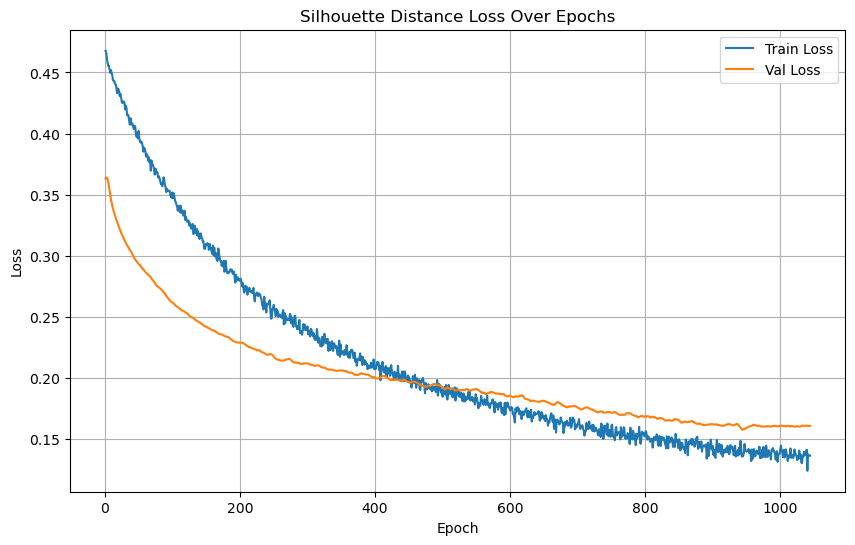

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/835], Loss: 0.0509
Test Batch [20/835], Loss: 0.1364
Test Batch [30/835], Loss: 0.1396
Test Batch [40/835], Loss: 0.5000
Test Batch [50/835], Loss: 0.5000
Test Batch [60/835], Loss: 0.0844
Test Batch [70/835], Loss: 0.1323


Test Batch [80/835], Loss: 0.1037
Test Batch [90/835], Loss: 0.0595
Test Batch [100/835], Loss: 0.1366
Test Batch [110/835], Loss: 0.0840
Test Batch [120/835], Loss: 0.0946
Test Batch [130/835], Loss: 0.1171
Test Batch [140/835], Loss: 0.0976
Test Batch [150/835], Loss: 0.1032


Test Batch [160/835], Loss: 0.0763
Test Batch [170/835], Loss: 0.1195
Test Batch [180/835], Loss: 0.1241
Test Batch [190/835], Loss: 0.0650
Test Batch [200/835], Loss: 0.0451


Test Batch [210/835], Loss: 0.0295
Test Batch [220/835], Loss: 0.0716
Test Batch [230/835], Loss: 0.0293
Test Batch [240/835], Loss: 0.0810


Test Batch [250/835], Loss: 0.0979
Test Batch [260/835], Loss: 0.0874
Test Batch [270/835], Loss: 0.0860


Test Batch [280/835], Loss: 0.1123
Test Batch [290/835], Loss: 0.1774
Test Batch [300/835], Loss: 0.1518
Test Batch [310/835], Loss: 0.1474
Test Batch [320/835], Loss: 0.1647


Test Batch [330/835], Loss: 0.1665
Test Batch [340/835], Loss: 0.5000
Test Batch [350/835], Loss: 0.5000
Test Batch [360/835], Loss: 0.5000
Test Batch [370/835], Loss: 0.5000
Test Batch [380/835], Loss: 0.5000
Test Batch [390/835], Loss: 0.5000
Test Batch [400/835], Loss: 0.5000
Test Batch [410/835], Loss: 0.5000
Test Batch [420/835], Loss: 0.0956
Test Batch [430/835], Loss: 0.0550


Test Batch [440/835], Loss: 0.0405
Test Batch [450/835], Loss: 0.0953
Test Batch [460/835], Loss: 0.0520
Test Batch [470/835], Loss: 0.0815
Test Batch [480/835], Loss: 0.0596
Test Batch [490/835], Loss: 0.5000
Test Batch [500/835], Loss: 0.0262


Test Batch [510/835], Loss: 0.0272
Test Batch [520/835], Loss: 0.0872
Test Batch [530/835], Loss: 0.0282
Test Batch [540/835], Loss: 0.0310
Test Batch [550/835], Loss: 0.0272


Test Batch [560/835], Loss: 0.0405
Test Batch [570/835], Loss: 0.0404
Test Batch [580/835], Loss: 0.0993
Test Batch [590/835], Loss: 0.0301
Test Batch [600/835], Loss: 0.0733
Test Batch [610/835], Loss: 0.5000


Test Batch [620/835], Loss: 0.2017
Test Batch [630/835], Loss: 0.5000
Test Batch [640/835], Loss: 0.0973
Test Batch [650/835], Loss: 0.0672
Test Batch [660/835], Loss: 0.1114


Test Batch [670/835], Loss: 0.3960
Test Batch [680/835], Loss: 0.0720
Test Batch [690/835], Loss: 0.0381
Test Batch [700/835], Loss: 0.2939
Test Batch [710/835], Loss: 0.1519


Test Batch [720/835], Loss: 0.5000
Test Batch [730/835], Loss: 0.3974
Test Batch [740/835], Loss: 0.5000
Test Batch [750/835], Loss: 0.0366
Test Batch [760/835], Loss: 0.1338


Test Batch [770/835], Loss: 0.1488
Test Batch [780/835], Loss: 0.5000
Test Batch [790/835], Loss: 0.1115
Test Batch [800/835], Loss: 0.1538
Test Batch [810/835], Loss: 0.5000
Test Batch [820/835], Loss: 0.1249
Test Batch [830/835], Loss: 0.5000

Test Loss: 0.1774


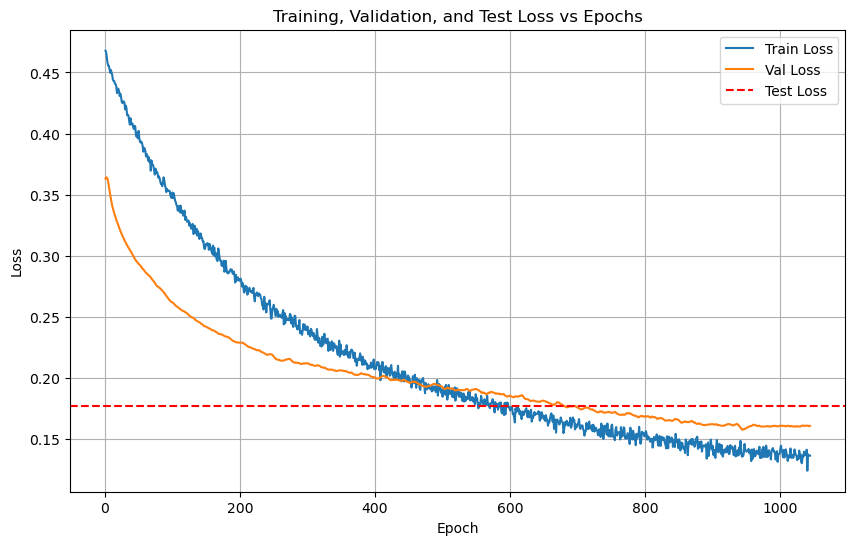

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/835 for test dataset.
  Processed batch 20/835 for test dataset.


  Processed batch 30/835 for test dataset.
  Processed batch 40/835 for test dataset.
  Processed batch 50/835 for test dataset.


  Processed batch 60/835 for test dataset.
  Processed batch 70/835 for test dataset.
  Processed batch 80/835 for test dataset.
  Processed batch 90/835 for test dataset.


  Processed batch 100/835 for test dataset.
  Processed batch 110/835 for test dataset.
  Processed batch 120/835 for test dataset.


  Processed batch 130/835 for test dataset.
  Processed batch 140/835 for test dataset.
  Processed batch 150/835 for test dataset.
  Processed batch 160/835 for test dataset.


  Processed batch 170/835 for test dataset.
  Processed batch 180/835 for test dataset.
  Processed batch 190/835 for test dataset.
  Processed batch 200/835 for test dataset.


  Processed batch 210/835 for test dataset.
  Processed batch 220/835 for test dataset.
  Processed batch 230/835 for test dataset.


  Processed batch 240/835 for test dataset.
  Processed batch 250/835 for test dataset.
  Processed batch 260/835 for test dataset.
  Processed batch 270/835 for test dataset.


  Processed batch 280/835 for test dataset.
  Processed batch 290/835 for test dataset.
  Processed batch 300/835 for test dataset.
  Processed batch 310/835 for test dataset.


  Processed batch 320/835 for test dataset.
  Processed batch 330/835 for test dataset.
  Processed batch 340/835 for test dataset.


  Processed batch 350/835 for test dataset.
  Processed batch 360/835 for test dataset.
  Processed batch 370/835 for test dataset.
  Processed batch 380/835 for test dataset.


  Processed batch 390/835 for test dataset.
  Processed batch 400/835 for test dataset.
  Processed batch 410/835 for test dataset.


  Processed batch 420/835 for test dataset.
  Processed batch 430/835 for test dataset.
  Processed batch 440/835 for test dataset.


  Processed batch 450/835 for test dataset.
  Processed batch 460/835 for test dataset.
  Processed batch 470/835 for test dataset.


  Processed batch 480/835 for test dataset.
  Processed batch 490/835 for test dataset.
  Processed batch 500/835 for test dataset.


  Processed batch 510/835 for test dataset.
  Processed batch 520/835 for test dataset.
  Processed batch 530/835 for test dataset.


  Processed batch 540/835 for test dataset.
  Processed batch 550/835 for test dataset.
  Processed batch 560/835 for test dataset.
  Processed batch 570/835 for test dataset.


  Processed batch 580/835 for test dataset.
  Processed batch 590/835 for test dataset.
  Processed batch 600/835 for test dataset.


  Processed batch 610/835 for test dataset.
  Processed batch 620/835 for test dataset.
  Processed batch 630/835 for test dataset.
  Processed batch 640/835 for test dataset.


  Processed batch 650/835 for test dataset.
  Processed batch 660/835 for test dataset.
  Processed batch 670/835 for test dataset.


  Processed batch 680/835 for test dataset.
  Processed batch 690/835 for test dataset.
  Processed batch 700/835 for test dataset.


  Processed batch 710/835 for test dataset.
  Processed batch 720/835 for test dataset.
  Processed batch 730/835 for test dataset.


  Processed batch 740/835 for test dataset.
  Processed batch 750/835 for test dataset.
  Processed batch 760/835 for test dataset.


  Processed batch 770/835 for test dataset.
  Processed batch 780/835 for test dataset.
  Processed batch 790/835 for test dataset.


  Processed batch 800/835 for test dataset.
  Processed batch 810/835 for test dataset.
  Processed batch 820/835 for test dataset.


  Processed batch 830/835 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6844  |  Val Loss: 2.6171
Validation loss improved from inf to 2.6171.
[Epoch 2/1000] Train Loss: 2.5409  |  Val Loss: 2.4810
Validation loss improved from 2.6171 to 2.4810.
[Epoch 3/1000] Train Loss: 2.4166  |  Val Loss: 2.3754
Validation loss improved from 2.4810 to 2.3754.
[Epoch 4/1000] Train Loss: 2.3173  |  Val Loss: 2.2851
Validation loss improved from 2.3754 to 2.2851.
[Epoch 5/1000] Train Loss: 2.2245  |  Val Loss: 2.2044
Validation loss improved from 2.2851 to 2.2044.
[Epoch 6/1000] Train Loss: 2.1421  |  Val Loss: 2.1343
Validation loss improved from 2.2044 to 2.1343.
[Epoch 7/1000] Train Loss: 2.0666  |  Val Loss: 2.0722
Validation loss improved from 2.1343 to 2.0722.


[Epoch 8/1000] Train Loss: 1.9983  |  Val Loss: 2.0163
Validation loss improved from 2.0722 to 2.0163.
[Epoch 9/1000] Train Loss: 1.9349  |  Val Loss: 1.9634
Validation loss improved from 2.0163 to 1.9634.
[Epoch 10/1000] Train Loss: 1.8725  |  Val Loss: 1.9123
Validation loss improved from 1.9634 to 1.9123.
[Epoch 11/1000] Train Loss: 1.8126  |  Val Loss: 1.8638
Validation loss improved from 1.9123 to 1.8638.


[Epoch 12/1000] Train Loss: 1.7566  |  Val Loss: 1.8190
Validation loss improved from 1.8638 to 1.8190.
[Epoch 13/1000] Train Loss: 1.7048  |  Val Loss: 1.7761
Validation loss improved from 1.8190 to 1.7761.
[Epoch 14/1000] Train Loss: 1.6557  |  Val Loss: 1.7343
Validation loss improved from 1.7761 to 1.7343.
[Epoch 15/1000] Train Loss: 1.6071  |  Val Loss: 1.6939
Validation loss improved from 1.7343 to 1.6939.
[Epoch 16/1000] Train Loss: 1.5596  |  Val Loss: 1.6526
Validation loss improved from 1.6939 to 1.6526.
[Epoch 17/1000] Train Loss: 1.5124  |  Val Loss: 1.6140
Validation loss improved from 1.6526 to 1.6140.
[Epoch 18/1000] Train Loss: 1.4666  |  Val Loss: 1.5776
Validation loss improved from 1.6140 to 1.5776.


[Epoch 19/1000] Train Loss: 1.4229  |  Val Loss: 1.5416
Validation loss improved from 1.5776 to 1.5416.
[Epoch 20/1000] Train Loss: 1.3791  |  Val Loss: 1.5046
Validation loss improved from 1.5416 to 1.5046.
[Epoch 21/1000] Train Loss: 1.3346  |  Val Loss: 1.4699
Validation loss improved from 1.5046 to 1.4699.
[Epoch 22/1000] Train Loss: 1.2918  |  Val Loss: 1.4360
Validation loss improved from 1.4699 to 1.4360.


[Epoch 23/1000] Train Loss: 1.2505  |  Val Loss: 1.4017
Validation loss improved from 1.4360 to 1.4017.
[Epoch 24/1000] Train Loss: 1.2101  |  Val Loss: 1.3687
Validation loss improved from 1.4017 to 1.3687.
[Epoch 25/1000] Train Loss: 1.1712  |  Val Loss: 1.3359
Validation loss improved from 1.3687 to 1.3359.
[Epoch 26/1000] Train Loss: 1.1336  |  Val Loss: 1.3039
Validation loss improved from 1.3359 to 1.3039.
[Epoch 27/1000] Train Loss: 1.0965  |  Val Loss: 1.2742
Validation loss improved from 1.3039 to 1.2742.
[Epoch 28/1000] Train Loss: 1.0612  |  Val Loss: 1.2449
Validation loss improved from 1.2742 to 1.2449.


[Epoch 29/1000] Train Loss: 1.0260  |  Val Loss: 1.2168
Validation loss improved from 1.2449 to 1.2168.
[Epoch 30/1000] Train Loss: 0.9923  |  Val Loss: 1.1896
Validation loss improved from 1.2168 to 1.1896.
[Epoch 31/1000] Train Loss: 0.9589  |  Val Loss: 1.1623
Validation loss improved from 1.1896 to 1.1623.
[Epoch 32/1000] Train Loss: 0.9261  |  Val Loss: 1.1342
Validation loss improved from 1.1623 to 1.1342.


[Epoch 33/1000] Train Loss: 0.8929  |  Val Loss: 1.1059
Validation loss improved from 1.1342 to 1.1059.
[Epoch 34/1000] Train Loss: 0.8621  |  Val Loss: 1.0791
Validation loss improved from 1.1059 to 1.0791.
[Epoch 35/1000] Train Loss: 0.8300  |  Val Loss: 1.0542
Validation loss improved from 1.0791 to 1.0542.
[Epoch 36/1000] Train Loss: 0.8008  |  Val Loss: 1.0286
Validation loss improved from 1.0542 to 1.0286.
[Epoch 37/1000] Train Loss: 0.7718  |  Val Loss: 1.0042
Validation loss improved from 1.0286 to 1.0042.
[Epoch 38/1000] Train Loss: 0.7429  |  Val Loss: 0.9798
Validation loss improved from 1.0042 to 0.9798.


[Epoch 39/1000] Train Loss: 0.7153  |  Val Loss: 0.9569
Validation loss improved from 0.9798 to 0.9569.
[Epoch 40/1000] Train Loss: 0.6879  |  Val Loss: 0.9328
Validation loss improved from 0.9569 to 0.9328.
[Epoch 41/1000] Train Loss: 0.6623  |  Val Loss: 0.9111
Validation loss improved from 0.9328 to 0.9111.
[Epoch 42/1000] Train Loss: 0.6369  |  Val Loss: 0.8901
Validation loss improved from 0.9111 to 0.8901.


[Epoch 43/1000] Train Loss: 0.6131  |  Val Loss: 0.8697
Validation loss improved from 0.8901 to 0.8697.
[Epoch 44/1000] Train Loss: 0.5910  |  Val Loss: 0.8499
Validation loss improved from 0.8697 to 0.8499.
[Epoch 45/1000] Train Loss: 0.5694  |  Val Loss: 0.8317
Validation loss improved from 0.8499 to 0.8317.
[Epoch 46/1000] Train Loss: 0.5481  |  Val Loss: 0.8155
Validation loss improved from 0.8317 to 0.8155.
[Epoch 47/1000] Train Loss: 0.5285  |  Val Loss: 0.7988
Validation loss improved from 0.8155 to 0.7988.
[Epoch 48/1000] Train Loss: 0.5092  |  Val Loss: 0.7838
Validation loss improved from 0.7988 to 0.7838.


[Epoch 49/1000] Train Loss: 0.4909  |  Val Loss: 0.7684
Validation loss improved from 0.7838 to 0.7684.
[Epoch 50/1000] Train Loss: 0.4730  |  Val Loss: 0.7543
Validation loss improved from 0.7684 to 0.7543.
[Epoch 51/1000] Train Loss: 0.4551  |  Val Loss: 0.7411
Validation loss improved from 0.7543 to 0.7411.
[Epoch 52/1000] Train Loss: 0.4383  |  Val Loss: 0.7285
Validation loss improved from 0.7411 to 0.7285.


[Epoch 53/1000] Train Loss: 0.4224  |  Val Loss: 0.7157
Validation loss improved from 0.7285 to 0.7157.
[Epoch 54/1000] Train Loss: 0.4065  |  Val Loss: 0.7047
Validation loss improved from 0.7157 to 0.7047.
[Epoch 55/1000] Train Loss: 0.3918  |  Val Loss: 0.6933
Validation loss improved from 0.7047 to 0.6933.
[Epoch 56/1000] Train Loss: 0.3765  |  Val Loss: 0.6818
Validation loss improved from 0.6933 to 0.6818.
[Epoch 57/1000] Train Loss: 0.3626  |  Val Loss: 0.6714
Validation loss improved from 0.6818 to 0.6714.
[Epoch 58/1000] Train Loss: 0.3481  |  Val Loss: 0.6614
Validation loss improved from 0.6714 to 0.6614.
[Epoch 59/1000] Train Loss: 0.3349  |  Val Loss: 0.6515
Validation loss improved from 0.6614 to 0.6515.
[Epoch 60/1000] Train Loss: 0.3213  |  Val Loss: 0.6416
Validation loss improved from 0.6515 to 0.6416.


[Epoch 61/1000] Train Loss: 0.3097  |  Val Loss: 0.6319
Validation loss improved from 0.6416 to 0.6319.
[Epoch 62/1000] Train Loss: 0.2978  |  Val Loss: 0.6247
Validation loss improved from 0.6319 to 0.6247.
[Epoch 63/1000] Train Loss: 0.2862  |  Val Loss: 0.6171
Validation loss improved from 0.6247 to 0.6171.


[Epoch 64/1000] Train Loss: 0.2754  |  Val Loss: 0.6100
Validation loss improved from 0.6171 to 0.6100.
[Epoch 65/1000] Train Loss: 0.2658  |  Val Loss: 0.6030
Validation loss improved from 0.6100 to 0.6030.
[Epoch 66/1000] Train Loss: 0.2565  |  Val Loss: 0.5982
Validation loss improved from 0.6030 to 0.5982.
[Epoch 67/1000] Train Loss: 0.2471  |  Val Loss: 0.5936
Validation loss improved from 0.5982 to 0.5936.
[Epoch 68/1000] Train Loss: 0.2388  |  Val Loss: 0.5876
Validation loss improved from 0.5936 to 0.5876.
[Epoch 69/1000] Train Loss: 0.2315  |  Val Loss: 0.5820
Validation loss improved from 0.5876 to 0.5820.
[Epoch 70/1000] Train Loss: 0.2230  |  Val Loss: 0.5797
Validation loss improved from 0.5820 to 0.5797.
[Epoch 71/1000] Train Loss: 0.2157  |  Val Loss: 0.5766
Validation loss improved from 0.5797 to 0.5766.


[Epoch 72/1000] Train Loss: 0.2088  |  Val Loss: 0.5736
Validation loss improved from 0.5766 to 0.5736.
[Epoch 73/1000] Train Loss: 0.2020  |  Val Loss: 0.5687
Validation loss improved from 0.5736 to 0.5687.
[Epoch 74/1000] Train Loss: 0.1959  |  Val Loss: 0.5671
Validation loss improved from 0.5687 to 0.5671.


[Epoch 75/1000] Train Loss: 0.1895  |  Val Loss: 0.5643
Validation loss improved from 0.5671 to 0.5643.
[Epoch 76/1000] Train Loss: 0.1839  |  Val Loss: 0.5623
Validation loss improved from 0.5643 to 0.5623.
[Epoch 77/1000] Train Loss: 0.1788  |  Val Loss: 0.5596
Validation loss improved from 0.5623 to 0.5596.
[Epoch 78/1000] Train Loss: 0.1737  |  Val Loss: 0.5574
Validation loss improved from 0.5596 to 0.5574.
[Epoch 79/1000] Train Loss: 0.1690  |  Val Loss: 0.5566
Validation loss improved from 0.5574 to 0.5566.
[Epoch 80/1000] Train Loss: 0.1644  |  Val Loss: 0.5526
Validation loss improved from 0.5566 to 0.5526.
[Epoch 81/1000] Train Loss: 0.1600  |  Val Loss: 0.5523
Validation loss improved from 0.5526 to 0.5523.
[Epoch 82/1000] Train Loss: 0.1556  |  Val Loss: 0.5518
Validation loss improved from 0.5523 to 0.5518.


[Epoch 83/1000] Train Loss: 0.1519  |  Val Loss: 0.5517
Validation loss improved from 0.5518 to 0.5517.
[Epoch 84/1000] Train Loss: 0.1498  |  Val Loss: 0.5482
Validation loss improved from 0.5517 to 0.5482.


[Epoch 85/1000] Train Loss: 0.1448  |  Val Loss: 0.5498
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 0.1412  |  Val Loss: 0.5481
Validation loss improved from 0.5482 to 0.5481.
[Epoch 87/1000] Train Loss: 0.1381  |  Val Loss: 0.5477
Validation loss improved from 0.5481 to 0.5477.
[Epoch 88/1000] Train Loss: 0.1344  |  Val Loss: 0.5461
Validation loss improved from 0.5477 to 0.5461.
[Epoch 89/1000] Train Loss: 0.1320  |  Val Loss: 0.5451
Validation loss improved from 0.5461 to 0.5451.
[Epoch 90/1000] Train Loss: 0.1297  |  Val Loss: 0.5487
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 91/1000] Train Loss: 0.1261  |  Val Loss: 0.5460
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 92/1000] Train Loss: 0.1236  |  Val Loss: 0.5447
Validation loss improved from 0.5451 to 0.5447.
[Epoch 93/1000] Train Loss: 0.1211  |  Val Loss: 0.5456
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 94/1000] Train Loss: 0.1190  |  Val Loss: 0.5485
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 95/1000] Train Loss: 0.1163  |  Val Loss: 0.5467
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 96/1000] Train Loss: 0.1140  |  Val Loss: 0.5465
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 97/1000] Train Loss: 0.1122  |  Val Loss: 0.5477
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 98/1000] Train Loss: 0.1104  |  Val Loss: 0.5531
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 99/1000] Train Loss: 0.1084  |  Val Loss: 0.5512
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 100/1000] Train Loss: 0.1062  |  Val Loss: 0.5521
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 101/1000] Train Loss: 0.1047  |  Val Loss: 0.5548
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 102/1000] Train Loss: 0.1030  |  Val Loss: 0.5537
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 103/1000] Train Loss: 0.1004  |  Val Loss: 0.5568
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 104/1000] Train Loss: 0.0992  |  Val Loss: 0.5611
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 105/1000] Train Loss: 0.0974  |  Val Loss: 0.5600
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 106/1000] Train Loss: 0.0961  |  Val Loss: 0.5609
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 107/1000] Train Loss: 0.0944  |  Val Loss: 0.5622
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 108/1000] Train Loss: 0.0935  |  Val Loss: 0.5658
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 109/1000] Train Loss: 0.0921  |  Val Loss: 0.5628
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 110/1000] Train Loss: 0.0902  |  Val Loss: 0.5660
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 111/1000] Train Loss: 0.0890  |  Val Loss: 0.5683
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 112/1000] Train Loss: 0.0876  |  Val Loss: 0.5700
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 113/1000] Train Loss: 0.0865  |  Val Loss: 0.5695
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 114/1000] Train Loss: 0.0852  |  Val Loss: 0.5695
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 115/1000] Train Loss: 0.0842  |  Val Loss: 0.5715
!! Validation loss did NOT improve !! Patience: 23/100


[Epoch 116/1000] Train Loss: 0.0835  |  Val Loss: 0.5711
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 117/1000] Train Loss: 0.0817  |  Val Loss: 0.5769
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 118/1000] Train Loss: 0.0812  |  Val Loss: 0.5791
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 119/1000] Train Loss: 0.0798  |  Val Loss: 0.5768
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 120/1000] Train Loss: 0.0788  |  Val Loss: 0.5794
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 121/1000] Train Loss: 0.0777  |  Val Loss: 0.5802
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 122/1000] Train Loss: 0.0766  |  Val Loss: 0.5830
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 123/1000] Train Loss: 0.0763  |  Val Loss: 0.5866
!! Validation loss did NOT improve !! Patience: 31/100


[Epoch 124/1000] Train Loss: 0.0750  |  Val Loss: 0.5833
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 125/1000] Train Loss: 0.0740  |  Val Loss: 0.5861
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 126/1000] Train Loss: 0.0730  |  Val Loss: 0.5885
!! Validation loss did NOT improve !! Patience: 34/100


[Epoch 127/1000] Train Loss: 0.0725  |  Val Loss: 0.5891
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 128/1000] Train Loss: 0.0713  |  Val Loss: 0.5895
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 129/1000] Train Loss: 0.0708  |  Val Loss: 0.5917
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 130/1000] Train Loss: 0.0703  |  Val Loss: 0.5976
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 131/1000] Train Loss: 0.0689  |  Val Loss: 0.5939
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 132/1000] Train Loss: 0.0699  |  Val Loss: 0.5926
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 133/1000] Train Loss: 0.0674  |  Val Loss: 0.6007
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 134/1000] Train Loss: 0.0677  |  Val Loss: 0.5981
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 135/1000] Train Loss: 0.0658  |  Val Loss: 0.6022
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 136/1000] Train Loss: 0.0652  |  Val Loss: 0.6031
!! Validation loss did NOT improve !! Patience: 44/100


[Epoch 137/1000] Train Loss: 0.0643  |  Val Loss: 0.6036
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 138/1000] Train Loss: 0.0650  |  Val Loss: 0.6035
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 139/1000] Train Loss: 0.0636  |  Val Loss: 0.6086
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 140/1000] Train Loss: 0.0624  |  Val Loss: 0.6089
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 141/1000] Train Loss: 0.0620  |  Val Loss: 0.6073
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 142/1000] Train Loss: 0.0615  |  Val Loss: 0.6117
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 143/1000] Train Loss: 0.0609  |  Val Loss: 0.6134
!! Validation loss did NOT improve !! Patience: 51/100


[Epoch 144/1000] Train Loss: 0.0599  |  Val Loss: 0.6137
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 145/1000] Train Loss: 0.0596  |  Val Loss: 0.6130
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 146/1000] Train Loss: 0.0595  |  Val Loss: 0.6186
!! Validation loss did NOT improve !! Patience: 54/100


[Epoch 147/1000] Train Loss: 0.0586  |  Val Loss: 0.6163
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 148/1000] Train Loss: 0.0574  |  Val Loss: 0.6195
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 149/1000] Train Loss: 0.0570  |  Val Loss: 0.6196
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 150/1000] Train Loss: 0.0565  |  Val Loss: 0.6211
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 151/1000] Train Loss: 0.0560  |  Val Loss: 0.6216
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 152/1000] Train Loss: 0.0559  |  Val Loss: 0.6279
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 153/1000] Train Loss: 0.0549  |  Val Loss: 0.6234
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 154/1000] Train Loss: 0.0545  |  Val Loss: 0.6258
!! Validation loss did NOT improve !! Patience: 62/100


[Epoch 155/1000] Train Loss: 0.0541  |  Val Loss: 0.6268
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 156/1000] Train Loss: 0.0536  |  Val Loss: 0.6276
!! Validation loss did NOT improve !! Patience: 64/100


[Epoch 157/1000] Train Loss: 0.0527  |  Val Loss: 0.6306
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 158/1000] Train Loss: 0.0526  |  Val Loss: 0.6320
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 159/1000] Train Loss: 0.0518  |  Val Loss: 0.6339
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 160/1000] Train Loss: 0.0514  |  Val Loss: 0.6345
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 161/1000] Train Loss: 0.0515  |  Val Loss: 0.6356
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 162/1000] Train Loss: 0.0507  |  Val Loss: 0.6356
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 163/1000] Train Loss: 0.0502  |  Val Loss: 0.6401
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 164/1000] Train Loss: 0.0497  |  Val Loss: 0.6430
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 165/1000] Train Loss: 0.0495  |  Val Loss: 0.6450
!! Validation loss did NOT improve !! Patience:

[Epoch 166/1000] Train Loss: 0.0486  |  Val Loss: 0.6434
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 167/1000] Train Loss: 0.0491  |  Val Loss: 0.6460
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 168/1000] Train Loss: 0.0484  |  Val Loss: 0.6447
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 169/1000] Train Loss: 0.0476  |  Val Loss: 0.6475
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 170/1000] Train Loss: 0.0471  |  Val Loss: 0.6488
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 171/1000] Train Loss: 0.0475  |  Val Loss: 0.6509
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 172/1000] Train Loss: 0.0471  |  Val Loss: 0.6513
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 173/1000] Train Loss: 0.0464  |  Val Loss: 0.6544
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 174/1000] Train Loss: 0.0464  |  Val Loss: 0.6509
!! Validation loss did NOT improve !! Patience:

[Epoch 176/1000] Train Loss: 0.0467  |  Val Loss: 0.6624
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 177/1000] Train Loss: 0.0471  |  Val Loss: 0.6526
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 178/1000] Train Loss: 0.0446  |  Val Loss: 0.6602
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 179/1000] Train Loss: 0.0442  |  Val Loss: 0.6615
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 180/1000] Train Loss: 0.0443  |  Val Loss: 0.6595
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 181/1000] Train Loss: 0.0435  |  Val Loss: 0.6606
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 182/1000] Train Loss: 0.0434  |  Val Loss: 0.6631
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 183/1000] Train Loss: 0.0427  |  Val Loss: 0.6638
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 184/1000] Train Loss: 0.0422  |  Val Loss: 0.6625
!! Validation loss did NOT improve !! Patience:

[Epoch 186/1000] Train Loss: 0.0417  |  Val Loss: 0.6648
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 187/1000] Train Loss: 0.0418  |  Val Loss: 0.6674
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 188/1000] Train Loss: 0.0413  |  Val Loss: 0.6649
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 189/1000] Train Loss: 0.0411  |  Val Loss: 0.6701
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 190/1000] Train Loss: 0.0406  |  Val Loss: 0.6682
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 191/1000] Train Loss: 0.0405  |  Val Loss: 0.6661
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 192/1000] Train Loss: 0.0403  |  Val Loss: 0.6692
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 192 !!
No improvement for 100 epochs.


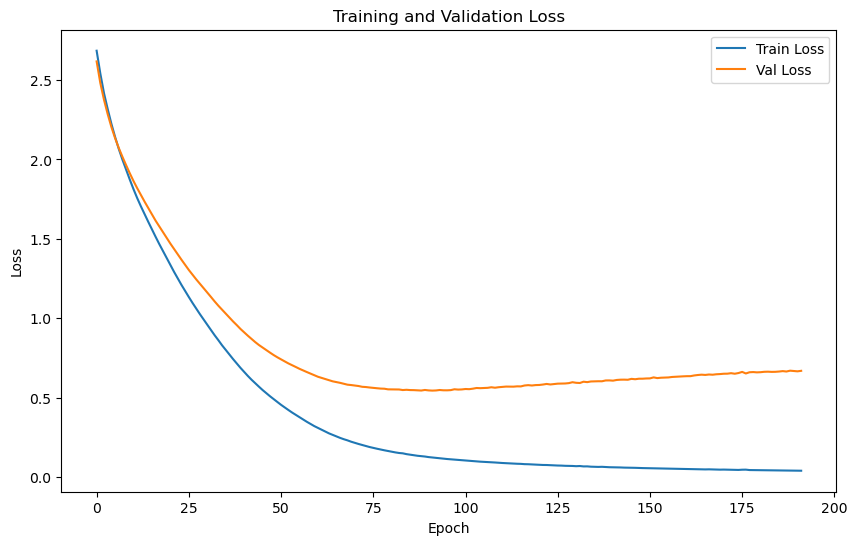

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7704 | Test Accuracy: 83.66%


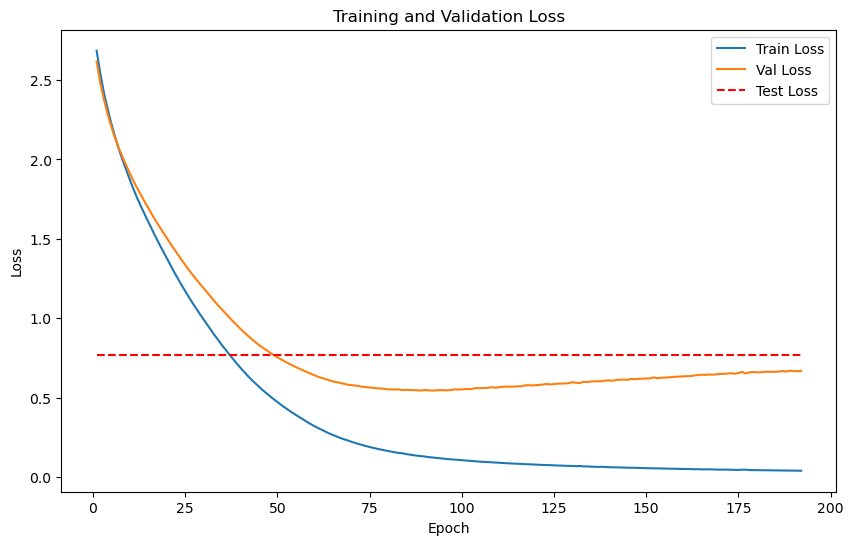

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


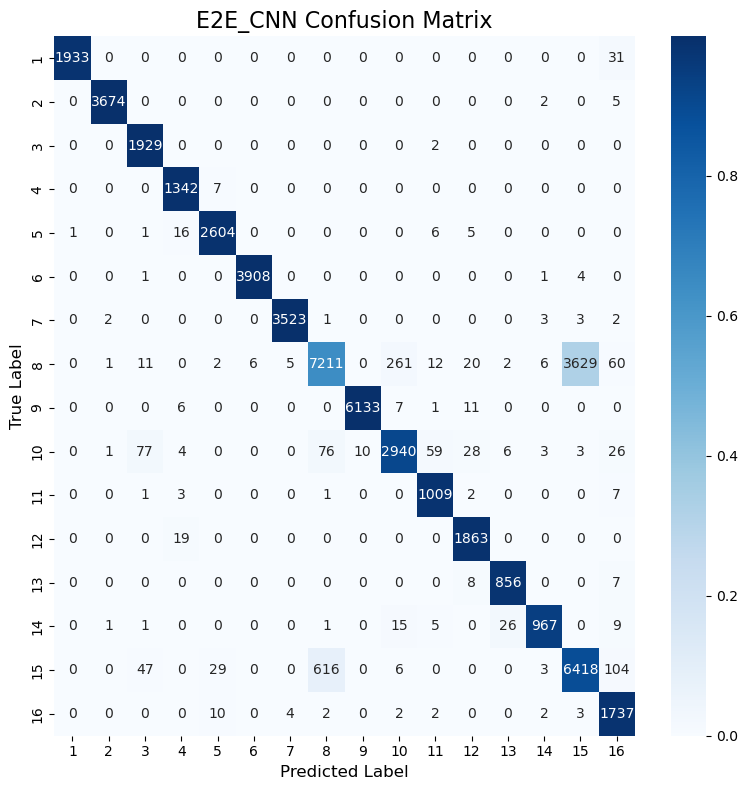

Classification Accuracy: 89.96%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


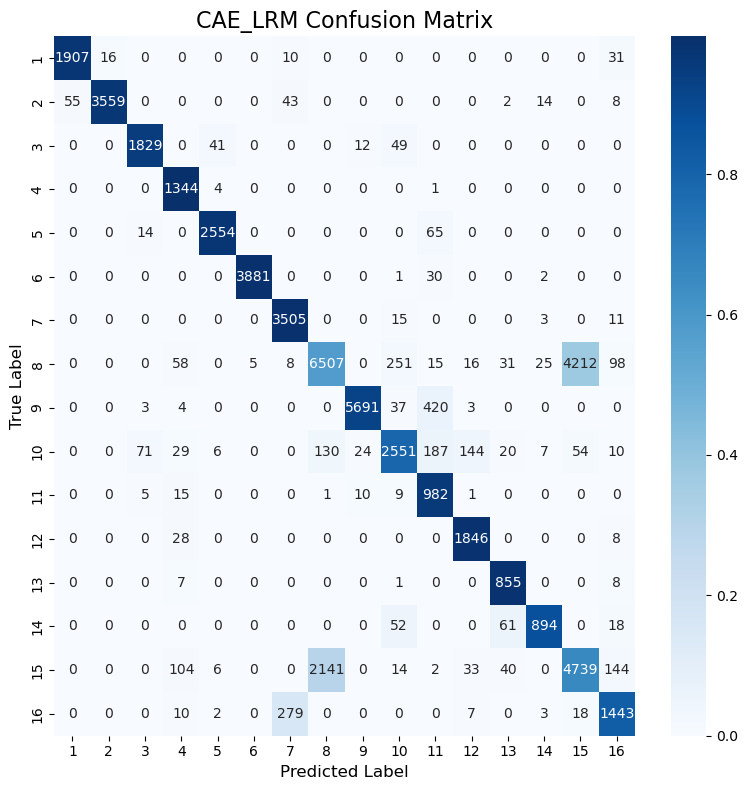

Classification Accuracy: 82.55%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


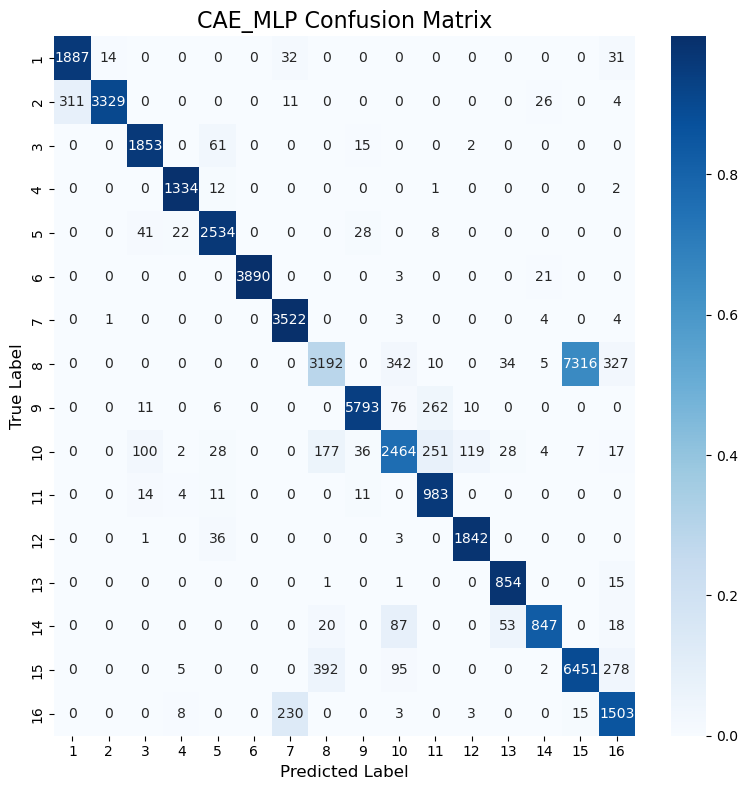

Classification Accuracy: 79.16%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


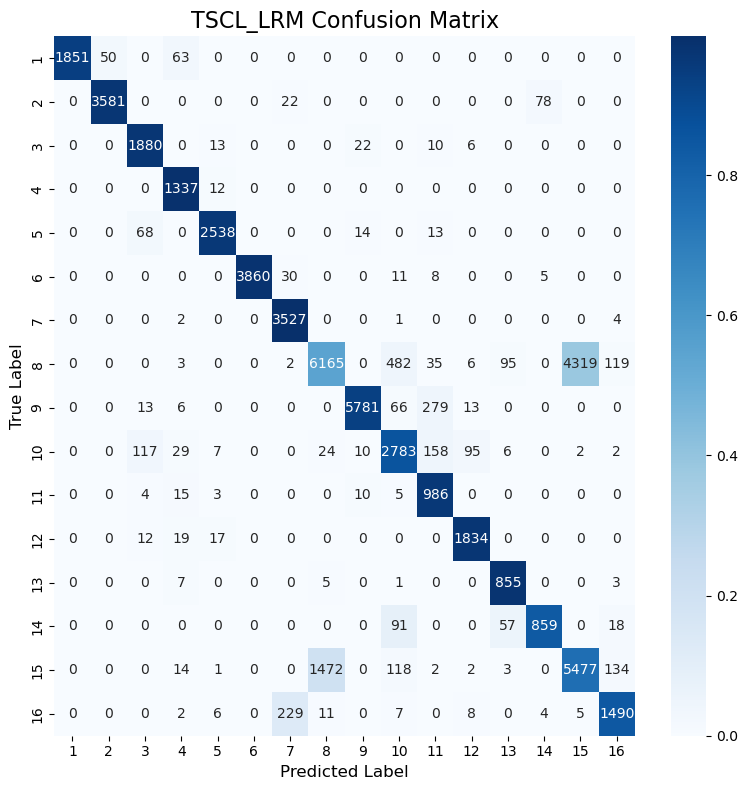

Classification Accuracy: 83.89%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


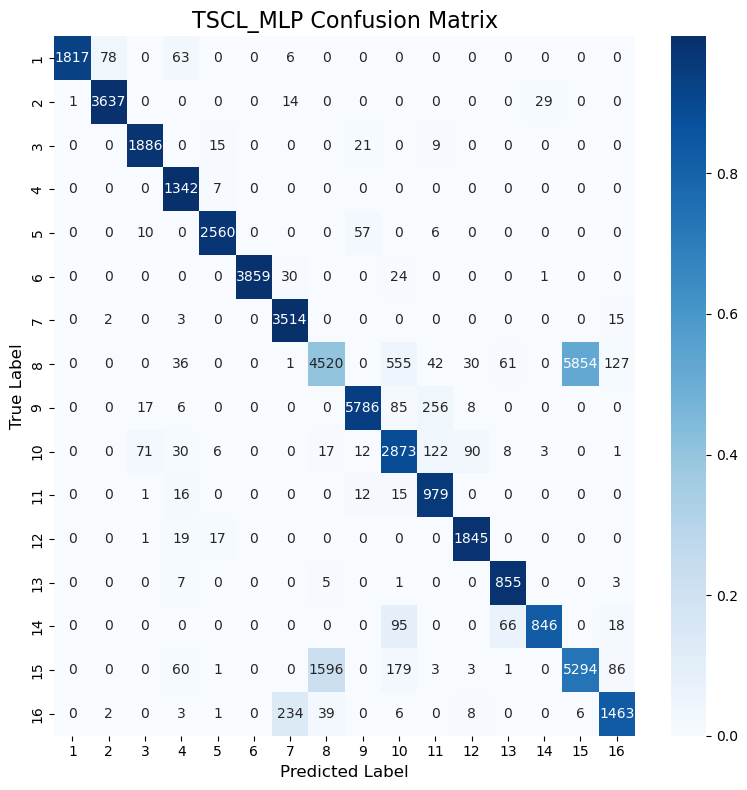

Classification Accuracy: 80.65%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


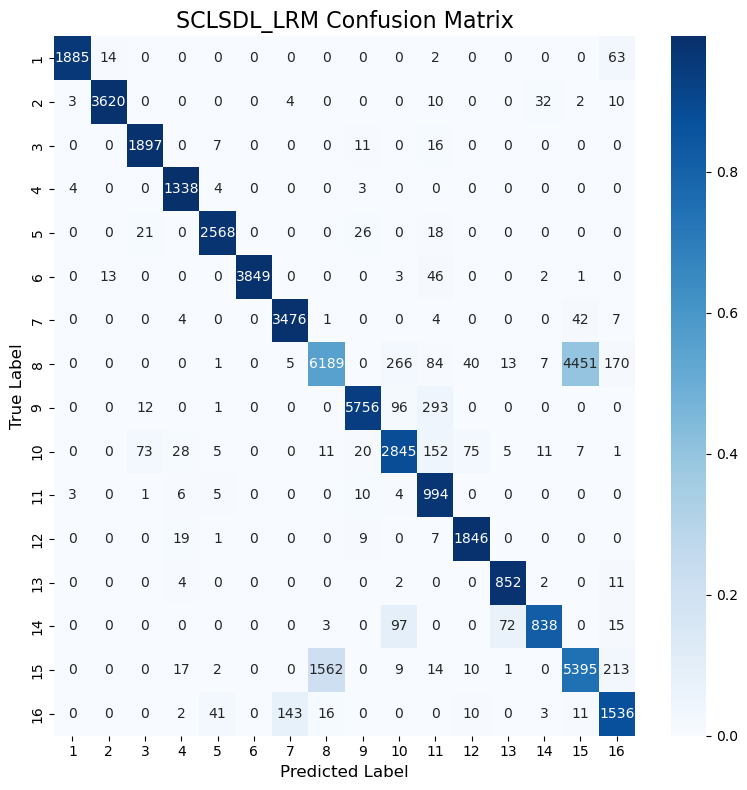

Classification Accuracy: 84.04%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


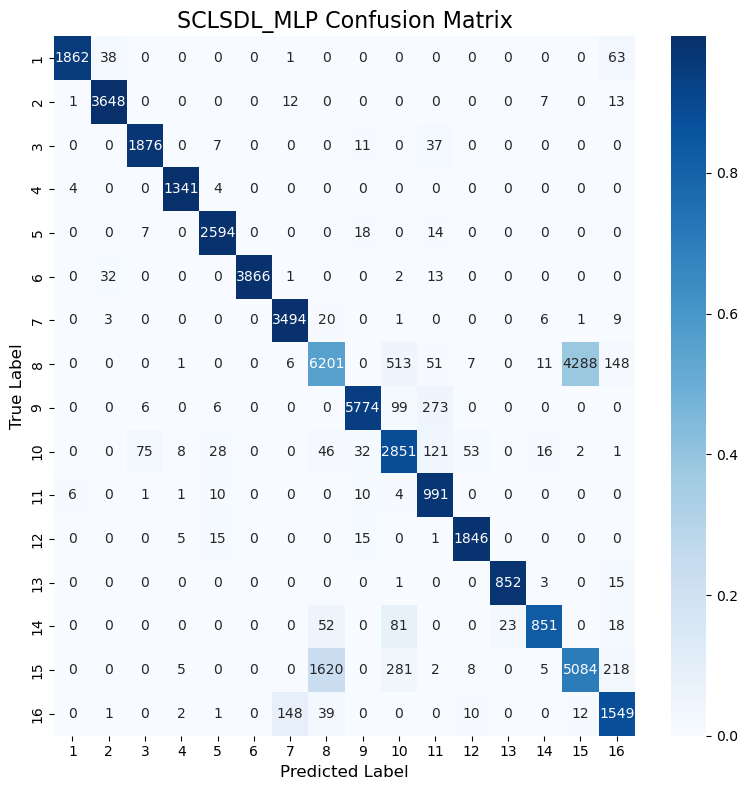

Classification Accuracy: 83.66%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          89.96
1    LRM (CAE)          82.55
2    MLP (CAE)          79.16
3     TSCL LRM          83.89
4     TSCL MLP          80.65
5  SCL_SDL LRM          84.04
6  SCL_SDL MLP          83.66

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          89.96
5  SCL_SDL LRM          84.04
3     TSCL LRM          83.89
6  SCL_SDL MLP          83.66
1    LRM (CAE)          82.55
4     TSCL MLP          80.65
2    MLP (CAE)          79.16
